In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import os
import gym_Aircraft
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
env = gym.make("acav-v0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class FClayer(nn.Module):
    def __init__(self, innodes: int, nodes: int):
        super(FClayer, self).__init__()
        self.fc=nn.Linear(innodes,nodes)
        self.act=nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x: Tensor) -> Tensor:
        out=self.fc(x)
        out=self.act(out)
        return out
    
class WaveNET(nn.Module):
    def __init__(self, block: Type[Union[FClayer]], planes: List[int], nodes: List[int], num_classes: int = 3
                ) -> None:
        super(WaveNET, self).__init__()
        self.innodes=5
        
        self.layer1=self._make_layer(block, planes[0], nodes[0])
        self.layer2=self._make_layer(block, planes[1], nodes[1])
        self.layer3=self._make_layer(block, planes[2], nodes[2])
        
        self.fin_fc=nn.Linear(self.innodes,num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    
    def _make_layer(self, block: Type[Union[FClayer]], planes: int, nodes: int) -> nn.Sequential:

        layers = []
        layers.append(block(self.innodes, nodes))
        self.innodes = nodes
        for _ in range(1, planes):
            layers.append(block(self.innodes, nodes))

        return nn.Sequential(*layers)

        
    def _forward_impl(self, x: Tensor) -> Tensor:
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fin_fc(x)
        
        return x
    
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [6]:
policy_net = torch.load("./Custom_model_fin").to(device)
target_net = torch.load("./Custom_model_fin").to(device)
target_net.eval()

WaveNET(
  (layer1): Sequential(
    (0): FClayer(
      (fc): Linear(in_features=5, out_features=60, bias=True)
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): FClayer(
      (fc): Linear(in_features=60, out_features=60, bias=True)
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (layer2): Sequential(
    (0): FClayer(
      (fc): Linear(in_features=60, out_features=20, bias=True)
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): FClayer(
      (fc): Linear(in_features=20, out_features=20, bias=True)
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (layer3): Sequential(
    (0): FClayer(
      (fc): Linear(in_features=20, out_features=20, bias=True)
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): FClayer(
      (fc): Linear(in_features=20, out_features=20, bias=True)
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (fin_fc): Linear(in_features=20, out_featu

In [7]:
n_actions = env.action_space.n

In [8]:
optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(1000)

In [9]:
steps_done = 0

In [10]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [12]:
num_episodes = 50000
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()
    state=torch.from_numpy(state.astype(np.float32)).unsqueeze(0).to(device)
    for t in count():
        # 행동 선택과 수행
        
        action = select_action(state)
        next_state, reward, done, res = env.step(action.item())
        reward = torch.tensor([reward], dtype=torch.float32).to(device)
        
        next_state=torch.from_numpy(next_state.astype(np.float32)).unsqueeze(0).to(device)

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # 최적화 한단계 수행(목표 네트워크에서)
        optimize_model()
        
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward.item()))
            break
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()

2020/11/25 03:24:54
episode : 0 | final step : 98 | total reward : -77.9749984741211
2020/11/25 03:24:54
episode : 1 | final step : 98 | total reward : -93.17500305175781
2020/11/25 03:24:55
episode : 2 | final step : 98 | total reward : -84.0250015258789
2020/11/25 03:24:55
episode : 3 | final step : 99 | total reward : -80.7750015258789
2020/11/25 03:24:55
episode : 4 | final step : 97 | total reward : 14.399999618530273
2020/11/25 03:24:56
episode : 5 | final step : 98 | total reward : -94.25
2020/11/25 03:24:56
episode : 6 | final step : 98 | total reward : 13.524999618530273
2020/11/25 03:24:57
episode : 7 | final step : 95 | total reward : 2.075000047683716
2020/11/25 03:24:57
episode : 8 | final step : 101 | total reward : -0.07500000298023224
2020/11/25 03:24:58
episode : 9 | final step : 99 | total reward : 10.824999809265137
2020/11/25 03:24:58
episode : 10 | final step : 98 | total reward : -92.4000015258789
2020/11/25 03:24:59
episode : 11 | final step : 98 | total reward :

2020/11/25 03:25:38
episode : 97 | final step : 99 | total reward : 2.4749999046325684
2020/11/25 03:25:38
episode : 98 | final step : 98 | total reward : -82.32499694824219
2020/11/25 03:25:39
episode : 99 | final step : 98 | total reward : -89.5250015258789
2020/11/25 03:25:39
episode : 100 | final step : 98 | total reward : -104.19999694824219
2020/11/25 03:25:40
episode : 101 | final step : 99 | total reward : -94.5250015258789
2020/11/25 03:25:40
episode : 102 | final step : 101 | total reward : 19.725000381469727
2020/11/25 03:25:41
episode : 103 | final step : 99 | total reward : -70.7750015258789
2020/11/25 03:25:41
episode : 104 | final step : 98 | total reward : -81.57499694824219
2020/11/25 03:25:41
episode : 105 | final step : 99 | total reward : -91.69999694824219
2020/11/25 03:25:42
episode : 106 | final step : 98 | total reward : 17.975000381469727
2020/11/25 03:25:42
episode : 107 | final step : 97 | total reward : 19.625
2020/11/25 03:25:42
episode : 108 | final step :

2020/11/25 03:26:18
episode : 193 | final step : 98 | total reward : -72.57499694824219
2020/11/25 03:26:18
episode : 194 | final step : 97 | total reward : 16.549999237060547
2020/11/25 03:26:19
episode : 195 | final step : 98 | total reward : -75.67500305175781
2020/11/25 03:26:19
episode : 196 | final step : 100 | total reward : 16.625
2020/11/25 03:26:20
episode : 197 | final step : 99 | total reward : -76.1500015258789
2020/11/25 03:26:20
episode : 198 | final step : 97 | total reward : -87.05000305175781
2020/11/25 03:26:21
episode : 199 | final step : 99 | total reward : -89.0250015258789
2020/11/25 03:26:21
episode : 200 | final step : 98 | total reward : 35.400001525878906
2020/11/25 03:26:21
episode : 201 | final step : 98 | total reward : -77.67500305175781
2020/11/25 03:26:22
episode : 202 | final step : 98 | total reward : -80.32499694824219
2020/11/25 03:26:22
episode : 203 | final step : 98 | total reward : -71.7750015258789
2020/11/25 03:26:23
episode : 204 | final step

2020/11/25 03:27:02
episode : 289 | final step : 97 | total reward : 13.199999809265137
2020/11/25 03:27:02
episode : 290 | final step : 99 | total reward : -94.125
2020/11/25 03:27:03
episode : 291 | final step : 98 | total reward : -76.0250015258789
2020/11/25 03:27:03
episode : 292 | final step : 98 | total reward : -83.82499694824219
2020/11/25 03:27:04
episode : 293 | final step : 98 | total reward : -87.7249984741211
2020/11/25 03:27:04
episode : 294 | final step : 98 | total reward : -81.25
2020/11/25 03:27:04
episode : 295 | final step : 98 | total reward : -85.92500305175781
2020/11/25 03:27:05
episode : 296 | final step : 98 | total reward : 29.549999237060547
2020/11/25 03:27:05
episode : 297 | final step : 98 | total reward : -78.92500305175781
2020/11/25 03:27:06
episode : 298 | final step : 98 | total reward : -64.67500305175781
2020/11/25 03:27:06
episode : 299 | final step : 98 | total reward : -74.375
2020/11/25 03:27:06
episode : 300 | final step : 98 | total reward :

2020/11/25 03:27:44
episode : 385 | final step : 100 | total reward : 15.350000381469727
2020/11/25 03:27:44
episode : 386 | final step : 99 | total reward : -96.375
2020/11/25 03:27:45
episode : 387 | final step : 98 | total reward : -92.375
2020/11/25 03:27:46
episode : 388 | final step : 100 | total reward : 2.625
2020/11/25 03:27:46
episode : 389 | final step : 99 | total reward : -70.2750015258789
2020/11/25 03:27:46
episode : 390 | final step : 99 | total reward : 14.350000381469727
2020/11/25 03:27:47
episode : 391 | final step : 98 | total reward : -81.9000015258789
2020/11/25 03:27:47
episode : 392 | final step : 98 | total reward : -82.32499694824219
2020/11/25 03:27:48
episode : 393 | final step : 99 | total reward : -86.5
2020/11/25 03:27:48
episode : 394 | final step : 98 | total reward : -60.32500076293945
2020/11/25 03:27:48
episode : 395 | final step : 99 | total reward : 1.774999976158142
2020/11/25 03:27:49
episode : 396 | final step : 98 | total reward : 3.125
2020/1

2020/11/25 03:28:26
episode : 482 | final step : 98 | total reward : -91.44999694824219
2020/11/25 03:28:26
episode : 483 | final step : 100 | total reward : 18.375
2020/11/25 03:28:27
episode : 484 | final step : 98 | total reward : -85.125
2020/11/25 03:28:27
episode : 485 | final step : 99 | total reward : -84.17500305175781
2020/11/25 03:28:28
episode : 486 | final step : 98 | total reward : -83.4749984741211
2020/11/25 03:28:28
episode : 487 | final step : 99 | total reward : -85.80000305175781
2020/11/25 03:28:28
episode : 488 | final step : 99 | total reward : 3.7750000953674316
2020/11/25 03:28:29
episode : 489 | final step : 98 | total reward : -81.80000305175781
2020/11/25 03:28:29
episode : 490 | final step : 98 | total reward : -85.0250015258789
2020/11/25 03:28:30
episode : 491 | final step : 99 | total reward : -90.2750015258789
2020/11/25 03:28:30
episode : 492 | final step : 98 | total reward : -77.2249984741211
2020/11/25 03:28:31
episode : 493 | final step : 98 | tota

2020/11/25 03:29:10
episode : 578 | final step : 98 | total reward : -94.375
2020/11/25 03:29:11
episode : 579 | final step : 98 | total reward : -89.80000305175781
2020/11/25 03:29:11
episode : 580 | final step : 98 | total reward : -85.32499694824219
2020/11/25 03:29:12
episode : 581 | final step : 98 | total reward : 13.524999618530273
2020/11/25 03:29:12
episode : 582 | final step : 99 | total reward : 13.5
2020/11/25 03:29:12
episode : 583 | final step : 99 | total reward : -75.0250015258789
2020/11/25 03:29:13
episode : 584 | final step : 98 | total reward : -86.7750015258789
2020/11/25 03:29:13
episode : 585 | final step : 98 | total reward : -84.3499984741211
2020/11/25 03:29:14
episode : 586 | final step : 100 | total reward : -82.57499694824219
2020/11/25 03:29:14
episode : 587 | final step : 99 | total reward : -91.44999694824219
2020/11/25 03:29:15
episode : 588 | final step : 100 | total reward : -89.8499984741211
2020/11/25 03:29:15
episode : 589 | final step : 98 | total

2020/11/25 03:29:56
episode : 674 | final step : 98 | total reward : -87.92500305175781
2020/11/25 03:29:57
episode : 675 | final step : 99 | total reward : -87.44999694824219
2020/11/25 03:29:57
episode : 676 | final step : 98 | total reward : -77.5
2020/11/25 03:29:58
episode : 677 | final step : 98 | total reward : -78.0
2020/11/25 03:29:58
episode : 678 | final step : 98 | total reward : -87.25
2020/11/25 03:29:59
episode : 679 | final step : 100 | total reward : 12.399999618530273
2020/11/25 03:30:00
episode : 680 | final step : 100 | total reward : -93.4749984741211
2020/11/25 03:30:00
episode : 681 | final step : 99 | total reward : -11.149999618530273
2020/11/25 03:30:01
episode : 682 | final step : 98 | total reward : -83.5999984741211
2020/11/25 03:30:01
episode : 683 | final step : 100 | total reward : 9.125
2020/11/25 03:30:02
episode : 684 | final step : 99 | total reward : -93.82499694824219
2020/11/25 03:30:02
episode : 685 | final step : 98 | total reward : -114.2750015

2020/11/25 03:30:37
episode : 771 | final step : 98 | total reward : -89.67500305175781
2020/11/25 03:30:37
episode : 772 | final step : 98 | total reward : -86.0250015258789
2020/11/25 03:30:37
episode : 773 | final step : 98 | total reward : 23.725000381469727
2020/11/25 03:30:38
episode : 774 | final step : 104 | total reward : 10.050000190734863
2020/11/25 03:30:38
episode : 775 | final step : 102 | total reward : 9.050000190734863
2020/11/25 03:30:39
episode : 776 | final step : 99 | total reward : -92.5250015258789
2020/11/25 03:30:39
episode : 777 | final step : 100 | total reward : 15.949999809265137
2020/11/25 03:30:39
episode : 778 | final step : 97 | total reward : 18.75
2020/11/25 03:30:40
episode : 779 | final step : 102 | total reward : 33.25
2020/11/25 03:30:40
episode : 780 | final step : 98 | total reward : -74.25
2020/11/25 03:30:40
episode : 781 | final step : 95 | total reward : 26.600000381469727
2020/11/25 03:30:41
episode : 782 | final step : 98 | total reward : 

2020/11/25 03:31:16
episode : 868 | final step : 99 | total reward : -80.1500015258789
2020/11/25 03:31:17
episode : 869 | final step : 100 | total reward : 15.225000381469727
2020/11/25 03:31:17
episode : 870 | final step : 100 | total reward : 12.899999618530273
2020/11/25 03:31:18
episode : 871 | final step : 98 | total reward : 13.625
2020/11/25 03:31:18
episode : 872 | final step : 98 | total reward : -76.57499694824219
2020/11/25 03:31:19
episode : 873 | final step : 100 | total reward : 23.524999618530273
2020/11/25 03:31:19
episode : 874 | final step : 98 | total reward : -93.32499694824219
2020/11/25 03:31:20
episode : 875 | final step : 98 | total reward : -78.2750015258789
2020/11/25 03:31:20
episode : 876 | final step : 97 | total reward : 26.575000762939453
2020/11/25 03:31:20
episode : 877 | final step : 98 | total reward : 11.850000381469727
2020/11/25 03:31:21
episode : 878 | final step : 98 | total reward : -80.4749984741211
2020/11/25 03:31:21
episode : 879 | final st

2020/11/25 03:31:58
episode : 964 | final step : 99 | total reward : -80.44999694824219
2020/11/25 03:31:59
episode : 965 | final step : 98 | total reward : -76.42500305175781
2020/11/25 03:31:59
episode : 966 | final step : 99 | total reward : 37.54999923706055
2020/11/25 03:31:59
episode : 967 | final step : 99 | total reward : -73.5250015258789
2020/11/25 03:32:00
episode : 968 | final step : 98 | total reward : -84.75
2020/11/25 03:32:00
episode : 969 | final step : 96 | total reward : 38.07500076293945
2020/11/25 03:32:01
episode : 970 | final step : 96 | total reward : 22.625
2020/11/25 03:32:01
episode : 971 | final step : 100 | total reward : -83.94999694824219
2020/11/25 03:32:01
episode : 972 | final step : 98 | total reward : -85.375
2020/11/25 03:32:02
episode : 973 | final step : 99 | total reward : -92.55000305175781
2020/11/25 03:32:02
episode : 974 | final step : 98 | total reward : 2.3499999046325684
2020/11/25 03:32:03
episode : 975 | final step : 98 | total reward : 

2020/11/25 03:32:43
episode : 1060 | final step : 100 | total reward : 21.075000762939453
2020/11/25 03:32:43
episode : 1061 | final step : 98 | total reward : -88.32499694824219
2020/11/25 03:32:44
episode : 1062 | final step : 98 | total reward : -78.0
2020/11/25 03:32:44
episode : 1063 | final step : 98 | total reward : -81.05000305175781
2020/11/25 03:32:45
episode : 1064 | final step : 98 | total reward : -95.32499694824219
2020/11/25 03:32:45
episode : 1065 | final step : 98 | total reward : 23.524999618530273
2020/11/25 03:32:45
episode : 1066 | final step : 98 | total reward : 16.649999618530273
2020/11/25 03:32:46
episode : 1067 | final step : 98 | total reward : -75.375
2020/11/25 03:32:46
episode : 1068 | final step : 99 | total reward : -84.875
2020/11/25 03:32:47
episode : 1069 | final step : 98 | total reward : 29.649999618530273
2020/11/25 03:32:47
episode : 1070 | final step : 98 | total reward : -92.5
2020/11/25 03:32:47
episode : 1071 | final step : 98 | total reward 

2020/11/25 03:33:25
episode : 1156 | final step : 98 | total reward : -82.4000015258789
2020/11/25 03:33:25
episode : 1157 | final step : 98 | total reward : -79.57499694824219
2020/11/25 03:33:26
episode : 1158 | final step : 99 | total reward : -92.07499694824219
2020/11/25 03:33:26
episode : 1159 | final step : 97 | total reward : 14.300000190734863
2020/11/25 03:33:26
episode : 1160 | final step : 99 | total reward : 22.399999618530273
2020/11/25 03:33:27
episode : 1161 | final step : 98 | total reward : -80.07499694824219
2020/11/25 03:33:27
episode : 1162 | final step : 98 | total reward : -84.42500305175781
2020/11/25 03:33:28
episode : 1163 | final step : 98 | total reward : -77.44999694824219
2020/11/25 03:33:28
episode : 1164 | final step : 98 | total reward : -81.05000305175781
2020/11/25 03:33:29
episode : 1165 | final step : 100 | total reward : 18.649999618530273
2020/11/25 03:33:29
episode : 1166 | final step : 98 | total reward : -79.92500305175781
2020/11/25 03:33:30
e

2020/11/25 03:34:09
episode : 1251 | final step : 98 | total reward : 39.400001525878906
2020/11/25 03:34:10
episode : 1252 | final step : 98 | total reward : -67.5999984741211
2020/11/25 03:34:10
episode : 1253 | final step : 98 | total reward : -68.4749984741211
2020/11/25 03:34:10
episode : 1254 | final step : 98 | total reward : -70.07499694824219
2020/11/25 03:34:11
episode : 1255 | final step : 98 | total reward : -66.125
2020/11/25 03:34:11
episode : 1256 | final step : 98 | total reward : -68.19999694824219
2020/11/25 03:34:12
episode : 1257 | final step : 97 | total reward : 21.125
2020/11/25 03:34:12
episode : 1258 | final step : 99 | total reward : -67.57499694824219
2020/11/25 03:34:12
episode : 1259 | final step : 98 | total reward : -65.80000305175781
2020/11/25 03:34:13
episode : 1260 | final step : 98 | total reward : -64.42500305175781
2020/11/25 03:34:13
episode : 1261 | final step : 98 | total reward : 27.174999237060547
2020/11/25 03:34:14
episode : 1262 | final ste

2020/11/25 03:34:53
episode : 1346 | final step : 100 | total reward : -11.375
2020/11/25 03:34:53
episode : 1347 | final step : 99 | total reward : -101.125
2020/11/25 03:34:54
episode : 1348 | final step : 101 | total reward : 18.100000381469727
2020/11/25 03:34:54
episode : 1349 | final step : 98 | total reward : -84.2249984741211
2020/11/25 03:34:55
episode : 1350 | final step : 98 | total reward : -63.75
2020/11/25 03:34:55
episode : 1351 | final step : 99 | total reward : -98.82499694824219
2020/11/25 03:34:56
episode : 1352 | final step : 99 | total reward : 7.099999904632568
2020/11/25 03:34:56
episode : 1353 | final step : 99 | total reward : -90.9749984741211
2020/11/25 03:34:57
episode : 1354 | final step : 98 | total reward : -83.30000305175781
2020/11/25 03:34:57
episode : 1355 | final step : 98 | total reward : -79.75
2020/11/25 03:34:58
episode : 1356 | final step : 100 | total reward : -94.6500015258789
2020/11/25 03:34:58
episode : 1357 | final step : 99 | total reward

2020/11/25 03:35:37
episode : 1441 | final step : 95 | total reward : 16.375
2020/11/25 03:35:38
episode : 1442 | final step : 98 | total reward : -68.42500305175781
2020/11/25 03:35:38
episode : 1443 | final step : 100 | total reward : -1.975000023841858
2020/11/25 03:35:39
episode : 1444 | final step : 95 | total reward : 13.074999809265137
2020/11/25 03:35:39
episode : 1445 | final step : 99 | total reward : -56.525001525878906
2020/11/25 03:35:40
episode : 1446 | final step : 100 | total reward : -2.5250000953674316
2020/11/25 03:35:40
episode : 1447 | final step : 99 | total reward : -91.625
2020/11/25 03:35:41
episode : 1448 | final step : 98 | total reward : -93.2249984741211
2020/11/25 03:35:41
episode : 1449 | final step : 98 | total reward : -84.5
2020/11/25 03:35:42
episode : 1450 | final step : 100 | total reward : 7.550000190734863
2020/11/25 03:35:42
episode : 1451 | final step : 100 | total reward : -112.0
2020/11/25 03:35:43
episode : 1452 | final step : 99 | total rewa

2020/11/25 03:36:21
episode : 1536 | final step : 98 | total reward : -72.1500015258789
2020/11/25 03:36:22
episode : 1537 | final step : 100 | total reward : -79.67500305175781
2020/11/25 03:36:22
episode : 1538 | final step : 98 | total reward : -84.9000015258789
2020/11/25 03:36:22
episode : 1539 | final step : 100 | total reward : 30.125
2020/11/25 03:36:23
episode : 1540 | final step : 98 | total reward : -64.125
2020/11/25 03:36:23
episode : 1541 | final step : 99 | total reward : -70.9000015258789
2020/11/25 03:36:24
episode : 1542 | final step : 94 | total reward : -2.875
2020/11/25 03:36:24
episode : 1543 | final step : 97 | total reward : 19.375
2020/11/25 03:36:24
episode : 1544 | final step : 98 | total reward : -87.07499694824219
2020/11/25 03:36:25
episode : 1545 | final step : 98 | total reward : -75.57499694824219
2020/11/25 03:36:25
episode : 1546 | final step : 98 | total reward : -80.0999984741211
2020/11/25 03:36:26
episode : 1547 | final step : 99 | total reward : 

2020/11/25 03:37:04
episode : 1632 | final step : 93 | total reward : 22.149999618530273
2020/11/25 03:37:05
episode : 1633 | final step : 98 | total reward : 7.449999809265137
2020/11/25 03:37:05
episode : 1634 | final step : 98 | total reward : -60.849998474121094
2020/11/25 03:37:06
episode : 1635 | final step : 99 | total reward : -74.17500305175781
2020/11/25 03:37:06
episode : 1636 | final step : 98 | total reward : -61.525001525878906
2020/11/25 03:37:07
episode : 1637 | final step : 100 | total reward : -76.5999984741211
2020/11/25 03:37:07
episode : 1638 | final step : 99 | total reward : 25.5
2020/11/25 03:37:08
episode : 1639 | final step : 96 | total reward : 3.3499999046325684
2020/11/25 03:37:08
episode : 1640 | final step : 99 | total reward : -85.67500305175781
2020/11/25 03:37:09
episode : 1641 | final step : 98 | total reward : -65.42500305175781
2020/11/25 03:37:09
episode : 1642 | final step : 98 | total reward : -81.0250015258789
2020/11/25 03:37:10
episode : 1643 

2020/11/25 03:37:46
episode : 1727 | final step : 98 | total reward : 16.600000381469727
2020/11/25 03:37:47
episode : 1728 | final step : 95 | total reward : 33.849998474121094
2020/11/25 03:37:47
episode : 1729 | final step : 98 | total reward : -64.7249984741211
2020/11/25 03:37:48
episode : 1730 | final step : 101 | total reward : -1.5
2020/11/25 03:37:48
episode : 1731 | final step : 99 | total reward : -91.32499694824219
2020/11/25 03:37:49
episode : 1732 | final step : 98 | total reward : -72.0250015258789
2020/11/25 03:37:49
episode : 1733 | final step : 98 | total reward : 3.7750000953674316
2020/11/25 03:37:50
episode : 1734 | final step : 98 | total reward : -70.1500015258789
2020/11/25 03:37:50
episode : 1735 | final step : 98 | total reward : -86.875
2020/11/25 03:37:50
episode : 1736 | final step : 97 | total reward : 17.875
2020/11/25 03:37:51
episode : 1737 | final step : 99 | total reward : -96.30000305175781
2020/11/25 03:37:51
episode : 1738 | final step : 99 | total

2020/11/25 03:38:29
episode : 1822 | final step : 99 | total reward : -81.625
2020/11/25 03:38:29
episode : 1823 | final step : 97 | total reward : 16.975000381469727
2020/11/25 03:38:30
episode : 1824 | final step : 97 | total reward : 26.75
2020/11/25 03:38:30
episode : 1825 | final step : 98 | total reward : -71.2750015258789
2020/11/25 03:38:31
episode : 1826 | final step : 99 | total reward : -60.5
2020/11/25 03:38:31
episode : 1827 | final step : 101 | total reward : 27.350000381469727
2020/11/25 03:38:32
episode : 1828 | final step : 100 | total reward : -61.525001525878906
2020/11/25 03:38:32
episode : 1829 | final step : 98 | total reward : -0.574999988079071
2020/11/25 03:38:33
episode : 1830 | final step : 98 | total reward : -103.2249984741211
2020/11/25 03:38:33
episode : 1831 | final step : 98 | total reward : -72.1500015258789
2020/11/25 03:38:34
episode : 1832 | final step : 97 | total reward : 40.70000076293945
2020/11/25 03:38:34
episode : 1833 | final step : 99 | tot

2020/11/25 03:39:11
episode : 1917 | final step : 98 | total reward : -89.0250015258789
2020/11/25 03:39:12
episode : 1918 | final step : 100 | total reward : 29.274999618530273
2020/11/25 03:39:12
episode : 1919 | final step : 99 | total reward : -82.0999984741211
2020/11/25 03:39:13
episode : 1920 | final step : 98 | total reward : -65.57499694824219
2020/11/25 03:39:13
episode : 1921 | final step : 98 | total reward : -76.44999694824219
2020/11/25 03:39:14
episode : 1922 | final step : 98 | total reward : 19.475000381469727
2020/11/25 03:39:14
episode : 1923 | final step : 98 | total reward : -90.42500305175781
2020/11/25 03:39:15
episode : 1924 | final step : 96 | total reward : 19.649999618530273
2020/11/25 03:39:15
episode : 1925 | final step : 98 | total reward : -79.2249984741211
2020/11/25 03:39:16
episode : 1926 | final step : 100 | total reward : -91.1500015258789
2020/11/25 03:39:16
episode : 1927 | final step : 98 | total reward : -64.44999694824219
2020/11/25 03:39:17
epi

2020/11/25 03:39:57
episode : 2012 | final step : 98 | total reward : 18.725000381469727
2020/11/25 03:39:58
episode : 2013 | final step : 100 | total reward : 37.92499923706055
2020/11/25 03:39:58
episode : 2014 | final step : 101 | total reward : 27.174999237060547
2020/11/25 03:39:59
episode : 2015 | final step : 98 | total reward : 22.899999618530273
2020/11/25 03:39:59
episode : 2016 | final step : 97 | total reward : -90.5999984741211
2020/11/25 03:40:00
episode : 2017 | final step : 98 | total reward : -85.0
2020/11/25 03:40:00
episode : 2018 | final step : 99 | total reward : -73.57499694824219
2020/11/25 03:40:01
episode : 2019 | final step : 100 | total reward : -93.05000305175781
2020/11/25 03:40:01
episode : 2020 | final step : 100 | total reward : 21.524999618530273
2020/11/25 03:40:02
episode : 2021 | final step : 98 | total reward : -66.1500015258789
2020/11/25 03:40:02
episode : 2022 | final step : 99 | total reward : -75.5250015258789
2020/11/25 03:40:03
episode : 2023

2020/11/25 03:40:41
episode : 2107 | final step : 98 | total reward : -76.5999984741211
2020/11/25 03:40:41
episode : 2108 | final step : 98 | total reward : -63.650001525878906
2020/11/25 03:40:42
episode : 2109 | final step : 98 | total reward : -75.5250015258789
2020/11/25 03:40:42
episode : 2110 | final step : 100 | total reward : 28.674999237060547
2020/11/25 03:40:42
episode : 2111 | final step : 98 | total reward : -62.57500076293945
2020/11/25 03:40:43
episode : 2112 | final step : 98 | total reward : -77.30000305175781
2020/11/25 03:40:43
episode : 2113 | final step : 98 | total reward : -71.1500015258789
2020/11/25 03:40:44
episode : 2114 | final step : 98 | total reward : -89.1500015258789
2020/11/25 03:40:44
episode : 2115 | final step : 97 | total reward : 31.225000381469727
2020/11/25 03:40:45
episode : 2116 | final step : 97 | total reward : 22.575000762939453
2020/11/25 03:40:45
episode : 2117 | final step : 98 | total reward : -91.625
2020/11/25 03:40:46
episode : 2118

2020/11/25 03:41:23
episode : 2202 | final step : 98 | total reward : -79.30000305175781
2020/11/25 03:41:23
episode : 2203 | final step : 99 | total reward : -69.4000015258789
2020/11/25 03:41:24
episode : 2204 | final step : 98 | total reward : -68.5250015258789
2020/11/25 03:41:24
episode : 2205 | final step : 99 | total reward : 23.024999618530273
2020/11/25 03:41:25
episode : 2206 | final step : 99 | total reward : -86.32499694824219
2020/11/25 03:41:25
episode : 2207 | final step : 100 | total reward : 23.399999618530273
2020/11/25 03:41:26
episode : 2208 | final step : 100 | total reward : 15.449999809265137
2020/11/25 03:41:26
episode : 2209 | final step : 98 | total reward : -83.69999694824219
2020/11/25 03:41:27
episode : 2210 | final step : 98 | total reward : -67.42500305175781
2020/11/25 03:41:27
episode : 2211 | final step : 94 | total reward : 58.275001525878906
2020/11/25 03:41:28
episode : 2212 | final step : 98 | total reward : 40.025001525878906
2020/11/25 03:41:28
e

2020/11/25 03:42:07
episode : 2297 | final step : 98 | total reward : 5.900000095367432
2020/11/25 03:42:07
episode : 2298 | final step : 98 | total reward : -80.0
2020/11/25 03:42:08
episode : 2299 | final step : 98 | total reward : -73.375
2020/11/25 03:42:08
episode : 2300 | final step : 99 | total reward : -73.82499694824219
2020/11/25 03:42:08
episode : 2301 | final step : 98 | total reward : -59.54999923706055
2020/11/25 03:42:09
episode : 2302 | final step : 99 | total reward : -88.07499694824219
2020/11/25 03:42:09
episode : 2303 | final step : 99 | total reward : -65.67500305175781
2020/11/25 03:42:10
episode : 2304 | final step : 98 | total reward : 15.675000190734863
2020/11/25 03:42:10
episode : 2305 | final step : 99 | total reward : -4.75
2020/11/25 03:42:11
episode : 2306 | final step : 98 | total reward : -62.17499923706055
2020/11/25 03:42:11
episode : 2307 | final step : 99 | total reward : -75.875
2020/11/25 03:42:12
episode : 2308 | final step : 98 | total reward : 

2020/11/25 03:42:51
episode : 2392 | final step : 98 | total reward : 41.025001525878906
2020/11/25 03:42:52
episode : 2393 | final step : 98 | total reward : -56.95000076293945
2020/11/25 03:42:52
episode : 2394 | final step : 98 | total reward : 41.75
2020/11/25 03:42:53
episode : 2395 | final step : 100 | total reward : 22.100000381469727
2020/11/25 03:42:53
episode : 2396 | final step : 99 | total reward : 30.674999237060547
2020/11/25 03:42:54
episode : 2397 | final step : 97 | total reward : 34.400001525878906
2020/11/25 03:42:54
episode : 2398 | final step : 98 | total reward : -81.55000305175781
2020/11/25 03:42:54
episode : 2399 | final step : 98 | total reward : -87.2249984741211
2020/11/25 03:42:55
episode : 2400 | final step : 98 | total reward : -75.0
2020/11/25 03:42:55
episode : 2401 | final step : 101 | total reward : -0.15000000596046448
2020/11/25 03:42:56
episode : 2402 | final step : 98 | total reward : -56.54999923706055
2020/11/25 03:42:56
episode : 2403 | final s

2020/11/25 03:43:37
episode : 2488 | final step : 98 | total reward : -56.75
2020/11/25 03:43:37
episode : 2489 | final step : 98 | total reward : -76.0
2020/11/25 03:43:38
episode : 2490 | final step : 98 | total reward : -78.2750015258789
2020/11/25 03:43:38
episode : 2491 | final step : 99 | total reward : -86.7750015258789
2020/11/25 03:43:39
episode : 2492 | final step : 99 | total reward : 27.825000762939453
2020/11/25 03:43:39
episode : 2493 | final step : 98 | total reward : -74.875
2020/11/25 03:43:39
episode : 2494 | final step : 101 | total reward : 26.700000762939453
2020/11/25 03:43:40
episode : 2495 | final step : 98 | total reward : -63.0
2020/11/25 03:43:40
episode : 2496 | final step : 98 | total reward : -83.2249984741211
2020/11/25 03:43:41
episode : 2497 | final step : 98 | total reward : -85.75
2020/11/25 03:43:41
episode : 2498 | final step : 98 | total reward : -77.92500305175781
2020/11/25 03:43:41
episode : 2499 | final step : 99 | total reward : 44.0
2020/11/2

2020/11/25 03:44:19
episode : 2584 | final step : 98 | total reward : -69.5250015258789
2020/11/25 03:44:20
episode : 2585 | final step : 100 | total reward : -76.19999694824219
2020/11/25 03:44:20
episode : 2586 | final step : 99 | total reward : -86.7750015258789
2020/11/25 03:44:21
episode : 2587 | final step : 98 | total reward : 42.150001525878906
2020/11/25 03:44:21
episode : 2588 | final step : 98 | total reward : -64.1500015258789
2020/11/25 03:44:22
episode : 2589 | final step : 99 | total reward : -74.17500305175781
2020/11/25 03:44:22
episode : 2590 | final step : 98 | total reward : -78.69999694824219
2020/11/25 03:44:23
episode : 2591 | final step : 99 | total reward : -74.7249984741211
2020/11/25 03:44:23
episode : 2592 | final step : 98 | total reward : -63.17499923706055
2020/11/25 03:44:23
episode : 2593 | final step : 96 | total reward : 21.549999237060547
2020/11/25 03:44:24
episode : 2594 | final step : 100 | total reward : 17.875
2020/11/25 03:44:24
episode : 2595 

2020/11/25 03:45:03
episode : 2680 | final step : 98 | total reward : -89.42500305175781
2020/11/25 03:45:04
episode : 2681 | final step : 97 | total reward : 24.774999618530273
2020/11/25 03:45:04
episode : 2682 | final step : 99 | total reward : 13.199999809265137
2020/11/25 03:45:04
episode : 2683 | final step : 98 | total reward : -83.9749984741211
2020/11/25 03:45:05
episode : 2684 | final step : 97 | total reward : 12.925000190734863
2020/11/25 03:45:05
episode : 2685 | final step : 99 | total reward : 0.550000011920929
2020/11/25 03:45:06
episode : 2686 | final step : 98 | total reward : -95.5250015258789
2020/11/25 03:45:06
episode : 2687 | final step : 98 | total reward : -94.5
2020/11/25 03:45:07
episode : 2688 | final step : 98 | total reward : -86.1500015258789
2020/11/25 03:45:07
episode : 2689 | final step : 99 | total reward : -98.32499694824219
2020/11/25 03:45:08
episode : 2690 | final step : 98 | total reward : -76.9749984741211
2020/11/25 03:45:08
episode : 2691 | fi

2020/11/25 03:45:47
episode : 2775 | final step : 99 | total reward : -83.0999984741211
2020/11/25 03:45:48
episode : 2776 | final step : 98 | total reward : 21.600000381469727
2020/11/25 03:45:48
episode : 2777 | final step : 98 | total reward : 19.450000762939453
2020/11/25 03:45:49
episode : 2778 | final step : 99 | total reward : 20.450000762939453
2020/11/25 03:45:49
episode : 2779 | final step : 100 | total reward : 12.625
2020/11/25 03:45:50
episode : 2780 | final step : 98 | total reward : -87.92500305175781
2020/11/25 03:45:50
episode : 2781 | final step : 99 | total reward : 35.724998474121094
2020/11/25 03:45:50
episode : 2782 | final step : 98 | total reward : 37.07500076293945
2020/11/25 03:45:51
episode : 2783 | final step : 97 | total reward : 27.299999237060547
2020/11/25 03:45:51
episode : 2784 | final step : 99 | total reward : -68.125
2020/11/25 03:45:52
episode : 2785 | final step : 99 | total reward : 28.774999618530273
2020/11/25 03:45:52
episode : 2786 | final st

2020/11/25 03:46:30
episode : 2871 | final step : 98 | total reward : -70.875
2020/11/25 03:46:31
episode : 2872 | final step : 99 | total reward : -64.69999694824219
2020/11/25 03:46:31
episode : 2873 | final step : 98 | total reward : 37.025001525878906
2020/11/25 03:46:31
episode : 2874 | final step : 98 | total reward : -80.75
2020/11/25 03:46:32
episode : 2875 | final step : 99 | total reward : 41.900001525878906
2020/11/25 03:46:32
episode : 2876 | final step : 97 | total reward : 29.75
2020/11/25 03:46:33
episode : 2877 | final step : 99 | total reward : 13.899999618530273
2020/11/25 03:46:33
episode : 2878 | final step : 98 | total reward : -89.69999694824219
2020/11/25 03:46:34
episode : 2879 | final step : 98 | total reward : 46.5
2020/11/25 03:46:34
episode : 2880 | final step : 99 | total reward : -65.5250015258789
2020/11/25 03:46:34
episode : 2881 | final step : 98 | total reward : 28.524999618530273
2020/11/25 03:46:35
episode : 2882 | final step : 98 | total reward : -8

2020/11/25 03:47:13
episode : 2966 | final step : 99 | total reward : -76.57499694824219
2020/11/25 03:47:14
episode : 2967 | final step : 97 | total reward : -85.25
2020/11/25 03:47:14
episode : 2968 | final step : 98 | total reward : -92.0250015258789
2020/11/25 03:47:14
episode : 2969 | final step : 98 | total reward : -85.30000305175781
2020/11/25 03:47:15
episode : 2970 | final step : 98 | total reward : -52.04999923706055
2020/11/25 03:47:16
episode : 2971 | final step : 100 | total reward : 40.775001525878906
2020/11/25 03:47:16
episode : 2972 | final step : 98 | total reward : -69.375
2020/11/25 03:47:16
episode : 2973 | final step : 98 | total reward : 39.92499923706055
2020/11/25 03:47:17
episode : 2974 | final step : 100 | total reward : -62.125
2020/11/25 03:47:17
episode : 2975 | final step : 98 | total reward : -71.5
2020/11/25 03:47:18
episode : 2976 | final step : 99 | total reward : -70.69999694824219
2020/11/25 03:47:18
episode : 2977 | final step : 99 | total reward 

2020/11/25 03:47:57
episode : 3061 | final step : 100 | total reward : 7.650000095367432
2020/11/25 03:47:58
episode : 3062 | final step : 97 | total reward : 40.95000076293945
2020/11/25 03:47:58
episode : 3063 | final step : 97 | total reward : 28.125
2020/11/25 03:47:59
episode : 3064 | final step : 99 | total reward : 25.100000381469727
2020/11/25 03:47:59
episode : 3065 | final step : 98 | total reward : -101.82499694824219
2020/11/25 03:47:59
episode : 3066 | final step : 98 | total reward : 25.149999618530273
2020/11/25 03:48:00
episode : 3067 | final step : 100 | total reward : 3.700000047683716
2020/11/25 03:48:00
episode : 3068 | final step : 99 | total reward : -73.0999984741211
2020/11/25 03:48:01
episode : 3069 | final step : 98 | total reward : -72.0
2020/11/25 03:48:01
episode : 3070 | final step : 98 | total reward : -99.75
2020/11/25 03:48:01
episode : 3071 | final step : 99 | total reward : -69.5
2020/11/25 03:48:02
episode : 3072 | final step : 98 | total reward : -9

2020/11/25 03:48:42
episode : 3158 | final step : 98 | total reward : -59.5
2020/11/25 03:48:42
episode : 3159 | final step : 98 | total reward : -88.125
2020/11/25 03:48:43
episode : 3160 | final step : 99 | total reward : -72.5999984741211
2020/11/25 03:48:43
episode : 3161 | final step : 99 | total reward : -87.0999984741211
2020/11/25 03:48:44
episode : 3162 | final step : 98 | total reward : -76.32499694824219
2020/11/25 03:48:44
episode : 3163 | final step : 99 | total reward : -9.899999618530273
2020/11/25 03:48:45
episode : 3164 | final step : 100 | total reward : 29.649999618530273
2020/11/25 03:48:45
episode : 3165 | final step : 99 | total reward : -85.5250015258789
2020/11/25 03:48:46
episode : 3166 | final step : 100 | total reward : -88.05000305175781
2020/11/25 03:48:46
episode : 3167 | final step : 99 | total reward : -86.19999694824219
2020/11/25 03:48:47
episode : 3168 | final step : 98 | total reward : -97.82499694824219
2020/11/25 03:48:47
episode : 3169 | final ste

2020/11/25 03:49:27
episode : 3254 | final step : 98 | total reward : -89.4000015258789
2020/11/25 03:49:28
episode : 3255 | final step : 98 | total reward : -85.5
2020/11/25 03:49:28
episode : 3256 | final step : 98 | total reward : 23.399999618530273
2020/11/25 03:49:29
episode : 3257 | final step : 98 | total reward : 33.5
2020/11/25 03:49:29
episode : 3258 | final step : 98 | total reward : -86.5250015258789
2020/11/25 03:49:30
episode : 3259 | final step : 98 | total reward : 23.075000762939453
2020/11/25 03:49:30
episode : 3260 | final step : 98 | total reward : -75.30000305175781
2020/11/25 03:49:31
episode : 3261 | final step : 99 | total reward : 9.475000381469727
2020/11/25 03:49:31
episode : 3262 | final step : 98 | total reward : -72.0250015258789
2020/11/25 03:49:31
episode : 3263 | final step : 100 | total reward : 10.25
2020/11/25 03:49:32
episode : 3264 | final step : 98 | total reward : -64.05000305175781
2020/11/25 03:49:32
episode : 3265 | final step : 99 | total rew

2020/11/25 03:50:12
episode : 3350 | final step : 99 | total reward : -63.67499923706055
2020/11/25 03:50:12
episode : 3351 | final step : 98 | total reward : -76.80000305175781
2020/11/25 03:50:12
episode : 3352 | final step : 101 | total reward : 4.300000190734863
2020/11/25 03:50:13
episode : 3353 | final step : 100 | total reward : 3.2750000953674316
2020/11/25 03:50:13
episode : 3354 | final step : 98 | total reward : -83.5250015258789
2020/11/25 03:50:13
episode : 3355 | final step : 96 | total reward : 14.875
2020/11/25 03:50:14
episode : 3356 | final step : 98 | total reward : -76.32499694824219
2020/11/25 03:50:14
episode : 3357 | final step : 97 | total reward : 31.875
2020/11/25 03:50:15
episode : 3358 | final step : 99 | total reward : 15.875
2020/11/25 03:50:15
episode : 3359 | final step : 98 | total reward : -72.8499984741211
2020/11/25 03:50:16
episode : 3360 | final step : 99 | total reward : -85.6500015258789
2020/11/25 03:50:16
episode : 3361 | final step : 98 | tota

2020/11/25 03:50:53
episode : 3445 | final step : 98 | total reward : 15.699999809265137
2020/11/25 03:50:54
episode : 3446 | final step : 98 | total reward : -77.82499694824219
2020/11/25 03:50:54
episode : 3447 | final step : 98 | total reward : -53.125
2020/11/25 03:50:54
episode : 3448 | final step : 96 | total reward : 13.574999809265137
2020/11/25 03:50:55
episode : 3449 | final step : 98 | total reward : -79.4000015258789
2020/11/25 03:50:55
episode : 3450 | final step : 98 | total reward : -96.2249984741211
2020/11/25 03:50:56
episode : 3451 | final step : 98 | total reward : -50.82500076293945
2020/11/25 03:50:56
episode : 3452 | final step : 98 | total reward : -80.5999984741211
2020/11/25 03:50:56
episode : 3453 | final step : 95 | total reward : 14.199999809265137
2020/11/25 03:50:57
episode : 3454 | final step : 98 | total reward : 28.799999237060547
2020/11/25 03:50:57
episode : 3455 | final step : 99 | total reward : 42.400001525878906
2020/11/25 03:50:58
episode : 3456 

2020/11/25 03:51:34
episode : 3540 | final step : 99 | total reward : -53.5
2020/11/25 03:51:34
episode : 3541 | final step : 99 | total reward : -66.32499694824219
2020/11/25 03:51:35
episode : 3542 | final step : 99 | total reward : -43.125
2020/11/25 03:51:35
episode : 3543 | final step : 98 | total reward : 31.75
2020/11/25 03:51:36
episode : 3544 | final step : 98 | total reward : -63.150001525878906
2020/11/25 03:51:36
episode : 3545 | final step : 99 | total reward : -80.1500015258789
2020/11/25 03:51:37
episode : 3546 | final step : 98 | total reward : 29.774999618530273
2020/11/25 03:51:37
episode : 3547 | final step : 99 | total reward : 50.07500076293945
2020/11/25 03:51:38
episode : 3548 | final step : 98 | total reward : -75.0250015258789
2020/11/25 03:51:38
episode : 3549 | final step : 96 | total reward : 28.674999237060547
2020/11/25 03:51:39
episode : 3550 | final step : 98 | total reward : -59.349998474121094
2020/11/25 03:51:39
episode : 3551 | final step : 100 | tot

2020/11/25 03:52:16
episode : 3635 | final step : 98 | total reward : -68.7249984741211
2020/11/25 03:52:17
episode : 3636 | final step : 98 | total reward : -78.57499694824219
2020/11/25 03:52:17
episode : 3637 | final step : 99 | total reward : -78.2249984741211
2020/11/25 03:52:18
episode : 3638 | final step : 97 | total reward : 31.100000381469727
2020/11/25 03:52:18
episode : 3639 | final step : 99 | total reward : -66.25
2020/11/25 03:52:18
episode : 3640 | final step : 99 | total reward : -61.04999923706055
2020/11/25 03:52:19
episode : 3641 | final step : 98 | total reward : 16.875
2020/11/25 03:52:19
episode : 3642 | final step : 98 | total reward : -79.6500015258789
2020/11/25 03:52:20
episode : 3643 | final step : 98 | total reward : -79.625
2020/11/25 03:52:20
episode : 3644 | final step : 98 | total reward : -78.07499694824219
2020/11/25 03:52:21
episode : 3645 | final step : 99 | total reward : -72.0
2020/11/25 03:52:21
episode : 3646 | final step : 98 | total reward : -5

2020/11/25 03:53:01
episode : 3731 | final step : 98 | total reward : -104.7750015258789
2020/11/25 03:53:01
episode : 3732 | final step : 98 | total reward : -93.32499694824219
2020/11/25 03:53:02
episode : 3733 | final step : 98 | total reward : -71.0
2020/11/25 03:53:02
episode : 3734 | final step : 98 | total reward : 21.924999237060547
2020/11/25 03:53:03
episode : 3735 | final step : 98 | total reward : -78.82499694824219
2020/11/25 03:53:03
episode : 3736 | final step : 99 | total reward : 32.79999923706055
2020/11/25 03:53:04
episode : 3737 | final step : 99 | total reward : -71.30000305175781
2020/11/25 03:53:04
episode : 3738 | final step : 98 | total reward : -79.80000305175781
2020/11/25 03:53:05
episode : 3739 | final step : 98 | total reward : -78.6500015258789
2020/11/25 03:53:05
episode : 3740 | final step : 99 | total reward : -9.524999618530273
2020/11/25 03:53:06
episode : 3741 | final step : 99 | total reward : -81.625
2020/11/25 03:53:06
episode : 3742 | final step

2020/11/25 03:53:46
episode : 3826 | final step : 98 | total reward : -77.875
2020/11/25 03:53:46
episode : 3827 | final step : 98 | total reward : -55.95000076293945
2020/11/25 03:53:47
episode : 3828 | final step : 100 | total reward : -96.625
2020/11/25 03:53:47
episode : 3829 | final step : 99 | total reward : -89.2249984741211
2020/11/25 03:53:48
episode : 3830 | final step : 96 | total reward : 6.300000190734863
2020/11/25 03:53:48
episode : 3831 | final step : 98 | total reward : 29.149999618530273
2020/11/25 03:53:49
episode : 3832 | final step : 98 | total reward : 17.450000762939453
2020/11/25 03:53:49
episode : 3833 | final step : 98 | total reward : -73.7249984741211
2020/11/25 03:53:50
episode : 3834 | final step : 98 | total reward : -79.3499984741211
2020/11/25 03:53:50
episode : 3835 | final step : 98 | total reward : -75.19999694824219
2020/11/25 03:53:51
episode : 3836 | final step : 98 | total reward : -81.32499694824219
2020/11/25 03:53:51
episode : 3837 | final ste

2020/11/25 03:54:32
episode : 3922 | final step : 100 | total reward : -95.3499984741211
2020/11/25 03:54:32
episode : 3923 | final step : 95 | total reward : 20.200000762939453
2020/11/25 03:54:33
episode : 3924 | final step : 99 | total reward : -78.94999694824219
2020/11/25 03:54:33
episode : 3925 | final step : 100 | total reward : 8.25
2020/11/25 03:54:34
episode : 3926 | final step : 98 | total reward : -83.7249984741211
2020/11/25 03:54:34
episode : 3927 | final step : 99 | total reward : -90.3499984741211
2020/11/25 03:54:35
episode : 3928 | final step : 96 | total reward : 8.899999618530273
2020/11/25 03:54:35
episode : 3929 | final step : 98 | total reward : -46.474998474121094
2020/11/25 03:54:35
episode : 3930 | final step : 98 | total reward : -74.7750015258789
2020/11/25 03:54:36
episode : 3931 | final step : 99 | total reward : 31.200000762939453
2020/11/25 03:54:36
episode : 3932 | final step : 99 | total reward : -84.05000305175781
2020/11/25 03:54:37
episode : 3933 | 

2020/11/25 03:55:12
episode : 4016 | final step : 99 | total reward : -92.8499984741211
2020/11/25 03:55:12
episode : 4017 | final step : 98 | total reward : -58.349998474121094
2020/11/25 03:55:13
episode : 4018 | final step : 98 | total reward : -70.55000305175781
2020/11/25 03:55:13
episode : 4019 | final step : 100 | total reward : 28.899999618530273
2020/11/25 03:55:14
episode : 4020 | final step : 97 | total reward : 19.100000381469727
2020/11/25 03:55:14
episode : 4021 | final step : 99 | total reward : -68.0250015258789
2020/11/25 03:55:15
episode : 4022 | final step : 100 | total reward : 34.400001525878906
2020/11/25 03:55:15
episode : 4023 | final step : 98 | total reward : 35.57500076293945
2020/11/25 03:55:16
episode : 4024 | final step : 98 | total reward : -74.05000305175781
2020/11/25 03:55:16
episode : 4025 | final step : 100 | total reward : 10.899999618530273
2020/11/25 03:55:17
episode : 4026 | final step : 98 | total reward : -78.625
2020/11/25 03:55:18
episode : 4

2020/11/25 03:55:56
episode : 4111 | final step : 98 | total reward : -76.5999984741211
2020/11/25 03:55:57
episode : 4112 | final step : 99 | total reward : -85.44999694824219
2020/11/25 03:55:57
episode : 4113 | final step : 98 | total reward : -66.5250015258789
2020/11/25 03:55:58
episode : 4114 | final step : 99 | total reward : 9.149999618530273
2020/11/25 03:55:58
episode : 4115 | final step : 98 | total reward : -74.82499694824219
2020/11/25 03:55:59
episode : 4116 | final step : 100 | total reward : 23.225000381469727
2020/11/25 03:55:59
episode : 4117 | final step : 98 | total reward : -71.32499694824219
2020/11/25 03:56:00
episode : 4118 | final step : 103 | total reward : 13.600000381469727
2020/11/25 03:56:00
episode : 4119 | final step : 99 | total reward : -73.75
2020/11/25 03:56:01
episode : 4120 | final step : 98 | total reward : -85.57499694824219
2020/11/25 03:56:01
episode : 4121 | final step : 98 | total reward : -88.75
2020/11/25 03:56:02
episode : 4122 | final ste

2020/11/25 03:56:40
episode : 4206 | final step : 98 | total reward : -83.17500305175781
2020/11/25 03:56:40
episode : 4207 | final step : 100 | total reward : -87.3499984741211
2020/11/25 03:56:41
episode : 4208 | final step : 98 | total reward : -85.5250015258789
2020/11/25 03:56:41
episode : 4209 | final step : 100 | total reward : -4.050000190734863
2020/11/25 03:56:42
episode : 4210 | final step : 99 | total reward : -105.19999694824219
2020/11/25 03:56:42
episode : 4211 | final step : 98 | total reward : -56.224998474121094
2020/11/25 03:56:42
episode : 4212 | final step : 100 | total reward : -78.0999984741211
2020/11/25 03:56:43
episode : 4213 | final step : 99 | total reward : 1.4500000476837158
2020/11/25 03:56:44
episode : 4214 | final step : 99 | total reward : -80.25
2020/11/25 03:56:44
episode : 4215 | final step : 99 | total reward : -91.05000305175781
2020/11/25 03:56:45
episode : 4216 | final step : 101 | total reward : 14.074999809265137
2020/11/25 03:56:45
episode : 

2020/11/25 03:57:25
episode : 4301 | final step : 98 | total reward : -80.4000015258789
2020/11/25 03:57:25
episode : 4302 | final step : 98 | total reward : -69.875
2020/11/25 03:57:26
episode : 4303 | final step : 99 | total reward : -85.05000305175781
2020/11/25 03:57:26
episode : 4304 | final step : 98 | total reward : -87.125
2020/11/25 03:57:27
episode : 4305 | final step : 98 | total reward : -72.0
2020/11/25 03:57:27
episode : 4306 | final step : 98 | total reward : 15.774999618530273
2020/11/25 03:57:28
episode : 4307 | final step : 99 | total reward : -78.6500015258789
2020/11/25 03:57:28
episode : 4308 | final step : 98 | total reward : -64.4749984741211
2020/11/25 03:57:29
episode : 4309 | final step : 98 | total reward : -82.0250015258789
2020/11/25 03:57:29
episode : 4310 | final step : 99 | total reward : -75.0999984741211
2020/11/25 03:57:29
episode : 4311 | final step : 98 | total reward : -92.19999694824219
2020/11/25 03:57:30
episode : 4312 | final step : 98 | total 

2020/11/25 03:58:07
episode : 4396 | final step : 100 | total reward : -93.9000015258789
2020/11/25 03:58:07
episode : 4397 | final step : 104 | total reward : 21.799999237060547
2020/11/25 03:58:08
episode : 4398 | final step : 99 | total reward : -94.8499984741211
2020/11/25 03:58:08
episode : 4399 | final step : 99 | total reward : -84.2750015258789
2020/11/25 03:58:08
episode : 4400 | final step : 100 | total reward : -84.55000305175781
2020/11/25 03:58:09
episode : 4401 | final step : 99 | total reward : -87.57499694824219
2020/11/25 03:58:09
episode : 4402 | final step : 99 | total reward : 3.4749999046325684
2020/11/25 03:58:10
episode : 4403 | final step : 98 | total reward : 16.125
2020/11/25 03:58:10
episode : 4404 | final step : 98 | total reward : -70.875
2020/11/25 03:58:11
episode : 4405 | final step : 98 | total reward : -89.125
2020/11/25 03:58:11
episode : 4406 | final step : 100 | total reward : -73.875
2020/11/25 03:58:12
episode : 4407 | final step : 98 | total rewa

2020/11/25 03:58:52
episode : 4492 | final step : 98 | total reward : -74.25
2020/11/25 03:58:53
episode : 4493 | final step : 99 | total reward : 16.774999618530273
2020/11/25 03:58:53
episode : 4494 | final step : 100 | total reward : -79.25
2020/11/25 03:58:54
episode : 4495 | final step : 98 | total reward : 25.424999237060547
2020/11/25 03:58:54
episode : 4496 | final step : 98 | total reward : 18.975000381469727
2020/11/25 03:58:54
episode : 4497 | final step : 98 | total reward : -74.07499694824219
2020/11/25 03:58:55
episode : 4498 | final step : 98 | total reward : -92.32499694824219
2020/11/25 03:58:55
episode : 4499 | final step : 99 | total reward : -102.625
2020/11/25 03:58:56
episode : 4500 | final step : 99 | total reward : -95.7249984741211
2020/11/25 03:58:56
episode : 4501 | final step : 99 | total reward : -94.19999694824219
2020/11/25 03:58:57
episode : 4502 | final step : 98 | total reward : 16.575000762939453
2020/11/25 03:58:57
episode : 4503 | final step : 98 | 

2020/11/25 03:59:36
episode : 4588 | final step : 97 | total reward : 20.549999237060547
2020/11/25 03:59:36
episode : 4589 | final step : 100 | total reward : -95.5999984741211
2020/11/25 03:59:37
episode : 4590 | final step : 101 | total reward : 6.675000190734863
2020/11/25 03:59:37
episode : 4591 | final step : 98 | total reward : -98.875
2020/11/25 03:59:38
episode : 4592 | final step : 99 | total reward : -90.0
2020/11/25 03:59:39
episode : 4593 | final step : 99 | total reward : -66.57499694824219
2020/11/25 03:59:39
episode : 4594 | final step : 99 | total reward : -94.30000305175781
2020/11/25 03:59:40
episode : 4595 | final step : 99 | total reward : -94.9749984741211
2020/11/25 03:59:40
episode : 4596 | final step : 98 | total reward : -94.42500305175781
2020/11/25 03:59:41
episode : 4597 | final step : 98 | total reward : -91.4000015258789
2020/11/25 03:59:41
episode : 4598 | final step : 100 | total reward : -95.375
2020/11/25 03:59:42
episode : 4599 | final step : 99 | to

2020/11/25 04:00:20
episode : 4682 | final step : 99 | total reward : -71.5250015258789
2020/11/25 04:00:21
episode : 4683 | final step : 97 | total reward : 26.274999618530273
2020/11/25 04:00:21
episode : 4684 | final step : 98 | total reward : -76.0250015258789
2020/11/25 04:00:22
episode : 4685 | final step : 97 | total reward : 25.25
2020/11/25 04:00:22
episode : 4686 | final step : 97 | total reward : -4.199999809265137
2020/11/25 04:00:22
episode : 4687 | final step : 97 | total reward : 21.674999237060547
2020/11/25 04:00:23
episode : 4688 | final step : 99 | total reward : -82.55000305175781
2020/11/25 04:00:23
episode : 4689 | final step : 100 | total reward : -74.3499984741211
2020/11/25 04:00:24
episode : 4690 | final step : 98 | total reward : -79.375
2020/11/25 04:00:24
episode : 4691 | final step : 98 | total reward : 19.024999618530273
2020/11/25 04:00:24
episode : 4692 | final step : 99 | total reward : -64.75
2020/11/25 04:00:25
episode : 4693 | final step : 99 | tota

2020/11/25 04:01:04
episode : 4777 | final step : 99 | total reward : 15.899999618530273
2020/11/25 04:01:05
episode : 4778 | final step : 99 | total reward : -74.875
2020/11/25 04:01:05
episode : 4779 | final step : 98 | total reward : -70.125
2020/11/25 04:01:06
episode : 4780 | final step : 99 | total reward : 33.125
2020/11/25 04:01:06
episode : 4781 | final step : 99 | total reward : 19.799999237060547
2020/11/25 04:01:07
episode : 4782 | final step : 98 | total reward : 35.32500076293945
2020/11/25 04:01:07
episode : 4783 | final step : 99 | total reward : -69.375
2020/11/25 04:01:08
episode : 4784 | final step : 98 | total reward : -77.375
2020/11/25 04:01:08
episode : 4785 | final step : 98 | total reward : -94.92500305175781
2020/11/25 04:01:09
episode : 4786 | final step : 100 | total reward : -69.07499694824219
2020/11/25 04:01:09
episode : 4787 | final step : 100 | total reward : -76.7750015258789
2020/11/25 04:01:10
episode : 4788 | final step : 99 | total reward : 17.2000

2020/11/25 04:01:49
episode : 4872 | final step : 99 | total reward : 27.5
2020/11/25 04:01:49
episode : 4873 | final step : 98 | total reward : -98.125
2020/11/25 04:01:49
episode : 4874 | final step : 100 | total reward : 13.100000381469727
2020/11/25 04:01:50
episode : 4875 | final step : 98 | total reward : -84.5999984741211
2020/11/25 04:01:50
episode : 4876 | final step : 99 | total reward : -69.875
2020/11/25 04:01:50
episode : 4877 | final step : 99 | total reward : -76.0250015258789
2020/11/25 04:01:51
episode : 4878 | final step : 98 | total reward : -65.05000305175781
2020/11/25 04:01:51
episode : 4879 | final step : 99 | total reward : -79.17500305175781
2020/11/25 04:01:52
episode : 4880 | final step : 98 | total reward : -73.3499984741211
2020/11/25 04:01:52
episode : 4881 | final step : 99 | total reward : -71.69999694824219
2020/11/25 04:01:52
episode : 4882 | final step : 100 | total reward : 34.07500076293945
2020/11/25 04:01:53
episode : 4883 | final step : 102 | tot

2020/11/25 04:02:32
episode : 4967 | final step : 100 | total reward : 28.424999237060547
2020/11/25 04:02:32
episode : 4968 | final step : 99 | total reward : -75.8499984741211
2020/11/25 04:02:32
episode : 4969 | final step : 98 | total reward : -76.0250015258789
2020/11/25 04:02:33
episode : 4970 | final step : 98 | total reward : 17.700000762939453
2020/11/25 04:02:33
episode : 4971 | final step : 97 | total reward : 24.299999237060547
2020/11/25 04:02:34
episode : 4972 | final step : 98 | total reward : -70.05000305175781
2020/11/25 04:02:34
episode : 4973 | final step : 98 | total reward : 35.25
2020/11/25 04:02:35
episode : 4974 | final step : 98 | total reward : -51.5
2020/11/25 04:02:35
episode : 4975 | final step : 98 | total reward : -66.55000305175781
2020/11/25 04:02:36
episode : 4976 | final step : 98 | total reward : 25.100000381469727
2020/11/25 04:02:36
episode : 4977 | final step : 98 | total reward : -77.17500305175781
2020/11/25 04:02:37
episode : 4978 | final step 

2020/11/25 04:03:15
episode : 5062 | final step : 98 | total reward : -95.32499694824219
2020/11/25 04:03:15
episode : 5063 | final step : 98 | total reward : -104.92500305175781
2020/11/25 04:03:16
episode : 5064 | final step : 98 | total reward : -86.5250015258789
2020/11/25 04:03:16
episode : 5065 | final step : 98 | total reward : 12.024999618530273
2020/11/25 04:03:16
episode : 5066 | final step : 98 | total reward : -73.94999694824219
2020/11/25 04:03:17
episode : 5067 | final step : 98 | total reward : -75.57499694824219
2020/11/25 04:03:18
episode : 5068 | final step : 98 | total reward : -87.4000015258789
2020/11/25 04:03:18
episode : 5069 | final step : 98 | total reward : -74.2750015258789
2020/11/25 04:03:18
episode : 5070 | final step : 98 | total reward : -87.125
2020/11/25 04:03:19
episode : 5071 | final step : 95 | total reward : 25.450000762939453
2020/11/25 04:03:19
episode : 5072 | final step : 97 | total reward : 28.700000762939453
2020/11/25 04:03:20
episode : 5073

2020/11/25 04:04:00
episode : 5158 | final step : 99 | total reward : -68.25
2020/11/25 04:04:00
episode : 5159 | final step : 98 | total reward : -99.7750015258789
2020/11/25 04:04:01
episode : 5160 | final step : 98 | total reward : -81.80000305175781
2020/11/25 04:04:02
episode : 5161 | final step : 99 | total reward : -83.42500305175781
2020/11/25 04:04:02
episode : 5162 | final step : 99 | total reward : -100.55000305175781
2020/11/25 04:04:02
episode : 5163 | final step : 98 | total reward : -84.57499694824219
2020/11/25 04:04:03
episode : 5164 | final step : 95 | total reward : 10.375
2020/11/25 04:04:03
episode : 5165 | final step : 97 | total reward : 21.524999618530273
2020/11/25 04:04:04
episode : 5166 | final step : 99 | total reward : 3.575000047683716
2020/11/25 04:04:05
episode : 5167 | final step : 98 | total reward : -84.625
2020/11/25 04:04:05
episode : 5168 | final step : 101 | total reward : 5.025000095367432
2020/11/25 04:04:06
episode : 5169 | final step : 98 | to

2020/11/25 04:04:48
episode : 5254 | final step : 97 | total reward : 21.975000381469727
2020/11/25 04:04:49
episode : 5255 | final step : 98 | total reward : -107.30000305175781
2020/11/25 04:04:49
episode : 5256 | final step : 98 | total reward : -83.2249984741211
2020/11/25 04:04:49
episode : 5257 | final step : 98 | total reward : -76.44999694824219
2020/11/25 04:04:50
episode : 5258 | final step : 98 | total reward : -67.7249984741211
2020/11/25 04:04:50
episode : 5259 | final step : 98 | total reward : -102.5
2020/11/25 04:04:51
episode : 5260 | final step : 99 | total reward : -98.17500305175781
2020/11/25 04:04:51
episode : 5261 | final step : 98 | total reward : -80.7750015258789
2020/11/25 04:04:52
episode : 5262 | final step : 99 | total reward : -77.75
2020/11/25 04:04:52
episode : 5263 | final step : 98 | total reward : -71.82499694824219
2020/11/25 04:04:52
episode : 5264 | final step : 99 | total reward : -95.55000305175781
2020/11/25 04:04:53
episode : 5265 | final step

2020/11/25 04:05:31
episode : 5349 | final step : 98 | total reward : -110.4749984741211
2020/11/25 04:05:32
episode : 5350 | final step : 98 | total reward : -79.5999984741211
2020/11/25 04:05:33
episode : 5351 | final step : 100 | total reward : 16.75
2020/11/25 04:05:33
episode : 5352 | final step : 98 | total reward : -90.55000305175781
2020/11/25 04:05:33
episode : 5353 | final step : 98 | total reward : -90.69999694824219
2020/11/25 04:05:34
episode : 5354 | final step : 97 | total reward : 28.549999237060547
2020/11/25 04:05:35
episode : 5355 | final step : 100 | total reward : 38.125
2020/11/25 04:05:35
episode : 5356 | final step : 98 | total reward : 33.474998474121094
2020/11/25 04:05:35
episode : 5357 | final step : 98 | total reward : -56.375
2020/11/25 04:05:36
episode : 5358 | final step : 98 | total reward : -53.150001525878906
2020/11/25 04:05:36
episode : 5359 | final step : 98 | total reward : -62.5
2020/11/25 04:05:37
episode : 5360 | final step : 98 | total reward 

2020/11/25 04:06:17
episode : 5445 | final step : 98 | total reward : -64.32499694824219
2020/11/25 04:06:18
episode : 5446 | final step : 98 | total reward : -65.82499694824219
2020/11/25 04:06:18
episode : 5447 | final step : 98 | total reward : -72.2750015258789
2020/11/25 04:06:19
episode : 5448 | final step : 99 | total reward : -73.625
2020/11/25 04:06:19
episode : 5449 | final step : 98 | total reward : -91.67500305175781
2020/11/25 04:06:20
episode : 5450 | final step : 95 | total reward : 13.675000190734863
2020/11/25 04:06:20
episode : 5451 | final step : 101 | total reward : 30.649999618530273
2020/11/25 04:06:21
episode : 5452 | final step : 98 | total reward : 35.29999923706055
2020/11/25 04:06:21
episode : 5453 | final step : 98 | total reward : 5.574999809265137
2020/11/25 04:06:22
episode : 5454 | final step : 100 | total reward : 0.550000011920929
2020/11/25 04:06:22
episode : 5455 | final step : 98 | total reward : -78.8499984741211
2020/11/25 04:06:23
episode : 5456 

2020/11/25 04:07:03
episode : 5540 | final step : 98 | total reward : -91.0250015258789
2020/11/25 04:07:04
episode : 5541 | final step : 97 | total reward : 30.700000762939453
2020/11/25 04:07:04
episode : 5542 | final step : 98 | total reward : -80.75
2020/11/25 04:07:05
episode : 5543 | final step : 100 | total reward : 24.5
2020/11/25 04:07:05
episode : 5544 | final step : 98 | total reward : -86.25
2020/11/25 04:07:06
episode : 5545 | final step : 98 | total reward : -77.67500305175781
2020/11/25 04:07:06
episode : 5546 | final step : 99 | total reward : 25.225000381469727
2020/11/25 04:07:06
episode : 5547 | final step : 97 | total reward : 39.224998474121094
2020/11/25 04:07:07
episode : 5548 | final step : 98 | total reward : -98.5999984741211
2020/11/25 04:07:07
episode : 5549 | final step : 98 | total reward : -80.7750015258789
2020/11/25 04:07:08
episode : 5550 | final step : 99 | total reward : -79.8499984741211
2020/11/25 04:07:08
episode : 5551 | final step : 99 | total r

2020/11/25 04:07:47
episode : 5635 | final step : 97 | total reward : 43.04999923706055
2020/11/25 04:07:47
episode : 5636 | final step : 97 | total reward : 28.0
2020/11/25 04:07:47
episode : 5637 | final step : 98 | total reward : -96.0
2020/11/25 04:07:48
episode : 5638 | final step : 97 | total reward : 34.32500076293945
2020/11/25 04:07:48
episode : 5639 | final step : 100 | total reward : 31.225000381469727
2020/11/25 04:07:48
episode : 5640 | final step : 98 | total reward : 38.025001525878906
2020/11/25 04:07:49
episode : 5641 | final step : 98 | total reward : -58.95000076293945
2020/11/25 04:07:50
episode : 5642 | final step : 100 | total reward : -73.9749984741211
2020/11/25 04:07:50
episode : 5643 | final step : 100 | total reward : -65.07499694824219
2020/11/25 04:07:50
episode : 5644 | final step : 101 | total reward : 28.450000762939453
2020/11/25 04:07:51
episode : 5645 | final step : 100 | total reward : 15.5
2020/11/25 04:07:52
episode : 5646 | final step : 97 | total

2020/11/25 04:08:30
episode : 5730 | final step : 98 | total reward : 37.349998474121094
2020/11/25 04:08:30
episode : 5731 | final step : 99 | total reward : 32.25
2020/11/25 04:08:30
episode : 5732 | final step : 100 | total reward : -91.55000305175781
2020/11/25 04:08:31
episode : 5733 | final step : 100 | total reward : 37.025001525878906
2020/11/25 04:08:31
episode : 5734 | final step : 99 | total reward : -57.07500076293945
2020/11/25 04:08:32
episode : 5735 | final step : 98 | total reward : -57.650001525878906
2020/11/25 04:08:32
episode : 5736 | final step : 100 | total reward : 39.25
2020/11/25 04:08:32
episode : 5737 | final step : 98 | total reward : -82.19999694824219
2020/11/25 04:08:33
episode : 5738 | final step : 98 | total reward : -84.2249984741211
2020/11/25 04:08:33
episode : 5739 | final step : 96 | total reward : 5.224999904632568
2020/11/25 04:08:34
episode : 5740 | final step : 99 | total reward : -78.5
2020/11/25 04:08:34
episode : 5741 | final step : 98 | tot

2020/11/25 04:09:12
episode : 5824 | final step : 98 | total reward : -79.30000305175781
2020/11/25 04:09:12
episode : 5825 | final step : 97 | total reward : 36.04999923706055
2020/11/25 04:09:13
episode : 5826 | final step : 100 | total reward : 29.575000762939453
2020/11/25 04:09:13
episode : 5827 | final step : 99 | total reward : -90.375
2020/11/25 04:09:14
episode : 5828 | final step : 98 | total reward : -93.4000015258789
2020/11/25 04:09:14
episode : 5829 | final step : 99 | total reward : -93.9749984741211
2020/11/25 04:09:15
episode : 5830 | final step : 98 | total reward : -76.07499694824219
2020/11/25 04:09:15
episode : 5831 | final step : 98 | total reward : -96.375
2020/11/25 04:09:16
episode : 5832 | final step : 98 | total reward : 27.399999618530273
2020/11/25 04:09:16
episode : 5833 | final step : 99 | total reward : -79.42500305175781
2020/11/25 04:09:17
episode : 5834 | final step : 100 | total reward : -78.0999984741211
2020/11/25 04:09:17
episode : 5835 | final st

2020/11/25 04:09:57
episode : 5921 | final step : 97 | total reward : -61.625
2020/11/25 04:09:58
episode : 5922 | final step : 100 | total reward : 12.149999618530273
2020/11/25 04:09:58
episode : 5923 | final step : 97 | total reward : 33.625
2020/11/25 04:09:59
episode : 5924 | final step : 98 | total reward : -100.1500015258789
2020/11/25 04:09:59
episode : 5925 | final step : 99 | total reward : -1.0
2020/11/25 04:09:59
episode : 5926 | final step : 96 | total reward : 30.325000762939453
2020/11/25 04:10:00
episode : 5927 | final step : 100 | total reward : 27.049999237060547
2020/11/25 04:10:00
episode : 5928 | final step : 99 | total reward : -85.4000015258789
2020/11/25 04:10:01
episode : 5929 | final step : 98 | total reward : -72.9749984741211
2020/11/25 04:10:01
episode : 5930 | final step : 96 | total reward : 43.32500076293945
2020/11/25 04:10:01
episode : 5931 | final step : 100 | total reward : 13.949999809265137
2020/11/25 04:10:02
episode : 5932 | final step : 100 | to

2020/11/25 04:10:39
episode : 6016 | final step : 100 | total reward : 19.299999237060547
2020/11/25 04:10:40
episode : 6017 | final step : 98 | total reward : -93.4749984741211
2020/11/25 04:10:40
episode : 6018 | final step : 100 | total reward : -91.5
2020/11/25 04:10:41
episode : 6019 | final step : 99 | total reward : -88.94999694824219
2020/11/25 04:10:41
episode : 6020 | final step : 98 | total reward : 2.7249999046325684
2020/11/25 04:10:42
episode : 6021 | final step : 98 | total reward : -67.2750015258789
2020/11/25 04:10:42
episode : 6022 | final step : 98 | total reward : -78.25
2020/11/25 04:10:43
episode : 6023 | final step : 98 | total reward : -82.17500305175781
2020/11/25 04:10:43
episode : 6024 | final step : 98 | total reward : -98.44999694824219
2020/11/25 04:10:44
episode : 6025 | final step : 98 | total reward : -88.92500305175781
2020/11/25 04:10:44
episode : 6026 | final step : 98 | total reward : 18.225000381469727
2020/11/25 04:10:45
episode : 6027 | final ste

2020/11/25 04:11:21
episode : 6111 | final step : 99 | total reward : -78.3499984741211
2020/11/25 04:11:21
episode : 6112 | final step : 102 | total reward : 45.474998474121094
2020/11/25 04:11:22
episode : 6113 | final step : 97 | total reward : 27.25
2020/11/25 04:11:22
episode : 6114 | final step : 100 | total reward : 12.375
2020/11/25 04:11:23
episode : 6115 | final step : 98 | total reward : -76.92500305175781
2020/11/25 04:11:24
episode : 6116 | final step : 98 | total reward : -53.275001525878906
2020/11/25 04:11:24
episode : 6117 | final step : 100 | total reward : -86.80000305175781
2020/11/25 04:11:24
episode : 6118 | final step : 99 | total reward : -71.7750015258789
2020/11/25 04:11:25
episode : 6119 | final step : 98 | total reward : -68.19999694824219
2020/11/25 04:11:25
episode : 6120 | final step : 98 | total reward : -83.2750015258789
2020/11/25 04:11:26
episode : 6121 | final step : 98 | total reward : 25.125
2020/11/25 04:11:26
episode : 6122 | final step : 98 | to

2020/11/25 04:12:04
episode : 6206 | final step : 99 | total reward : 33.275001525878906
2020/11/25 04:12:04
episode : 6207 | final step : 98 | total reward : 13.725000381469727
2020/11/25 04:12:05
episode : 6208 | final step : 98 | total reward : -80.4749984741211
2020/11/25 04:12:05
episode : 6209 | final step : 98 | total reward : -82.875
2020/11/25 04:12:06
episode : 6210 | final step : 98 | total reward : -82.2249984741211
2020/11/25 04:12:06
episode : 6211 | final step : 98 | total reward : -91.9749984741211
2020/11/25 04:12:06
episode : 6212 | final step : 98 | total reward : -77.17500305175781
2020/11/25 04:12:07
episode : 6213 | final step : 100 | total reward : 31.575000762939453
2020/11/25 04:12:07
episode : 6214 | final step : 97 | total reward : 31.649999618530273
2020/11/25 04:12:07
episode : 6215 | final step : 99 | total reward : 37.92499923706055
2020/11/25 04:12:08
episode : 6216 | final step : 98 | total reward : -85.375
2020/11/25 04:12:08
episode : 6217 | final ste

2020/11/25 04:12:46
episode : 6301 | final step : 100 | total reward : 40.724998474121094
2020/11/25 04:12:47
episode : 6302 | final step : 98 | total reward : -62.67499923706055
2020/11/25 04:12:47
episode : 6303 | final step : 100 | total reward : 54.67499923706055
2020/11/25 04:12:48
episode : 6304 | final step : 98 | total reward : -84.1500015258789
2020/11/25 04:12:48
episode : 6305 | final step : 98 | total reward : -78.5999984741211
2020/11/25 04:12:49
episode : 6306 | final step : 98 | total reward : -70.8499984741211
2020/11/25 04:12:49
episode : 6307 | final step : 102 | total reward : 20.524999618530273
2020/11/25 04:12:50
episode : 6308 | final step : 98 | total reward : -78.9749984741211
2020/11/25 04:12:50
episode : 6309 | final step : 98 | total reward : 31.024999618530273
2020/11/25 04:12:51
episode : 6310 | final step : 98 | total reward : -78.3499984741211
2020/11/25 04:12:51
episode : 6311 | final step : 98 | total reward : 15.274999618530273
2020/11/25 04:12:52
epis

2020/11/25 04:13:31
episode : 6396 | final step : 98 | total reward : -62.099998474121094
2020/11/25 04:13:31
episode : 6397 | final step : 98 | total reward : 19.075000762939453
2020/11/25 04:13:32
episode : 6398 | final step : 98 | total reward : -85.125
2020/11/25 04:13:32
episode : 6399 | final step : 98 | total reward : -68.44999694824219
2020/11/25 04:13:33
episode : 6400 | final step : 98 | total reward : -77.0
2020/11/25 04:13:33
episode : 6401 | final step : 98 | total reward : -65.2750015258789
2020/11/25 04:13:34
episode : 6402 | final step : 98 | total reward : 14.074999809265137
2020/11/25 04:13:34
episode : 6403 | final step : 98 | total reward : -93.6500015258789
2020/11/25 04:13:35
episode : 6404 | final step : 98 | total reward : -85.2249984741211
2020/11/25 04:13:35
episode : 6405 | final step : 99 | total reward : -70.875
2020/11/25 04:13:36
episode : 6406 | final step : 99 | total reward : -92.05000305175781
2020/11/25 04:13:36
episode : 6407 | final step : 99 | tot

2020/11/25 04:14:17
episode : 6492 | final step : 101 | total reward : -2.174999952316284
2020/11/25 04:14:17
episode : 6493 | final step : 98 | total reward : -57.525001525878906
2020/11/25 04:14:18
episode : 6494 | final step : 99 | total reward : 18.024999618530273
2020/11/25 04:14:18
episode : 6495 | final step : 99 | total reward : -79.32499694824219
2020/11/25 04:14:18
episode : 6496 | final step : 98 | total reward : -92.4000015258789
2020/11/25 04:14:19
episode : 6497 | final step : 100 | total reward : 15.675000190734863
2020/11/25 04:14:19
episode : 6498 | final step : 96 | total reward : 11.100000381469727
2020/11/25 04:14:20
episode : 6499 | final step : 97 | total reward : 11.050000190734863
2020/11/25 04:14:20
episode : 6500 | final step : 99 | total reward : -94.2750015258789
2020/11/25 04:14:20
episode : 6501 | final step : 100 | total reward : 17.5
2020/11/25 04:14:21
episode : 6502 | final step : 101 | total reward : 11.100000381469727
2020/11/25 04:14:21
episode : 65

2020/11/25 04:14:57
episode : 6587 | final step : 100 | total reward : 10.274999618530273
2020/11/25 04:14:58
episode : 6588 | final step : 98 | total reward : -84.8499984741211
2020/11/25 04:14:58
episode : 6589 | final step : 98 | total reward : -99.125
2020/11/25 04:14:59
episode : 6590 | final step : 98 | total reward : -93.3499984741211
2020/11/25 04:14:59
episode : 6591 | final step : 97 | total reward : 6.275000095367432
2020/11/25 04:15:00
episode : 6592 | final step : 98 | total reward : -81.30000305175781
2020/11/25 04:15:00
episode : 6593 | final step : 98 | total reward : -91.2750015258789
2020/11/25 04:15:01
episode : 6594 | final step : 98 | total reward : -72.67500305175781
2020/11/25 04:15:01
episode : 6595 | final step : 99 | total reward : -85.17500305175781
2020/11/25 04:15:02
episode : 6596 | final step : 97 | total reward : 35.0
2020/11/25 04:15:02
episode : 6597 | final step : 99 | total reward : 9.699999809265137
2020/11/25 04:15:03
episode : 6598 | final step : 

2020/11/25 04:15:41
episode : 6683 | final step : 98 | total reward : -77.69999694824219
2020/11/25 04:15:41
episode : 6684 | final step : 98 | total reward : -81.1500015258789
2020/11/25 04:15:42
episode : 6685 | final step : 98 | total reward : -62.650001525878906
2020/11/25 04:15:42
episode : 6686 | final step : 100 | total reward : 5.0
2020/11/25 04:15:43
episode : 6687 | final step : 100 | total reward : 23.600000381469727
2020/11/25 04:15:43
episode : 6688 | final step : 100 | total reward : 38.67499923706055
2020/11/25 04:15:43
episode : 6689 | final step : 99 | total reward : -101.7750015258789
2020/11/25 04:15:44
episode : 6690 | final step : 97 | total reward : 15.725000381469727
2020/11/25 04:15:44
episode : 6691 | final step : 99 | total reward : -58.474998474121094
2020/11/25 04:15:45
episode : 6692 | final step : 98 | total reward : -79.5
2020/11/25 04:15:45
episode : 6693 | final step : 101 | total reward : 0.6000000238418579
2020/11/25 04:15:46
episode : 6694 | final st

2020/11/25 04:16:25
episode : 6779 | final step : 98 | total reward : -78.5
2020/11/25 04:16:25
episode : 6780 | final step : 98 | total reward : 25.950000762939453
2020/11/25 04:16:26
episode : 6781 | final step : 100 | total reward : 18.325000762939453
2020/11/25 04:16:26
episode : 6782 | final step : 101 | total reward : 24.549999237060547
2020/11/25 04:16:26
episode : 6783 | final step : 99 | total reward : -86.55000305175781
2020/11/25 04:16:27
episode : 6784 | final step : 99 | total reward : -71.32499694824219
2020/11/25 04:16:27
episode : 6785 | final step : 100 | total reward : 15.649999618530273
2020/11/25 04:16:27
episode : 6786 | final step : 99 | total reward : -3.325000047683716
2020/11/25 04:16:28
episode : 6787 | final step : 98 | total reward : -70.875
2020/11/25 04:16:28
episode : 6788 | final step : 98 | total reward : -92.0
2020/11/25 04:16:29
episode : 6789 | final step : 98 | total reward : -61.125
2020/11/25 04:16:29
episode : 6790 | final step : 99 | total rewar

2020/11/25 04:17:06
episode : 6875 | final step : 98 | total reward : -91.2750015258789
2020/11/25 04:17:07
episode : 6876 | final step : 97 | total reward : 20.850000381469727
2020/11/25 04:17:07
episode : 6877 | final step : 98 | total reward : -82.1500015258789
2020/11/25 04:17:08
episode : 6878 | final step : 99 | total reward : -81.2750015258789
2020/11/25 04:17:08
episode : 6879 | final step : 98 | total reward : -57.150001525878906
2020/11/25 04:17:09
episode : 6880 | final step : 97 | total reward : -78.6500015258789
2020/11/25 04:17:09
episode : 6881 | final step : 100 | total reward : 15.125
2020/11/25 04:17:10
episode : 6882 | final step : 98 | total reward : -89.0250015258789
2020/11/25 04:17:10
episode : 6883 | final step : 99 | total reward : -77.6500015258789
2020/11/25 04:17:11
episode : 6884 | final step : 98 | total reward : -104.19999694824219
2020/11/25 04:17:11
episode : 6885 | final step : 99 | total reward : -92.0250015258789
2020/11/25 04:17:12
episode : 6886 | 

2020/11/25 04:17:52
episode : 6970 | final step : 98 | total reward : -82.44999694824219
2020/11/25 04:17:52
episode : 6971 | final step : 97 | total reward : 12.050000190734863
2020/11/25 04:17:52
episode : 6972 | final step : 100 | total reward : -91.2249984741211
2020/11/25 04:17:53
episode : 6973 | final step : 98 | total reward : 25.049999237060547
2020/11/25 04:17:53
episode : 6974 | final step : 98 | total reward : -66.9749984741211
2020/11/25 04:17:53
episode : 6975 | final step : 97 | total reward : 26.5
2020/11/25 04:17:54
episode : 6976 | final step : 103 | total reward : -6.449999809265137
2020/11/25 04:17:54
episode : 6977 | final step : 98 | total reward : -87.55000305175781
2020/11/25 04:17:55
episode : 6978 | final step : 101 | total reward : 46.599998474121094
2020/11/25 04:17:55
episode : 6979 | final step : 99 | total reward : -74.5999984741211
2020/11/25 04:17:55
episode : 6980 | final step : 99 | total reward : 24.100000381469727
2020/11/25 04:17:56
episode : 6981 

2020/11/25 04:18:37
episode : 7066 | final step : 99 | total reward : 21.399999618530273
2020/11/25 04:18:38
episode : 7067 | final step : 97 | total reward : -60.32500076293945
2020/11/25 04:18:38
episode : 7068 | final step : 100 | total reward : 9.375
2020/11/25 04:18:39
episode : 7069 | final step : 97 | total reward : 22.799999237060547
2020/11/25 04:18:39
episode : 7070 | final step : 98 | total reward : -77.80000305175781
2020/11/25 04:18:39
episode : 7071 | final step : 98 | total reward : -68.625
2020/11/25 04:18:40
episode : 7072 | final step : 100 | total reward : 12.725000381469727
2020/11/25 04:18:40
episode : 7073 | final step : 99 | total reward : 22.075000762939453
2020/11/25 04:18:41
episode : 7074 | final step : 98 | total reward : -71.5250015258789
2020/11/25 04:18:41
episode : 7075 | final step : 100 | total reward : 19.299999237060547
2020/11/25 04:18:42
episode : 7076 | final step : 98 | total reward : -69.80000305175781
2020/11/25 04:18:42
episode : 7077 | final 

2020/11/25 04:19:22
episode : 7161 | final step : 98 | total reward : -83.17500305175781
2020/11/25 04:19:22
episode : 7162 | final step : 99 | total reward : -78.19999694824219
2020/11/25 04:19:23
episode : 7163 | final step : 99 | total reward : -66.875
2020/11/25 04:19:23
episode : 7164 | final step : 98 | total reward : -64.6500015258789
2020/11/25 04:19:24
episode : 7165 | final step : 98 | total reward : -77.2249984741211
2020/11/25 04:19:24
episode : 7166 | final step : 100 | total reward : -74.4000015258789
2020/11/25 04:19:24
episode : 7167 | final step : 100 | total reward : -80.32499694824219
2020/11/25 04:19:25
episode : 7168 | final step : 97 | total reward : -86.17500305175781
2020/11/25 04:19:25
episode : 7169 | final step : 98 | total reward : 13.149999618530273
2020/11/25 04:19:26
episode : 7170 | final step : 99 | total reward : 3.4000000953674316
2020/11/25 04:19:26
episode : 7171 | final step : 99 | total reward : -71.57499694824219
2020/11/25 04:19:27
episode : 717

2020/11/25 04:20:06
episode : 7257 | final step : 98 | total reward : -79.1500015258789
2020/11/25 04:20:06
episode : 7258 | final step : 99 | total reward : -89.67500305175781
2020/11/25 04:20:07
episode : 7259 | final step : 98 | total reward : 27.125
2020/11/25 04:20:07
episode : 7260 | final step : 100 | total reward : 16.875
2020/11/25 04:20:08
episode : 7261 | final step : 98 | total reward : -73.1500015258789
2020/11/25 04:20:08
episode : 7262 | final step : 98 | total reward : 21.225000381469727
2020/11/25 04:20:09
episode : 7263 | final step : 99 | total reward : -65.125
2020/11/25 04:20:09
episode : 7264 | final step : 99 | total reward : -85.6500015258789
2020/11/25 04:20:10
episode : 7265 | final step : 98 | total reward : -72.4000015258789
2020/11/25 04:20:10
episode : 7266 | final step : 100 | total reward : 13.625
2020/11/25 04:20:11
episode : 7267 | final step : 97 | total reward : 20.5
2020/11/25 04:20:11
episode : 7268 | final step : 100 | total reward : 22.375
2020/1

2020/11/25 04:20:49
episode : 7353 | final step : 98 | total reward : -78.32499694824219
2020/11/25 04:20:50
episode : 7354 | final step : 98 | total reward : -71.19999694824219
2020/11/25 04:20:50
episode : 7355 | final step : 100 | total reward : -85.57499694824219
2020/11/25 04:20:51
episode : 7356 | final step : 99 | total reward : 8.375
2020/11/25 04:20:51
episode : 7357 | final step : 99 | total reward : -3.1500000953674316
2020/11/25 04:20:52
episode : 7358 | final step : 98 | total reward : -81.6500015258789
2020/11/25 04:20:52
episode : 7359 | final step : 102 | total reward : 16.725000381469727
2020/11/25 04:20:53
episode : 7360 | final step : 98 | total reward : 27.75
2020/11/25 04:20:53
episode : 7361 | final step : 98 | total reward : -88.625
2020/11/25 04:20:54
episode : 7362 | final step : 98 | total reward : 10.75
2020/11/25 04:20:54
episode : 7363 | final step : 98 | total reward : -90.67500305175781
2020/11/25 04:20:55
episode : 7364 | final step : 98 | total reward :

2020/11/25 04:21:35
episode : 7448 | final step : 98 | total reward : -74.9000015258789
2020/11/25 04:21:35
episode : 7449 | final step : 97 | total reward : 14.675000190734863
2020/11/25 04:21:35
episode : 7450 | final step : 103 | total reward : 13.625
2020/11/25 04:21:36
episode : 7451 | final step : 100 | total reward : 9.800000190734863
2020/11/25 04:21:36
episode : 7452 | final step : 99 | total reward : 13.475000381469727
2020/11/25 04:21:37
episode : 7453 | final step : 98 | total reward : -97.2249984741211
2020/11/25 04:21:37
episode : 7454 | final step : 98 | total reward : -76.6500015258789
2020/11/25 04:21:37
episode : 7455 | final step : 98 | total reward : -97.25
2020/11/25 04:21:38
episode : 7456 | final step : 98 | total reward : -75.9000015258789
2020/11/25 04:21:38
episode : 7457 | final step : 101 | total reward : 16.924999237060547
2020/11/25 04:21:39
episode : 7458 | final step : 100 | total reward : 16.524999618530273
2020/11/25 04:21:39
episode : 7459 | final ste

2020/11/25 04:22:14
episode : 7543 | final step : 98 | total reward : -90.80000305175781
2020/11/25 04:22:15
episode : 7544 | final step : 99 | total reward : -84.9749984741211
2020/11/25 04:22:15
episode : 7545 | final step : 99 | total reward : 5.574999809265137
2020/11/25 04:22:16
episode : 7546 | final step : 99 | total reward : -79.5250015258789
2020/11/25 04:22:16
episode : 7547 | final step : 98 | total reward : -93.57499694824219
2020/11/25 04:22:17
episode : 7548 | final step : 97 | total reward : 31.075000762939453
2020/11/25 04:22:17
episode : 7549 | final step : 98 | total reward : -80.07499694824219
2020/11/25 04:22:18
episode : 7550 | final step : 98 | total reward : -93.125
2020/11/25 04:22:18
episode : 7551 | final step : 100 | total reward : 24.575000762939453
2020/11/25 04:22:19
episode : 7552 | final step : 98 | total reward : -96.0999984741211
2020/11/25 04:22:19
episode : 7553 | final step : 98 | total reward : -78.4000015258789
2020/11/25 04:22:20
episode : 7554 |

2020/11/25 04:23:01
episode : 7638 | final step : 98 | total reward : -112.7750015258789
2020/11/25 04:23:02
episode : 7639 | final step : 99 | total reward : 5.0
2020/11/25 04:23:02
episode : 7640 | final step : 98 | total reward : -85.32499694824219
2020/11/25 04:23:03
episode : 7641 | final step : 99 | total reward : -88.5
2020/11/25 04:23:03
episode : 7642 | final step : 97 | total reward : -70.0999984741211
2020/11/25 04:23:04
episode : 7643 | final step : 100 | total reward : 14.5
2020/11/25 04:23:04
episode : 7644 | final step : 98 | total reward : -76.875
2020/11/25 04:23:04
episode : 7645 | final step : 98 | total reward : -66.32499694824219
2020/11/25 04:23:05
episode : 7646 | final step : 100 | total reward : 7.224999904632568
2020/11/25 04:23:05
episode : 7647 | final step : 100 | total reward : -87.4749984741211
2020/11/25 04:23:06
episode : 7648 | final step : 98 | total reward : -76.19999694824219
2020/11/25 04:23:06
episode : 7649 | final step : 100 | total reward : -93

2020/11/25 04:23:45
episode : 7734 | final step : 99 | total reward : -86.80000305175781
2020/11/25 04:23:45
episode : 7735 | final step : 99 | total reward : -76.75
2020/11/25 04:23:46
episode : 7736 | final step : 99 | total reward : -87.0
2020/11/25 04:23:46
episode : 7737 | final step : 98 | total reward : 15.625
2020/11/25 04:23:46
episode : 7738 | final step : 97 | total reward : 29.325000762939453
2020/11/25 04:23:47
episode : 7739 | final step : 98 | total reward : -78.0
2020/11/25 04:23:47
episode : 7740 | final step : 99 | total reward : 32.474998474121094
2020/11/25 04:23:48
episode : 7741 | final step : 98 | total reward : -69.75
2020/11/25 04:23:48
episode : 7742 | final step : 98 | total reward : -80.7750015258789
2020/11/25 04:23:49
episode : 7743 | final step : 99 | total reward : -96.6500015258789
2020/11/25 04:23:49
episode : 7744 | final step : 98 | total reward : -83.42500305175781
2020/11/25 04:23:50
episode : 7745 | final step : 98 | total reward : -84.22499847412

2020/11/25 04:24:28
episode : 7830 | final step : 97 | total reward : 46.95000076293945
2020/11/25 04:24:28
episode : 7831 | final step : 98 | total reward : -66.0250015258789
2020/11/25 04:24:29
episode : 7832 | final step : 98 | total reward : -55.5
2020/11/25 04:24:29
episode : 7833 | final step : 98 | total reward : -89.4749984741211
2020/11/25 04:24:30
episode : 7834 | final step : 99 | total reward : -77.5999984741211
2020/11/25 04:24:30
episode : 7835 | final step : 98 | total reward : -86.4000015258789
2020/11/25 04:24:30
episode : 7836 | final step : 98 | total reward : 19.825000762939453
2020/11/25 04:24:31
episode : 7837 | final step : 99 | total reward : -103.17500305175781
2020/11/25 04:24:31
episode : 7838 | final step : 97 | total reward : 21.049999237060547
2020/11/25 04:24:32
episode : 7839 | final step : 100 | total reward : 8.550000190734863
2020/11/25 04:24:32
episode : 7840 | final step : 99 | total reward : -87.3499984741211
2020/11/25 04:24:32
episode : 7841 | fi

2020/11/25 04:25:12
episode : 7925 | final step : 98 | total reward : 15.074999809265137
2020/11/25 04:25:12
episode : 7926 | final step : 100 | total reward : 20.25
2020/11/25 04:25:13
episode : 7927 | final step : 98 | total reward : -83.125
2020/11/25 04:25:13
episode : 7928 | final step : 98 | total reward : -93.19999694824219
2020/11/25 04:25:14
episode : 7929 | final step : 99 | total reward : -80.42500305175781
2020/11/25 04:25:14
episode : 7930 | final step : 98 | total reward : -102.375
2020/11/25 04:25:14
episode : 7931 | final step : 98 | total reward : -73.25
2020/11/25 04:25:15
episode : 7932 | final step : 100 | total reward : 6.324999809265137
2020/11/25 04:25:15
episode : 7933 | final step : 98 | total reward : 13.375
2020/11/25 04:25:15
episode : 7934 | final step : 98 | total reward : -80.0999984741211
2020/11/25 04:25:16
episode : 7935 | final step : 97 | total reward : 25.950000762939453
2020/11/25 04:25:16
episode : 7936 | final step : 92 | total reward : 26.649999

2020/11/25 04:25:57
episode : 8021 | final step : 98 | total reward : -89.44999694824219
2020/11/25 04:25:57
episode : 8022 | final step : 97 | total reward : -67.55000305175781
2020/11/25 04:25:58
episode : 8023 | final step : 100 | total reward : -87.82499694824219
2020/11/25 04:25:58
episode : 8024 | final step : 98 | total reward : -49.5
2020/11/25 04:25:58
episode : 8025 | final step : 99 | total reward : 10.850000381469727
2020/11/25 04:25:59
episode : 8026 | final step : 97 | total reward : -83.625
2020/11/25 04:25:59
episode : 8027 | final step : 98 | total reward : 9.324999809265137
2020/11/25 04:25:59
episode : 8028 | final step : 98 | total reward : -72.32499694824219
2020/11/25 04:26:00
episode : 8029 | final step : 98 | total reward : -84.32499694824219
2020/11/25 04:26:00
episode : 8030 | final step : 100 | total reward : 8.975000381469727
2020/11/25 04:26:01
episode : 8031 | final step : 99 | total reward : 11.350000381469727
2020/11/25 04:26:01
episode : 8032 | final st

2020/11/25 04:26:39
episode : 8116 | final step : 93 | total reward : 31.299999237060547
2020/11/25 04:26:39
episode : 8117 | final step : 98 | total reward : 7.0
2020/11/25 04:26:39
episode : 8118 | final step : 98 | total reward : -84.9749984741211
2020/11/25 04:26:40
episode : 8119 | final step : 98 | total reward : 10.574999809265137
2020/11/25 04:26:40
episode : 8120 | final step : 98 | total reward : 32.79999923706055
2020/11/25 04:26:41
episode : 8121 | final step : 98 | total reward : -91.07499694824219
2020/11/25 04:26:41
episode : 8122 | final step : 98 | total reward : -86.44999694824219
2020/11/25 04:26:41
episode : 8123 | final step : 97 | total reward : 28.75
2020/11/25 04:26:42
episode : 8124 | final step : 98 | total reward : 6.675000190734863
2020/11/25 04:26:42
episode : 8125 | final step : 98 | total reward : -70.0999984741211
2020/11/25 04:26:43
episode : 8126 | final step : 100 | total reward : 0.2750000059604645
2020/11/25 04:26:43
episode : 8127 | final step : 97

2020/11/25 04:27:21
episode : 8212 | final step : 100 | total reward : -78.07499694824219
2020/11/25 04:27:21
episode : 8213 | final step : 99 | total reward : -83.0250015258789
2020/11/25 04:27:22
episode : 8214 | final step : 99 | total reward : -86.19999694824219
2020/11/25 04:27:22
episode : 8215 | final step : 100 | total reward : 30.75
2020/11/25 04:27:23
episode : 8216 | final step : 98 | total reward : -99.42500305175781
2020/11/25 04:27:23
episode : 8217 | final step : 98 | total reward : -73.57499694824219
2020/11/25 04:27:23
episode : 8218 | final step : 98 | total reward : -87.05000305175781
2020/11/25 04:27:24
episode : 8219 | final step : 99 | total reward : 13.699999809265137
2020/11/25 04:27:24
episode : 8220 | final step : 99 | total reward : -73.375
2020/11/25 04:27:25
episode : 8221 | final step : 100 | total reward : 27.975000381469727
2020/11/25 04:27:25
episode : 8222 | final step : 99 | total reward : 4.199999809265137
2020/11/25 04:27:26
episode : 8223 | final s

2020/11/25 04:28:04
episode : 8307 | final step : 99 | total reward : 26.399999618530273
2020/11/25 04:28:05
episode : 8308 | final step : 100 | total reward : 23.350000381469727
2020/11/25 04:28:05
episode : 8309 | final step : 97 | total reward : 18.475000381469727
2020/11/25 04:28:06
episode : 8310 | final step : 98 | total reward : -80.30000305175781
2020/11/25 04:28:06
episode : 8311 | final step : 100 | total reward : -77.44999694824219
2020/11/25 04:28:06
episode : 8312 | final step : 98 | total reward : -76.07499694824219
2020/11/25 04:28:07
episode : 8313 | final step : 99 | total reward : -69.25
2020/11/25 04:28:07
episode : 8314 | final step : 98 | total reward : 12.800000190734863
2020/11/25 04:28:07
episode : 8315 | final step : 98 | total reward : -81.44999694824219
2020/11/25 04:28:08
episode : 8316 | final step : 97 | total reward : 9.949999809265137
2020/11/25 04:28:08
episode : 8317 | final step : 99 | total reward : 15.300000190734863
2020/11/25 04:28:09
episode : 83

2020/11/25 04:28:48
episode : 8402 | final step : 98 | total reward : -93.75
2020/11/25 04:28:48
episode : 8403 | final step : 98 | total reward : -70.5999984741211
2020/11/25 04:28:49
episode : 8404 | final step : 98 | total reward : -63.599998474121094
2020/11/25 04:28:49
episode : 8405 | final step : 99 | total reward : -89.2249984741211
2020/11/25 04:28:49
episode : 8406 | final step : 99 | total reward : -81.875
2020/11/25 04:28:50
episode : 8407 | final step : 97 | total reward : 46.04999923706055
2020/11/25 04:28:50
episode : 8408 | final step : 100 | total reward : 28.549999237060547
2020/11/25 04:28:51
episode : 8409 | final step : 98 | total reward : -84.55000305175781
2020/11/25 04:28:51
episode : 8410 | final step : 98 | total reward : 31.625
2020/11/25 04:28:51
episode : 8411 | final step : 98 | total reward : -81.4749984741211
2020/11/25 04:28:52
episode : 8412 | final step : 99 | total reward : 13.550000190734863
2020/11/25 04:28:52
episode : 8413 | final step : 99 | tot

2020/11/25 04:29:28
episode : 8499 | final step : 99 | total reward : -70.2750015258789
2020/11/25 04:29:29
episode : 8500 | final step : 98 | total reward : 27.75
2020/11/25 04:29:29
episode : 8501 | final step : 99 | total reward : 20.049999237060547
2020/11/25 04:29:30
episode : 8502 | final step : 98 | total reward : -76.2750015258789
2020/11/25 04:29:30
episode : 8503 | final step : 101 | total reward : 6.75
2020/11/25 04:29:31
episode : 8504 | final step : 99 | total reward : -65.57499694824219
2020/11/25 04:29:31
episode : 8505 | final step : 99 | total reward : 29.674999237060547
2020/11/25 04:29:32
episode : 8506 | final step : 98 | total reward : 23.125
2020/11/25 04:29:32
episode : 8507 | final step : 99 | total reward : -89.0
2020/11/25 04:29:32
episode : 8508 | final step : 99 | total reward : 18.799999237060547
2020/11/25 04:29:33
episode : 8509 | final step : 97 | total reward : 27.950000762939453
2020/11/25 04:29:33
episode : 8510 | final step : 99 | total reward : 29.5

2020/11/25 04:30:14
episode : 8594 | final step : 98 | total reward : -77.6500015258789
2020/11/25 04:30:14
episode : 8595 | final step : 101 | total reward : 18.75
2020/11/25 04:30:15
episode : 8596 | final step : 97 | total reward : 30.424999237060547
2020/11/25 04:30:15
episode : 8597 | final step : 97 | total reward : -82.125
2020/11/25 04:30:16
episode : 8598 | final step : 98 | total reward : -74.5999984741211
2020/11/25 04:30:16
episode : 8599 | final step : 98 | total reward : -81.7249984741211
2020/11/25 04:30:17
episode : 8600 | final step : 99 | total reward : -68.55000305175781
2020/11/25 04:30:17
episode : 8601 | final step : 98 | total reward : -97.32499694824219
2020/11/25 04:30:18
episode : 8602 | final step : 99 | total reward : -97.69999694824219
2020/11/25 04:30:18
episode : 8603 | final step : 98 | total reward : -82.30000305175781
2020/11/25 04:30:19
episode : 8604 | final step : 98 | total reward : -80.5999984741211
2020/11/25 04:30:19
episode : 8605 | final step 

2020/11/25 04:31:01
episode : 8689 | final step : 98 | total reward : -93.30000305175781
2020/11/25 04:31:01
episode : 8690 | final step : 100 | total reward : 9.899999618530273
2020/11/25 04:31:02
episode : 8691 | final step : 98 | total reward : -95.05000305175781
2020/11/25 04:31:02
episode : 8692 | final step : 98 | total reward : -77.05000305175781
2020/11/25 04:31:02
episode : 8693 | final step : 99 | total reward : -69.82499694824219
2020/11/25 04:31:03
episode : 8694 | final step : 100 | total reward : 9.300000190734863
2020/11/25 04:31:03
episode : 8695 | final step : 98 | total reward : 8.399999618530273
2020/11/25 04:31:04
episode : 8696 | final step : 98 | total reward : -68.19999694824219
2020/11/25 04:31:04
episode : 8697 | final step : 98 | total reward : -91.9749984741211
2020/11/25 04:31:04
episode : 8698 | final step : 98 | total reward : -67.2750015258789
2020/11/25 04:31:05
episode : 8699 | final step : 98 | total reward : -81.92500305175781
2020/11/25 04:31:05
epis

2020/11/25 04:31:42
episode : 8785 | final step : 98 | total reward : -78.94999694824219
2020/11/25 04:31:42
episode : 8786 | final step : 98 | total reward : -68.25
2020/11/25 04:31:43
episode : 8787 | final step : 98 | total reward : -68.125
2020/11/25 04:31:43
episode : 8788 | final step : 100 | total reward : 27.649999618530273
2020/11/25 04:31:44
episode : 8789 | final step : 98 | total reward : -92.8499984741211
2020/11/25 04:31:44
episode : 8790 | final step : 97 | total reward : 23.125
2020/11/25 04:31:45
episode : 8791 | final step : 98 | total reward : -92.25
2020/11/25 04:31:45
episode : 8792 | final step : 98 | total reward : -94.875
2020/11/25 04:31:46
episode : 8793 | final step : 98 | total reward : -80.0250015258789
2020/11/25 04:31:46
episode : 8794 | final step : 98 | total reward : -86.5250015258789
2020/11/25 04:31:46
episode : 8795 | final step : 99 | total reward : -89.67500305175781
2020/11/25 04:31:47
episode : 8796 | final step : 98 | total reward : -81.75
2020

2020/11/25 04:32:27
episode : 8880 | final step : 98 | total reward : -62.25
2020/11/25 04:32:28
episode : 8881 | final step : 99 | total reward : 30.850000381469727
2020/11/25 04:32:28
episode : 8882 | final step : 99 | total reward : -78.17500305175781
2020/11/25 04:32:29
episode : 8883 | final step : 100 | total reward : 36.775001525878906
2020/11/25 04:32:29
episode : 8884 | final step : 98 | total reward : -82.69999694824219
2020/11/25 04:32:30
episode : 8885 | final step : 97 | total reward : -86.375
2020/11/25 04:32:30
episode : 8886 | final step : 98 | total reward : -76.05000305175781
2020/11/25 04:32:30
episode : 8887 | final step : 99 | total reward : -79.05000305175781
2020/11/25 04:32:31
episode : 8888 | final step : 98 | total reward : -88.42500305175781
2020/11/25 04:32:31
episode : 8889 | final step : 99 | total reward : 18.825000762939453
2020/11/25 04:32:32
episode : 8890 | final step : 99 | total reward : 23.049999237060547
2020/11/25 04:32:32
episode : 8891 | final 

2020/11/25 04:33:11
episode : 8975 | final step : 101 | total reward : 17.174999237060547
2020/11/25 04:33:12
episode : 8976 | final step : 99 | total reward : -92.9749984741211
2020/11/25 04:33:12
episode : 8977 | final step : 98 | total reward : -57.474998474121094
2020/11/25 04:33:13
episode : 8978 | final step : 98 | total reward : 34.099998474121094
2020/11/25 04:33:13
episode : 8979 | final step : 99 | total reward : -85.6500015258789
2020/11/25 04:33:14
episode : 8980 | final step : 98 | total reward : -76.67500305175781
2020/11/25 04:33:14
episode : 8981 | final step : 103 | total reward : 30.299999237060547
2020/11/25 04:33:15
episode : 8982 | final step : 100 | total reward : 23.700000762939453
2020/11/25 04:33:15
episode : 8983 | final step : 99 | total reward : -86.75
2020/11/25 04:33:16
episode : 8984 | final step : 98 | total reward : -72.2750015258789
2020/11/25 04:33:16
episode : 8985 | final step : 98 | total reward : -69.19999694824219
2020/11/25 04:33:17
episode : 89

2020/11/25 04:33:55
episode : 9070 | final step : 98 | total reward : -82.5250015258789
2020/11/25 04:33:55
episode : 9071 | final step : 98 | total reward : -85.80000305175781
2020/11/25 04:33:56
episode : 9072 | final step : 98 | total reward : -80.875
2020/11/25 04:33:56
episode : 9073 | final step : 100 | total reward : 12.425000190734863
2020/11/25 04:33:57
episode : 9074 | final step : 99 | total reward : -91.4749984741211
2020/11/25 04:33:57
episode : 9075 | final step : 98 | total reward : -91.9000015258789
2020/11/25 04:33:58
episode : 9076 | final step : 98 | total reward : -74.75
2020/11/25 04:33:58
episode : 9077 | final step : 98 | total reward : -80.0
2020/11/25 04:33:59
episode : 9078 | final step : 97 | total reward : 4.175000190734863
2020/11/25 04:33:59
episode : 9079 | final step : 98 | total reward : -87.125
2020/11/25 04:34:00
episode : 9080 | final step : 97 | total reward : 8.800000190734863
2020/11/25 04:34:00
episode : 9081 | final step : 99 | total reward : -8

2020/11/25 04:34:38
episode : 9165 | final step : 98 | total reward : -90.0
2020/11/25 04:34:39
episode : 9166 | final step : 100 | total reward : 44.150001525878906
2020/11/25 04:34:39
episode : 9167 | final step : 100 | total reward : 22.549999237060547
2020/11/25 04:34:40
episode : 9168 | final step : 100 | total reward : 36.79999923706055
2020/11/25 04:34:40
episode : 9169 | final step : 99 | total reward : -67.44999694824219
2020/11/25 04:34:40
episode : 9170 | final step : 96 | total reward : 42.224998474121094
2020/11/25 04:34:41
episode : 9171 | final step : 99 | total reward : -107.05000305175781
2020/11/25 04:34:41
episode : 9172 | final step : 96 | total reward : 42.125
2020/11/25 04:34:42
episode : 9173 | final step : 98 | total reward : -90.625
2020/11/25 04:34:43
episode : 9174 | final step : 98 | total reward : -109.2249984741211
2020/11/25 04:34:43
episode : 9175 | final step : 96 | total reward : 30.075000762939453
2020/11/25 04:34:44
episode : 9176 | final step : 99 |

2020/11/25 04:35:23
episode : 9260 | final step : 99 | total reward : 26.575000762939453
2020/11/25 04:35:23
episode : 9261 | final step : 100 | total reward : 35.29999923706055
2020/11/25 04:35:24
episode : 9262 | final step : 97 | total reward : 30.325000762939453
2020/11/25 04:35:24
episode : 9263 | final step : 96 | total reward : 14.574999809265137
2020/11/25 04:35:25
episode : 9264 | final step : 98 | total reward : -2.625
2020/11/25 04:35:25
episode : 9265 | final step : 98 | total reward : -74.44999694824219
2020/11/25 04:35:26
episode : 9266 | final step : 100 | total reward : 21.575000762939453
2020/11/25 04:35:26
episode : 9267 | final step : 96 | total reward : 41.025001525878906
2020/11/25 04:35:27
episode : 9268 | final step : 98 | total reward : -59.650001525878906
2020/11/25 04:35:27
episode : 9269 | final step : 98 | total reward : -73.1500015258789
2020/11/25 04:35:28
episode : 9270 | final step : 100 | total reward : 36.67499923706055
2020/11/25 04:35:28
episode : 92

2020/11/25 04:36:05
episode : 9354 | final step : 100 | total reward : 15.024999618530273
2020/11/25 04:36:05
episode : 9355 | final step : 98 | total reward : -73.0
2020/11/25 04:36:06
episode : 9356 | final step : 98 | total reward : -82.32499694824219
2020/11/25 04:36:06
episode : 9357 | final step : 99 | total reward : -87.8499984741211
2020/11/25 04:36:07
episode : 9358 | final step : 98 | total reward : -69.8499984741211
2020/11/25 04:36:07
episode : 9359 | final step : 97 | total reward : -67.7750015258789
2020/11/25 04:36:08
episode : 9360 | final step : 99 | total reward : -98.0250015258789
2020/11/25 04:36:08
episode : 9361 | final step : 98 | total reward : 16.674999237060547
2020/11/25 04:36:08
episode : 9362 | final step : 99 | total reward : -90.9000015258789
2020/11/25 04:36:09
episode : 9363 | final step : 98 | total reward : -82.2750015258789
2020/11/25 04:36:09
episode : 9364 | final step : 97 | total reward : 22.75
2020/11/25 04:36:10
episode : 9365 | final step : 99

2020/11/25 04:36:48
episode : 9449 | final step : 98 | total reward : -91.67500305175781
2020/11/25 04:36:49
episode : 9450 | final step : 98 | total reward : -73.5
2020/11/25 04:36:49
episode : 9451 | final step : 99 | total reward : -89.82499694824219
2020/11/25 04:36:50
episode : 9452 | final step : 96 | total reward : 12.975000381469727
2020/11/25 04:36:50
episode : 9453 | final step : 98 | total reward : 4.099999904632568
2020/11/25 04:36:51
episode : 9454 | final step : 98 | total reward : -96.875
2020/11/25 04:36:51
episode : 9455 | final step : 99 | total reward : 22.75
2020/11/25 04:36:51
episode : 9456 | final step : 98 | total reward : -75.30000305175781
2020/11/25 04:36:52
episode : 9457 | final step : 98 | total reward : -81.0250015258789
2020/11/25 04:36:52
episode : 9458 | final step : 98 | total reward : -87.05000305175781
2020/11/25 04:36:53
episode : 9459 | final step : 96 | total reward : 32.125
2020/11/25 04:36:53
episode : 9460 | final step : 101 | total reward : 7

2020/11/25 04:37:31
episode : 9543 | final step : 98 | total reward : -80.30000305175781
2020/11/25 04:37:31
episode : 9544 | final step : 98 | total reward : 19.274999618530273
2020/11/25 04:37:32
episode : 9545 | final step : 98 | total reward : -73.67500305175781
2020/11/25 04:37:32
episode : 9546 | final step : 98 | total reward : 13.350000381469727
2020/11/25 04:37:33
episode : 9547 | final step : 98 | total reward : -69.1500015258789
2020/11/25 04:37:33
episode : 9548 | final step : 98 | total reward : -86.42500305175781
2020/11/25 04:37:34
episode : 9549 | final step : 99 | total reward : -81.1500015258789
2020/11/25 04:37:34
episode : 9550 | final step : 98 | total reward : 26.524999618530273
2020/11/25 04:37:35
episode : 9551 | final step : 97 | total reward : 19.200000762939453
2020/11/25 04:37:35
episode : 9552 | final step : 99 | total reward : 35.17499923706055
2020/11/25 04:37:36
episode : 9553 | final step : 98 | total reward : 8.800000190734863
2020/11/25 04:37:36
episo

2020/11/25 04:38:14
episode : 9638 | final step : 99 | total reward : -77.17500305175781
2020/11/25 04:38:15
episode : 9639 | final step : 100 | total reward : 25.125
2020/11/25 04:38:15
episode : 9640 | final step : 98 | total reward : -80.0999984741211
2020/11/25 04:38:16
episode : 9641 | final step : 98 | total reward : 15.774999618530273
2020/11/25 04:38:16
episode : 9642 | final step : 100 | total reward : 10.725000381469727
2020/11/25 04:38:17
episode : 9643 | final step : 98 | total reward : 34.29999923706055
2020/11/25 04:38:17
episode : 9644 | final step : 99 | total reward : -87.07499694824219
2020/11/25 04:38:18
episode : 9645 | final step : 92 | total reward : 42.92499923706055
2020/11/25 04:38:18
episode : 9646 | final step : 99 | total reward : 1.0499999523162842
2020/11/25 04:38:18
episode : 9647 | final step : 100 | total reward : -80.4749984741211
2020/11/25 04:38:19
episode : 9648 | final step : 98 | total reward : -58.650001525878906
2020/11/25 04:38:19
episode : 964

2020/11/25 04:38:56
episode : 9732 | final step : 99 | total reward : -79.19999694824219
2020/11/25 04:38:56
episode : 9733 | final step : 98 | total reward : -59.57500076293945
2020/11/25 04:38:57
episode : 9734 | final step : 99 | total reward : -87.125
2020/11/25 04:38:57
episode : 9735 | final step : 98 | total reward : -43.400001525878906
2020/11/25 04:38:58
episode : 9736 | final step : 100 | total reward : -85.19999694824219
2020/11/25 04:38:58
episode : 9737 | final step : 99 | total reward : 11.850000381469727
2020/11/25 04:38:59
episode : 9738 | final step : 99 | total reward : -51.525001525878906
2020/11/25 04:38:59
episode : 9739 | final step : 98 | total reward : 35.900001525878906
2020/11/25 04:39:00
episode : 9740 | final step : 98 | total reward : -67.05000305175781
2020/11/25 04:39:00
episode : 9741 | final step : 99 | total reward : 13.600000381469727
2020/11/25 04:39:01
episode : 9742 | final step : 100 | total reward : 51.275001525878906
2020/11/25 04:39:01
episode 

2020/11/25 04:39:38
episode : 9827 | final step : 98 | total reward : -75.6500015258789
2020/11/25 04:39:39
episode : 9828 | final step : 98 | total reward : -88.0999984741211
2020/11/25 04:39:39
episode : 9829 | final step : 98 | total reward : -91.25
2020/11/25 04:39:40
episode : 9830 | final step : 98 | total reward : -77.5
2020/11/25 04:39:40
episode : 9831 | final step : 99 | total reward : -81.19999694824219
2020/11/25 04:39:41
episode : 9832 | final step : 98 | total reward : -84.69999694824219
2020/11/25 04:39:41
episode : 9833 | final step : 99 | total reward : -71.2249984741211
2020/11/25 04:39:42
episode : 9834 | final step : 98 | total reward : -83.30000305175781
2020/11/25 04:39:43
episode : 9835 | final step : 102 | total reward : 28.674999237060547
2020/11/25 04:39:43
episode : 9836 | final step : 99 | total reward : -83.94999694824219
2020/11/25 04:39:44
episode : 9837 | final step : 98 | total reward : -88.8499984741211
2020/11/25 04:39:44
episode : 9838 | final step :

2020/11/25 04:40:22
episode : 9922 | final step : 99 | total reward : -81.69999694824219
2020/11/25 04:40:22
episode : 9923 | final step : 98 | total reward : -11.524999618530273
2020/11/25 04:40:22
episode : 9924 | final step : 98 | total reward : 22.299999237060547
2020/11/25 04:40:23
episode : 9925 | final step : 99 | total reward : 27.950000762939453
2020/11/25 04:40:23
episode : 9926 | final step : 100 | total reward : -79.07499694824219
2020/11/25 04:40:24
episode : 9927 | final step : 99 | total reward : -91.4000015258789
2020/11/25 04:40:24
episode : 9928 | final step : 98 | total reward : -88.375
2020/11/25 04:40:24
episode : 9929 | final step : 98 | total reward : 8.024999618530273
2020/11/25 04:40:25
episode : 9930 | final step : 98 | total reward : -80.875
2020/11/25 04:40:25
episode : 9931 | final step : 98 | total reward : -70.17500305175781
2020/11/25 04:40:26
episode : 9932 | final step : 98 | total reward : -88.42500305175781
2020/11/25 04:40:26
episode : 9933 | final 

2020/11/25 04:41:06
episode : 10018 | final step : 98 | total reward : -81.4749984741211
2020/11/25 04:41:07
episode : 10019 | final step : 98 | total reward : -55.125
2020/11/25 04:41:07
episode : 10020 | final step : 96 | total reward : -3.075000047683716
2020/11/25 04:41:07
episode : 10021 | final step : 100 | total reward : 25.549999237060547
2020/11/25 04:41:08
episode : 10022 | final step : 98 | total reward : -77.7750015258789
2020/11/25 04:41:08
episode : 10023 | final step : 98 | total reward : -59.974998474121094
2020/11/25 04:41:09
episode : 10024 | final step : 97 | total reward : -77.82499694824219
2020/11/25 04:41:09
episode : 10025 | final step : 98 | total reward : -58.25
2020/11/25 04:41:10
episode : 10026 | final step : 100 | total reward : -4.675000190734863
2020/11/25 04:41:10
episode : 10027 | final step : 100 | total reward : 19.350000381469727
2020/11/25 04:41:11
episode : 10028 | final step : 98 | total reward : -89.94999694824219
2020/11/25 04:41:11
episode : 1

2020/11/25 04:41:50
episode : 10111 | final step : 99 | total reward : -84.7750015258789
2020/11/25 04:41:50
episode : 10112 | final step : 99 | total reward : -77.25
2020/11/25 04:41:51
episode : 10113 | final step : 98 | total reward : -59.900001525878906
2020/11/25 04:41:51
episode : 10114 | final step : 99 | total reward : -107.17500305175781
2020/11/25 04:41:52
episode : 10115 | final step : 99 | total reward : -80.4000015258789
2020/11/25 04:41:52
episode : 10116 | final step : 98 | total reward : -86.17500305175781
2020/11/25 04:41:52
episode : 10117 | final step : 98 | total reward : -80.8499984741211
2020/11/25 04:41:53
episode : 10118 | final step : 98 | total reward : -95.625
2020/11/25 04:41:53
episode : 10119 | final step : 98 | total reward : -84.4000015258789
2020/11/25 04:41:54
episode : 10120 | final step : 98 | total reward : -70.2750015258789
2020/11/25 04:41:54
episode : 10121 | final step : 101 | total reward : 13.100000381469727
2020/11/25 04:41:54
episode : 10122

2020/11/25 04:42:32
episode : 10206 | final step : 97 | total reward : 9.774999618530273
2020/11/25 04:42:32
episode : 10207 | final step : 98 | total reward : -49.67499923706055
2020/11/25 04:42:33
episode : 10208 | final step : 98 | total reward : -80.5250015258789
2020/11/25 04:42:33
episode : 10209 | final step : 98 | total reward : -97.6500015258789
2020/11/25 04:42:34
episode : 10210 | final step : 97 | total reward : 39.29999923706055
2020/11/25 04:42:34
episode : 10211 | final step : 98 | total reward : 20.625
2020/11/25 04:42:35
episode : 10212 | final step : 99 | total reward : -100.7249984741211
2020/11/25 04:42:35
episode : 10213 | final step : 99 | total reward : -74.3499984741211
2020/11/25 04:42:36
episode : 10214 | final step : 99 | total reward : -86.44999694824219
2020/11/25 04:42:36
episode : 10215 | final step : 101 | total reward : 7.650000095367432
2020/11/25 04:42:36
episode : 10216 | final step : 98 | total reward : -67.17500305175781
2020/11/25 04:42:37
episode

2020/11/25 04:43:14
episode : 10299 | final step : 99 | total reward : -86.0999984741211
2020/11/25 04:43:15
episode : 10300 | final step : 100 | total reward : 10.225000381469727
2020/11/25 04:43:15
episode : 10301 | final step : 98 | total reward : -91.25
2020/11/25 04:43:16
episode : 10302 | final step : 100 | total reward : -102.2249984741211
2020/11/25 04:43:16
episode : 10303 | final step : 98 | total reward : -82.67500305175781
2020/11/25 04:43:17
episode : 10304 | final step : 100 | total reward : -95.3499984741211
2020/11/25 04:43:17
episode : 10305 | final step : 98 | total reward : -92.625
2020/11/25 04:43:18
episode : 10306 | final step : 98 | total reward : -81.07499694824219
2020/11/25 04:43:18
episode : 10307 | final step : 97 | total reward : 22.049999237060547
2020/11/25 04:43:19
episode : 10308 | final step : 98 | total reward : -106.75
2020/11/25 04:43:19
episode : 10309 | final step : 100 | total reward : 2.2750000953674316
2020/11/25 04:43:20
episode : 10310 | fina

2020/11/25 04:43:58
episode : 10392 | final step : 99 | total reward : -88.94999694824219
2020/11/25 04:43:59
episode : 10393 | final step : 98 | total reward : -101.125
2020/11/25 04:43:59
episode : 10394 | final step : 98 | total reward : 10.225000381469727
2020/11/25 04:44:00
episode : 10395 | final step : 98 | total reward : -99.2249984741211
2020/11/25 04:44:00
episode : 10396 | final step : 99 | total reward : -93.05000305175781
2020/11/25 04:44:01
episode : 10397 | final step : 99 | total reward : -98.42500305175781
2020/11/25 04:44:01
episode : 10398 | final step : 100 | total reward : -87.375
2020/11/25 04:44:01
episode : 10399 | final step : 99 | total reward : -77.69999694824219
2020/11/25 04:44:02
episode : 10400 | final step : 99 | total reward : -82.17500305175781
2020/11/25 04:44:02
episode : 10401 | final step : 100 | total reward : 31.575000762939453
2020/11/25 04:44:03
episode : 10402 | final step : 100 | total reward : -79.5999984741211
2020/11/25 04:44:03
episode : 

2020/11/25 04:44:41
episode : 10486 | final step : 99 | total reward : -86.2249984741211
2020/11/25 04:44:41
episode : 10487 | final step : 98 | total reward : 24.424999237060547
2020/11/25 04:44:42
episode : 10488 | final step : 98 | total reward : -74.9749984741211
2020/11/25 04:44:42
episode : 10489 | final step : 98 | total reward : -79.82499694824219
2020/11/25 04:44:43
episode : 10490 | final step : 96 | total reward : 18.875
2020/11/25 04:44:43
episode : 10491 | final step : 99 | total reward : -73.8499984741211
2020/11/25 04:44:44
episode : 10492 | final step : 99 | total reward : -84.94999694824219
2020/11/25 04:44:44
episode : 10493 | final step : 98 | total reward : -40.224998474121094
2020/11/25 04:44:45
episode : 10494 | final step : 98 | total reward : 49.29999923706055
2020/11/25 04:44:46
episode : 10495 | final step : 98 | total reward : -51.32500076293945
2020/11/25 04:44:46
episode : 10496 | final step : 98 | total reward : 21.674999237060547
2020/11/25 04:44:47
episo

2020/11/25 04:45:24
episode : 10579 | final step : 99 | total reward : -57.29999923706055
2020/11/25 04:45:24
episode : 10580 | final step : 99 | total reward : -60.32500076293945
2020/11/25 04:45:25
episode : 10581 | final step : 98 | total reward : 21.549999237060547
2020/11/25 04:45:25
episode : 10582 | final step : 95 | total reward : 12.949999809265137
2020/11/25 04:45:26
episode : 10583 | final step : 98 | total reward : -58.349998474121094
2020/11/25 04:45:26
episode : 10584 | final step : 98 | total reward : -83.125
2020/11/25 04:45:27
episode : 10585 | final step : 100 | total reward : -1.274999976158142
2020/11/25 04:45:27
episode : 10586 | final step : 98 | total reward : -83.5999984741211
2020/11/25 04:45:28
episode : 10587 | final step : 98 | total reward : -53.150001525878906
2020/11/25 04:45:28
episode : 10588 | final step : 98 | total reward : -86.5250015258789
2020/11/25 04:45:28
episode : 10589 | final step : 100 | total reward : 12.975000381469727
2020/11/25 04:45:29

2020/11/25 04:46:04
episode : 10673 | final step : 99 | total reward : -87.42500305175781
2020/11/25 04:46:05
episode : 10674 | final step : 93 | total reward : 30.950000762939453
2020/11/25 04:46:05
episode : 10675 | final step : 100 | total reward : -77.375
2020/11/25 04:46:06
episode : 10676 | final step : 98 | total reward : -79.875
2020/11/25 04:46:06
episode : 10677 | final step : 98 | total reward : -76.05000305175781
2020/11/25 04:46:06
episode : 10678 | final step : 97 | total reward : 36.20000076293945
2020/11/25 04:46:07
episode : 10679 | final step : 98 | total reward : -83.19999694824219
2020/11/25 04:46:07
episode : 10680 | final step : 97 | total reward : -81.4000015258789
2020/11/25 04:46:07
episode : 10681 | final step : 98 | total reward : -67.55000305175781
2020/11/25 04:46:08
episode : 10682 | final step : 98 | total reward : 8.600000381469727
2020/11/25 04:46:08
episode : 10683 | final step : 98 | total reward : -82.4000015258789
2020/11/25 04:46:09
episode : 10684

2020/11/25 04:46:48
episode : 10767 | final step : 98 | total reward : -83.75
2020/11/25 04:46:48
episode : 10768 | final step : 98 | total reward : -87.3499984741211
2020/11/25 04:46:49
episode : 10769 | final step : 98 | total reward : -62.849998474121094
2020/11/25 04:46:49
episode : 10770 | final step : 100 | total reward : 10.074999809265137
2020/11/25 04:46:50
episode : 10771 | final step : 98 | total reward : -76.25
2020/11/25 04:46:50
episode : 10772 | final step : 98 | total reward : -94.5250015258789
2020/11/25 04:46:51
episode : 10773 | final step : 98 | total reward : 26.125
2020/11/25 04:46:51
episode : 10774 | final step : 99 | total reward : 21.475000381469727
2020/11/25 04:46:52
episode : 10775 | final step : 98 | total reward : 19.75
2020/11/25 04:46:52
episode : 10776 | final step : 99 | total reward : -92.17500305175781
2020/11/25 04:46:52
episode : 10777 | final step : 98 | total reward : -59.775001525878906
2020/11/25 04:46:53
episode : 10778 | final step : 99 | to

2020/11/25 04:47:31
episode : 10861 | final step : 98 | total reward : -80.57499694824219
2020/11/25 04:47:31
episode : 10862 | final step : 97 | total reward : -3.0999999046325684
2020/11/25 04:47:32
episode : 10863 | final step : 98 | total reward : 11.324999809265137
2020/11/25 04:47:32
episode : 10864 | final step : 98 | total reward : 7.199999809265137
2020/11/25 04:47:33
episode : 10865 | final step : 98 | total reward : -94.5
2020/11/25 04:47:33
episode : 10866 | final step : 101 | total reward : 26.375
2020/11/25 04:47:34
episode : 10867 | final step : 99 | total reward : -95.05000305175781
2020/11/25 04:47:34
episode : 10868 | final step : 98 | total reward : -84.0250015258789
2020/11/25 04:47:35
episode : 10869 | final step : 101 | total reward : 3.4749999046325684
2020/11/25 04:47:35
episode : 10870 | final step : 99 | total reward : 16.225000381469727
2020/11/25 04:47:36
episode : 10871 | final step : 98 | total reward : -90.3499984741211
2020/11/25 04:47:36
episode : 10872

2020/11/25 04:48:14
episode : 10955 | final step : 99 | total reward : -97.7750015258789
2020/11/25 04:48:14
episode : 10956 | final step : 99 | total reward : 12.25
2020/11/25 04:48:15
episode : 10957 | final step : 98 | total reward : -65.30000305175781
2020/11/25 04:48:15
episode : 10958 | final step : 98 | total reward : -82.42500305175781
2020/11/25 04:48:16
episode : 10959 | final step : 100 | total reward : 3.625
2020/11/25 04:48:16
episode : 10960 | final step : 98 | total reward : -67.6500015258789
2020/11/25 04:48:17
episode : 10961 | final step : 98 | total reward : -89.69999694824219
2020/11/25 04:48:17
episode : 10962 | final step : 98 | total reward : -62.474998474121094
2020/11/25 04:48:18
episode : 10963 | final step : 99 | total reward : -83.9000015258789
2020/11/25 04:48:19
episode : 10964 | final step : 98 | total reward : -71.5999984741211
2020/11/25 04:48:19
episode : 10965 | final step : 98 | total reward : -86.7750015258789
2020/11/25 04:48:20
episode : 10966 | f

2020/11/25 04:48:56
episode : 11049 | final step : 98 | total reward : -78.8499984741211
2020/11/25 04:48:56
episode : 11050 | final step : 98 | total reward : -86.17500305175781
2020/11/25 04:48:56
episode : 11051 | final step : 101 | total reward : 4.574999809265137
2020/11/25 04:48:57
episode : 11052 | final step : 98 | total reward : -81.19999694824219
2020/11/25 04:48:57
episode : 11053 | final step : 99 | total reward : 41.57500076293945
2020/11/25 04:48:57
episode : 11054 | final step : 100 | total reward : 11.225000381469727
2020/11/25 04:48:58
episode : 11055 | final step : 101 | total reward : 7.0
2020/11/25 04:48:58
episode : 11056 | final step : 98 | total reward : -72.42500305175781
2020/11/25 04:48:59
episode : 11057 | final step : 98 | total reward : -79.2750015258789
2020/11/25 04:48:59
episode : 11058 | final step : 99 | total reward : -56.125
2020/11/25 04:49:00
episode : 11059 | final step : 99 | total reward : -79.19999694824219
2020/11/25 04:49:00
episode : 11060 |

2020/11/25 04:49:39
episode : 11143 | final step : 98 | total reward : -104.875
2020/11/25 04:49:40
episode : 11144 | final step : 98 | total reward : -90.67500305175781
2020/11/25 04:49:40
episode : 11145 | final step : 100 | total reward : -93.42500305175781
2020/11/25 04:49:41
episode : 11146 | final step : 100 | total reward : -86.5
2020/11/25 04:49:41
episode : 11147 | final step : 97 | total reward : 16.549999237060547
2020/11/25 04:49:42
episode : 11148 | final step : 98 | total reward : -61.900001525878906
2020/11/25 04:49:42
episode : 11149 | final step : 98 | total reward : 14.550000190734863
2020/11/25 04:49:42
episode : 11150 | final step : 98 | total reward : -81.4749984741211
2020/11/25 04:49:43
episode : 11151 | final step : 98 | total reward : 23.524999618530273
2020/11/25 04:49:43
episode : 11152 | final step : 94 | total reward : 19.700000762939453
2020/11/25 04:49:44
episode : 11153 | final step : 98 | total reward : -76.875
2020/11/25 04:49:44
episode : 11154 | fina

2020/11/25 04:50:22
episode : 11237 | final step : 100 | total reward : -64.75
2020/11/25 04:50:23
episode : 11238 | final step : 99 | total reward : 16.575000762939453
2020/11/25 04:50:23
episode : 11239 | final step : 97 | total reward : 35.32500076293945
2020/11/25 04:50:23
episode : 11240 | final step : 98 | total reward : -92.32499694824219
2020/11/25 04:50:24
episode : 11241 | final step : 101 | total reward : 18.725000381469727
2020/11/25 04:50:25
episode : 11242 | final step : 99 | total reward : -86.32499694824219
2020/11/25 04:50:25
episode : 11243 | final step : 100 | total reward : 13.274999618530273
2020/11/25 04:50:26
episode : 11244 | final step : 98 | total reward : -79.2750015258789
2020/11/25 04:50:26
episode : 11245 | final step : 99 | total reward : -80.32499694824219
2020/11/25 04:50:27
episode : 11246 | final step : 100 | total reward : -87.80000305175781
2020/11/25 04:50:27
episode : 11247 | final step : 98 | total reward : -83.55000305175781
2020/11/25 04:50:28


2020/11/25 04:51:05
episode : 11330 | final step : 98 | total reward : -97.05000305175781
2020/11/25 04:51:05
episode : 11331 | final step : 99 | total reward : -88.5
2020/11/25 04:51:05
episode : 11332 | final step : 101 | total reward : -0.625
2020/11/25 04:51:06
episode : 11333 | final step : 98 | total reward : -86.375
2020/11/25 04:51:06
episode : 11334 | final step : 99 | total reward : 13.850000381469727
2020/11/25 04:51:06
episode : 11335 | final step : 100 | total reward : 12.949999809265137
2020/11/25 04:51:07
episode : 11336 | final step : 100 | total reward : -94.92500305175781
2020/11/25 04:51:07
episode : 11337 | final step : 98 | total reward : -88.0999984741211
2020/11/25 04:51:08
episode : 11338 | final step : 100 | total reward : 7.349999904632568
2020/11/25 04:51:08
episode : 11339 | final step : 97 | total reward : 14.774999618530273
2020/11/25 04:51:09
episode : 11340 | final step : 100 | total reward : 7.75
2020/11/25 04:51:09
episode : 11341 | final step : 100 | 

2020/11/25 04:51:47
episode : 11424 | final step : 98 | total reward : -89.6500015258789
2020/11/25 04:51:48
episode : 11425 | final step : 98 | total reward : 27.25
2020/11/25 04:51:48
episode : 11426 | final step : 99 | total reward : -91.19999694824219
2020/11/25 04:51:49
episode : 11427 | final step : 98 | total reward : 17.950000762939453
2020/11/25 04:51:49
episode : 11428 | final step : 98 | total reward : -109.0999984741211
2020/11/25 04:51:50
episode : 11429 | final step : 99 | total reward : -79.625
2020/11/25 04:51:50
episode : 11430 | final step : 99 | total reward : -103.42500305175781
2020/11/25 04:51:50
episode : 11431 | final step : 98 | total reward : -89.69999694824219
2020/11/25 04:51:51
episode : 11432 | final step : 98 | total reward : -80.32499694824219
2020/11/25 04:51:51
episode : 11433 | final step : 98 | total reward : -100.75
2020/11/25 04:51:52
episode : 11434 | final step : 100 | total reward : -73.94999694824219
2020/11/25 04:51:52
episode : 11435 | final 

2020/11/25 04:52:30
episode : 11518 | final step : 99 | total reward : -86.4000015258789
2020/11/25 04:52:30
episode : 11519 | final step : 100 | total reward : -97.07499694824219
2020/11/25 04:52:30
episode : 11520 | final step : 95 | total reward : 49.625
2020/11/25 04:52:31
episode : 11521 | final step : 98 | total reward : -100.92500305175781
2020/11/25 04:52:31
episode : 11522 | final step : 100 | total reward : 16.799999237060547
2020/11/25 04:52:32
episode : 11523 | final step : 99 | total reward : -103.80000305175781
2020/11/25 04:52:32
episode : 11524 | final step : 100 | total reward : 14.350000381469727
2020/11/25 04:52:33
episode : 11525 | final step : 98 | total reward : -82.625
2020/11/25 04:52:33
episode : 11526 | final step : 98 | total reward : 14.300000190734863
2020/11/25 04:52:34
episode : 11527 | final step : 99 | total reward : -97.5
2020/11/25 04:52:34
episode : 11528 | final step : 96 | total reward : 21.950000762939453
2020/11/25 04:52:35
episode : 11529 | fina

2020/11/25 04:53:10
episode : 11613 | final step : 98 | total reward : -90.2750015258789
2020/11/25 04:53:10
episode : 11614 | final step : 99 | total reward : -83.2750015258789
2020/11/25 04:53:11
episode : 11615 | final step : 98 | total reward : -92.17500305175781
2020/11/25 04:53:11
episode : 11616 | final step : 98 | total reward : -101.0999984741211
2020/11/25 04:53:12
episode : 11617 | final step : 98 | total reward : -91.8499984741211
2020/11/25 04:53:12
episode : 11618 | final step : 98 | total reward : -90.0999984741211
2020/11/25 04:53:13
episode : 11619 | final step : 98 | total reward : -74.57499694824219
2020/11/25 04:53:13
episode : 11620 | final step : 99 | total reward : 11.300000190734863
2020/11/25 04:53:14
episode : 11621 | final step : 98 | total reward : -106.4000015258789
2020/11/25 04:53:15
episode : 11622 | final step : 98 | total reward : -77.44999694824219
2020/11/25 04:53:15
episode : 11623 | final step : 98 | total reward : -83.5999984741211
2020/11/25 04:5

2020/11/25 04:53:53
episode : 11707 | final step : 98 | total reward : -84.42500305175781
2020/11/25 04:53:53
episode : 11708 | final step : 97 | total reward : -89.57499694824219
2020/11/25 04:53:53
episode : 11709 | final step : 98 | total reward : -78.25
2020/11/25 04:53:54
episode : 11710 | final step : 98 | total reward : -74.25
2020/11/25 04:53:54
episode : 11711 | final step : 99 | total reward : -100.44999694824219
2020/11/25 04:53:55
episode : 11712 | final step : 98 | total reward : -64.375
2020/11/25 04:53:55
episode : 11713 | final step : 98 | total reward : -88.5250015258789
2020/11/25 04:53:56
episode : 11714 | final step : 98 | total reward : -92.07499694824219
2020/11/25 04:53:56
episode : 11715 | final step : 99 | total reward : 0.574999988079071
2020/11/25 04:53:57
episode : 11716 | final step : 99 | total reward : -107.9749984741211
2020/11/25 04:53:57
episode : 11717 | final step : 98 | total reward : -76.2249984741211
2020/11/25 04:53:57
episode : 11718 | final ste

2020/11/25 04:54:35
episode : 11801 | final step : 99 | total reward : -74.5250015258789
2020/11/25 04:54:36
episode : 11802 | final step : 98 | total reward : -60.79999923706055
2020/11/25 04:54:36
episode : 11803 | final step : 98 | total reward : -75.5999984741211
2020/11/25 04:54:36
episode : 11804 | final step : 98 | total reward : -80.44999694824219
2020/11/25 04:54:37
episode : 11805 | final step : 98 | total reward : -70.2249984741211
2020/11/25 04:54:37
episode : 11806 | final step : 98 | total reward : -73.0999984741211
2020/11/25 04:54:38
episode : 11807 | final step : 98 | total reward : -73.19999694824219
2020/11/25 04:54:38
episode : 11808 | final step : 100 | total reward : 20.875
2020/11/25 04:54:39
episode : 11809 | final step : 99 | total reward : -92.0999984741211
2020/11/25 04:54:39
episode : 11810 | final step : 98 | total reward : -72.2249984741211
2020/11/25 04:54:40
episode : 11811 | final step : 97 | total reward : 30.475000381469727
2020/11/25 04:54:40
episode

2020/11/25 04:55:19
episode : 11896 | final step : 98 | total reward : -63.70000076293945
2020/11/25 04:55:19
episode : 11897 | final step : 98 | total reward : -83.0
2020/11/25 04:55:20
episode : 11898 | final step : 98 | total reward : -70.75
2020/11/25 04:55:20
episode : 11899 | final step : 98 | total reward : -79.57499694824219
2020/11/25 04:55:21
episode : 11900 | final step : 100 | total reward : -63.775001525878906
2020/11/25 04:55:21
episode : 11901 | final step : 98 | total reward : -73.44999694824219
2020/11/25 04:55:22
episode : 11902 | final step : 98 | total reward : -65.67500305175781
2020/11/25 04:55:22
episode : 11903 | final step : 98 | total reward : -88.9000015258789
2020/11/25 04:55:23
episode : 11904 | final step : 99 | total reward : -94.6500015258789
2020/11/25 04:55:23
episode : 11905 | final step : 98 | total reward : -85.55000305175781
2020/11/25 04:55:23
episode : 11906 | final step : 99 | total reward : -70.75
2020/11/25 04:55:24
episode : 11907 | final ste

2020/11/25 04:55:57
episode : 11990 | final step : 99 | total reward : -88.05000305175781
2020/11/25 04:55:58
episode : 11991 | final step : 99 | total reward : 5.849999904632568
2020/11/25 04:55:58
episode : 11992 | final step : 101 | total reward : 7.224999904632568
2020/11/25 04:55:59
episode : 11993 | final step : 102 | total reward : 27.575000762939453
2020/11/25 04:55:59
episode : 11994 | final step : 99 | total reward : -77.32499694824219
2020/11/25 04:56:00
episode : 11995 | final step : 97 | total reward : 22.325000762939453
2020/11/25 04:56:00
episode : 11996 | final step : 99 | total reward : 13.649999618530273
2020/11/25 04:56:01
episode : 11997 | final step : 94 | total reward : 29.649999618530273
2020/11/25 04:56:01
episode : 11998 | final step : 98 | total reward : -84.32499694824219
2020/11/25 04:56:02
episode : 11999 | final step : 99 | total reward : -90.125
2020/11/25 04:56:02
episode : 12000 | final step : 95 | total reward : 33.400001525878906
2020/11/25 04:56:02
e

2020/11/25 04:56:40
episode : 12084 | final step : 98 | total reward : -76.82499694824219
2020/11/25 04:56:40
episode : 12085 | final step : 99 | total reward : -79.3499984741211
2020/11/25 04:56:41
episode : 12086 | final step : 100 | total reward : 7.925000190734863
2020/11/25 04:56:41
episode : 12087 | final step : 98 | total reward : -78.82499694824219
2020/11/25 04:56:42
episode : 12088 | final step : 99 | total reward : 6.050000190734863
2020/11/25 04:56:42
episode : 12089 | final step : 99 | total reward : -85.30000305175781
2020/11/25 04:56:43
episode : 12090 | final step : 99 | total reward : -81.30000305175781
2020/11/25 04:56:43
episode : 12091 | final step : 97 | total reward : 34.875
2020/11/25 04:56:44
episode : 12092 | final step : 99 | total reward : -70.875
2020/11/25 04:56:44
episode : 12093 | final step : 98 | total reward : -65.6500015258789
2020/11/25 04:56:45
episode : 12094 | final step : 98 | total reward : -100.0250015258789
2020/11/25 04:56:45
episode : 12095 

2020/11/25 04:57:24
episode : 12178 | final step : 98 | total reward : -88.19999694824219
2020/11/25 04:57:24
episode : 12179 | final step : 99 | total reward : -91.05000305175781
2020/11/25 04:57:25
episode : 12180 | final step : 98 | total reward : -79.75
2020/11/25 04:57:25
episode : 12181 | final step : 99 | total reward : -72.67500305175781
2020/11/25 04:57:26
episode : 12182 | final step : 99 | total reward : 19.700000762939453
2020/11/25 04:57:26
episode : 12183 | final step : 98 | total reward : -86.07499694824219
2020/11/25 04:57:27
episode : 12184 | final step : 98 | total reward : -83.5250015258789
2020/11/25 04:57:27
episode : 12185 | final step : 98 | total reward : -68.55000305175781
2020/11/25 04:57:28
episode : 12186 | final step : 97 | total reward : 11.574999809265137
2020/11/25 04:57:28
episode : 12187 | final step : 98 | total reward : -91.05000305175781
2020/11/25 04:57:28
episode : 12188 | final step : 98 | total reward : -74.625
2020/11/25 04:57:29
episode : 1218

2020/11/25 04:58:04
episode : 12272 | final step : 98 | total reward : 14.925000190734863
2020/11/25 04:58:05
episode : 12273 | final step : 99 | total reward : 8.399999618530273
2020/11/25 04:58:05
episode : 12274 | final step : 99 | total reward : -78.19999694824219
2020/11/25 04:58:06
episode : 12275 | final step : 97 | total reward : 6.849999904632568
2020/11/25 04:58:06
episode : 12276 | final step : 99 | total reward : -81.9000015258789
2020/11/25 04:58:06
episode : 12277 | final step : 98 | total reward : 18.799999237060547
2020/11/25 04:58:07
episode : 12278 | final step : 98 | total reward : -78.94999694824219
2020/11/25 04:58:07
episode : 12279 | final step : 99 | total reward : -69.55000305175781
2020/11/25 04:58:08
episode : 12280 | final step : 98 | total reward : -76.625
2020/11/25 04:58:08
episode : 12281 | final step : 98 | total reward : -92.375
2020/11/25 04:58:09
episode : 12282 | final step : 98 | total reward : -94.7750015258789
2020/11/25 04:58:09
episode : 12283 

2020/11/25 04:58:46
episode : 12365 | final step : 101 | total reward : 12.925000190734863
2020/11/25 04:58:46
episode : 12366 | final step : 100 | total reward : 18.774999618530273
2020/11/25 04:58:47
episode : 12367 | final step : 98 | total reward : -69.57499694824219
2020/11/25 04:58:47
episode : 12368 | final step : 99 | total reward : -60.125
2020/11/25 04:58:48
episode : 12369 | final step : 98 | total reward : -90.75
2020/11/25 04:58:48
episode : 12370 | final step : 99 | total reward : 25.274999618530273
2020/11/25 04:58:48
episode : 12371 | final step : 100 | total reward : 9.024999618530273
2020/11/25 04:58:49
episode : 12372 | final step : 98 | total reward : 10.350000381469727
2020/11/25 04:58:49
episode : 12373 | final step : 98 | total reward : -72.875
2020/11/25 04:58:50
episode : 12374 | final step : 99 | total reward : -98.5
2020/11/25 04:58:50
episode : 12375 | final step : 98 | total reward : 16.899999618530273
2020/11/25 04:58:51
episode : 12376 | final step : 98 |

2020/11/25 04:59:29
episode : 12459 | final step : 98 | total reward : -76.9749984741211
2020/11/25 04:59:29
episode : 12460 | final step : 98 | total reward : -75.7249984741211
2020/11/25 04:59:30
episode : 12461 | final step : 97 | total reward : 16.975000381469727
2020/11/25 04:59:30
episode : 12462 | final step : 98 | total reward : 18.399999618530273
2020/11/25 04:59:31
episode : 12463 | final step : 98 | total reward : -94.2750015258789
2020/11/25 04:59:31
episode : 12464 | final step : 98 | total reward : -83.2750015258789
2020/11/25 04:59:31
episode : 12465 | final step : 102 | total reward : 0.875
2020/11/25 04:59:32
episode : 12466 | final step : 99 | total reward : -84.875
2020/11/25 04:59:32
episode : 12467 | final step : 97 | total reward : 9.074999809265137
2020/11/25 04:59:33
episode : 12468 | final step : 98 | total reward : -52.57500076293945
2020/11/25 04:59:33
episode : 12469 | final step : 98 | total reward : 9.300000190734863
2020/11/25 04:59:33
episode : 12470 | f

2020/11/25 05:00:11
episode : 12553 | final step : 98 | total reward : -95.82499694824219
2020/11/25 05:00:12
episode : 12554 | final step : 98 | total reward : -84.69999694824219
2020/11/25 05:00:12
episode : 12555 | final step : 100 | total reward : 4.724999904632568
2020/11/25 05:00:13
episode : 12556 | final step : 99 | total reward : -79.32499694824219
2020/11/25 05:00:13
episode : 12557 | final step : 98 | total reward : -84.5250015258789
2020/11/25 05:00:13
episode : 12558 | final step : 98 | total reward : -86.5250015258789
2020/11/25 05:00:14
episode : 12559 | final step : 98 | total reward : 11.524999618530273
2020/11/25 05:00:14
episode : 12560 | final step : 97 | total reward : 40.625
2020/11/25 05:00:15
episode : 12561 | final step : 95 | total reward : 26.424999237060547
2020/11/25 05:00:15
episode : 12562 | final step : 99 | total reward : -88.375
2020/11/25 05:00:16
episode : 12563 | final step : 97 | total reward : 9.225000381469727
2020/11/25 05:00:16
episode : 12564 

2020/11/25 05:00:54
episode : 12648 | final step : 98 | total reward : -68.0250015258789
2020/11/25 05:00:55
episode : 12649 | final step : 98 | total reward : -83.1500015258789
2020/11/25 05:00:55
episode : 12650 | final step : 98 | total reward : -69.0250015258789
2020/11/25 05:00:55
episode : 12651 | final step : 99 | total reward : 20.299999237060547
2020/11/25 05:00:56
episode : 12652 | final step : 98 | total reward : -67.875
2020/11/25 05:00:56
episode : 12653 | final step : 98 | total reward : -80.94999694824219
2020/11/25 05:00:57
episode : 12654 | final step : 97 | total reward : 15.25
2020/11/25 05:00:57
episode : 12655 | final step : 98 | total reward : -80.0
2020/11/25 05:00:57
episode : 12656 | final step : 98 | total reward : -94.94999694824219
2020/11/25 05:00:58
episode : 12657 | final step : 98 | total reward : -81.92500305175781
2020/11/25 05:00:58
episode : 12658 | final step : 98 | total reward : -84.3499984741211
2020/11/25 05:00:59
episode : 12659 | final step : 

2020/11/25 05:01:38
episode : 12742 | final step : 98 | total reward : 17.424999237060547
2020/11/25 05:01:39
episode : 12743 | final step : 99 | total reward : -95.57499694824219
2020/11/25 05:01:39
episode : 12744 | final step : 99 | total reward : 6.925000190734863
2020/11/25 05:01:40
episode : 12745 | final step : 98 | total reward : -91.07499694824219
2020/11/25 05:01:40
episode : 12746 | final step : 98 | total reward : -87.32499694824219
2020/11/25 05:01:41
episode : 12747 | final step : 100 | total reward : 5.599999904632568
2020/11/25 05:01:41
episode : 12748 | final step : 99 | total reward : -85.2249984741211
2020/11/25 05:01:41
episode : 12749 | final step : 98 | total reward : -100.32499694824219
2020/11/25 05:01:42
episode : 12750 | final step : 98 | total reward : -84.5
2020/11/25 05:01:42
episode : 12751 | final step : 98 | total reward : 23.475000381469727
2020/11/25 05:01:43
episode : 12752 | final step : 98 | total reward : 10.475000381469727
2020/11/25 05:01:43
epis

2020/11/25 05:02:24
episode : 12837 | final step : 98 | total reward : -101.0
2020/11/25 05:02:25
episode : 12838 | final step : 93 | total reward : 28.950000762939453
2020/11/25 05:02:25
episode : 12839 | final step : 98 | total reward : -87.375
2020/11/25 05:02:25
episode : 12840 | final step : 99 | total reward : 19.125
2020/11/25 05:02:26
episode : 12841 | final step : 98 | total reward : -80.0
2020/11/25 05:02:26
episode : 12842 | final step : 98 | total reward : -105.32499694824219
2020/11/25 05:02:27
episode : 12843 | final step : 103 | total reward : -5.224999904632568
2020/11/25 05:02:27
episode : 12844 | final step : 98 | total reward : -81.05000305175781
2020/11/25 05:02:28
episode : 12845 | final step : 100 | total reward : -6.199999809265137
2020/11/25 05:02:28
episode : 12846 | final step : 98 | total reward : -89.0999984741211
2020/11/25 05:02:29
episode : 12847 | final step : 98 | total reward : -67.92500305175781
2020/11/25 05:02:29
episode : 12848 | final step : 98 | 

2020/11/25 05:03:06
episode : 12931 | final step : 98 | total reward : -83.67500305175781
2020/11/25 05:03:06
episode : 12932 | final step : 98 | total reward : -65.2249984741211
2020/11/25 05:03:07
episode : 12933 | final step : 97 | total reward : 17.399999618530273
2020/11/25 05:03:07
episode : 12934 | final step : 98 | total reward : -59.375
2020/11/25 05:03:08
episode : 12935 | final step : 99 | total reward : -62.125
2020/11/25 05:03:08
episode : 12936 | final step : 98 | total reward : -78.07499694824219
2020/11/25 05:03:09
episode : 12937 | final step : 99 | total reward : -87.4000015258789
2020/11/25 05:03:09
episode : 12938 | final step : 99 | total reward : -75.2750015258789
2020/11/25 05:03:10
episode : 12939 | final step : 98 | total reward : 15.75
2020/11/25 05:03:10
episode : 12940 | final step : 98 | total reward : -80.94999694824219
2020/11/25 05:03:11
episode : 12941 | final step : 98 | total reward : 29.5
2020/11/25 05:03:11
episode : 12942 | final step : 99 | total 

2020/11/25 05:03:50
episode : 13025 | final step : 94 | total reward : 30.25
2020/11/25 05:03:51
episode : 13026 | final step : 98 | total reward : -72.94999694824219
2020/11/25 05:03:51
episode : 13027 | final step : 98 | total reward : 15.375
2020/11/25 05:03:51
episode : 13028 | final step : 98 | total reward : 18.549999237060547
2020/11/25 05:03:52
episode : 13029 | final step : 100 | total reward : 23.25
2020/11/25 05:03:52
episode : 13030 | final step : 98 | total reward : -68.75
2020/11/25 05:03:53
episode : 13031 | final step : 98 | total reward : -80.67500305175781
2020/11/25 05:03:53
episode : 13032 | final step : 98 | total reward : -85.8499984741211
2020/11/25 05:03:53
episode : 13033 | final step : 99 | total reward : 13.875
2020/11/25 05:03:54
episode : 13034 | final step : 99 | total reward : -2.25
2020/11/25 05:03:54
episode : 13035 | final step : 98 | total reward : -95.42500305175781
2020/11/25 05:03:55
episode : 13036 | final step : 99 | total reward : -81.7750015258

2020/11/25 05:04:34
episode : 13119 | final step : 98 | total reward : -74.07499694824219
2020/11/25 05:04:34
episode : 13120 | final step : 99 | total reward : -87.2750015258789
2020/11/25 05:04:35
episode : 13121 | final step : 98 | total reward : -99.19999694824219
2020/11/25 05:04:35
episode : 13122 | final step : 98 | total reward : -94.7249984741211
2020/11/25 05:04:36
episode : 13123 | final step : 101 | total reward : 15.850000381469727
2020/11/25 05:04:36
episode : 13124 | final step : 98 | total reward : -85.67500305175781
2020/11/25 05:04:37
episode : 13125 | final step : 98 | total reward : -84.07499694824219
2020/11/25 05:04:37
episode : 13126 | final step : 100 | total reward : 12.524999618530273
2020/11/25 05:04:37
episode : 13127 | final step : 100 | total reward : -106.92500305175781
2020/11/25 05:04:38
episode : 13128 | final step : 100 | total reward : -97.0
2020/11/25 05:04:38
episode : 13129 | final step : 98 | total reward : -78.44999694824219
2020/11/25 05:04:39


2020/11/25 05:05:15
episode : 13213 | final step : 98 | total reward : -70.9749984741211
2020/11/25 05:05:16
episode : 13214 | final step : 98 | total reward : -97.44999694824219
2020/11/25 05:05:16
episode : 13215 | final step : 98 | total reward : -89.625
2020/11/25 05:05:17
episode : 13216 | final step : 98 | total reward : 13.25
2020/11/25 05:05:17
episode : 13217 | final step : 98 | total reward : -85.1500015258789
2020/11/25 05:05:18
episode : 13218 | final step : 98 | total reward : 8.649999618530273
2020/11/25 05:05:18
episode : 13219 | final step : 100 | total reward : 22.75
2020/11/25 05:05:19
episode : 13220 | final step : 98 | total reward : -89.875
2020/11/25 05:05:20
episode : 13221 | final step : 99 | total reward : -86.05000305175781
2020/11/25 05:05:20
episode : 13222 | final step : 98 | total reward : -70.6500015258789
2020/11/25 05:05:21
episode : 13223 | final step : 99 | total reward : 14.25
2020/11/25 05:05:21
episode : 13224 | final step : 95 | total reward : 29.

2020/11/25 05:06:00
episode : 13309 | final step : 99 | total reward : -82.875
2020/11/25 05:06:00
episode : 13310 | final step : 102 | total reward : 27.649999618530273
2020/11/25 05:06:00
episode : 13311 | final step : 99 | total reward : -88.9749984741211
2020/11/25 05:06:01
episode : 13312 | final step : 99 | total reward : -75.9749984741211
2020/11/25 05:06:01
episode : 13313 | final step : 99 | total reward : -77.625
2020/11/25 05:06:02
episode : 13314 | final step : 103 | total reward : -2.4749999046325684
2020/11/25 05:06:02
episode : 13315 | final step : 100 | total reward : 48.0
2020/11/25 05:06:03
episode : 13316 | final step : 98 | total reward : -76.57499694824219
2020/11/25 05:06:03
episode : 13317 | final step : 98 | total reward : -87.0
2020/11/25 05:06:04
episode : 13318 | final step : 98 | total reward : -73.625
2020/11/25 05:06:04
episode : 13319 | final step : 99 | total reward : -82.69999694824219
2020/11/25 05:06:05
episode : 13320 | final step : 98 | total reward

2020/11/25 05:06:43
episode : 13403 | final step : 98 | total reward : -87.0999984741211
2020/11/25 05:06:43
episode : 13404 | final step : 98 | total reward : -76.8499984741211
2020/11/25 05:06:44
episode : 13405 | final step : 98 | total reward : -75.55000305175781
2020/11/25 05:06:44
episode : 13406 | final step : 98 | total reward : -78.19999694824219
2020/11/25 05:06:44
episode : 13407 | final step : 98 | total reward : -79.05000305175781
2020/11/25 05:06:45
episode : 13408 | final step : 98 | total reward : -84.75
2020/11/25 05:06:45
episode : 13409 | final step : 98 | total reward : -88.67500305175781
2020/11/25 05:06:46
episode : 13410 | final step : 98 | total reward : -90.67500305175781
2020/11/25 05:06:46
episode : 13411 | final step : 98 | total reward : -82.82499694824219
2020/11/25 05:06:47
episode : 13412 | final step : 100 | total reward : 20.075000762939453
2020/11/25 05:06:47
episode : 13413 | final step : 97 | total reward : 26.950000762939453
2020/11/25 05:06:48
epi

2020/11/25 05:07:26
episode : 13497 | final step : 98 | total reward : -93.9000015258789
2020/11/25 05:07:26
episode : 13498 | final step : 98 | total reward : -77.80000305175781
2020/11/25 05:07:26
episode : 13499 | final step : 100 | total reward : 12.625
2020/11/25 05:07:27
episode : 13500 | final step : 98 | total reward : -78.44999694824219
2020/11/25 05:07:27
episode : 13501 | final step : 99 | total reward : -69.5250015258789
2020/11/25 05:07:28
episode : 13502 | final step : 98 | total reward : -98.67500305175781
2020/11/25 05:07:28
episode : 13503 | final step : 101 | total reward : 12.899999618530273
2020/11/25 05:07:29
episode : 13504 | final step : 98 | total reward : -62.70000076293945
2020/11/25 05:07:29
episode : 13505 | final step : 95 | total reward : 25.075000762939453
2020/11/25 05:07:30
episode : 13506 | final step : 99 | total reward : 9.875
2020/11/25 05:07:30
episode : 13507 | final step : 98 | total reward : 18.649999618530273
2020/11/25 05:07:31
episode : 13508

2020/11/25 05:08:10
episode : 13592 | final step : 98 | total reward : -96.5250015258789
2020/11/25 05:08:11
episode : 13593 | final step : 99 | total reward : 37.92499923706055
2020/11/25 05:08:11
episode : 13594 | final step : 103 | total reward : 15.024999618530273
2020/11/25 05:08:12
episode : 13595 | final step : 99 | total reward : -70.94999694824219
2020/11/25 05:08:12
episode : 13596 | final step : 99 | total reward : -91.7249984741211
2020/11/25 05:08:13
episode : 13597 | final step : 102 | total reward : 5.125
2020/11/25 05:08:13
episode : 13598 | final step : 99 | total reward : -91.07499694824219
2020/11/25 05:08:14
episode : 13599 | final step : 98 | total reward : -83.7249984741211
2020/11/25 05:08:14
episode : 13600 | final step : 100 | total reward : 11.5
2020/11/25 05:08:14
episode : 13601 | final step : 98 | total reward : -76.67500305175781
2020/11/25 05:08:15
episode : 13602 | final step : 99 | total reward : -105.44999694824219
2020/11/25 05:08:15
episode : 13603 |

2020/11/25 05:08:54
episode : 13686 | final step : 99 | total reward : -92.0
2020/11/25 05:08:55
episode : 13687 | final step : 101 | total reward : 16.399999618530273
2020/11/25 05:08:55
episode : 13688 | final step : 98 | total reward : -85.4749984741211
2020/11/25 05:08:56
episode : 13689 | final step : 98 | total reward : -98.92500305175781
2020/11/25 05:08:56
episode : 13690 | final step : 98 | total reward : -98.9000015258789
2020/11/25 05:08:56
episode : 13691 | final step : 99 | total reward : -74.2750015258789
2020/11/25 05:08:57
episode : 13692 | final step : 99 | total reward : -54.75
2020/11/25 05:08:57
episode : 13693 | final step : 98 | total reward : -85.125
2020/11/25 05:08:58
episode : 13694 | final step : 98 | total reward : 1.2000000476837158
2020/11/25 05:08:58
episode : 13695 | final step : 98 | total reward : -79.875
2020/11/25 05:08:59
episode : 13696 | final step : 98 | total reward : -93.82499694824219
2020/11/25 05:08:59
episode : 13697 | final step : 98 | tot

2020/11/25 05:09:38
episode : 13781 | final step : 99 | total reward : -83.7750015258789
2020/11/25 05:09:38
episode : 13782 | final step : 99 | total reward : 25.825000762939453
2020/11/25 05:09:39
episode : 13783 | final step : 99 | total reward : 28.924999237060547
2020/11/25 05:09:39
episode : 13784 | final step : 98 | total reward : -83.19999694824219
2020/11/25 05:09:40
episode : 13785 | final step : 97 | total reward : 21.625
2020/11/25 05:09:40
episode : 13786 | final step : 98 | total reward : -95.5
2020/11/25 05:09:41
episode : 13787 | final step : 99 | total reward : -86.1500015258789
2020/11/25 05:09:41
episode : 13788 | final step : 98 | total reward : -69.17500305175781
2020/11/25 05:09:42
episode : 13789 | final step : 100 | total reward : 15.725000381469727
2020/11/25 05:09:42
episode : 13790 | final step : 98 | total reward : -85.625
2020/11/25 05:09:43
episode : 13791 | final step : 98 | total reward : -79.07499694824219
2020/11/25 05:09:43
episode : 13792 | final ste

2020/11/25 05:10:23
episode : 13875 | final step : 98 | total reward : -72.125
2020/11/25 05:10:24
episode : 13876 | final step : 97 | total reward : 18.149999618530273
2020/11/25 05:10:24
episode : 13877 | final step : 100 | total reward : -84.8499984741211
2020/11/25 05:10:25
episode : 13878 | final step : 98 | total reward : -79.9000015258789
2020/11/25 05:10:25
episode : 13879 | final step : 98 | total reward : -66.5999984741211
2020/11/25 05:10:26
episode : 13880 | final step : 100 | total reward : 14.975000381469727
2020/11/25 05:10:26
episode : 13881 | final step : 98 | total reward : 15.175000190734863
2020/11/25 05:10:26
episode : 13882 | final step : 99 | total reward : 13.774999618530273
2020/11/25 05:10:27
episode : 13883 | final step : 98 | total reward : -83.875
2020/11/25 05:10:27
episode : 13884 | final step : 98 | total reward : -73.2750015258789
2020/11/25 05:10:28
episode : 13885 | final step : 97 | total reward : 17.600000381469727
2020/11/25 05:10:28
episode : 1388

2020/11/25 05:11:06
episode : 13969 | final step : 99 | total reward : -90.92500305175781
2020/11/25 05:11:06
episode : 13970 | final step : 98 | total reward : 0.20000000298023224
2020/11/25 05:11:07
episode : 13971 | final step : 98 | total reward : -84.5
2020/11/25 05:11:07
episode : 13972 | final step : 97 | total reward : 10.25
2020/11/25 05:11:08
episode : 13973 | final step : 98 | total reward : -82.30000305175781
2020/11/25 05:11:08
episode : 13974 | final step : 98 | total reward : -93.125
2020/11/25 05:11:08
episode : 13975 | final step : 102 | total reward : -11.699999809265137
2020/11/25 05:11:09
episode : 13976 | final step : 98 | total reward : -89.69999694824219
2020/11/25 05:11:09
episode : 13977 | final step : 98 | total reward : -109.125
2020/11/25 05:11:10
episode : 13978 | final step : 98 | total reward : -92.19999694824219
2020/11/25 05:11:10
episode : 13979 | final step : 99 | total reward : 0.550000011920929
2020/11/25 05:11:10
episode : 13980 | final step : 99 |

2020/11/25 05:11:47
episode : 14063 | final step : 100 | total reward : 17.700000762939453
2020/11/25 05:11:47
episode : 14064 | final step : 100 | total reward : -0.875
2020/11/25 05:11:48
episode : 14065 | final step : 98 | total reward : -75.30000305175781
2020/11/25 05:11:48
episode : 14066 | final step : 98 | total reward : -95.0999984741211
2020/11/25 05:11:48
episode : 14067 | final step : 98 | total reward : -82.4749984741211
2020/11/25 05:11:49
episode : 14068 | final step : 98 | total reward : -80.92500305175781
2020/11/25 05:11:49
episode : 14069 | final step : 97 | total reward : 11.350000381469727
2020/11/25 05:11:50
episode : 14070 | final step : 98 | total reward : -92.32499694824219
2020/11/25 05:11:50
episode : 14071 | final step : 98 | total reward : 17.575000762939453
2020/11/25 05:11:51
episode : 14072 | final step : 98 | total reward : 16.975000381469727
2020/11/25 05:11:51
episode : 14073 | final step : 101 | total reward : 19.0
2020/11/25 05:11:52
episode : 14074

2020/11/25 05:12:29
episode : 14156 | final step : 98 | total reward : -88.32499694824219
2020/11/25 05:12:29
episode : 14157 | final step : 98 | total reward : -103.0999984741211
2020/11/25 05:12:29
episode : 14158 | final step : 97 | total reward : 20.350000381469727
2020/11/25 05:12:30
episode : 14159 | final step : 99 | total reward : -104.07499694824219
2020/11/25 05:12:30
episode : 14160 | final step : 96 | total reward : 12.600000381469727
2020/11/25 05:12:30
episode : 14161 | final step : 100 | total reward : 25.75
2020/11/25 05:12:31
episode : 14162 | final step : 99 | total reward : -78.44999694824219
2020/11/25 05:12:31
episode : 14163 | final step : 100 | total reward : -8.800000190734863
2020/11/25 05:12:32
episode : 14164 | final step : 98 | total reward : -104.05000305175781
2020/11/25 05:12:32
episode : 14165 | final step : 99 | total reward : -92.82499694824219
2020/11/25 05:12:32
episode : 14166 | final step : 99 | total reward : 20.200000762939453
2020/11/25 05:12:33

2020/11/25 05:13:13
episode : 14250 | final step : 98 | total reward : 4.849999904632568
2020/11/25 05:13:14
episode : 14251 | final step : 99 | total reward : -94.42500305175781
2020/11/25 05:13:14
episode : 14252 | final step : 98 | total reward : -2.575000047683716
2020/11/25 05:13:15
episode : 14253 | final step : 98 | total reward : -77.9000015258789
2020/11/25 05:13:15
episode : 14254 | final step : 98 | total reward : -101.80000305175781
2020/11/25 05:13:16
episode : 14255 | final step : 100 | total reward : 19.850000381469727
2020/11/25 05:13:16
episode : 14256 | final step : 99 | total reward : -100.4000015258789
2020/11/25 05:13:17
episode : 14257 | final step : 98 | total reward : -90.55000305175781
2020/11/25 05:13:17
episode : 14258 | final step : 101 | total reward : 8.899999618530273
2020/11/25 05:13:17
episode : 14259 | final step : 98 | total reward : -110.0250015258789
2020/11/25 05:13:18
episode : 14260 | final step : 98 | total reward : -87.2750015258789
2020/11/25 

2020/11/25 05:13:56
episode : 14344 | final step : 98 | total reward : -87.5250015258789
2020/11/25 05:13:56
episode : 14345 | final step : 98 | total reward : -89.42500305175781
2020/11/25 05:13:57
episode : 14346 | final step : 98 | total reward : -96.80000305175781
2020/11/25 05:13:57
episode : 14347 | final step : 100 | total reward : -97.94999694824219
2020/11/25 05:13:58
episode : 14348 | final step : 99 | total reward : -93.80000305175781
2020/11/25 05:13:58
episode : 14349 | final step : 99 | total reward : -88.5250015258789
2020/11/25 05:13:59
episode : 14350 | final step : 98 | total reward : -93.55000305175781
2020/11/25 05:13:59
episode : 14351 | final step : 100 | total reward : -0.375
2020/11/25 05:14:00
episode : 14352 | final step : 99 | total reward : -91.8499984741211
2020/11/25 05:14:00
episode : 14353 | final step : 98 | total reward : -107.82499694824219
2020/11/25 05:14:00
episode : 14354 | final step : 99 | total reward : 7.099999904632568
2020/11/25 05:14:01
epi

2020/11/25 05:14:41
episode : 14438 | final step : 98 | total reward : -78.8499984741211
2020/11/25 05:14:41
episode : 14439 | final step : 98 | total reward : -99.5
2020/11/25 05:14:42
episode : 14440 | final step : 99 | total reward : 9.649999618530273
2020/11/25 05:14:42
episode : 14441 | final step : 99 | total reward : -16.600000381469727
2020/11/25 05:14:43
episode : 14442 | final step : 98 | total reward : -73.6500015258789
2020/11/25 05:14:43
episode : 14443 | final step : 95 | total reward : 21.049999237060547
2020/11/25 05:14:44
episode : 14444 | final step : 98 | total reward : -10.800000190734863
2020/11/25 05:14:44
episode : 14445 | final step : 99 | total reward : 27.549999237060547
2020/11/25 05:14:45
episode : 14446 | final step : 100 | total reward : -71.42500305175781
2020/11/25 05:14:45
episode : 14447 | final step : 98 | total reward : -89.7249984741211
2020/11/25 05:14:46
episode : 14448 | final step : 98 | total reward : -59.29999923706055
2020/11/25 05:14:46
epis

2020/11/25 05:15:27
episode : 14533 | final step : 100 | total reward : -8.675000190734863
2020/11/25 05:15:27
episode : 14534 | final step : 99 | total reward : 25.649999618530273
2020/11/25 05:15:28
episode : 14535 | final step : 97 | total reward : 22.174999237060547
2020/11/25 05:15:28
episode : 14536 | final step : 98 | total reward : 17.149999618530273
2020/11/25 05:15:29
episode : 14537 | final step : 98 | total reward : -79.80000305175781
2020/11/25 05:15:29
episode : 14538 | final step : 98 | total reward : -78.8499984741211
2020/11/25 05:15:30
episode : 14539 | final step : 98 | total reward : -96.0
2020/11/25 05:15:30
episode : 14540 | final step : 99 | total reward : -92.2750015258789
2020/11/25 05:15:30
episode : 14541 | final step : 98 | total reward : -93.55000305175781
2020/11/25 05:15:31
episode : 14542 | final step : 98 | total reward : -92.1500015258789
2020/11/25 05:15:31
episode : 14543 | final step : 98 | total reward : 7.375
2020/11/25 05:15:32
episode : 14544 | 

2020/11/25 05:16:11
episode : 14628 | final step : 98 | total reward : -87.0250015258789
2020/11/25 05:16:11
episode : 14629 | final step : 99 | total reward : -90.80000305175781
2020/11/25 05:16:12
episode : 14630 | final step : 98 | total reward : -96.125
2020/11/25 05:16:12
episode : 14631 | final step : 99 | total reward : -83.9749984741211
2020/11/25 05:16:12
episode : 14632 | final step : 98 | total reward : -82.25
2020/11/25 05:16:13
episode : 14633 | final step : 99 | total reward : 3.799999952316284
2020/11/25 05:16:13
episode : 14634 | final step : 98 | total reward : 4.25
2020/11/25 05:16:14
episode : 14635 | final step : 100 | total reward : -93.125
2020/11/25 05:16:14
episode : 14636 | final step : 97 | total reward : 19.049999237060547
2020/11/25 05:16:15
episode : 14637 | final step : 99 | total reward : -81.9000015258789
2020/11/25 05:16:15
episode : 14638 | final step : 99 | total reward : 16.399999618530273
2020/11/25 05:16:16
episode : 14639 | final step : 98 | total

2020/11/25 05:16:55
episode : 14722 | final step : 98 | total reward : -77.80000305175781
2020/11/25 05:16:55
episode : 14723 | final step : 98 | total reward : -100.9749984741211
2020/11/25 05:16:56
episode : 14724 | final step : 101 | total reward : 5.925000190734863
2020/11/25 05:16:56
episode : 14725 | final step : 99 | total reward : 7.25
2020/11/25 05:16:57
episode : 14726 | final step : 100 | total reward : 15.100000381469727
2020/11/25 05:16:57
episode : 14727 | final step : 98 | total reward : -98.94999694824219
2020/11/25 05:16:58
episode : 14728 | final step : 99 | total reward : -78.30000305175781
2020/11/25 05:16:58
episode : 14729 | final step : 98 | total reward : -78.44999694824219
2020/11/25 05:16:58
episode : 14730 | final step : 99 | total reward : 9.824999809265137
2020/11/25 05:16:59
episode : 14731 | final step : 99 | total reward : 14.0
2020/11/25 05:16:59
episode : 14732 | final step : 99 | total reward : -67.125
2020/11/25 05:17:00
episode : 14733 | final step 

2020/11/25 05:17:39
episode : 14817 | final step : 98 | total reward : -92.8499984741211
2020/11/25 05:17:39
episode : 14818 | final step : 98 | total reward : -98.125
2020/11/25 05:17:40
episode : 14819 | final step : 98 | total reward : -94.6500015258789
2020/11/25 05:17:40
episode : 14820 | final step : 98 | total reward : -96.4749984741211
2020/11/25 05:17:41
episode : 14821 | final step : 97 | total reward : 12.649999618530273
2020/11/25 05:17:41
episode : 14822 | final step : 98 | total reward : -86.9749984741211
2020/11/25 05:17:42
episode : 14823 | final step : 98 | total reward : -84.625
2020/11/25 05:17:42
episode : 14824 | final step : 98 | total reward : -101.2750015258789
2020/11/25 05:17:43
episode : 14825 | final step : 98 | total reward : -101.3499984741211
2020/11/25 05:17:43
episode : 14826 | final step : 100 | total reward : 35.599998474121094
2020/11/25 05:17:44
episode : 14827 | final step : 98 | total reward : -83.57499694824219
2020/11/25 05:17:44
episode : 14828

2020/11/25 05:18:22
episode : 14910 | final step : 98 | total reward : -93.625
2020/11/25 05:18:23
episode : 14911 | final step : 98 | total reward : -83.4749984741211
2020/11/25 05:18:23
episode : 14912 | final step : 98 | total reward : -83.07499694824219
2020/11/25 05:18:24
episode : 14913 | final step : 98 | total reward : -97.55000305175781
2020/11/25 05:18:24
episode : 14914 | final step : 99 | total reward : -75.3499984741211
2020/11/25 05:18:25
episode : 14915 | final step : 100 | total reward : 5.074999809265137
2020/11/25 05:18:25
episode : 14916 | final step : 98 | total reward : -74.0
2020/11/25 05:18:26
episode : 14917 | final step : 99 | total reward : 4.324999809265137
2020/11/25 05:18:26
episode : 14918 | final step : 98 | total reward : -88.30000305175781
2020/11/25 05:18:27
episode : 14919 | final step : 98 | total reward : -85.5
2020/11/25 05:18:27
episode : 14920 | final step : 98 | total reward : 6.974999904632568
2020/11/25 05:18:28
episode : 14921 | final step : 

2020/11/25 05:19:07
episode : 15004 | final step : 100 | total reward : -73.8499984741211
2020/11/25 05:19:07
episode : 15005 | final step : 98 | total reward : -99.17500305175781
2020/11/25 05:19:08
episode : 15006 | final step : 98 | total reward : -101.8499984741211
2020/11/25 05:19:08
episode : 15007 | final step : 100 | total reward : -81.2249984741211
2020/11/25 05:19:08
episode : 15008 | final step : 100 | total reward : 11.425000190734863
2020/11/25 05:19:09
episode : 15009 | final step : 98 | total reward : -85.0
2020/11/25 05:19:09
episode : 15010 | final step : 98 | total reward : -78.55000305175781
2020/11/25 05:19:10
episode : 15011 | final step : 98 | total reward : -90.94999694824219
2020/11/25 05:19:10
episode : 15012 | final step : 99 | total reward : -7.800000190734863
2020/11/25 05:19:11
episode : 15013 | final step : 99 | total reward : 7.5
2020/11/25 05:19:11
episode : 15014 | final step : 100 | total reward : -104.0999984741211
2020/11/25 05:19:12
episode : 15015 

2020/11/25 05:19:50
episode : 15098 | final step : 99 | total reward : -86.4749984741211
2020/11/25 05:19:51
episode : 15099 | final step : 98 | total reward : 27.850000381469727
2020/11/25 05:19:51
episode : 15100 | final step : 98 | total reward : -74.625
2020/11/25 05:19:52
episode : 15101 | final step : 98 | total reward : -85.4749984741211
2020/11/25 05:19:52
episode : 15102 | final step : 98 | total reward : -87.7750015258789
2020/11/25 05:19:53
episode : 15103 | final step : 99 | total reward : -96.1500015258789
2020/11/25 05:19:53
episode : 15104 | final step : 99 | total reward : -78.75
2020/11/25 05:19:54
episode : 15105 | final step : 98 | total reward : -93.80000305175781
2020/11/25 05:19:54
episode : 15106 | final step : 98 | total reward : -65.32499694824219
2020/11/25 05:19:55
episode : 15107 | final step : 99 | total reward : -89.05000305175781
2020/11/25 05:19:55
episode : 15108 | final step : 99 | total reward : -91.5
2020/11/25 05:19:56
episode : 15109 | final step :

2020/11/25 05:20:35
episode : 15192 | final step : 99 | total reward : 12.699999809265137
2020/11/25 05:20:36
episode : 15193 | final step : 98 | total reward : -79.625
2020/11/25 05:20:36
episode : 15194 | final step : 99 | total reward : -72.82499694824219
2020/11/25 05:20:37
episode : 15195 | final step : 98 | total reward : -64.0250015258789
2020/11/25 05:20:37
episode : 15196 | final step : 98 | total reward : -91.7249984741211
2020/11/25 05:20:38
episode : 15197 | final step : 100 | total reward : -75.30000305175781
2020/11/25 05:20:38
episode : 15198 | final step : 98 | total reward : -83.7249984741211
2020/11/25 05:20:39
episode : 15199 | final step : 98 | total reward : -87.625
2020/11/25 05:20:39
episode : 15200 | final step : 97 | total reward : 12.199999809265137
2020/11/25 05:20:40
episode : 15201 | final step : 98 | total reward : -74.625
2020/11/25 05:20:40
episode : 15202 | final step : 98 | total reward : -74.07499694824219
2020/11/25 05:20:41
episode : 15203 | final s

2020/11/25 05:21:19
episode : 15285 | final step : 99 | total reward : -97.5
2020/11/25 05:21:20
episode : 15286 | final step : 98 | total reward : -83.55000305175781
2020/11/25 05:21:20
episode : 15287 | final step : 99 | total reward : -95.2249984741211
2020/11/25 05:21:21
episode : 15288 | final step : 98 | total reward : 21.5
2020/11/25 05:21:21
episode : 15289 | final step : 102 | total reward : 5.625
2020/11/25 05:21:21
episode : 15290 | final step : 99 | total reward : 14.699999809265137
2020/11/25 05:21:22
episode : 15291 | final step : 98 | total reward : -96.625
2020/11/25 05:21:22
episode : 15292 | final step : 98 | total reward : -93.0
2020/11/25 05:21:23
episode : 15293 | final step : 100 | total reward : 14.399999618530273
2020/11/25 05:21:23
episode : 15294 | final step : 98 | total reward : -75.125
2020/11/25 05:21:23
episode : 15295 | final step : 99 | total reward : 6.025000095367432
2020/11/25 05:21:24
episode : 15296 | final step : 100 | total reward : 38.75
2020/11

2020/11/25 05:22:01
episode : 15379 | final step : 100 | total reward : -14.050000190734863
2020/11/25 05:22:01
episode : 15380 | final step : 99 | total reward : -102.19999694824219
2020/11/25 05:22:02
episode : 15381 | final step : 98 | total reward : -111.75
2020/11/25 05:22:02
episode : 15382 | final step : 97 | total reward : -96.42500305175781
2020/11/25 05:22:03
episode : 15383 | final step : 99 | total reward : 5.75
2020/11/25 05:22:03
episode : 15384 | final step : 98 | total reward : 27.299999237060547
2020/11/25 05:22:04
episode : 15385 | final step : 100 | total reward : -3.6500000953674316
2020/11/25 05:22:04
episode : 15386 | final step : 99 | total reward : 19.350000381469727
2020/11/25 05:22:05
episode : 15387 | final step : 98 | total reward : -90.5999984741211
2020/11/25 05:22:05
episode : 15388 | final step : 99 | total reward : -79.8499984741211
2020/11/25 05:22:06
episode : 15389 | final step : 98 | total reward : 15.175000190734863
2020/11/25 05:22:06
episode : 15

2020/11/25 05:22:42
episode : 15473 | final step : 100 | total reward : -1.774999976158142
2020/11/25 05:22:42
episode : 15474 | final step : 98 | total reward : -95.30000305175781
2020/11/25 05:22:42
episode : 15475 | final step : 96 | total reward : -2.9749999046325684
2020/11/25 05:22:43
episode : 15476 | final step : 98 | total reward : -80.80000305175781
2020/11/25 05:22:43
episode : 15477 | final step : 98 | total reward : -98.7750015258789
2020/11/25 05:22:44
episode : 15478 | final step : 100 | total reward : 3.4000000953674316
2020/11/25 05:22:44
episode : 15479 | final step : 98 | total reward : -72.7750015258789
2020/11/25 05:22:44
episode : 15480 | final step : 99 | total reward : -67.625
2020/11/25 05:22:45
episode : 15481 | final step : 99 | total reward : -75.2249984741211
2020/11/25 05:22:45
episode : 15482 | final step : 98 | total reward : -70.42500305175781
2020/11/25 05:22:46
episode : 15483 | final step : 102 | total reward : 1.75
2020/11/25 05:22:46
episode : 1548

2020/11/25 05:23:24
episode : 15567 | final step : 98 | total reward : -78.3499984741211
2020/11/25 05:23:24
episode : 15568 | final step : 99 | total reward : -89.2249984741211
2020/11/25 05:23:25
episode : 15569 | final step : 98 | total reward : -89.0250015258789
2020/11/25 05:23:25
episode : 15570 | final step : 98 | total reward : -90.55000305175781
2020/11/25 05:23:26
episode : 15571 | final step : 97 | total reward : 10.550000190734863
2020/11/25 05:23:26
episode : 15572 | final step : 101 | total reward : -94.6500015258789
2020/11/25 05:23:27
episode : 15573 | final step : 98 | total reward : -77.875
2020/11/25 05:23:27
episode : 15574 | final step : 98 | total reward : 16.475000381469727
2020/11/25 05:23:27
episode : 15575 | final step : 100 | total reward : 5.474999904632568
2020/11/25 05:23:28
episode : 15576 | final step : 99 | total reward : -78.6500015258789
2020/11/25 05:23:28
episode : 15577 | final step : 98 | total reward : -81.625
2020/11/25 05:23:29
episode : 15578 

2020/11/25 05:24:06
episode : 15661 | final step : 98 | total reward : -103.625
2020/11/25 05:24:06
episode : 15662 | final step : 99 | total reward : -95.875
2020/11/25 05:24:07
episode : 15663 | final step : 97 | total reward : 8.600000381469727
2020/11/25 05:24:07
episode : 15664 | final step : 100 | total reward : 16.625
2020/11/25 05:24:08
episode : 15665 | final step : 100 | total reward : 13.550000190734863
2020/11/25 05:24:08
episode : 15666 | final step : 98 | total reward : -88.19999694824219
2020/11/25 05:24:09
episode : 15667 | final step : 95 | total reward : 28.549999237060547
2020/11/25 05:24:09
episode : 15668 | final step : 99 | total reward : -110.6500015258789
2020/11/25 05:24:10
episode : 15669 | final step : 98 | total reward : -67.69999694824219
2020/11/25 05:24:10
episode : 15670 | final step : 100 | total reward : 8.199999809265137
2020/11/25 05:24:11
episode : 15671 | final step : 98 | total reward : -77.8499984741211
2020/11/25 05:24:11
episode : 15672 | final

2020/11/25 05:24:49
episode : 15755 | final step : 98 | total reward : 33.04999923706055
2020/11/25 05:24:49
episode : 15756 | final step : 100 | total reward : -91.125
2020/11/25 05:24:49
episode : 15757 | final step : 98 | total reward : -93.92500305175781
2020/11/25 05:24:50
episode : 15758 | final step : 98 | total reward : -91.57499694824219
2020/11/25 05:24:51
episode : 15759 | final step : 96 | total reward : 17.200000762939453
2020/11/25 05:24:51
episode : 15760 | final step : 99 | total reward : 8.350000381469727
2020/11/25 05:24:52
episode : 15761 | final step : 99 | total reward : -104.5
2020/11/25 05:24:52
episode : 15762 | final step : 100 | total reward : 6.650000095367432
2020/11/25 05:24:53
episode : 15763 | final step : 99 | total reward : -90.67500305175781
2020/11/25 05:24:53
episode : 15764 | final step : 98 | total reward : -91.30000305175781
2020/11/25 05:24:53
episode : 15765 | final step : 98 | total reward : -80.5250015258789
2020/11/25 05:24:54
episode : 15766

2020/11/25 05:25:32
episode : 15849 | final step : 98 | total reward : -89.2249984741211
2020/11/25 05:25:33
episode : 15850 | final step : 98 | total reward : -93.57499694824219
2020/11/25 05:25:33
episode : 15851 | final step : 98 | total reward : -73.30000305175781
2020/11/25 05:25:33
episode : 15852 | final step : 98 | total reward : -88.125
2020/11/25 05:25:34
episode : 15853 | final step : 98 | total reward : 13.375
2020/11/25 05:25:34
episode : 15854 | final step : 99 | total reward : -94.875
2020/11/25 05:25:35
episode : 15855 | final step : 98 | total reward : -98.82499694824219
2020/11/25 05:25:35
episode : 15856 | final step : 98 | total reward : -104.69999694824219
2020/11/25 05:25:36
episode : 15857 | final step : 98 | total reward : -102.44999694824219
2020/11/25 05:25:36
episode : 15858 | final step : 99 | total reward : -97.19999694824219
2020/11/25 05:25:37
episode : 15859 | final step : 100 | total reward : 14.25
2020/11/25 05:25:37
episode : 15860 | final step : 99 |

2020/11/25 05:26:18
episode : 15943 | final step : 100 | total reward : -13.800000190734863
2020/11/25 05:26:18
episode : 15944 | final step : 98 | total reward : -9.774999618530273
2020/11/25 05:26:19
episode : 15945 | final step : 99 | total reward : -12.425000190734863
2020/11/25 05:26:19
episode : 15946 | final step : 98 | total reward : -60.150001525878906
2020/11/25 05:26:20
episode : 15947 | final step : 98 | total reward : -41.150001525878906
2020/11/25 05:26:20
episode : 15948 | final step : 99 | total reward : -69.625
2020/11/25 05:26:21
episode : 15949 | final step : 99 | total reward : -13.475000381469727
2020/11/25 05:26:21
episode : 15950 | final step : 99 | total reward : 8.425000190734863
2020/11/25 05:26:22
episode : 15951 | final step : 98 | total reward : -59.42499923706055
2020/11/25 05:26:22
episode : 15952 | final step : 98 | total reward : -94.3499984741211
2020/11/25 05:26:23
episode : 15953 | final step : 97 | total reward : 31.625
2020/11/25 05:26:23
episode :

2020/11/25 05:27:03
episode : 16037 | final step : 98 | total reward : -75.0
2020/11/25 05:27:03
episode : 16038 | final step : 98 | total reward : -75.19999694824219
2020/11/25 05:27:04
episode : 16039 | final step : 98 | total reward : -81.69999694824219
2020/11/25 05:27:04
episode : 16040 | final step : 100 | total reward : -89.17500305175781
2020/11/25 05:27:05
episode : 16041 | final step : 100 | total reward : 15.625
2020/11/25 05:27:05
episode : 16042 | final step : 99 | total reward : -88.67500305175781
2020/11/25 05:27:06
episode : 16043 | final step : 98 | total reward : -91.125
2020/11/25 05:27:06
episode : 16044 | final step : 99 | total reward : -85.25
2020/11/25 05:27:07
episode : 16045 | final step : 98 | total reward : -92.57499694824219
2020/11/25 05:27:07
episode : 16046 | final step : 100 | total reward : 10.125
2020/11/25 05:27:08
episode : 16047 | final step : 95 | total reward : 12.5
2020/11/25 05:27:08
episode : 16048 | final step : 98 | total reward : -87.650001

2020/11/25 05:27:46
episode : 16132 | final step : 96 | total reward : 19.524999618530273
2020/11/25 05:27:47
episode : 16133 | final step : 99 | total reward : 22.450000762939453
2020/11/25 05:27:47
episode : 16134 | final step : 98 | total reward : 5.925000190734863
2020/11/25 05:27:48
episode : 16135 | final step : 98 | total reward : -93.25
2020/11/25 05:27:48
episode : 16136 | final step : 98 | total reward : 16.674999237060547
2020/11/25 05:27:49
episode : 16137 | final step : 99 | total reward : -90.30000305175781
2020/11/25 05:27:49
episode : 16138 | final step : 98 | total reward : -84.6500015258789
2020/11/25 05:27:50
episode : 16139 | final step : 98 | total reward : -93.875
2020/11/25 05:27:50
episode : 16140 | final step : 99 | total reward : -77.30000305175781
2020/11/25 05:27:51
episode : 16141 | final step : 100 | total reward : -86.0999984741211
2020/11/25 05:27:51
episode : 16142 | final step : 98 | total reward : 15.625
2020/11/25 05:27:52
episode : 16143 | final ste

2020/11/25 05:28:31
episode : 16226 | final step : 97 | total reward : 11.625
2020/11/25 05:28:32
episode : 16227 | final step : 100 | total reward : 2.0
2020/11/25 05:28:32
episode : 16228 | final step : 97 | total reward : 33.07500076293945
2020/11/25 05:28:33
episode : 16229 | final step : 99 | total reward : -61.974998474121094
2020/11/25 05:28:33
episode : 16230 | final step : 102 | total reward : 32.775001525878906
2020/11/25 05:28:33
episode : 16231 | final step : 98 | total reward : -73.57499694824219
2020/11/25 05:28:34
episode : 16232 | final step : 100 | total reward : -4.025000095367432
2020/11/25 05:28:34
episode : 16233 | final step : 99 | total reward : -84.75
2020/11/25 05:28:35
episode : 16234 | final step : 98 | total reward : -69.07499694824219
2020/11/25 05:28:35
episode : 16235 | final step : 98 | total reward : -64.7249984741211
2020/11/25 05:28:36
episode : 16236 | final step : 100 | total reward : 24.075000762939453
2020/11/25 05:28:36
episode : 16237 | final st

2020/11/25 05:29:16
episode : 16321 | final step : 100 | total reward : 9.824999809265137
2020/11/25 05:29:17
episode : 16322 | final step : 98 | total reward : -83.3499984741211
2020/11/25 05:29:17
episode : 16323 | final step : 98 | total reward : -82.42500305175781
2020/11/25 05:29:18
episode : 16324 | final step : 96 | total reward : 10.425000190734863
2020/11/25 05:29:18
episode : 16325 | final step : 97 | total reward : 6.324999809265137
2020/11/25 05:29:18
episode : 16326 | final step : 100 | total reward : -91.07499694824219
2020/11/25 05:29:19
episode : 16327 | final step : 98 | total reward : 19.674999237060547
2020/11/25 05:29:19
episode : 16328 | final step : 98 | total reward : -78.2750015258789
2020/11/25 05:29:20
episode : 16329 | final step : 98 | total reward : 5.025000095367432
2020/11/25 05:29:20
episode : 16330 | final step : 99 | total reward : -94.5999984741211
2020/11/25 05:29:20
episode : 16331 | final step : 100 | total reward : 23.649999618530273
2020/11/25 05

2020/11/25 05:30:00
episode : 16415 | final step : 98 | total reward : -95.125
2020/11/25 05:30:00
episode : 16416 | final step : 98 | total reward : 24.274999618530273
2020/11/25 05:30:01
episode : 16417 | final step : 99 | total reward : -100.82499694824219
2020/11/25 05:30:01
episode : 16418 | final step : 98 | total reward : 24.399999618530273
2020/11/25 05:30:02
episode : 16419 | final step : 99 | total reward : 8.925000190734863
2020/11/25 05:30:02
episode : 16420 | final step : 99 | total reward : -90.125
2020/11/25 05:30:03
episode : 16421 | final step : 98 | total reward : -83.5
2020/11/25 05:30:03
episode : 16422 | final step : 98 | total reward : -108.0
2020/11/25 05:30:03
episode : 16423 | final step : 98 | total reward : -90.3499984741211
2020/11/25 05:30:04
episode : 16424 | final step : 98 | total reward : -84.8499984741211
2020/11/25 05:30:04
episode : 16425 | final step : 98 | total reward : -97.9000015258789
2020/11/25 05:30:05
episode : 16426 | final step : 99 | tota

2020/11/25 05:30:46
episode : 16511 | final step : 98 | total reward : -85.44999694824219
2020/11/25 05:30:47
episode : 16512 | final step : 99 | total reward : 14.875
2020/11/25 05:30:47
episode : 16513 | final step : 98 | total reward : -95.5250015258789
2020/11/25 05:30:48
episode : 16514 | final step : 98 | total reward : -99.3499984741211
2020/11/25 05:30:48
episode : 16515 | final step : 99 | total reward : -90.44999694824219
2020/11/25 05:30:49
episode : 16516 | final step : 100 | total reward : -4.449999809265137
2020/11/25 05:30:49
episode : 16517 | final step : 100 | total reward : -0.17499999701976776
2020/11/25 05:30:50
episode : 16518 | final step : 99 | total reward : -90.5
2020/11/25 05:30:50
episode : 16519 | final step : 101 | total reward : -78.57499694824219
2020/11/25 05:30:51
episode : 16520 | final step : 97 | total reward : 9.550000190734863
2020/11/25 05:30:51
episode : 16521 | final step : 98 | total reward : -78.7750015258789
2020/11/25 05:30:52
episode : 1652

2020/11/25 05:31:31
episode : 16606 | final step : 99 | total reward : -91.80000305175781
2020/11/25 05:31:32
episode : 16607 | final step : 98 | total reward : -62.900001525878906
2020/11/25 05:31:32
episode : 16608 | final step : 98 | total reward : -104.92500305175781
2020/11/25 05:31:33
episode : 16609 | final step : 97 | total reward : 16.424999237060547
2020/11/25 05:31:33
episode : 16610 | final step : 98 | total reward : 2.2750000953674316
2020/11/25 05:31:34
episode : 16611 | final step : 98 | total reward : -84.1500015258789
2020/11/25 05:31:34
episode : 16612 | final step : 100 | total reward : 24.700000762939453
2020/11/25 05:31:35
episode : 16613 | final step : 98 | total reward : -69.2750015258789
2020/11/25 05:31:35
episode : 16614 | final step : 98 | total reward : -68.07499694824219
2020/11/25 05:31:36
episode : 16615 | final step : 98 | total reward : -101.5999984741211
2020/11/25 05:31:36
episode : 16616 | final step : 98 | total reward : -79.0999984741211
2020/11/25

2020/11/25 05:32:16
episode : 16699 | final step : 101 | total reward : 7.349999904632568
2020/11/25 05:32:16
episode : 16700 | final step : 98 | total reward : -1.25
2020/11/25 05:32:17
episode : 16701 | final step : 101 | total reward : 5.800000190734863
2020/11/25 05:32:17
episode : 16702 | final step : 98 | total reward : -103.67500305175781
2020/11/25 05:32:18
episode : 16703 | final step : 99 | total reward : -88.30000305175781
2020/11/25 05:32:18
episode : 16704 | final step : 100 | total reward : 31.700000762939453
2020/11/25 05:32:18
episode : 16705 | final step : 98 | total reward : -89.5250015258789
2020/11/25 05:32:19
episode : 16706 | final step : 98 | total reward : -99.4000015258789
2020/11/25 05:32:19
episode : 16707 | final step : 98 | total reward : -113.5250015258789
2020/11/25 05:32:20
episode : 16708 | final step : 100 | total reward : 5.300000190734863
2020/11/25 05:32:20
episode : 16709 | final step : 97 | total reward : 8.75
2020/11/25 05:32:21
episode : 16710 |

2020/11/25 05:32:58
episode : 16793 | final step : 95 | total reward : -1.6749999523162842
2020/11/25 05:32:58
episode : 16794 | final step : 98 | total reward : -107.2750015258789
2020/11/25 05:32:58
episode : 16795 | final step : 99 | total reward : -69.875
2020/11/25 05:32:59
episode : 16796 | final step : 102 | total reward : 18.350000381469727
2020/11/25 05:32:59
episode : 16797 | final step : 96 | total reward : 28.450000762939453
2020/11/25 05:33:00
episode : 16798 | final step : 98 | total reward : -105.42500305175781
2020/11/25 05:33:00
episode : 16799 | final step : 98 | total reward : -108.57499694824219
2020/11/25 05:33:01
episode : 16800 | final step : 98 | total reward : 13.5
2020/11/25 05:33:01
episode : 16801 | final step : 100 | total reward : 9.149999618530273
2020/11/25 05:33:01
episode : 16802 | final step : 99 | total reward : -71.57499694824219
2020/11/25 05:33:02
episode : 16803 | final step : 99 | total reward : -122.3499984741211
2020/11/25 05:33:02
episode : 1

2020/11/25 05:33:41
episode : 16886 | final step : 98 | total reward : 11.899999618530273
2020/11/25 05:33:41
episode : 16887 | final step : 101 | total reward : 14.074999809265137
2020/11/25 05:33:42
episode : 16888 | final step : 98 | total reward : 16.450000762939453
2020/11/25 05:33:42
episode : 16889 | final step : 97 | total reward : 3.174999952316284
2020/11/25 05:33:43
episode : 16890 | final step : 97 | total reward : 11.100000381469727
2020/11/25 05:33:43
episode : 16891 | final step : 98 | total reward : -68.80000305175781
2020/11/25 05:33:44
episode : 16892 | final step : 98 | total reward : -69.4749984741211
2020/11/25 05:33:44
episode : 16893 | final step : 99 | total reward : -5.675000190734863
2020/11/25 05:33:45
episode : 16894 | final step : 98 | total reward : -95.5250015258789
2020/11/25 05:33:45
episode : 16895 | final step : 98 | total reward : -76.82499694824219
2020/11/25 05:33:46
episode : 16896 | final step : 98 | total reward : -59.900001525878906
2020/11/25 

2020/11/25 05:34:24
episode : 16979 | final step : 99 | total reward : 19.024999618530273
2020/11/25 05:34:24
episode : 16980 | final step : 98 | total reward : -83.2249984741211
2020/11/25 05:34:24
episode : 16981 | final step : 98 | total reward : -63.82500076293945
2020/11/25 05:34:25
episode : 16982 | final step : 99 | total reward : -96.875
2020/11/25 05:34:25
episode : 16983 | final step : 98 | total reward : -89.9749984741211
2020/11/25 05:34:26
episode : 16984 | final step : 104 | total reward : -4.199999809265137
2020/11/25 05:34:26
episode : 16985 | final step : 98 | total reward : -82.5
2020/11/25 05:34:27
episode : 16986 | final step : 98 | total reward : -82.9749984741211
2020/11/25 05:34:27
episode : 16987 | final step : 98 | total reward : -83.25
2020/11/25 05:34:28
episode : 16988 | final step : 98 | total reward : -96.125
2020/11/25 05:34:28
episode : 16989 | final step : 98 | total reward : -82.80000305175781
2020/11/25 05:34:29
episode : 16990 | final step : 100 | to

2020/11/25 05:35:06
episode : 17073 | final step : 97 | total reward : -57.974998474121094
2020/11/25 05:35:06
episode : 17074 | final step : 99 | total reward : -72.32499694824219
2020/11/25 05:35:07
episode : 17075 | final step : 98 | total reward : -100.80000305175781
2020/11/25 05:35:07
episode : 17076 | final step : 99 | total reward : -103.9749984741211
2020/11/25 05:35:08
episode : 17077 | final step : 98 | total reward : -67.5999984741211
2020/11/25 05:35:08
episode : 17078 | final step : 98 | total reward : -60.525001525878906
2020/11/25 05:35:09
episode : 17079 | final step : 98 | total reward : -92.5
2020/11/25 05:35:09
episode : 17080 | final step : 98 | total reward : -86.3499984741211
2020/11/25 05:35:10
episode : 17081 | final step : 98 | total reward : -83.32499694824219
2020/11/25 05:35:10
episode : 17082 | final step : 99 | total reward : 15.875
2020/11/25 05:35:11
episode : 17083 | final step : 98 | total reward : -68.17500305175781
2020/11/25 05:35:11
episode : 1708

2020/11/25 05:35:51
episode : 17167 | final step : 99 | total reward : 19.5
2020/11/25 05:35:52
episode : 17168 | final step : 98 | total reward : -90.375
2020/11/25 05:35:52
episode : 17169 | final step : 99 | total reward : -4.0
2020/11/25 05:35:53
episode : 17170 | final step : 98 | total reward : -91.17500305175781
2020/11/25 05:35:53
episode : 17171 | final step : 99 | total reward : -88.125
2020/11/25 05:35:54
episode : 17172 | final step : 98 | total reward : -90.0250015258789
2020/11/25 05:35:54
episode : 17173 | final step : 100 | total reward : 12.199999809265137
2020/11/25 05:35:55
episode : 17174 | final step : 98 | total reward : -95.94999694824219
2020/11/25 05:35:55
episode : 17175 | final step : 98 | total reward : -82.5999984741211
2020/11/25 05:35:56
episode : 17176 | final step : 99 | total reward : 23.325000762939453
2020/11/25 05:35:56
episode : 17177 | final step : 98 | total reward : 2.075000047683716
2020/11/25 05:35:57
episode : 17178 | final step : 99 | total 

2020/11/25 05:36:34
episode : 17261 | final step : 98 | total reward : -95.5999984741211
2020/11/25 05:36:35
episode : 17262 | final step : 96 | total reward : 26.649999618530273
2020/11/25 05:36:35
episode : 17263 | final step : 98 | total reward : -99.07499694824219
2020/11/25 05:36:36
episode : 17264 | final step : 99 | total reward : -65.57499694824219
2020/11/25 05:36:36
episode : 17265 | final step : 99 | total reward : 3.049999952316284
2020/11/25 05:36:37
episode : 17266 | final step : 97 | total reward : -98.94999694824219
2020/11/25 05:36:37
episode : 17267 | final step : 99 | total reward : 21.799999237060547
2020/11/25 05:36:38
episode : 17268 | final step : 96 | total reward : 14.824999809265137
2020/11/25 05:36:38
episode : 17269 | final step : 98 | total reward : -6.925000190734863
2020/11/25 05:36:39
episode : 17270 | final step : 98 | total reward : -91.0250015258789
2020/11/25 05:36:39
episode : 17271 | final step : 98 | total reward : 20.0
2020/11/25 05:36:40
episode

2020/11/25 05:37:18
episode : 17355 | final step : 98 | total reward : -92.9000015258789
2020/11/25 05:37:18
episode : 17356 | final step : 98 | total reward : 25.075000762939453
2020/11/25 05:37:18
episode : 17357 | final step : 98 | total reward : 5.474999904632568
2020/11/25 05:37:19
episode : 17358 | final step : 100 | total reward : 1.3250000476837158
2020/11/25 05:37:19
episode : 17359 | final step : 99 | total reward : -75.0999984741211
2020/11/25 05:37:20
episode : 17360 | final step : 100 | total reward : -14.5
2020/11/25 05:37:21
episode : 17361 | final step : 99 | total reward : -89.6500015258789
2020/11/25 05:37:21
episode : 17362 | final step : 98 | total reward : -76.4000015258789
2020/11/25 05:37:22
episode : 17363 | final step : 101 | total reward : -0.30000001192092896
2020/11/25 05:37:22
episode : 17364 | final step : 98 | total reward : -75.05000305175781
2020/11/25 05:37:22
episode : 17365 | final step : 100 | total reward : 21.700000762939453
2020/11/25 05:37:23
ep

2020/11/25 05:38:01
episode : 17448 | final step : 99 | total reward : -96.5
2020/11/25 05:38:02
episode : 17449 | final step : 98 | total reward : -89.30000305175781
2020/11/25 05:38:02
episode : 17450 | final step : 100 | total reward : -6.525000095367432
2020/11/25 05:38:03
episode : 17451 | final step : 100 | total reward : 5.650000095367432
2020/11/25 05:38:03
episode : 17452 | final step : 98 | total reward : -69.05000305175781
2020/11/25 05:38:04
episode : 17453 | final step : 102 | total reward : 12.175000190734863
2020/11/25 05:38:04
episode : 17454 | final step : 98 | total reward : -105.3499984741211
2020/11/25 05:38:05
episode : 17455 | final step : 98 | total reward : -79.55000305175781
2020/11/25 05:38:05
episode : 17456 | final step : 98 | total reward : -76.875
2020/11/25 05:38:06
episode : 17457 | final step : 98 | total reward : -103.80000305175781
2020/11/25 05:38:06
episode : 17458 | final step : 99 | total reward : -110.7750015258789
2020/11/25 05:38:07
episode : 1

2020/11/25 05:38:46
episode : 17542 | final step : 100 | total reward : -73.32499694824219
2020/11/25 05:38:47
episode : 17543 | final step : 98 | total reward : -93.2750015258789
2020/11/25 05:38:47
episode : 17544 | final step : 99 | total reward : -65.94999694824219
2020/11/25 05:38:47
episode : 17545 | final step : 98 | total reward : -75.125
2020/11/25 05:38:48
episode : 17546 | final step : 100 | total reward : 25.25
2020/11/25 05:38:48
episode : 17547 | final step : 98 | total reward : -83.07499694824219
2020/11/25 05:38:49
episode : 17548 | final step : 97 | total reward : 4.724999904632568
2020/11/25 05:38:49
episode : 17549 | final step : 97 | total reward : 5.925000190734863
2020/11/25 05:38:50
episode : 17550 | final step : 98 | total reward : -98.5
2020/11/25 05:38:50
episode : 17551 | final step : 98 | total reward : -83.42500305175781
2020/11/25 05:38:51
episode : 17552 | final step : 100 | total reward : 23.524999618530273
2020/11/25 05:38:51
episode : 17553 | final ste

2020/11/25 05:39:30
episode : 17636 | final step : 97 | total reward : 12.449999809265137
2020/11/25 05:39:30
episode : 17637 | final step : 99 | total reward : -103.67500305175781
2020/11/25 05:39:31
episode : 17638 | final step : 98 | total reward : -109.0
2020/11/25 05:39:31
episode : 17639 | final step : 98 | total reward : -89.82499694824219
2020/11/25 05:39:32
episode : 17640 | final step : 98 | total reward : -76.05000305175781
2020/11/25 05:39:32
episode : 17641 | final step : 99 | total reward : -86.67500305175781
2020/11/25 05:39:33
episode : 17642 | final step : 97 | total reward : 49.57500076293945
2020/11/25 05:39:33
episode : 17643 | final step : 98 | total reward : -60.07500076293945
2020/11/25 05:39:34
episode : 17644 | final step : 99 | total reward : -73.80000305175781
2020/11/25 05:39:34
episode : 17645 | final step : 100 | total reward : -77.5999984741211
2020/11/25 05:39:35
episode : 17646 | final step : 98 | total reward : -75.5250015258789
2020/11/25 05:39:35
epi

2020/11/25 05:40:13
episode : 17730 | final step : 98 | total reward : -64.9749984741211
2020/11/25 05:40:14
episode : 17731 | final step : 99 | total reward : -77.9749984741211
2020/11/25 05:40:14
episode : 17732 | final step : 99 | total reward : -100.2249984741211
2020/11/25 05:40:15
episode : 17733 | final step : 100 | total reward : 11.524999618530273
2020/11/25 05:40:15
episode : 17734 | final step : 98 | total reward : -69.07499694824219
2020/11/25 05:40:16
episode : 17735 | final step : 97 | total reward : 3.8499999046325684
2020/11/25 05:40:16
episode : 17736 | final step : 99 | total reward : -87.5999984741211
2020/11/25 05:40:17
episode : 17737 | final step : 98 | total reward : -95.92500305175781
2020/11/25 05:40:17
episode : 17738 | final step : 97 | total reward : 49.67499923706055
2020/11/25 05:40:17
episode : 17739 | final step : 99 | total reward : -76.42500305175781
2020/11/25 05:40:18
episode : 17740 | final step : 98 | total reward : -89.57499694824219
2020/11/25 05

2020/11/25 05:40:55
episode : 17824 | final step : 101 | total reward : 40.150001525878906
2020/11/25 05:40:55
episode : 17825 | final step : 99 | total reward : -44.04999923706055
2020/11/25 05:40:55
episode : 17826 | final step : 98 | total reward : -54.54999923706055
2020/11/25 05:40:56
episode : 17827 | final step : 99 | total reward : -85.25
2020/11/25 05:40:56
episode : 17828 | final step : 99 | total reward : 5.400000095367432
2020/11/25 05:40:57
episode : 17829 | final step : 98 | total reward : -100.6500015258789
2020/11/25 05:40:57
episode : 17830 | final step : 99 | total reward : -99.7249984741211
2020/11/25 05:40:57
episode : 17831 | final step : 99 | total reward : -91.8499984741211
2020/11/25 05:40:58
episode : 17832 | final step : 99 | total reward : -105.55000305175781
2020/11/25 05:40:58
episode : 17833 | final step : 97 | total reward : 1.4249999523162842
2020/11/25 05:40:58
episode : 17834 | final step : 99 | total reward : -60.17499923706055
2020/11/25 05:40:59
epi

2020/11/25 05:41:36
episode : 17918 | final step : 100 | total reward : -9.449999809265137
2020/11/25 05:41:37
episode : 17919 | final step : 98 | total reward : -70.9749984741211
2020/11/25 05:41:37
episode : 17920 | final step : 98 | total reward : 39.32500076293945
2020/11/25 05:41:38
episode : 17921 | final step : 100 | total reward : 13.024999618530273
2020/11/25 05:41:38
episode : 17922 | final step : 98 | total reward : 1.149999976158142
2020/11/25 05:41:39
episode : 17923 | final step : 96 | total reward : 15.324999809265137
2020/11/25 05:41:39
episode : 17924 | final step : 97 | total reward : 8.725000381469727
2020/11/25 05:41:40
episode : 17925 | final step : 94 | total reward : 16.475000381469727
2020/11/25 05:41:40
episode : 17926 | final step : 99 | total reward : -92.57499694824219
2020/11/25 05:41:41
episode : 17927 | final step : 99 | total reward : -52.125
2020/11/25 05:41:41
episode : 17928 | final step : 97 | total reward : 38.79999923706055
2020/11/25 05:41:41
epis

2020/11/25 05:42:21
episode : 18012 | final step : 98 | total reward : -65.0
2020/11/25 05:42:22
episode : 18013 | final step : 98 | total reward : 17.475000381469727
2020/11/25 05:42:22
episode : 18014 | final step : 99 | total reward : -97.80000305175781
2020/11/25 05:42:22
episode : 18015 | final step : 99 | total reward : -97.17500305175781
2020/11/25 05:42:23
episode : 18016 | final step : 98 | total reward : -100.6500015258789
2020/11/25 05:42:23
episode : 18017 | final step : 98 | total reward : -88.0999984741211
2020/11/25 05:42:24
episode : 18018 | final step : 98 | total reward : -79.5
2020/11/25 05:42:24
episode : 18019 | final step : 98 | total reward : -74.0999984741211
2020/11/25 05:42:24
episode : 18020 | final step : 98 | total reward : -85.9749984741211
2020/11/25 05:42:25
episode : 18021 | final step : 98 | total reward : -69.5250015258789
2020/11/25 05:42:25
episode : 18022 | final step : 95 | total reward : 7.025000095367432
2020/11/25 05:42:26
episode : 18023 | fin

2020/11/25 05:43:03
episode : 18107 | final step : 98 | total reward : -88.80000305175781
2020/11/25 05:43:03
episode : 18108 | final step : 99 | total reward : -93.69999694824219
2020/11/25 05:43:04
episode : 18109 | final step : 98 | total reward : -89.57499694824219
2020/11/25 05:43:04
episode : 18110 | final step : 98 | total reward : -97.4000015258789
2020/11/25 05:43:05
episode : 18111 | final step : 99 | total reward : -110.69999694824219
2020/11/25 05:43:05
episode : 18112 | final step : 99 | total reward : -110.0999984741211
2020/11/25 05:43:06
episode : 18113 | final step : 98 | total reward : -98.2249984741211
2020/11/25 05:43:06
episode : 18114 | final step : 99 | total reward : -108.375
2020/11/25 05:43:07
episode : 18115 | final step : 97 | total reward : 22.924999237060547
2020/11/25 05:43:07
episode : 18116 | final step : 98 | total reward : -72.05000305175781
2020/11/25 05:43:08
episode : 18117 | final step : 99 | total reward : 10.699999809265137
2020/11/25 05:43:08
e

2020/11/25 05:43:46
episode : 18201 | final step : 98 | total reward : -87.625
2020/11/25 05:43:46
episode : 18202 | final step : 99 | total reward : -82.92500305175781
2020/11/25 05:43:46
episode : 18203 | final step : 98 | total reward : 6.224999904632568
2020/11/25 05:43:47
episode : 18204 | final step : 101 | total reward : 1.774999976158142
2020/11/25 05:43:47
episode : 18205 | final step : 100 | total reward : -6.150000095367432
2020/11/25 05:43:48
episode : 18206 | final step : 98 | total reward : -96.625
2020/11/25 05:43:48
episode : 18207 | final step : 97 | total reward : 10.175000190734863
2020/11/25 05:43:49
episode : 18208 | final step : 98 | total reward : -92.44999694824219
2020/11/25 05:43:49
episode : 18209 | final step : 98 | total reward : -95.625
2020/11/25 05:43:50
episode : 18210 | final step : 100 | total reward : -3.0999999046325684
2020/11/25 05:43:50
episode : 18211 | final step : 100 | total reward : 1.475000023841858
2020/11/25 05:43:51
episode : 18212 | fin

2020/11/25 05:44:28
episode : 18295 | final step : 98 | total reward : -97.30000305175781
2020/11/25 05:44:29
episode : 18296 | final step : 98 | total reward : -94.55000305175781
2020/11/25 05:44:29
episode : 18297 | final step : 98 | total reward : -81.44999694824219
2020/11/25 05:44:30
episode : 18298 | final step : 96 | total reward : 12.675000190734863
2020/11/25 05:44:30
episode : 18299 | final step : 100 | total reward : 6.275000095367432
2020/11/25 05:44:31
episode : 18300 | final step : 100 | total reward : -93.1500015258789
2020/11/25 05:44:31
episode : 18301 | final step : 100 | total reward : -86.75
2020/11/25 05:44:32
episode : 18302 | final step : 98 | total reward : -82.2750015258789
2020/11/25 05:44:32
episode : 18303 | final step : 99 | total reward : -91.69999694824219
2020/11/25 05:44:33
episode : 18304 | final step : 98 | total reward : -80.17500305175781
2020/11/25 05:44:33
episode : 18305 | final step : 98 | total reward : -84.44999694824219
2020/11/25 05:44:34
ep

2020/11/25 05:45:13
episode : 18390 | final step : 99 | total reward : 15.850000381469727
2020/11/25 05:45:14
episode : 18391 | final step : 98 | total reward : -62.67499923706055
2020/11/25 05:45:14
episode : 18392 | final step : 103 | total reward : 2.25
2020/11/25 05:45:15
episode : 18393 | final step : 98 | total reward : 16.975000381469727
2020/11/25 05:45:15
episode : 18394 | final step : 98 | total reward : -59.974998474121094
2020/11/25 05:45:16
episode : 18395 | final step : 97 | total reward : 15.274999618530273
2020/11/25 05:45:16
episode : 18396 | final step : 98 | total reward : -57.20000076293945
2020/11/25 05:45:16
episode : 18397 | final step : 97 | total reward : 21.125
2020/11/25 05:45:17
episode : 18398 | final step : 100 | total reward : -94.5999984741211
2020/11/25 05:45:17
episode : 18399 | final step : 99 | total reward : -90.3499984741211
2020/11/25 05:45:17
episode : 18400 | final step : 99 | total reward : 12.125
2020/11/25 05:45:18
episode : 18401 | final ste

2020/11/25 05:45:56
episode : 18485 | final step : 99 | total reward : 11.050000190734863
2020/11/25 05:45:57
episode : 18486 | final step : 98 | total reward : -83.25
2020/11/25 05:45:57
episode : 18487 | final step : 100 | total reward : 40.025001525878906
2020/11/25 05:45:58
episode : 18488 | final step : 98 | total reward : 34.42499923706055
2020/11/25 05:45:58
episode : 18489 | final step : 96 | total reward : 44.67499923706055
2020/11/25 05:45:59
episode : 18490 | final step : 99 | total reward : 8.399999618530273
2020/11/25 05:45:59
episode : 18491 | final step : 98 | total reward : -73.0
2020/11/25 05:46:00
episode : 18492 | final step : 99 | total reward : -78.1500015258789
2020/11/25 05:46:00
episode : 18493 | final step : 99 | total reward : -85.44999694824219
2020/11/25 05:46:01
episode : 18494 | final step : 99 | total reward : -83.7249984741211
2020/11/25 05:46:01
episode : 18495 | final step : 98 | total reward : -69.1500015258789
2020/11/25 05:46:02
episode : 18496 | fi

2020/11/25 05:46:39
episode : 18580 | final step : 99 | total reward : 16.700000762939453
2020/11/25 05:46:39
episode : 18581 | final step : 99 | total reward : -77.7750015258789
2020/11/25 05:46:40
episode : 18582 | final step : 99 | total reward : -83.44999694824219
2020/11/25 05:46:40
episode : 18583 | final step : 98 | total reward : -77.69999694824219
2020/11/25 05:46:41
episode : 18584 | final step : 98 | total reward : 15.125
2020/11/25 05:46:41
episode : 18585 | final step : 98 | total reward : -84.94999694824219
2020/11/25 05:46:42
episode : 18586 | final step : 99 | total reward : -92.3499984741211
2020/11/25 05:46:42
episode : 18587 | final step : 100 | total reward : -1.774999976158142
2020/11/25 05:46:43
episode : 18588 | final step : 101 | total reward : 24.25
2020/11/25 05:46:43
episode : 18589 | final step : 99 | total reward : 16.524999618530273
2020/11/25 05:46:44
episode : 18590 | final step : 98 | total reward : -69.0999984741211
2020/11/25 05:46:44
episode : 18591 

2020/11/25 05:47:21
episode : 18674 | final step : 100 | total reward : -0.9750000238418579
2020/11/25 05:47:22
episode : 18675 | final step : 98 | total reward : -65.0
2020/11/25 05:47:22
episode : 18676 | final step : 98 | total reward : 30.850000381469727
2020/11/25 05:47:22
episode : 18677 | final step : 99 | total reward : -84.5999984741211
2020/11/25 05:47:23
episode : 18678 | final step : 98 | total reward : -76.0
2020/11/25 05:47:23
episode : 18679 | final step : 97 | total reward : 20.299999237060547
2020/11/25 05:47:23
episode : 18680 | final step : 100 | total reward : 25.0
2020/11/25 05:47:24
episode : 18681 | final step : 99 | total reward : -78.9000015258789
2020/11/25 05:47:24
episode : 18682 | final step : 99 | total reward : 1.2999999523162842
2020/11/25 05:47:25
episode : 18683 | final step : 98 | total reward : -74.1500015258789
2020/11/25 05:47:25
episode : 18684 | final step : 98 | total reward : -88.2249984741211
2020/11/25 05:47:26
episode : 18685 | final step : 

2020/11/25 05:48:03
episode : 18769 | final step : 98 | total reward : -101.2750015258789
2020/11/25 05:48:03
episode : 18770 | final step : 100 | total reward : 23.600000381469727
2020/11/25 05:48:04
episode : 18771 | final step : 98 | total reward : -81.2750015258789
2020/11/25 05:48:04
episode : 18772 | final step : 99 | total reward : 8.225000381469727
2020/11/25 05:48:05
episode : 18773 | final step : 93 | total reward : 22.774999618530273
2020/11/25 05:48:05
episode : 18774 | final step : 98 | total reward : -88.5
2020/11/25 05:48:06
episode : 18775 | final step : 98 | total reward : -87.30000305175781
2020/11/25 05:48:06
episode : 18776 | final step : 98 | total reward : -94.94999694824219
2020/11/25 05:48:07
episode : 18777 | final step : 98 | total reward : -90.125
2020/11/25 05:48:07
episode : 18778 | final step : 99 | total reward : -78.75
2020/11/25 05:48:08
episode : 18779 | final step : 99 | total reward : -4.949999809265137
2020/11/25 05:48:08
episode : 18780 | final ste

2020/11/25 05:48:46
episode : 18864 | final step : 99 | total reward : -64.69999694824219
2020/11/25 05:48:46
episode : 18865 | final step : 100 | total reward : 20.399999618530273
2020/11/25 05:48:47
episode : 18866 | final step : 100 | total reward : 36.025001525878906
2020/11/25 05:48:47
episode : 18867 | final step : 98 | total reward : -74.55000305175781
2020/11/25 05:48:47
episode : 18868 | final step : 98 | total reward : -71.2750015258789
2020/11/25 05:48:48
episode : 18869 | final step : 98 | total reward : -74.875
2020/11/25 05:48:48
episode : 18870 | final step : 98 | total reward : 25.399999618530273
2020/11/25 05:48:49
episode : 18871 | final step : 99 | total reward : -71.69999694824219
2020/11/25 05:48:49
episode : 18872 | final step : 98 | total reward : -52.04999923706055
2020/11/25 05:48:49
episode : 18873 | final step : 98 | total reward : -82.5
2020/11/25 05:48:50
episode : 18874 | final step : 98 | total reward : -84.0250015258789
2020/11/25 05:48:50
episode : 1887

2020/11/25 05:49:30
episode : 18958 | final step : 98 | total reward : -54.82500076293945
2020/11/25 05:49:31
episode : 18959 | final step : 99 | total reward : -66.30000305175781
2020/11/25 05:49:31
episode : 18960 | final step : 98 | total reward : -85.5
2020/11/25 05:49:32
episode : 18961 | final step : 100 | total reward : -15.274999618530273
2020/11/25 05:49:32
episode : 18962 | final step : 97 | total reward : 1.8250000476837158
2020/11/25 05:49:33
episode : 18963 | final step : 100 | total reward : 10.100000381469727
2020/11/25 05:49:33
episode : 18964 | final step : 99 | total reward : 29.024999618530273
2020/11/25 05:49:34
episode : 18965 | final step : 98 | total reward : -86.2249984741211
2020/11/25 05:49:34
episode : 18966 | final step : 99 | total reward : 25.200000762939453
2020/11/25 05:49:35
episode : 18967 | final step : 98 | total reward : -74.57499694824219
2020/11/25 05:49:35
episode : 18968 | final step : 98 | total reward : -42.099998474121094
2020/11/25 05:49:35


2020/11/25 05:50:12
episode : 19051 | final step : 100 | total reward : -97.3499984741211
2020/11/25 05:50:13
episode : 19052 | final step : 100 | total reward : 2.450000047683716
2020/11/25 05:50:13
episode : 19053 | final step : 97 | total reward : 10.600000381469727
2020/11/25 05:50:14
episode : 19054 | final step : 98 | total reward : -82.6500015258789
2020/11/25 05:50:14
episode : 19055 | final step : 98 | total reward : -77.19999694824219
2020/11/25 05:50:15
episode : 19056 | final step : 99 | total reward : 26.375
2020/11/25 05:50:15
episode : 19057 | final step : 99 | total reward : 28.200000762939453
2020/11/25 05:50:16
episode : 19058 | final step : 99 | total reward : -78.625
2020/11/25 05:50:16
episode : 19059 | final step : 102 | total reward : 13.475000381469727
2020/11/25 05:50:17
episode : 19060 | final step : 98 | total reward : 20.049999237060547
2020/11/25 05:50:17
episode : 19061 | final step : 96 | total reward : 18.774999618530273
2020/11/25 05:50:18
episode : 190

2020/11/25 05:50:54
episode : 19145 | final step : 98 | total reward : 29.475000381469727
2020/11/25 05:50:55
episode : 19146 | final step : 98 | total reward : -45.95000076293945
2020/11/25 05:50:55
episode : 19147 | final step : 96 | total reward : 38.04999923706055
2020/11/25 05:50:56
episode : 19148 | final step : 99 | total reward : -46.82500076293945
2020/11/25 05:50:56
episode : 19149 | final step : 98 | total reward : 1.399999976158142
2020/11/25 05:50:56
episode : 19150 | final step : 98 | total reward : 51.25
2020/11/25 05:50:57
episode : 19151 | final step : 100 | total reward : -76.8499984741211
2020/11/25 05:50:57
episode : 19152 | final step : 99 | total reward : -84.57499694824219
2020/11/25 05:50:58
episode : 19153 | final step : 98 | total reward : -81.7249984741211
2020/11/25 05:50:58
episode : 19154 | final step : 99 | total reward : -82.07499694824219
2020/11/25 05:50:59
episode : 19155 | final step : 99 | total reward : -102.57499694824219
2020/11/25 05:50:59
episo

2020/11/25 05:51:39
episode : 19239 | final step : 98 | total reward : 13.699999809265137
2020/11/25 05:51:39
episode : 19240 | final step : 99 | total reward : -89.3499984741211
2020/11/25 05:51:40
episode : 19241 | final step : 98 | total reward : 40.82500076293945
2020/11/25 05:51:40
episode : 19242 | final step : 98 | total reward : 46.07500076293945
2020/11/25 05:51:41
episode : 19243 | final step : 99 | total reward : -90.07499694824219
2020/11/25 05:51:41
episode : 19244 | final step : 97 | total reward : 18.825000762939453
2020/11/25 05:51:42
episode : 19245 | final step : 99 | total reward : -83.0999984741211
2020/11/25 05:51:42
episode : 19246 | final step : 98 | total reward : -106.57499694824219
2020/11/25 05:51:43
episode : 19247 | final step : 99 | total reward : -113.4000015258789
2020/11/25 05:51:43
episode : 19248 | final step : 99 | total reward : -93.6500015258789
2020/11/25 05:51:43
episode : 19249 | final step : 98 | total reward : 54.849998474121094
2020/11/25 05:

2020/11/25 05:52:21
episode : 19334 | final step : 97 | total reward : 24.274999618530273
2020/11/25 05:52:22
episode : 19335 | final step : 98 | total reward : -86.92500305175781
2020/11/25 05:52:22
episode : 19336 | final step : 98 | total reward : -90.80000305175781
2020/11/25 05:52:23
episode : 19337 | final step : 100 | total reward : 20.774999618530273
2020/11/25 05:52:23
episode : 19338 | final step : 98 | total reward : 16.049999237060547
2020/11/25 05:52:24
episode : 19339 | final step : 100 | total reward : 17.875
2020/11/25 05:52:24
episode : 19340 | final step : 98 | total reward : -83.5999984741211
2020/11/25 05:52:25
episode : 19341 | final step : 100 | total reward : 12.425000190734863
2020/11/25 05:52:25
episode : 19342 | final step : 98 | total reward : 35.25
2020/11/25 05:52:25
episode : 19343 | final step : 99 | total reward : -92.92500305175781
2020/11/25 05:52:26
episode : 19344 | final step : 99 | total reward : -73.30000305175781
2020/11/25 05:52:26
episode : 193

2020/11/25 05:53:05
episode : 19428 | final step : 97 | total reward : 33.474998474121094
2020/11/25 05:53:05
episode : 19429 | final step : 99 | total reward : -82.05000305175781
2020/11/25 05:53:06
episode : 19430 | final step : 98 | total reward : -75.625
2020/11/25 05:53:06
episode : 19431 | final step : 98 | total reward : -79.05000305175781
2020/11/25 05:53:07
episode : 19432 | final step : 99 | total reward : -73.4000015258789
2020/11/25 05:53:07
episode : 19433 | final step : 98 | total reward : -49.42499923706055
2020/11/25 05:53:07
episode : 19434 | final step : 100 | total reward : 14.25
2020/11/25 05:53:08
episode : 19435 | final step : 99 | total reward : 8.925000190734863
2020/11/25 05:53:08
episode : 19436 | final step : 98 | total reward : -58.275001525878906
2020/11/25 05:53:09
episode : 19437 | final step : 100 | total reward : 16.075000762939453
2020/11/25 05:53:09
episode : 19438 | final step : 98 | total reward : -67.94999694824219
2020/11/25 05:53:09
episode : 194

2020/11/25 05:53:49
episode : 19521 | final step : 98 | total reward : -99.4000015258789
2020/11/25 05:53:50
episode : 19522 | final step : 98 | total reward : 16.625
2020/11/25 05:53:50
episode : 19523 | final step : 98 | total reward : -71.1500015258789
2020/11/25 05:53:51
episode : 19524 | final step : 98 | total reward : -100.57499694824219
2020/11/25 05:53:51
episode : 19525 | final step : 98 | total reward : -69.1500015258789
2020/11/25 05:53:52
episode : 19526 | final step : 98 | total reward : -102.9749984741211
2020/11/25 05:53:52
episode : 19527 | final step : 99 | total reward : 20.924999237060547
2020/11/25 05:53:53
episode : 19528 | final step : 98 | total reward : -91.94999694824219
2020/11/25 05:53:53
episode : 19529 | final step : 99 | total reward : -80.0999984741211
2020/11/25 05:53:54
episode : 19530 | final step : 98 | total reward : -65.1500015258789
2020/11/25 05:53:54
episode : 19531 | final step : 98 | total reward : -81.5
2020/11/25 05:53:54
episode : 19532 | f

2020/11/25 05:54:31
episode : 19615 | final step : 98 | total reward : -70.42500305175781
2020/11/25 05:54:32
episode : 19616 | final step : 96 | total reward : 14.774999618530273
2020/11/25 05:54:32
episode : 19617 | final step : 98 | total reward : -90.92500305175781
2020/11/25 05:54:33
episode : 19618 | final step : 100 | total reward : 31.600000381469727
2020/11/25 05:54:33
episode : 19619 | final step : 98 | total reward : -82.6500015258789
2020/11/25 05:54:34
episode : 19620 | final step : 98 | total reward : -87.69999694824219
2020/11/25 05:54:34
episode : 19621 | final step : 98 | total reward : -77.375
2020/11/25 05:54:35
episode : 19622 | final step : 100 | total reward : -66.55000305175781
2020/11/25 05:54:35
episode : 19623 | final step : 98 | total reward : -74.9000015258789
2020/11/25 05:54:36
episode : 19624 | final step : 99 | total reward : -79.0250015258789
2020/11/25 05:54:36
episode : 19625 | final step : 101 | total reward : -0.4749999940395355
2020/11/25 05:54:37


2020/11/25 05:55:17
episode : 19709 | final step : 98 | total reward : -84.0
2020/11/25 05:55:18
episode : 19710 | final step : 98 | total reward : 21.875
2020/11/25 05:55:18
episode : 19711 | final step : 100 | total reward : 17.850000381469727
2020/11/25 05:55:19
episode : 19712 | final step : 98 | total reward : -88.375
2020/11/25 05:55:19
episode : 19713 | final step : 98 | total reward : -94.1500015258789
2020/11/25 05:55:20
episode : 19714 | final step : 98 | total reward : -58.650001525878906
2020/11/25 05:55:20
episode : 19715 | final step : 98 | total reward : -10.300000190734863
2020/11/25 05:55:21
episode : 19716 | final step : 98 | total reward : -64.17500305175781
2020/11/25 05:55:21
episode : 19717 | final step : 99 | total reward : -90.375
2020/11/25 05:55:21
episode : 19718 | final step : 98 | total reward : -79.75
2020/11/25 05:55:22
episode : 19719 | final step : 97 | total reward : 12.0
2020/11/25 05:55:22
episode : 19720 | final step : 98 | total reward : -65.025001

2020/11/25 05:56:01
episode : 19804 | final step : 98 | total reward : -67.875
2020/11/25 05:56:01
episode : 19805 | final step : 99 | total reward : -109.5999984741211
2020/11/25 05:56:01
episode : 19806 | final step : 98 | total reward : -79.7249984741211
2020/11/25 05:56:02
episode : 19807 | final step : 98 | total reward : -78.5999984741211
2020/11/25 05:56:02
episode : 19808 | final step : 99 | total reward : -87.8499984741211
2020/11/25 05:56:03
episode : 19809 | final step : 98 | total reward : 29.799999237060547
2020/11/25 05:56:03
episode : 19810 | final step : 98 | total reward : -88.5250015258789
2020/11/25 05:56:04
episode : 19811 | final step : 98 | total reward : -88.375
2020/11/25 05:56:04
episode : 19812 | final step : 99 | total reward : -65.625
2020/11/25 05:56:05
episode : 19813 | final step : 103 | total reward : 19.475000381469727
2020/11/25 05:56:05
episode : 19814 | final step : 100 | total reward : 9.024999618530273
2020/11/25 05:56:06
episode : 19815 | final st

2020/11/25 05:56:43
episode : 19899 | final step : 99 | total reward : 35.42499923706055
2020/11/25 05:56:44
episode : 19900 | final step : 98 | total reward : -64.4749984741211
2020/11/25 05:56:44
episode : 19901 | final step : 99 | total reward : -67.6500015258789
2020/11/25 05:56:44
episode : 19902 | final step : 98 | total reward : -79.19999694824219
2020/11/25 05:56:45
episode : 19903 | final step : 98 | total reward : -87.6500015258789
2020/11/25 05:56:45
episode : 19904 | final step : 98 | total reward : 20.850000381469727
2020/11/25 05:56:46
episode : 19905 | final step : 98 | total reward : -74.2750015258789
2020/11/25 05:56:46
episode : 19906 | final step : 96 | total reward : 49.45000076293945
2020/11/25 05:56:46
episode : 19907 | final step : 99 | total reward : 38.95000076293945
2020/11/25 05:56:47
episode : 19908 | final step : 99 | total reward : -64.7750015258789
2020/11/25 05:56:47
episode : 19909 | final step : 100 | total reward : -59.625
2020/11/25 05:56:48
episode 

2020/11/25 05:57:30
episode : 19995 | final step : 99 | total reward : -75.5
2020/11/25 05:57:30
episode : 19996 | final step : 98 | total reward : -74.4749984741211
2020/11/25 05:57:30
episode : 19997 | final step : 99 | total reward : -89.8499984741211
2020/11/25 05:57:31
episode : 19998 | final step : 100 | total reward : 27.75
2020/11/25 05:57:31
episode : 19999 | final step : 98 | total reward : -89.19999694824219
2020/11/25 05:57:32
episode : 20000 | final step : 100 | total reward : 17.625
2020/11/25 05:57:32
episode : 20001 | final step : 100 | total reward : 5.75
2020/11/25 05:57:32
episode : 20002 | final step : 98 | total reward : -78.5250015258789
2020/11/25 05:57:33
episode : 20003 | final step : 99 | total reward : -92.4000015258789
2020/11/25 05:57:33
episode : 20004 | final step : 100 | total reward : 17.375
2020/11/25 05:57:34
episode : 20005 | final step : 98 | total reward : -77.9000015258789
2020/11/25 05:57:34
episode : 20006 | final step : 99 | total reward : -74.

2020/11/25 05:58:13
episode : 20089 | final step : 98 | total reward : -96.7750015258789
2020/11/25 05:58:13
episode : 20090 | final step : 99 | total reward : -103.2249984741211
2020/11/25 05:58:14
episode : 20091 | final step : 98 | total reward : -84.2249984741211
2020/11/25 05:58:14
episode : 20092 | final step : 98 | total reward : -78.0250015258789
2020/11/25 05:58:15
episode : 20093 | final step : 100 | total reward : 40.70000076293945
2020/11/25 05:58:15
episode : 20094 | final step : 96 | total reward : 27.75
2020/11/25 05:58:16
episode : 20095 | final step : 100 | total reward : -89.82499694824219
2020/11/25 05:58:16
episode : 20096 | final step : 98 | total reward : -67.375
2020/11/25 05:58:17
episode : 20097 | final step : 98 | total reward : -83.875
2020/11/25 05:58:17
episode : 20098 | final step : 98 | total reward : 12.399999618530273
2020/11/25 05:58:17
episode : 20099 | final step : 98 | total reward : -88.69999694824219
2020/11/25 05:58:18
episode : 20100 | final ste

2020/11/25 05:58:58
episode : 20183 | final step : 100 | total reward : 29.375
2020/11/25 05:58:58
episode : 20184 | final step : 99 | total reward : -102.125
2020/11/25 05:58:59
episode : 20185 | final step : 99 | total reward : -83.32499694824219
2020/11/25 05:59:00
episode : 20186 | final step : 99 | total reward : -91.2750015258789
2020/11/25 05:59:00
episode : 20187 | final step : 100 | total reward : 2.625
2020/11/25 05:59:01
episode : 20188 | final step : 98 | total reward : 20.799999237060547
2020/11/25 05:59:01
episode : 20189 | final step : 99 | total reward : 15.725000381469727
2020/11/25 05:59:02
episode : 20190 | final step : 99 | total reward : 35.92499923706055
2020/11/25 05:59:02
episode : 20191 | final step : 98 | total reward : -79.3499984741211
2020/11/25 05:59:03
episode : 20192 | final step : 98 | total reward : -77.1500015258789
2020/11/25 05:59:03
episode : 20193 | final step : 98 | total reward : -94.0
2020/11/25 05:59:04
episode : 20194 | final step : 98 | tota

2020/11/25 05:59:43
episode : 20277 | final step : 98 | total reward : -85.19999694824219
2020/11/25 05:59:43
episode : 20278 | final step : 98 | total reward : -82.0250015258789
2020/11/25 05:59:44
episode : 20279 | final step : 98 | total reward : -88.94999694824219
2020/11/25 05:59:44
episode : 20280 | final step : 100 | total reward : -103.9000015258789
2020/11/25 05:59:44
episode : 20281 | final step : 95 | total reward : 18.299999237060547
2020/11/25 05:59:45
episode : 20282 | final step : 95 | total reward : 28.125
2020/11/25 05:59:45
episode : 20283 | final step : 97 | total reward : 21.674999237060547
2020/11/25 05:59:46
episode : 20284 | final step : 99 | total reward : 19.450000762939453
2020/11/25 05:59:46
episode : 20285 | final step : 99 | total reward : -71.4749984741211
2020/11/25 05:59:46
episode : 20286 | final step : 98 | total reward : -97.42500305175781
2020/11/25 05:59:47
episode : 20287 | final step : 99 | total reward : -87.0
2020/11/25 05:59:47
episode : 20288 

2020/11/25 06:00:24
episode : 20371 | final step : 100 | total reward : -74.0250015258789
2020/11/25 06:00:24
episode : 20372 | final step : 99 | total reward : -95.2750015258789
2020/11/25 06:00:25
episode : 20373 | final step : 98 | total reward : -105.75
2020/11/25 06:00:25
episode : 20374 | final step : 100 | total reward : 32.42499923706055
2020/11/25 06:00:26
episode : 20375 | final step : 98 | total reward : -81.4000015258789
2020/11/25 06:00:26
episode : 20376 | final step : 98 | total reward : -89.125
2020/11/25 06:00:26
episode : 20377 | final step : 98 | total reward : -87.94999694824219
2020/11/25 06:00:27
episode : 20378 | final step : 98 | total reward : -94.6500015258789
2020/11/25 06:00:27
episode : 20379 | final step : 99 | total reward : 15.949999809265137
2020/11/25 06:00:28
episode : 20380 | final step : 99 | total reward : -68.17500305175781
2020/11/25 06:00:28
episode : 20381 | final step : 99 | total reward : -78.42500305175781
2020/11/25 06:00:29
episode : 20382

2020/11/25 06:01:06
episode : 20466 | final step : 96 | total reward : 14.300000190734863
2020/11/25 06:01:07
episode : 20467 | final step : 97 | total reward : 7.574999809265137
2020/11/25 06:01:07
episode : 20468 | final step : 98 | total reward : -76.2249984741211
2020/11/25 06:01:08
episode : 20469 | final step : 97 | total reward : 13.024999618530273
2020/11/25 06:01:08
episode : 20470 | final step : 100 | total reward : 11.300000190734863
2020/11/25 06:01:09
episode : 20471 | final step : 99 | total reward : 16.649999618530273
2020/11/25 06:01:10
episode : 20472 | final step : 98 | total reward : 20.975000381469727
2020/11/25 06:01:10
episode : 20473 | final step : 98 | total reward : -84.2249984741211
2020/11/25 06:01:11
episode : 20474 | final step : 99 | total reward : 35.45000076293945
2020/11/25 06:01:11
episode : 20475 | final step : 98 | total reward : -81.44999694824219
2020/11/25 06:01:12
episode : 20476 | final step : 99 | total reward : 17.274999618530273
2020/11/25 06

2020/11/25 06:01:52
episode : 20560 | final step : 100 | total reward : 16.149999618530273
2020/11/25 06:01:52
episode : 20561 | final step : 100 | total reward : 22.674999237060547
2020/11/25 06:01:53
episode : 20562 | final step : 98 | total reward : -91.19999694824219
2020/11/25 06:01:53
episode : 20563 | final step : 99 | total reward : -88.0250015258789
2020/11/25 06:01:54
episode : 20564 | final step : 99 | total reward : -94.07499694824219
2020/11/25 06:01:54
episode : 20565 | final step : 97 | total reward : -3.4000000953674316
2020/11/25 06:01:55
episode : 20566 | final step : 98 | total reward : -101.69999694824219
2020/11/25 06:01:55
episode : 20567 | final step : 97 | total reward : 20.200000762939453
2020/11/25 06:01:56
episode : 20568 | final step : 98 | total reward : -58.724998474121094
2020/11/25 06:01:56
episode : 20569 | final step : 98 | total reward : -93.5
2020/11/25 06:01:57
episode : 20570 | final step : 96 | total reward : 4.25
2020/11/25 06:01:57
episode : 205

2020/11/25 06:02:35
episode : 20654 | final step : 99 | total reward : -68.5
2020/11/25 06:02:35
episode : 20655 | final step : 100 | total reward : 16.825000762939453
2020/11/25 06:02:36
episode : 20656 | final step : 98 | total reward : -90.9000015258789
2020/11/25 06:02:36
episode : 20657 | final step : 99 | total reward : 20.774999618530273
2020/11/25 06:02:37
episode : 20658 | final step : 98 | total reward : -90.44999694824219
2020/11/25 06:02:37
episode : 20659 | final step : 100 | total reward : -97.30000305175781
2020/11/25 06:02:38
episode : 20660 | final step : 99 | total reward : -86.7249984741211
2020/11/25 06:02:38
episode : 20661 | final step : 99 | total reward : 20.424999237060547
2020/11/25 06:02:39
episode : 20662 | final step : 98 | total reward : -72.75
2020/11/25 06:02:39
episode : 20663 | final step : 98 | total reward : -88.32499694824219
2020/11/25 06:02:40
episode : 20664 | final step : 98 | total reward : -70.5
2020/11/25 06:02:40
episode : 20665 | final step

2020/11/25 06:03:16
episode : 20747 | final step : 99 | total reward : -63.45000076293945
2020/11/25 06:03:17
episode : 20748 | final step : 98 | total reward : -82.80000305175781
2020/11/25 06:03:17
episode : 20749 | final step : 98 | total reward : -91.6500015258789
2020/11/25 06:03:18
episode : 20750 | final step : 100 | total reward : 5.550000190734863
2020/11/25 06:03:18
episode : 20751 | final step : 99 | total reward : 17.299999237060547
2020/11/25 06:03:19
episode : 20752 | final step : 98 | total reward : -68.92500305175781
2020/11/25 06:03:19
episode : 20753 | final step : 101 | total reward : 35.07500076293945
2020/11/25 06:03:20
episode : 20754 | final step : 99 | total reward : -87.55000305175781
2020/11/25 06:03:20
episode : 20755 | final step : 99 | total reward : 18.924999237060547
2020/11/25 06:03:21
episode : 20756 | final step : 98 | total reward : -75.5250015258789
2020/11/25 06:03:21
episode : 20757 | final step : 98 | total reward : -68.625
2020/11/25 06:03:22
epi

2020/11/25 06:04:02
episode : 20842 | final step : 99 | total reward : -92.625
2020/11/25 06:04:03
episode : 20843 | final step : 98 | total reward : -83.75
2020/11/25 06:04:03
episode : 20844 | final step : 98 | total reward : -79.05000305175781
2020/11/25 06:04:04
episode : 20845 | final step : 98 | total reward : -75.125
2020/11/25 06:04:04
episode : 20846 | final step : 98 | total reward : 17.475000381469727
2020/11/25 06:04:04
episode : 20847 | final step : 95 | total reward : 12.324999809265137
2020/11/25 06:04:05
episode : 20848 | final step : 99 | total reward : 8.024999618530273
2020/11/25 06:04:05
episode : 20849 | final step : 97 | total reward : 4.175000190734863
2020/11/25 06:04:06
episode : 20850 | final step : 98 | total reward : -72.7750015258789
2020/11/25 06:04:06
episode : 20851 | final step : 98 | total reward : -93.32499694824219
2020/11/25 06:04:07
episode : 20852 | final step : 99 | total reward : -82.92500305175781
2020/11/25 06:04:07
episode : 20853 | final ste

2020/11/25 06:04:45
episode : 20937 | final step : 98 | total reward : -71.3499984741211
2020/11/25 06:04:45
episode : 20938 | final step : 98 | total reward : -81.4000015258789
2020/11/25 06:04:46
episode : 20939 | final step : 98 | total reward : 26.575000762939453
2020/11/25 06:04:46
episode : 20940 | final step : 99 | total reward : -72.5999984741211
2020/11/25 06:04:47
episode : 20941 | final step : 98 | total reward : -84.7249984741211
2020/11/25 06:04:47
episode : 20942 | final step : 98 | total reward : -80.7249984741211
2020/11/25 06:04:48
episode : 20943 | final step : 99 | total reward : 19.25
2020/11/25 06:04:48
episode : 20944 | final step : 98 | total reward : -84.0
2020/11/25 06:04:49
episode : 20945 | final step : 97 | total reward : 54.75
2020/11/25 06:04:49
episode : 20946 | final step : 99 | total reward : -83.69999694824219
2020/11/25 06:04:50
episode : 20947 | final step : 99 | total reward : -88.9749984741211
2020/11/25 06:04:50
episode : 20948 | final step : 102 

2020/11/25 06:05:27
episode : 21032 | final step : 98 | total reward : -77.30000305175781
2020/11/25 06:05:27
episode : 21033 | final step : 97 | total reward : 9.375
2020/11/25 06:05:28
episode : 21034 | final step : 96 | total reward : 11.625
2020/11/25 06:05:28
episode : 21035 | final step : 98 | total reward : -90.8499984741211
2020/11/25 06:05:28
episode : 21036 | final step : 98 | total reward : -90.05000305175781
2020/11/25 06:05:29
episode : 21037 | final step : 100 | total reward : 13.274999618530273
2020/11/25 06:05:29
episode : 21038 | final step : 100 | total reward : -105.5250015258789
2020/11/25 06:05:29
episode : 21039 | final step : 98 | total reward : -85.2249984741211
2020/11/25 06:05:30
episode : 21040 | final step : 98 | total reward : -1.100000023841858
2020/11/25 06:05:30
episode : 21041 | final step : 98 | total reward : -76.2750015258789
2020/11/25 06:05:31
episode : 21042 | final step : 99 | total reward : -90.625
2020/11/25 06:05:31
episode : 21043 | final ste

2020/11/25 06:06:08
episode : 21126 | final step : 98 | total reward : -73.44999694824219
2020/11/25 06:06:09
episode : 21127 | final step : 98 | total reward : 4.800000190734863
2020/11/25 06:06:09
episode : 21128 | final step : 98 | total reward : -81.7750015258789
2020/11/25 06:06:10
episode : 21129 | final step : 101 | total reward : -6.625
2020/11/25 06:06:10
episode : 21130 | final step : 100 | total reward : 1.725000023841858
2020/11/25 06:06:10
episode : 21131 | final step : 97 | total reward : -71.6500015258789
2020/11/25 06:06:11
episode : 21132 | final step : 99 | total reward : 31.299999237060547
2020/11/25 06:06:11
episode : 21133 | final step : 96 | total reward : 36.724998474121094
2020/11/25 06:06:11
episode : 21134 | final step : 99 | total reward : 18.924999237060547
2020/11/25 06:06:12
episode : 21135 | final step : 98 | total reward : 37.349998474121094
2020/11/25 06:06:12
episode : 21136 | final step : 98 | total reward : 28.950000762939453
2020/11/25 06:06:13
epis

2020/11/25 06:06:50
episode : 21219 | final step : 98 | total reward : -71.3499984741211
2020/11/25 06:06:51
episode : 21220 | final step : 98 | total reward : 30.600000381469727
2020/11/25 06:06:51
episode : 21221 | final step : 98 | total reward : 18.375
2020/11/25 06:06:52
episode : 21222 | final step : 99 | total reward : 11.649999618530273
2020/11/25 06:06:52
episode : 21223 | final step : 99 | total reward : 20.899999618530273
2020/11/25 06:06:53
episode : 21224 | final step : 96 | total reward : 12.800000190734863
2020/11/25 06:06:54
episode : 21225 | final step : 98 | total reward : -93.7249984741211
2020/11/25 06:06:54
episode : 21226 | final step : 100 | total reward : -92.17500305175781
2020/11/25 06:06:55
episode : 21227 | final step : 97 | total reward : -3.700000047683716
2020/11/25 06:06:55
episode : 21228 | final step : 98 | total reward : -90.125
2020/11/25 06:06:56
episode : 21229 | final step : 98 | total reward : -89.9749984741211
2020/11/25 06:06:56
episode : 21230

2020/11/25 06:07:33
episode : 21313 | final step : 98 | total reward : 1.225000023841858
2020/11/25 06:07:34
episode : 21314 | final step : 97 | total reward : 9.324999809265137
2020/11/25 06:07:34
episode : 21315 | final step : 101 | total reward : -14.550000190734863
2020/11/25 06:07:35
episode : 21316 | final step : 98 | total reward : -76.6500015258789
2020/11/25 06:07:35
episode : 21317 | final step : 100 | total reward : 17.325000762939453
2020/11/25 06:07:36
episode : 21318 | final step : 98 | total reward : -77.32499694824219
2020/11/25 06:07:36
episode : 21319 | final step : 99 | total reward : -82.7750015258789
2020/11/25 06:07:37
episode : 21320 | final step : 98 | total reward : -96.3499984741211
2020/11/25 06:07:37
episode : 21321 | final step : 98 | total reward : -59.79999923706055
2020/11/25 06:07:38
episode : 21322 | final step : 98 | total reward : -95.05000305175781
2020/11/25 06:07:38
episode : 21323 | final step : 94 | total reward : 22.899999618530273
2020/11/25 0

2020/11/25 06:08:15
episode : 21407 | final step : 97 | total reward : 6.125
2020/11/25 06:08:16
episode : 21408 | final step : 99 | total reward : 32.25
2020/11/25 06:08:16
episode : 21409 | final step : 100 | total reward : 4.449999809265137
2020/11/25 06:08:17
episode : 21410 | final step : 99 | total reward : -102.5999984741211
2020/11/25 06:08:17
episode : 21411 | final step : 98 | total reward : -87.0
2020/11/25 06:08:17
episode : 21412 | final step : 98 | total reward : -59.974998474121094
2020/11/25 06:08:18
episode : 21413 | final step : 98 | total reward : -76.69999694824219
2020/11/25 06:08:18
episode : 21414 | final step : 100 | total reward : 27.0
2020/11/25 06:08:19
episode : 21415 | final step : 98 | total reward : 0.699999988079071
2020/11/25 06:08:19
episode : 21416 | final step : 99 | total reward : -78.4000015258789
2020/11/25 06:08:19
episode : 21417 | final step : 100 | total reward : -89.05000305175781
2020/11/25 06:08:20
episode : 21418 | final step : 100 | total

2020/11/25 06:08:56
episode : 21501 | final step : 99 | total reward : 4.175000190734863
2020/11/25 06:08:56
episode : 21502 | final step : 99 | total reward : -81.0
2020/11/25 06:08:57
episode : 21503 | final step : 99 | total reward : 18.149999618530273
2020/11/25 06:08:57
episode : 21504 | final step : 98 | total reward : -96.7750015258789
2020/11/25 06:08:57
episode : 21505 | final step : 98 | total reward : -90.0250015258789
2020/11/25 06:08:58
episode : 21506 | final step : 98 | total reward : -81.75
2020/11/25 06:08:58
episode : 21507 | final step : 98 | total reward : -71.5250015258789
2020/11/25 06:08:59
episode : 21508 | final step : 96 | total reward : 5.025000095367432
2020/11/25 06:08:59
episode : 21509 | final step : 100 | total reward : 4.0
2020/11/25 06:09:00
episode : 21510 | final step : 99 | total reward : -77.9000015258789
2020/11/25 06:09:00
episode : 21511 | final step : 99 | total reward : -100.07499694824219
2020/11/25 06:09:01
episode : 21512 | final step : 100

2020/11/25 06:09:39
episode : 21595 | final step : 99 | total reward : 11.649999618530273
2020/11/25 06:09:40
episode : 21596 | final step : 101 | total reward : 22.399999618530273
2020/11/25 06:09:40
episode : 21597 | final step : 99 | total reward : 18.25
2020/11/25 06:09:41
episode : 21598 | final step : 98 | total reward : -79.57499694824219
2020/11/25 06:09:41
episode : 21599 | final step : 98 | total reward : -92.875
2020/11/25 06:09:42
episode : 21600 | final step : 98 | total reward : -83.69999694824219
2020/11/25 06:09:42
episode : 21601 | final step : 98 | total reward : -67.80000305175781
2020/11/25 06:09:43
episode : 21602 | final step : 98 | total reward : -93.42500305175781
2020/11/25 06:09:43
episode : 21603 | final step : 98 | total reward : 16.200000762939453
2020/11/25 06:09:43
episode : 21604 | final step : 98 | total reward : 12.024999618530273
2020/11/25 06:09:44
episode : 21605 | final step : 95 | total reward : 28.325000762939453
2020/11/25 06:09:44
episode : 216

2020/11/25 06:10:23
episode : 21689 | final step : 96 | total reward : 19.975000381469727
2020/11/25 06:10:24
episode : 21690 | final step : 98 | total reward : -88.92500305175781
2020/11/25 06:10:24
episode : 21691 | final step : 98 | total reward : 16.799999237060547
2020/11/25 06:10:25
episode : 21692 | final step : 98 | total reward : -108.25
2020/11/25 06:10:25
episode : 21693 | final step : 99 | total reward : 23.424999237060547
2020/11/25 06:10:25
episode : 21694 | final step : 99 | total reward : -57.224998474121094
2020/11/25 06:10:26
episode : 21695 | final step : 98 | total reward : -89.9000015258789
2020/11/25 06:10:26
episode : 21696 | final step : 99 | total reward : -89.92500305175781
2020/11/25 06:10:27
episode : 21697 | final step : 97 | total reward : -97.375
2020/11/25 06:10:27
episode : 21698 | final step : 98 | total reward : -91.32499694824219
2020/11/25 06:10:27
episode : 21699 | final step : 99 | total reward : -66.6500015258789
2020/11/25 06:10:28
episode : 217

2020/11/25 06:11:04
episode : 21782 | final step : 100 | total reward : -87.17500305175781
2020/11/25 06:11:04
episode : 21783 | final step : 100 | total reward : 21.475000381469727
2020/11/25 06:11:05
episode : 21784 | final step : 99 | total reward : -94.7249984741211
2020/11/25 06:11:05
episode : 21785 | final step : 97 | total reward : 16.5
2020/11/25 06:11:06
episode : 21786 | final step : 97 | total reward : 7.125
2020/11/25 06:11:06
episode : 21787 | final step : 98 | total reward : 4.050000190734863
2020/11/25 06:11:07
episode : 21788 | final step : 100 | total reward : -94.75
2020/11/25 06:11:07
episode : 21789 | final step : 98 | total reward : -88.2750015258789
2020/11/25 06:11:08
episode : 21790 | final step : 98 | total reward : -85.9000015258789
2020/11/25 06:11:08
episode : 21791 | final step : 98 | total reward : -77.69999694824219
2020/11/25 06:11:09
episode : 21792 | final step : 97 | total reward : 9.074999809265137
2020/11/25 06:11:09
episode : 21793 | final step : 

2020/11/25 06:11:48
episode : 21875 | final step : 98 | total reward : -76.2750015258789
2020/11/25 06:11:49
episode : 21876 | final step : 100 | total reward : 17.350000381469727
2020/11/25 06:11:49
episode : 21877 | final step : 99 | total reward : 26.5
2020/11/25 06:11:50
episode : 21878 | final step : 99 | total reward : 23.75
2020/11/25 06:11:51
episode : 21879 | final step : 98 | total reward : -66.9749984741211
2020/11/25 06:11:51
episode : 21880 | final step : 99 | total reward : 13.324999809265137
2020/11/25 06:11:52
episode : 21881 | final step : 100 | total reward : -0.125
2020/11/25 06:11:52
episode : 21882 | final step : 99 | total reward : -95.4000015258789
2020/11/25 06:11:53
episode : 21883 | final step : 98 | total reward : -91.625
2020/11/25 06:11:53
episode : 21884 | final step : 98 | total reward : -78.80000305175781
2020/11/25 06:11:54
episode : 21885 | final step : 98 | total reward : -87.7249984741211
2020/11/25 06:11:54
episode : 21886 | final step : 98 | total 

2020/11/25 06:12:33
episode : 21970 | final step : 98 | total reward : 1.6749999523162842
2020/11/25 06:12:34
episode : 21971 | final step : 100 | total reward : 9.399999618530273
2020/11/25 06:12:34
episode : 21972 | final step : 98 | total reward : -68.6500015258789
2020/11/25 06:12:35
episode : 21973 | final step : 98 | total reward : 10.774999618530273
2020/11/25 06:12:35
episode : 21974 | final step : 97 | total reward : 15.600000381469727
2020/11/25 06:12:36
episode : 21975 | final step : 98 | total reward : 14.0
2020/11/25 06:12:36
episode : 21976 | final step : 98 | total reward : -84.92500305175781
2020/11/25 06:12:36
episode : 21977 | final step : 98 | total reward : -92.875
2020/11/25 06:12:37
episode : 21978 | final step : 98 | total reward : -70.9000015258789
2020/11/25 06:12:37
episode : 21979 | final step : 98 | total reward : 5.5
2020/11/25 06:12:38
episode : 21980 | final step : 98 | total reward : -82.0999984741211
2020/11/25 06:12:38
episode : 21981 | final step : 98

2020/11/25 06:13:20
episode : 22064 | final step : 99 | total reward : -56.599998474121094
2020/11/25 06:13:20
episode : 22065 | final step : 98 | total reward : 18.100000381469727
2020/11/25 06:13:21
episode : 22066 | final step : 98 | total reward : -80.42500305175781
2020/11/25 06:13:21
episode : 22067 | final step : 99 | total reward : 17.424999237060547
2020/11/25 06:13:22
episode : 22068 | final step : 98 | total reward : -74.07499694824219
2020/11/25 06:13:22
episode : 22069 | final step : 99 | total reward : -73.30000305175781
2020/11/25 06:13:22
episode : 22070 | final step : 99 | total reward : -73.125
2020/11/25 06:13:23
episode : 22071 | final step : 99 | total reward : -94.44999694824219
2020/11/25 06:13:23
episode : 22072 | final step : 100 | total reward : 33.79999923706055
2020/11/25 06:13:24
episode : 22073 | final step : 99 | total reward : -63.42499923706055
2020/11/25 06:13:24
episode : 22074 | final step : 99 | total reward : -77.07499694824219
2020/11/25 06:13:24


2020/11/25 06:14:01
episode : 22158 | final step : 98 | total reward : -81.57499694824219
2020/11/25 06:14:02
episode : 22159 | final step : 99 | total reward : 6.650000095367432
2020/11/25 06:14:02
episode : 22160 | final step : 98 | total reward : -91.9000015258789
2020/11/25 06:14:03
episode : 22161 | final step : 98 | total reward : -93.92500305175781
2020/11/25 06:14:03
episode : 22162 | final step : 98 | total reward : -97.625
2020/11/25 06:14:03
episode : 22163 | final step : 98 | total reward : -87.375
2020/11/25 06:14:04
episode : 22164 | final step : 100 | total reward : 16.575000762939453
2020/11/25 06:14:04
episode : 22165 | final step : 98 | total reward : -71.0
2020/11/25 06:14:05
episode : 22166 | final step : 98 | total reward : -77.3499984741211
2020/11/25 06:14:05
episode : 22167 | final step : 98 | total reward : -96.5
2020/11/25 06:14:06
episode : 22168 | final step : 98 | total reward : 29.524999618530273
2020/11/25 06:14:06
episode : 22169 | final step : 98 | tota

2020/11/25 06:14:44
episode : 22252 | final step : 98 | total reward : -84.1500015258789
2020/11/25 06:14:45
episode : 22253 | final step : 98 | total reward : -87.25
2020/11/25 06:14:45
episode : 22254 | final step : 100 | total reward : 23.625
2020/11/25 06:14:46
episode : 22255 | final step : 98 | total reward : -90.7750015258789
2020/11/25 06:14:46
episode : 22256 | final step : 97 | total reward : 8.274999618530273
2020/11/25 06:14:47
episode : 22257 | final step : 98 | total reward : -96.5
2020/11/25 06:14:47
episode : 22258 | final step : 99 | total reward : -86.0999984741211
2020/11/25 06:14:48
episode : 22259 | final step : 98 | total reward : -74.80000305175781
2020/11/25 06:14:48
episode : 22260 | final step : 99 | total reward : -95.375
2020/11/25 06:14:49
episode : 22261 | final step : 99 | total reward : -93.4000015258789
2020/11/25 06:14:49
episode : 22262 | final step : 98 | total reward : -96.9000015258789
2020/11/25 06:14:49
episode : 22263 | final step : 98 | total r

2020/11/25 06:15:27
episode : 22346 | final step : 98 | total reward : -80.9000015258789
2020/11/25 06:15:27
episode : 22347 | final step : 98 | total reward : -87.0
2020/11/25 06:15:28
episode : 22348 | final step : 98 | total reward : 22.75
2020/11/25 06:15:28
episode : 22349 | final step : 99 | total reward : 22.700000762939453
2020/11/25 06:15:29
episode : 22350 | final step : 98 | total reward : -64.375
2020/11/25 06:15:29
episode : 22351 | final step : 99 | total reward : -0.4000000059604645
2020/11/25 06:15:30
episode : 22352 | final step : 98 | total reward : -89.5
2020/11/25 06:15:30
episode : 22353 | final step : 98 | total reward : -78.69999694824219
2020/11/25 06:15:31
episode : 22354 | final step : 99 | total reward : -93.42500305175781
2020/11/25 06:15:31
episode : 22355 | final step : 100 | total reward : 4.275000095367432
2020/11/25 06:15:32
episode : 22356 | final step : 99 | total reward : 11.675000190734863
2020/11/25 06:15:32
episode : 22357 | final step : 99 | tota

2020/11/25 06:16:09
episode : 22439 | final step : 97 | total reward : 7.925000190734863
2020/11/25 06:16:09
episode : 22440 | final step : 99 | total reward : -88.42500305175781
2020/11/25 06:16:09
episode : 22441 | final step : 100 | total reward : 20.899999618530273
2020/11/25 06:16:10
episode : 22442 | final step : 98 | total reward : 16.825000762939453
2020/11/25 06:16:10
episode : 22443 | final step : 99 | total reward : -96.1500015258789
2020/11/25 06:16:11
episode : 22444 | final step : 98 | total reward : -31.700000762939453
2020/11/25 06:16:11
episode : 22445 | final step : 98 | total reward : -74.1500015258789
2020/11/25 06:16:12
episode : 22446 | final step : 98 | total reward : -82.80000305175781
2020/11/25 06:16:12
episode : 22447 | final step : 97 | total reward : 30.700000762939453
2020/11/25 06:16:12
episode : 22448 | final step : 98 | total reward : -74.125
2020/11/25 06:16:13
episode : 22449 | final step : 99 | total reward : -87.07499694824219
2020/11/25 06:16:13
ep

2020/11/25 06:16:51
episode : 22533 | final step : 99 | total reward : -99.1500015258789
2020/11/25 06:16:52
episode : 22534 | final step : 98 | total reward : -64.9749984741211
2020/11/25 06:16:52
episode : 22535 | final step : 98 | total reward : -71.44999694824219
2020/11/25 06:16:53
episode : 22536 | final step : 98 | total reward : -50.82500076293945
2020/11/25 06:16:53
episode : 22537 | final step : 99 | total reward : -75.2249984741211
2020/11/25 06:16:54
episode : 22538 | final step : 99 | total reward : -70.55000305175781
2020/11/25 06:16:54
episode : 22539 | final step : 98 | total reward : 21.875
2020/11/25 06:16:55
episode : 22540 | final step : 100 | total reward : -89.55000305175781
2020/11/25 06:16:55
episode : 22541 | final step : 98 | total reward : -77.17500305175781
2020/11/25 06:16:56
episode : 22542 | final step : 98 | total reward : -84.0250015258789
2020/11/25 06:16:56
episode : 22543 | final step : 96 | total reward : 31.5
2020/11/25 06:16:57
episode : 22544 | f

2020/11/25 06:17:37
episode : 22627 | final step : 98 | total reward : 8.675000190734863
2020/11/25 06:17:38
episode : 22628 | final step : 99 | total reward : -88.17500305175781
2020/11/25 06:17:38
episode : 22629 | final step : 99 | total reward : -100.375
2020/11/25 06:17:39
episode : 22630 | final step : 99 | total reward : -94.5999984741211
2020/11/25 06:17:39
episode : 22631 | final step : 98 | total reward : 18.024999618530273
2020/11/25 06:17:40
episode : 22632 | final step : 98 | total reward : -0.125
2020/11/25 06:17:40
episode : 22633 | final step : 99 | total reward : -56.125
2020/11/25 06:17:41
episode : 22634 | final step : 99 | total reward : -97.0250015258789
2020/11/25 06:17:41
episode : 22635 | final step : 99 | total reward : -76.8499984741211
2020/11/25 06:17:41
episode : 22636 | final step : 100 | total reward : -86.375
2020/11/25 06:17:42
episode : 22637 | final step : 95 | total reward : 24.700000762939453
2020/11/25 06:17:42
episode : 22638 | final step : 98 | t

2020/11/25 06:18:21
episode : 22721 | final step : 99 | total reward : -88.8499984741211
2020/11/25 06:18:21
episode : 22722 | final step : 98 | total reward : -84.2249984741211
2020/11/25 06:18:22
episode : 22723 | final step : 98 | total reward : -67.92500305175781
2020/11/25 06:18:22
episode : 22724 | final step : 98 | total reward : -67.25
2020/11/25 06:18:23
episode : 22725 | final step : 97 | total reward : 61.275001525878906
2020/11/25 06:18:23
episode : 22726 | final step : 99 | total reward : 38.95000076293945
2020/11/25 06:18:24
episode : 22727 | final step : 99 | total reward : -91.875
2020/11/25 06:18:25
episode : 22728 | final step : 100 | total reward : -65.25
2020/11/25 06:18:25
episode : 22729 | final step : 99 | total reward : 12.449999809265137
2020/11/25 06:18:25
episode : 22730 | final step : 100 | total reward : 14.949999809265137
2020/11/25 06:18:26
episode : 22731 | final step : 97 | total reward : 30.299999237060547
2020/11/25 06:18:26
episode : 22732 | final st

2020/11/25 06:19:08
episode : 22815 | final step : 98 | total reward : -83.32499694824219
2020/11/25 06:19:08
episode : 22816 | final step : 99 | total reward : 18.049999237060547
2020/11/25 06:19:09
episode : 22817 | final step : 100 | total reward : -94.30000305175781
2020/11/25 06:19:09
episode : 22818 | final step : 99 | total reward : -89.2750015258789
2020/11/25 06:19:10
episode : 22819 | final step : 98 | total reward : -87.7750015258789
2020/11/25 06:19:10
episode : 22820 | final step : 100 | total reward : 13.725000381469727
2020/11/25 06:19:11
episode : 22821 | final step : 98 | total reward : -64.92500305175781
2020/11/25 06:19:11
episode : 22822 | final step : 98 | total reward : -81.625
2020/11/25 06:19:12
episode : 22823 | final step : 100 | total reward : -96.44999694824219
2020/11/25 06:19:12
episode : 22824 | final step : 98 | total reward : 26.299999237060547
2020/11/25 06:19:13
episode : 22825 | final step : 101 | total reward : 2.174999952316284
2020/11/25 06:19:13


2020/11/25 06:19:53
episode : 22910 | final step : 98 | total reward : -79.07499694824219
2020/11/25 06:19:53
episode : 22911 | final step : 100 | total reward : 5.099999904632568
2020/11/25 06:19:53
episode : 22912 | final step : 100 | total reward : 27.674999237060547
2020/11/25 06:19:54
episode : 22913 | final step : 98 | total reward : -75.8499984741211
2020/11/25 06:19:54
episode : 22914 | final step : 98 | total reward : 5.474999904632568
2020/11/25 06:19:55
episode : 22915 | final step : 96 | total reward : 17.225000381469727
2020/11/25 06:19:55
episode : 22916 | final step : 98 | total reward : -82.80000305175781
2020/11/25 06:19:55
episode : 22917 | final step : 100 | total reward : 45.07500076293945
2020/11/25 06:19:56
episode : 22918 | final step : 98 | total reward : -78.1500015258789
2020/11/25 06:19:56
episode : 22919 | final step : 98 | total reward : -87.94999694824219
2020/11/25 06:19:57
episode : 22920 | final step : 98 | total reward : -92.67500305175781
2020/11/25 0

2020/11/25 06:20:33
episode : 23004 | final step : 100 | total reward : 32.32500076293945
2020/11/25 06:20:34
episode : 23005 | final step : 100 | total reward : -9.050000190734863
2020/11/25 06:20:34
episode : 23006 | final step : 99 | total reward : -94.0999984741211
2020/11/25 06:20:35
episode : 23007 | final step : 98 | total reward : -93.92500305175781
2020/11/25 06:20:35
episode : 23008 | final step : 98 | total reward : -88.82499694824219
2020/11/25 06:20:36
episode : 23009 | final step : 98 | total reward : -51.375
2020/11/25 06:20:36
episode : 23010 | final step : 99 | total reward : -81.375
2020/11/25 06:20:37
episode : 23011 | final step : 99 | total reward : -86.2249984741211
2020/11/25 06:20:37
episode : 23012 | final step : 99 | total reward : -101.5250015258789
2020/11/25 06:20:38
episode : 23013 | final step : 98 | total reward : -104.375
2020/11/25 06:20:38
episode : 23014 | final step : 97 | total reward : -1.5
2020/11/25 06:20:39
episode : 23015 | final step : 93 | t

2020/11/25 06:21:20
episode : 23098 | final step : 99 | total reward : 22.200000762939453
2020/11/25 06:21:21
episode : 23099 | final step : 95 | total reward : 20.325000762939453
2020/11/25 06:21:21
episode : 23100 | final step : 97 | total reward : 24.100000381469727
2020/11/25 06:21:22
episode : 23101 | final step : 96 | total reward : 43.099998474121094
2020/11/25 06:21:22
episode : 23102 | final step : 100 | total reward : -82.7750015258789
2020/11/25 06:21:23
episode : 23103 | final step : 99 | total reward : -74.8499984741211
2020/11/25 06:21:23
episode : 23104 | final step : 98 | total reward : -92.9000015258789
2020/11/25 06:21:24
episode : 23105 | final step : 96 | total reward : 23.299999237060547
2020/11/25 06:21:24
episode : 23106 | final step : 98 | total reward : -92.2249984741211
2020/11/25 06:21:25
episode : 23107 | final step : 99 | total reward : 36.25
2020/11/25 06:21:25
episode : 23108 | final step : 98 | total reward : 34.82500076293945
2020/11/25 06:21:26
episode

2020/11/25 06:22:06
episode : 23192 | final step : 100 | total reward : -5.75
2020/11/25 06:22:06
episode : 23193 | final step : 98 | total reward : 20.600000381469727
2020/11/25 06:22:07
episode : 23194 | final step : 98 | total reward : -65.625
2020/11/25 06:22:07
episode : 23195 | final step : 98 | total reward : -68.3499984741211
2020/11/25 06:22:08
episode : 23196 | final step : 102 | total reward : 13.175000190734863
2020/11/25 06:22:08
episode : 23197 | final step : 98 | total reward : 17.850000381469727
2020/11/25 06:22:09
episode : 23198 | final step : 98 | total reward : -62.775001525878906
2020/11/25 06:22:09
episode : 23199 | final step : 98 | total reward : -73.4000015258789
2020/11/25 06:22:10
episode : 23200 | final step : 98 | total reward : 27.100000381469727
2020/11/25 06:22:10
episode : 23201 | final step : 98 | total reward : 42.67499923706055
2020/11/25 06:22:11
episode : 23202 | final step : 98 | total reward : -77.625
2020/11/25 06:22:11
episode : 23203 | final s

2020/11/25 06:22:50
episode : 23285 | final step : 97 | total reward : 30.475000381469727
2020/11/25 06:22:51
episode : 23286 | final step : 99 | total reward : 11.375
2020/11/25 06:22:51
episode : 23287 | final step : 98 | total reward : -65.0
2020/11/25 06:22:52
episode : 23288 | final step : 98 | total reward : -85.8499984741211
2020/11/25 06:22:52
episode : 23289 | final step : 98 | total reward : -93.25
2020/11/25 06:22:53
episode : 23290 | final step : 98 | total reward : -84.8499984741211
2020/11/25 06:22:53
episode : 23291 | final step : 98 | total reward : -83.57499694824219
2020/11/25 06:22:54
episode : 23292 | final step : 97 | total reward : 37.42499923706055
2020/11/25 06:22:54
episode : 23293 | final step : 98 | total reward : -69.9749984741211
2020/11/25 06:22:55
episode : 23294 | final step : 98 | total reward : -88.44999694824219
2020/11/25 06:22:55
episode : 23295 | final step : 98 | total reward : 26.125
2020/11/25 06:22:56
episode : 23296 | final step : 100 | total 

2020/11/25 06:23:36
episode : 23381 | final step : 98 | total reward : -81.92500305175781
2020/11/25 06:23:36
episode : 23382 | final step : 98 | total reward : -77.30000305175781
2020/11/25 06:23:36
episode : 23383 | final step : 98 | total reward : -54.45000076293945
2020/11/25 06:23:37
episode : 23384 | final step : 99 | total reward : 39.92499923706055
2020/11/25 06:23:37
episode : 23385 | final step : 98 | total reward : -88.625
2020/11/25 06:23:38
episode : 23386 | final step : 100 | total reward : 48.849998474121094
2020/11/25 06:23:38
episode : 23387 | final step : 97 | total reward : 8.949999809265137
2020/11/25 06:23:38
episode : 23388 | final step : 98 | total reward : -86.8499984741211
2020/11/25 06:23:39
episode : 23389 | final step : 98 | total reward : -82.42500305175781
2020/11/25 06:23:40
episode : 23390 | final step : 98 | total reward : -72.57499694824219
2020/11/25 06:23:40
episode : 23391 | final step : 94 | total reward : 27.625
2020/11/25 06:23:41
episode : 23392

2020/11/25 06:24:19
episode : 23475 | final step : 98 | total reward : -84.57499694824219
2020/11/25 06:24:20
episode : 23476 | final step : 98 | total reward : -76.625
2020/11/25 06:24:20
episode : 23477 | final step : 99 | total reward : -82.75
2020/11/25 06:24:21
episode : 23478 | final step : 98 | total reward : 38.849998474121094
2020/11/25 06:24:21
episode : 23479 | final step : 99 | total reward : 12.449999809265137
2020/11/25 06:24:21
episode : 23480 | final step : 97 | total reward : 27.649999618530273
2020/11/25 06:24:22
episode : 23481 | final step : 98 | total reward : -94.80000305175781
2020/11/25 06:24:22
episode : 23482 | final step : 98 | total reward : -89.125
2020/11/25 06:24:23
episode : 23483 | final step : 100 | total reward : -80.9749984741211
2020/11/25 06:24:23
episode : 23484 | final step : 98 | total reward : -74.75
2020/11/25 06:24:23
episode : 23485 | final step : 98 | total reward : -74.30000305175781
2020/11/25 06:24:24
episode : 23486 | final step : 99 | 

2020/11/25 06:25:01
episode : 23569 | final step : 99 | total reward : -90.32499694824219
2020/11/25 06:25:01
episode : 23570 | final step : 100 | total reward : -101.7750015258789
2020/11/25 06:25:02
episode : 23571 | final step : 98 | total reward : -87.5999984741211
2020/11/25 06:25:02
episode : 23572 | final step : 98 | total reward : -103.6500015258789
2020/11/25 06:25:03
episode : 23573 | final step : 100 | total reward : 15.175000190734863
2020/11/25 06:25:03
episode : 23574 | final step : 98 | total reward : -94.7249984741211
2020/11/25 06:25:04
episode : 23575 | final step : 98 | total reward : -100.8499984741211
2020/11/25 06:25:04
episode : 23576 | final step : 97 | total reward : 19.424999237060547
2020/11/25 06:25:05
episode : 23577 | final step : 97 | total reward : 9.324999809265137
2020/11/25 06:25:05
episode : 23578 | final step : 99 | total reward : -78.80000305175781
2020/11/25 06:25:06
episode : 23579 | final step : 98 | total reward : -79.5
2020/11/25 06:25:06
epis

2020/11/25 06:25:43
episode : 23662 | final step : 96 | total reward : 2.950000047683716
2020/11/25 06:25:44
episode : 23663 | final step : 98 | total reward : -90.07499694824219
2020/11/25 06:25:44
episode : 23664 | final step : 98 | total reward : -85.57499694824219
2020/11/25 06:25:45
episode : 23665 | final step : 101 | total reward : 5.525000095367432
2020/11/25 06:25:45
episode : 23666 | final step : 98 | total reward : -70.42500305175781
2020/11/25 06:25:46
episode : 23667 | final step : 100 | total reward : 22.700000762939453
2020/11/25 06:25:46
episode : 23668 | final step : 98 | total reward : -83.55000305175781
2020/11/25 06:25:47
episode : 23669 | final step : 99 | total reward : -10.475000381469727
2020/11/25 06:25:47
episode : 23670 | final step : 99 | total reward : -89.92500305175781
2020/11/25 06:25:48
episode : 23671 | final step : 100 | total reward : -0.800000011920929
2020/11/25 06:25:48
episode : 23672 | final step : 98 | total reward : -81.30000305175781
2020/11/

2020/11/25 06:26:28
episode : 23755 | final step : 98 | total reward : 9.649999618530273
2020/11/25 06:26:28
episode : 23756 | final step : 100 | total reward : 25.049999237060547
2020/11/25 06:26:29
episode : 23757 | final step : 99 | total reward : -97.5
2020/11/25 06:26:29
episode : 23758 | final step : 98 | total reward : -78.7249984741211
2020/11/25 06:26:29
episode : 23759 | final step : 98 | total reward : 23.350000381469727
2020/11/25 06:26:30
episode : 23760 | final step : 100 | total reward : 8.199999809265137
2020/11/25 06:26:30
episode : 23761 | final step : 100 | total reward : 13.100000381469727
2020/11/25 06:26:31
episode : 23762 | final step : 98 | total reward : -81.0
2020/11/25 06:26:31
episode : 23763 | final step : 100 | total reward : 13.524999618530273
2020/11/25 06:26:31
episode : 23764 | final step : 99 | total reward : -80.2249984741211
2020/11/25 06:26:32
episode : 23765 | final step : 98 | total reward : -76.5
2020/11/25 06:26:32
episode : 23766 | final step 

2020/11/25 06:27:11
episode : 23849 | final step : 100 | total reward : -16.600000381469727
2020/11/25 06:27:12
episode : 23850 | final step : 96 | total reward : 17.924999237060547
2020/11/25 06:27:12
episode : 23851 | final step : 98 | total reward : -65.125
2020/11/25 06:27:12
episode : 23852 | final step : 98 | total reward : -56.525001525878906
2020/11/25 06:27:13
episode : 23853 | final step : 99 | total reward : 17.774999618530273
2020/11/25 06:27:13
episode : 23854 | final step : 99 | total reward : -85.7249984741211
2020/11/25 06:27:14
episode : 23855 | final step : 98 | total reward : -87.1500015258789
2020/11/25 06:27:14
episode : 23856 | final step : 98 | total reward : -82.25
2020/11/25 06:27:14
episode : 23857 | final step : 100 | total reward : -13.300000190734863
2020/11/25 06:27:15
episode : 23858 | final step : 98 | total reward : -75.69999694824219
2020/11/25 06:27:15
episode : 23859 | final step : 98 | total reward : -101.69999694824219
2020/11/25 06:27:16
episode :

2020/11/25 06:27:55
episode : 23942 | final step : 98 | total reward : -77.94999694824219
2020/11/25 06:27:55
episode : 23943 | final step : 100 | total reward : -96.4000015258789
2020/11/25 06:27:56
episode : 23944 | final step : 98 | total reward : -73.92500305175781
2020/11/25 06:27:56
episode : 23945 | final step : 98 | total reward : -88.42500305175781
2020/11/25 06:27:57
episode : 23946 | final step : 100 | total reward : 19.975000381469727
2020/11/25 06:27:57
episode : 23947 | final step : 98 | total reward : -95.80000305175781
2020/11/25 06:27:58
episode : 23948 | final step : 97 | total reward : 27.399999618530273
2020/11/25 06:27:58
episode : 23949 | final step : 98 | total reward : -79.0
2020/11/25 06:27:58
episode : 23950 | final step : 95 | total reward : 39.57500076293945
2020/11/25 06:27:59
episode : 23951 | final step : 99 | total reward : -59.70000076293945
2020/11/25 06:27:59
episode : 23952 | final step : 99 | total reward : 14.675000190734863
2020/11/25 06:28:00
epi

2020/11/25 06:28:36
episode : 24036 | final step : 97 | total reward : 12.949999809265137
2020/11/25 06:28:37
episode : 24037 | final step : 99 | total reward : -98.1500015258789
2020/11/25 06:28:37
episode : 24038 | final step : 97 | total reward : -3.924999952316284
2020/11/25 06:28:38
episode : 24039 | final step : 98 | total reward : -84.875
2020/11/25 06:28:38
episode : 24040 | final step : 98 | total reward : 12.725000381469727
2020/11/25 06:28:39
episode : 24041 | final step : 98 | total reward : -86.9749984741211
2020/11/25 06:28:39
episode : 24042 | final step : 98 | total reward : -86.7249984741211
2020/11/25 06:28:40
episode : 24043 | final step : 100 | total reward : -17.875
2020/11/25 06:28:40
episode : 24044 | final step : 98 | total reward : -6.324999809265137
2020/11/25 06:28:41
episode : 24045 | final step : 99 | total reward : -13.675000190734863
2020/11/25 06:28:41
episode : 24046 | final step : 100 | total reward : 0.75
2020/11/25 06:28:42
episode : 24047 | final st

2020/11/25 06:29:22
episode : 24130 | final step : 98 | total reward : -97.2249984741211
2020/11/25 06:29:22
episode : 24131 | final step : 98 | total reward : -78.375
2020/11/25 06:29:23
episode : 24132 | final step : 98 | total reward : -84.67500305175781
2020/11/25 06:29:23
episode : 24133 | final step : 98 | total reward : 33.04999923706055
2020/11/25 06:29:24
episode : 24134 | final step : 98 | total reward : -88.44999694824219
2020/11/25 06:29:24
episode : 24135 | final step : 100 | total reward : -18.274999618530273
2020/11/25 06:29:25
episode : 24136 | final step : 98 | total reward : -108.5999984741211
2020/11/25 06:29:25
episode : 24137 | final step : 99 | total reward : -78.1500015258789
2020/11/25 06:29:26
episode : 24138 | final step : 98 | total reward : -88.875
2020/11/25 06:29:26
episode : 24139 | final step : 99 | total reward : -102.8499984741211
2020/11/25 06:29:27
episode : 24140 | final step : 100 | total reward : -91.32499694824219
2020/11/25 06:29:27
episode : 24

2020/11/25 06:30:05
episode : 24223 | final step : 98 | total reward : 18.649999618530273
2020/11/25 06:30:06
episode : 24224 | final step : 101 | total reward : 20.975000381469727
2020/11/25 06:30:06
episode : 24225 | final step : 100 | total reward : 61.400001525878906
2020/11/25 06:30:06
episode : 24226 | final step : 99 | total reward : -73.2750015258789
2020/11/25 06:30:07
episode : 24227 | final step : 99 | total reward : -62.599998474121094
2020/11/25 06:30:07
episode : 24228 | final step : 98 | total reward : 35.275001525878906
2020/11/25 06:30:08
episode : 24229 | final step : 98 | total reward : -64.69999694824219
2020/11/25 06:30:08
episode : 24230 | final step : 98 | total reward : -86.82499694824219
2020/11/25 06:30:09
episode : 24231 | final step : 99 | total reward : -80.0250015258789
2020/11/25 06:30:09
episode : 24232 | final step : 98 | total reward : 23.200000762939453
2020/11/25 06:30:10
episode : 24233 | final step : 100 | total reward : 25.950000762939453
2020/11/

2020/11/25 06:30:46
episode : 24316 | final step : 98 | total reward : 32.25
2020/11/25 06:30:46
episode : 24317 | final step : 98 | total reward : -89.0
2020/11/25 06:30:47
episode : 24318 | final step : 98 | total reward : -77.5250015258789
2020/11/25 06:30:47
episode : 24319 | final step : 101 | total reward : 19.399999618530273
2020/11/25 06:30:48
episode : 24320 | final step : 98 | total reward : -77.92500305175781
2020/11/25 06:30:48
episode : 24321 | final step : 98 | total reward : -91.67500305175781
2020/11/25 06:30:49
episode : 24322 | final step : 99 | total reward : 24.424999237060547
2020/11/25 06:30:49
episode : 24323 | final step : 98 | total reward : 24.174999237060547
2020/11/25 06:30:50
episode : 24324 | final step : 100 | total reward : -89.625
2020/11/25 06:30:50
episode : 24325 | final step : 100 | total reward : -86.1500015258789
2020/11/25 06:30:51
episode : 24326 | final step : 96 | total reward : 33.29999923706055
2020/11/25 06:30:51
episode : 24327 | final ste

2020/11/25 06:31:29
episode : 24411 | final step : 101 | total reward : 29.274999618530273
2020/11/25 06:31:30
episode : 24412 | final step : 98 | total reward : -73.0999984741211
2020/11/25 06:31:30
episode : 24413 | final step : 100 | total reward : 35.025001525878906
2020/11/25 06:31:31
episode : 24414 | final step : 98 | total reward : -84.875
2020/11/25 06:31:31
episode : 24415 | final step : 98 | total reward : -85.375
2020/11/25 06:31:32
episode : 24416 | final step : 99 | total reward : -79.07499694824219
2020/11/25 06:31:32
episode : 24417 | final step : 98 | total reward : -90.05000305175781
2020/11/25 06:31:33
episode : 24418 | final step : 98 | total reward : -75.55000305175781
2020/11/25 06:31:33
episode : 24419 | final step : 99 | total reward : -90.55000305175781
2020/11/25 06:31:34
episode : 24420 | final step : 98 | total reward : -85.30000305175781
2020/11/25 06:31:34
episode : 24421 | final step : 96 | total reward : 20.850000381469727
2020/11/25 06:31:35
episode : 2

2020/11/25 06:32:13
episode : 24505 | final step : 99 | total reward : -78.8499984741211
2020/11/25 06:32:13
episode : 24506 | final step : 98 | total reward : 38.125
2020/11/25 06:32:13
episode : 24507 | final step : 100 | total reward : 2.174999952316284
2020/11/25 06:32:14
episode : 24508 | final step : 98 | total reward : 0.7749999761581421
2020/11/25 06:32:14
episode : 24509 | final step : 98 | total reward : -76.4000015258789
2020/11/25 06:32:15
episode : 24510 | final step : 98 | total reward : -74.7249984741211
2020/11/25 06:32:15
episode : 24511 | final step : 99 | total reward : -86.19999694824219
2020/11/25 06:32:16
episode : 24512 | final step : 98 | total reward : 4.949999809265137
2020/11/25 06:32:16
episode : 24513 | final step : 97 | total reward : 8.524999618530273
2020/11/25 06:32:17
episode : 24514 | final step : 99 | total reward : 8.824999809265137
2020/11/25 06:32:17
episode : 24515 | final step : 98 | total reward : -93.0999984741211
2020/11/25 06:32:18
episode :

2020/11/25 06:32:53
episode : 24599 | final step : 98 | total reward : -67.80000305175781
2020/11/25 06:32:53
episode : 24600 | final step : 98 | total reward : -76.05000305175781
2020/11/25 06:32:54
episode : 24601 | final step : 98 | total reward : -76.80000305175781
2020/11/25 06:32:54
episode : 24602 | final step : 101 | total reward : 30.350000381469727
2020/11/25 06:32:54
episode : 24603 | final step : 100 | total reward : 36.724998474121094
2020/11/25 06:32:55
episode : 24604 | final step : 98 | total reward : -83.3499984741211
2020/11/25 06:32:55
episode : 24605 | final step : 96 | total reward : 14.625
2020/11/25 06:32:56
episode : 24606 | final step : 98 | total reward : -73.25
2020/11/25 06:32:56
episode : 24607 | final step : 99 | total reward : -98.30000305175781
2020/11/25 06:32:56
episode : 24608 | final step : 97 | total reward : 12.199999809265137
2020/11/25 06:32:57
episode : 24609 | final step : 98 | total reward : -57.20000076293945
2020/11/25 06:32:57
episode : 246

2020/11/25 06:33:35
episode : 24694 | final step : 99 | total reward : 14.449999809265137
2020/11/25 06:33:36
episode : 24695 | final step : 98 | total reward : -107.25
2020/11/25 06:33:36
episode : 24696 | final step : 98 | total reward : -87.4749984741211
2020/11/25 06:33:37
episode : 24697 | final step : 98 | total reward : -101.92500305175781
2020/11/25 06:33:37
episode : 24698 | final step : 102 | total reward : -1.25
2020/11/25 06:33:38
episode : 24699 | final step : 98 | total reward : 15.975000381469727
2020/11/25 06:33:39
episode : 24700 | final step : 98 | total reward : -86.07499694824219
2020/11/25 06:33:39
episode : 24701 | final step : 99 | total reward : 9.824999809265137
2020/11/25 06:33:40
episode : 24702 | final step : 99 | total reward : -100.4749984741211
2020/11/25 06:33:40
episode : 24703 | final step : 100 | total reward : 6.875
2020/11/25 06:33:41
episode : 24704 | final step : 100 | total reward : 35.82500076293945
2020/11/25 06:33:41
episode : 24705 | final st

2020/11/25 06:34:21
episode : 24788 | final step : 99 | total reward : -98.7249984741211
2020/11/25 06:34:22
episode : 24789 | final step : 99 | total reward : -75.0250015258789
2020/11/25 06:34:22
episode : 24790 | final step : 99 | total reward : -50.349998474121094
2020/11/25 06:34:23
episode : 24791 | final step : 99 | total reward : -79.375
2020/11/25 06:34:23
episode : 24792 | final step : 98 | total reward : -111.19999694824219
2020/11/25 06:34:24
episode : 24793 | final step : 98 | total reward : -68.5
2020/11/25 06:34:24
episode : 24794 | final step : 98 | total reward : -46.125
2020/11/25 06:34:25
episode : 24795 | final step : 98 | total reward : -28.575000762939453
2020/11/25 06:34:25
episode : 24796 | final step : 95 | total reward : 60.82500076293945
2020/11/25 06:34:26
episode : 24797 | final step : 99 | total reward : -19.875
2020/11/25 06:34:26
episode : 24798 | final step : 99 | total reward : -83.5250015258789
2020/11/25 06:34:27
episode : 24799 | final step : 98 | t

2020/11/25 06:35:06
episode : 24881 | final step : 99 | total reward : 57.79999923706055
2020/11/25 06:35:07
episode : 24882 | final step : 98 | total reward : -45.875
2020/11/25 06:35:07
episode : 24883 | final step : 101 | total reward : 29.399999618530273
2020/11/25 06:35:08
episode : 24884 | final step : 99 | total reward : -39.775001525878906
2020/11/25 06:35:08
episode : 24885 | final step : 99 | total reward : -64.4000015258789
2020/11/25 06:35:09
episode : 24886 | final step : 101 | total reward : 52.375
2020/11/25 06:35:09
episode : 24887 | final step : 98 | total reward : 32.79999923706055
2020/11/25 06:35:10
episode : 24888 | final step : 98 | total reward : -87.57499694824219
2020/11/25 06:35:10
episode : 24889 | final step : 99 | total reward : -97.9000015258789
2020/11/25 06:35:11
episode : 24890 | final step : 98 | total reward : -85.67500305175781
2020/11/25 06:35:11
episode : 24891 | final step : 99 | total reward : -64.625
2020/11/25 06:35:12
episode : 24892 | final s

2020/11/25 06:35:50
episode : 24975 | final step : 99 | total reward : -75.44999694824219
2020/11/25 06:35:51
episode : 24976 | final step : 98 | total reward : -51.0
2020/11/25 06:35:51
episode : 24977 | final step : 98 | total reward : -30.674999237060547
2020/11/25 06:35:52
episode : 24978 | final step : 101 | total reward : -57.54999923706055
2020/11/25 06:35:52
episode : 24979 | final step : 99 | total reward : -60.04999923706055
2020/11/25 06:35:53
episode : 24980 | final step : 98 | total reward : -68.2750015258789
2020/11/25 06:35:53
episode : 24981 | final step : 99 | total reward : -76.4749984741211
2020/11/25 06:35:54
episode : 24982 | final step : 98 | total reward : -38.275001525878906
2020/11/25 06:35:54
episode : 24983 | final step : 98 | total reward : -65.9000015258789
2020/11/25 06:35:55
episode : 24984 | final step : 98 | total reward : -35.32500076293945
2020/11/25 06:35:55
episode : 24985 | final step : 98 | total reward : -69.44999694824219
2020/11/25 06:35:56
epi

2020/11/25 06:36:33
episode : 25069 | final step : 100 | total reward : -70.4749984741211
2020/11/25 06:36:34
episode : 25070 | final step : 102 | total reward : 41.45000076293945
2020/11/25 06:36:34
episode : 25071 | final step : 98 | total reward : -75.9000015258789
2020/11/25 06:36:35
episode : 25072 | final step : 100 | total reward : 16.975000381469727
2020/11/25 06:36:35
episode : 25073 | final step : 99 | total reward : -3.5250000953674316
2020/11/25 06:36:35
episode : 25074 | final step : 97 | total reward : 20.0
2020/11/25 06:36:36
episode : 25075 | final step : 96 | total reward : 19.899999618530273
2020/11/25 06:36:36
episode : 25076 | final step : 99 | total reward : -75.2249984741211
2020/11/25 06:36:36
episode : 25077 | final step : 98 | total reward : -104.5
2020/11/25 06:36:37
episode : 25078 | final step : 99 | total reward : 30.575000762939453
2020/11/25 06:36:37
episode : 25079 | final step : 99 | total reward : -85.0
2020/11/25 06:36:38
episode : 25080 | final step 

2020/11/25 06:37:15
episode : 25163 | final step : 99 | total reward : -86.42500305175781
2020/11/25 06:37:15
episode : 25164 | final step : 98 | total reward : 43.349998474121094
2020/11/25 06:37:16
episode : 25165 | final step : 100 | total reward : -91.125
2020/11/25 06:37:16
episode : 25166 | final step : 98 | total reward : -104.875
2020/11/25 06:37:17
episode : 25167 | final step : 98 | total reward : -95.25
2020/11/25 06:37:17
episode : 25168 | final step : 98 | total reward : -79.42500305175781
2020/11/25 06:37:18
episode : 25169 | final step : 98 | total reward : -74.5250015258789
2020/11/25 06:37:18
episode : 25170 | final step : 98 | total reward : -90.19999694824219
2020/11/25 06:37:19
episode : 25171 | final step : 100 | total reward : 13.375
2020/11/25 06:37:19
episode : 25172 | final step : 98 | total reward : -71.82499694824219
2020/11/25 06:37:20
episode : 25173 | final step : 98 | total reward : -101.7750015258789
2020/11/25 06:37:20
episode : 25174 | final step : 98 

2020/11/25 06:37:58
episode : 25258 | final step : 98 | total reward : -93.0999984741211
2020/11/25 06:37:58
episode : 25259 | final step : 98 | total reward : -108.7750015258789
2020/11/25 06:37:59
episode : 25260 | final step : 98 | total reward : -99.92500305175781
2020/11/25 06:37:59
episode : 25261 | final step : 99 | total reward : 48.54999923706055
2020/11/25 06:37:59
episode : 25262 | final step : 97 | total reward : 24.774999618530273
2020/11/25 06:38:00
episode : 25263 | final step : 99 | total reward : -61.349998474121094
2020/11/25 06:38:00
episode : 25264 | final step : 98 | total reward : -99.67500305175781
2020/11/25 06:38:01
episode : 25265 | final step : 98 | total reward : -97.1500015258789
2020/11/25 06:38:01
episode : 25266 | final step : 97 | total reward : -116.0250015258789
2020/11/25 06:38:01
episode : 25267 | final step : 99 | total reward : -77.67500305175781
2020/11/25 06:38:02
episode : 25268 | final step : 99 | total reward : -97.55000305175781
2020/11/25 0

2020/11/25 06:38:42
episode : 25352 | final step : 98 | total reward : -101.3499984741211
2020/11/25 06:38:42
episode : 25353 | final step : 97 | total reward : 17.924999237060547
2020/11/25 06:38:43
episode : 25354 | final step : 98 | total reward : -62.95000076293945
2020/11/25 06:38:43
episode : 25355 | final step : 98 | total reward : -38.57500076293945
2020/11/25 06:38:44
episode : 25356 | final step : 99 | total reward : -63.67499923706055
2020/11/25 06:38:44
episode : 25357 | final step : 100 | total reward : -61.400001525878906
2020/11/25 06:38:44
episode : 25358 | final step : 99 | total reward : -44.400001525878906
2020/11/25 06:38:45
episode : 25359 | final step : 98 | total reward : -44.95000076293945
2020/11/25 06:38:45
episode : 25360 | final step : 98 | total reward : -69.5999984741211
2020/11/25 06:38:46
episode : 25361 | final step : 100 | total reward : -3.2249999046325684
2020/11/25 06:38:46
episode : 25362 | final step : 98 | total reward : -63.70000076293945
2020/1

2020/11/25 06:39:25
episode : 25446 | final step : 99 | total reward : -93.69999694824219
2020/11/25 06:39:25
episode : 25447 | final step : 99 | total reward : -97.05000305175781
2020/11/25 06:39:26
episode : 25448 | final step : 99 | total reward : -75.7249984741211
2020/11/25 06:39:26
episode : 25449 | final step : 100 | total reward : -87.5
2020/11/25 06:39:26
episode : 25450 | final step : 100 | total reward : 39.57500076293945
2020/11/25 06:39:27
episode : 25451 | final step : 98 | total reward : 10.475000381469727
2020/11/25 06:39:27
episode : 25452 | final step : 97 | total reward : 20.899999618530273
2020/11/25 06:39:27
episode : 25453 | final step : 98 | total reward : 17.325000762939453
2020/11/25 06:39:28
episode : 25454 | final step : 101 | total reward : 18.325000762939453
2020/11/25 06:39:28
episode : 25455 | final step : 99 | total reward : -114.7750015258789
2020/11/25 06:39:29
episode : 25456 | final step : 100 | total reward : -14.899999618530273
2020/11/25 06:39:29


2020/11/25 06:40:05
episode : 25540 | final step : 102 | total reward : -12.274999618530273
2020/11/25 06:40:06
episode : 25541 | final step : 100 | total reward : 39.099998474121094
2020/11/25 06:40:06
episode : 25542 | final step : 98 | total reward : -74.5250015258789
2020/11/25 06:40:06
episode : 25543 | final step : 96 | total reward : 35.125
2020/11/25 06:40:07
episode : 25544 | final step : 98 | total reward : -81.75
2020/11/25 06:40:07
episode : 25545 | final step : 99 | total reward : 27.25
2020/11/25 06:40:07
episode : 25546 | final step : 98 | total reward : -102.2249984741211
2020/11/25 06:40:08
episode : 25547 | final step : 99 | total reward : 2.799999952316284
2020/11/25 06:40:08
episode : 25548 | final step : 98 | total reward : -94.9000015258789
2020/11/25 06:40:09
episode : 25549 | final step : 98 | total reward : -9.875
2020/11/25 06:40:09
episode : 25550 | final step : 98 | total reward : -86.67500305175781
2020/11/25 06:40:09
episode : 25551 | final step : 98 | tot

2020/11/25 06:40:48
episode : 25634 | final step : 98 | total reward : -75.80000305175781
2020/11/25 06:40:48
episode : 25635 | final step : 98 | total reward : -84.9749984741211
2020/11/25 06:40:48
episode : 25636 | final step : 98 | total reward : -94.0999984741211
2020/11/25 06:40:49
episode : 25637 | final step : 98 | total reward : -101.4749984741211
2020/11/25 06:40:49
episode : 25638 | final step : 98 | total reward : 3.200000047683716
2020/11/25 06:40:50
episode : 25639 | final step : 99 | total reward : -8.375
2020/11/25 06:40:50
episode : 25640 | final step : 99 | total reward : -100.55000305175781
2020/11/25 06:40:51
episode : 25641 | final step : 99 | total reward : -99.125
2020/11/25 06:40:51
episode : 25642 | final step : 100 | total reward : -3.2750000953674316
2020/11/25 06:40:52
episode : 25643 | final step : 98 | total reward : -108.0250015258789
2020/11/25 06:40:53
episode : 25644 | final step : 98 | total reward : -121.25
2020/11/25 06:40:53
episode : 25645 | final 

2020/11/25 06:41:32
episode : 25728 | final step : 98 | total reward : -65.19999694824219
2020/11/25 06:41:32
episode : 25729 | final step : 98 | total reward : -70.9749984741211
2020/11/25 06:41:33
episode : 25730 | final step : 98 | total reward : -88.7750015258789
2020/11/25 06:41:33
episode : 25731 | final step : 102 | total reward : 6.900000095367432
2020/11/25 06:41:34
episode : 25732 | final step : 99 | total reward : 37.775001525878906
2020/11/25 06:41:34
episode : 25733 | final step : 99 | total reward : 13.100000381469727
2020/11/25 06:41:35
episode : 25734 | final step : 98 | total reward : 16.575000762939453
2020/11/25 06:41:35
episode : 25735 | final step : 98 | total reward : -95.05000305175781
2020/11/25 06:41:36
episode : 25736 | final step : 100 | total reward : 55.67499923706055
2020/11/25 06:41:36
episode : 25737 | final step : 99 | total reward : -90.67500305175781
2020/11/25 06:41:37
episode : 25738 | final step : 98 | total reward : -104.2249984741211
2020/11/25 0

2020/11/25 06:42:17
episode : 25822 | final step : 98 | total reward : -82.07499694824219
2020/11/25 06:42:18
episode : 25823 | final step : 99 | total reward : -106.75
2020/11/25 06:42:18
episode : 25824 | final step : 97 | total reward : 11.600000381469727
2020/11/25 06:42:19
episode : 25825 | final step : 98 | total reward : -96.7750015258789
2020/11/25 06:42:19
episode : 25826 | final step : 100 | total reward : -2.4000000953674316
2020/11/25 06:42:20
episode : 25827 | final step : 97 | total reward : 27.875
2020/11/25 06:42:20
episode : 25828 | final step : 99 | total reward : -88.5999984741211
2020/11/25 06:42:21
episode : 25829 | final step : 97 | total reward : -2.8499999046325684
2020/11/25 06:42:21
episode : 25830 | final step : 98 | total reward : -71.6500015258789
2020/11/25 06:42:22
episode : 25831 | final step : 98 | total reward : -112.5999984741211
2020/11/25 06:42:22
episode : 25832 | final step : 100 | total reward : 10.699999809265137
2020/11/25 06:42:22
episode : 25

2020/11/25 06:43:00
episode : 25916 | final step : 99 | total reward : -45.79999923706055
2020/11/25 06:43:00
episode : 25917 | final step : 100 | total reward : 21.350000381469727
2020/11/25 06:43:00
episode : 25918 | final step : 96 | total reward : 29.799999237060547
2020/11/25 06:43:01
episode : 25919 | final step : 98 | total reward : -71.69999694824219
2020/11/25 06:43:01
episode : 25920 | final step : 98 | total reward : -96.2750015258789
2020/11/25 06:43:01
episode : 25921 | final step : 98 | total reward : -66.92500305175781
2020/11/25 06:43:02
episode : 25922 | final step : 99 | total reward : -69.125
2020/11/25 06:43:02
episode : 25923 | final step : 98 | total reward : -77.67500305175781
2020/11/25 06:43:03
episode : 25924 | final step : 98 | total reward : -55.150001525878906
2020/11/25 06:43:03
episode : 25925 | final step : 99 | total reward : -76.1500015258789
2020/11/25 06:43:04
episode : 25926 | final step : 96 | total reward : 26.049999237060547
2020/11/25 06:43:04
e

2020/11/25 06:43:42
episode : 26010 | final step : 98 | total reward : -102.5
2020/11/25 06:43:43
episode : 26011 | final step : 98 | total reward : -103.5
2020/11/25 06:43:43
episode : 26012 | final step : 99 | total reward : -79.25
2020/11/25 06:43:44
episode : 26013 | final step : 99 | total reward : -81.92500305175781
2020/11/25 06:43:44
episode : 26014 | final step : 98 | total reward : 0.5249999761581421
2020/11/25 06:43:45
episode : 26015 | final step : 100 | total reward : -1.0750000476837158
2020/11/25 06:43:45
episode : 26016 | final step : 98 | total reward : -73.55000305175781
2020/11/25 06:43:46
episode : 26017 | final step : 99 | total reward : -90.9749984741211
2020/11/25 06:43:46
episode : 26018 | final step : 98 | total reward : -90.75
2020/11/25 06:43:47
episode : 26019 | final step : 97 | total reward : 21.075000762939453
2020/11/25 06:43:47
episode : 26020 | final step : 98 | total reward : -96.07499694824219
2020/11/25 06:43:48
episode : 26021 | final step : 98 | t

2020/11/25 06:44:26
episode : 26105 | final step : 98 | total reward : 25.375
2020/11/25 06:44:27
episode : 26106 | final step : 100 | total reward : 6.650000095367432
2020/11/25 06:44:27
episode : 26107 | final step : 99 | total reward : -83.19999694824219
2020/11/25 06:44:28
episode : 26108 | final step : 99 | total reward : -78.625
2020/11/25 06:44:28
episode : 26109 | final step : 100 | total reward : 28.924999237060547
2020/11/25 06:44:29
episode : 26110 | final step : 98 | total reward : -67.94999694824219
2020/11/25 06:44:29
episode : 26111 | final step : 98 | total reward : 12.5
2020/11/25 06:44:30
episode : 26112 | final step : 99 | total reward : 15.600000381469727
2020/11/25 06:44:30
episode : 26113 | final step : 98 | total reward : -74.625
2020/11/25 06:44:31
episode : 26114 | final step : 98 | total reward : -95.875
2020/11/25 06:44:31
episode : 26115 | final step : 98 | total reward : -90.57499694824219
2020/11/25 06:44:32
episode : 26116 | final step : 96 | total reward

2020/11/25 06:45:09
episode : 26199 | final step : 99 | total reward : 16.924999237060547
2020/11/25 06:45:09
episode : 26200 | final step : 98 | total reward : -70.625
2020/11/25 06:45:10
episode : 26201 | final step : 94 | total reward : 24.475000381469727
2020/11/25 06:45:10
episode : 26202 | final step : 103 | total reward : -0.9750000238418579
2020/11/25 06:45:11
episode : 26203 | final step : 98 | total reward : -84.44999694824219
2020/11/25 06:45:11
episode : 26204 | final step : 98 | total reward : -100.9749984741211
2020/11/25 06:45:12
episode : 26205 | final step : 98 | total reward : -79.55000305175781
2020/11/25 06:45:12
episode : 26206 | final step : 99 | total reward : 57.92499923706055
2020/11/25 06:45:12
episode : 26207 | final step : 98 | total reward : 52.75
2020/11/25 06:45:13
episode : 26208 | final step : 96 | total reward : 4.074999809265137
2020/11/25 06:45:13
episode : 26209 | final step : 98 | total reward : -69.4749984741211
2020/11/25 06:45:14
episode : 26210

2020/11/25 06:45:52
episode : 26294 | final step : 99 | total reward : 7.675000190734863
2020/11/25 06:45:52
episode : 26295 | final step : 98 | total reward : -99.375
2020/11/25 06:45:53
episode : 26296 | final step : 98 | total reward : -77.32499694824219
2020/11/25 06:45:53
episode : 26297 | final step : 99 | total reward : -99.6500015258789
2020/11/25 06:45:54
episode : 26298 | final step : 98 | total reward : -83.55000305175781
2020/11/25 06:45:54
episode : 26299 | final step : 98 | total reward : -91.0250015258789
2020/11/25 06:45:54
episode : 26300 | final step : 98 | total reward : -75.1500015258789
2020/11/25 06:45:55
episode : 26301 | final step : 100 | total reward : 34.70000076293945
2020/11/25 06:45:55
episode : 26302 | final step : 98 | total reward : -85.82499694824219
2020/11/25 06:45:56
episode : 26303 | final step : 101 | total reward : 5.599999904632568
2020/11/25 06:45:56
episode : 26304 | final step : 99 | total reward : -66.2750015258789
2020/11/25 06:45:56
episod

2020/11/25 06:46:34
episode : 26388 | final step : 96 | total reward : 6.150000095367432
2020/11/25 06:46:34
episode : 26389 | final step : 98 | total reward : 23.825000762939453
2020/11/25 06:46:35
episode : 26390 | final step : 98 | total reward : -89.19999694824219
2020/11/25 06:46:35
episode : 26391 | final step : 98 | total reward : -80.125
2020/11/25 06:46:36
episode : 26392 | final step : 98 | total reward : 23.399999618530273
2020/11/25 06:46:36
episode : 26393 | final step : 98 | total reward : -68.42500305175781
2020/11/25 06:46:37
episode : 26394 | final step : 98 | total reward : -81.07499694824219
2020/11/25 06:46:37
episode : 26395 | final step : 100 | total reward : 3.950000047683716
2020/11/25 06:46:38
episode : 26396 | final step : 96 | total reward : 22.25
2020/11/25 06:46:38
episode : 26397 | final step : 98 | total reward : -86.44999694824219
2020/11/25 06:46:38
episode : 26398 | final step : 102 | total reward : 24.75
2020/11/25 06:46:39
episode : 26399 | final ste

2020/11/25 06:47:18
episode : 26483 | final step : 100 | total reward : 24.125
2020/11/25 06:47:19
episode : 26484 | final step : 99 | total reward : -87.55000305175781
2020/11/25 06:47:19
episode : 26485 | final step : 98 | total reward : -70.375
2020/11/25 06:47:20
episode : 26486 | final step : 99 | total reward : 5.800000190734863
2020/11/25 06:47:20
episode : 26487 | final step : 101 | total reward : 22.975000381469727
2020/11/25 06:47:21
episode : 26488 | final step : 98 | total reward : -54.900001525878906
2020/11/25 06:47:21
episode : 26489 | final step : 99 | total reward : 21.850000381469727
2020/11/25 06:47:22
episode : 26490 | final step : 94 | total reward : 33.45000076293945
2020/11/25 06:47:22
episode : 26491 | final step : 98 | total reward : -75.4749984741211
2020/11/25 06:47:23
episode : 26492 | final step : 99 | total reward : -99.4749984741211
2020/11/25 06:47:23
episode : 26493 | final step : 100 | total reward : 19.0
2020/11/25 06:47:24
episode : 26494 | final ste

2020/11/25 06:48:04
episode : 26577 | final step : 100 | total reward : 36.04999923706055
2020/11/25 06:48:05
episode : 26578 | final step : 100 | total reward : 20.450000762939453
2020/11/25 06:48:06
episode : 26579 | final step : 99 | total reward : 29.924999237060547
2020/11/25 06:48:06
episode : 26580 | final step : 98 | total reward : -85.17500305175781
2020/11/25 06:48:07
episode : 26581 | final step : 98 | total reward : 17.850000381469727
2020/11/25 06:48:07
episode : 26582 | final step : 99 | total reward : -58.95000076293945
2020/11/25 06:48:08
episode : 26583 | final step : 97 | total reward : 25.524999618530273
2020/11/25 06:48:08
episode : 26584 | final step : 101 | total reward : 28.575000762939453
2020/11/25 06:48:09
episode : 26585 | final step : 98 | total reward : 40.650001525878906
2020/11/25 06:48:09
episode : 26586 | final step : 98 | total reward : 33.875
2020/11/25 06:48:10
episode : 26587 | final step : 98 | total reward : -70.875
2020/11/25 06:48:10
episode : 2

2020/11/25 06:48:49
episode : 26672 | final step : 99 | total reward : -73.44999694824219
2020/11/25 06:48:50
episode : 26673 | final step : 100 | total reward : 17.075000762939453
2020/11/25 06:48:50
episode : 26674 | final step : 98 | total reward : -71.82499694824219
2020/11/25 06:48:51
episode : 26675 | final step : 102 | total reward : 21.350000381469727
2020/11/25 06:48:51
episode : 26676 | final step : 98 | total reward : -83.25
2020/11/25 06:48:52
episode : 26677 | final step : 98 | total reward : -81.5
2020/11/25 06:48:52
episode : 26678 | final step : 99 | total reward : -75.30000305175781
2020/11/25 06:48:53
episode : 26679 | final step : 99 | total reward : -88.3499984741211
2020/11/25 06:48:53
episode : 26680 | final step : 98 | total reward : -87.0250015258789
2020/11/25 06:48:54
episode : 26681 | final step : 98 | total reward : -86.07499694824219
2020/11/25 06:48:54
episode : 26682 | final step : 98 | total reward : -76.9000015258789
2020/11/25 06:48:55
episode : 26683 

2020/11/25 06:49:36
episode : 26766 | final step : 96 | total reward : 31.625
2020/11/25 06:49:36
episode : 26767 | final step : 98 | total reward : -83.875
2020/11/25 06:49:36
episode : 26768 | final step : 99 | total reward : -79.1500015258789
2020/11/25 06:49:37
episode : 26769 | final step : 98 | total reward : -53.275001525878906
2020/11/25 06:49:37
episode : 26770 | final step : 98 | total reward : -91.82499694824219
2020/11/25 06:49:38
episode : 26771 | final step : 99 | total reward : 43.474998474121094
2020/11/25 06:49:38
episode : 26772 | final step : 102 | total reward : 13.524999618530273
2020/11/25 06:49:38
episode : 26773 | final step : 98 | total reward : 20.274999618530273
2020/11/25 06:49:39
episode : 26774 | final step : 99 | total reward : -74.8499984741211
2020/11/25 06:49:39
episode : 26775 | final step : 99 | total reward : 17.950000762939453
2020/11/25 06:49:40
episode : 26776 | final step : 102 | total reward : 15.75
2020/11/25 06:49:40
episode : 26777 | final s

2020/11/25 06:50:17
episode : 26860 | final step : 98 | total reward : -93.2750015258789
2020/11/25 06:50:18
episode : 26861 | final step : 99 | total reward : -80.05000305175781
2020/11/25 06:50:18
episode : 26862 | final step : 98 | total reward : 5.775000095367432
2020/11/25 06:50:18
episode : 26863 | final step : 101 | total reward : 17.299999237060547
2020/11/25 06:50:19
episode : 26864 | final step : 98 | total reward : 9.425000190734863
2020/11/25 06:50:19
episode : 26865 | final step : 100 | total reward : -77.0250015258789
2020/11/25 06:50:20
episode : 26866 | final step : 98 | total reward : -75.07499694824219
2020/11/25 06:50:20
episode : 26867 | final step : 100 | total reward : 32.625
2020/11/25 06:50:20
episode : 26868 | final step : 98 | total reward : -0.824999988079071
2020/11/25 06:50:21
episode : 26869 | final step : 99 | total reward : -77.05000305175781
2020/11/25 06:50:21
episode : 26870 | final step : 99 | total reward : -78.44999694824219
2020/11/25 06:50:22
epi

2020/11/25 06:50:59
episode : 26954 | final step : 99 | total reward : 44.525001525878906
2020/11/25 06:50:59
episode : 26955 | final step : 98 | total reward : -51.525001525878906
2020/11/25 06:51:00
episode : 26956 | final step : 98 | total reward : -85.30000305175781
2020/11/25 06:51:00
episode : 26957 | final step : 99 | total reward : 12.050000190734863
2020/11/25 06:51:01
episode : 26958 | final step : 98 | total reward : -86.0
2020/11/25 06:51:01
episode : 26959 | final step : 98 | total reward : 46.07500076293945
2020/11/25 06:51:02
episode : 26960 | final step : 98 | total reward : -70.57499694824219
2020/11/25 06:51:02
episode : 26961 | final step : 98 | total reward : -90.17500305175781
2020/11/25 06:51:03
episode : 26962 | final step : 99 | total reward : 31.0
2020/11/25 06:51:03
episode : 26963 | final step : 99 | total reward : -84.3499984741211
2020/11/25 06:51:04
episode : 26964 | final step : 98 | total reward : -78.42500305175781
2020/11/25 06:51:04
episode : 26965 | 

2020/11/25 06:51:44
episode : 27048 | final step : 98 | total reward : -75.0
2020/11/25 06:51:45
episode : 27049 | final step : 98 | total reward : -83.69999694824219
2020/11/25 06:51:45
episode : 27050 | final step : 98 | total reward : -69.17500305175781
2020/11/25 06:51:46
episode : 27051 | final step : 98 | total reward : -76.80000305175781
2020/11/25 06:51:46
episode : 27052 | final step : 98 | total reward : -61.474998474121094
2020/11/25 06:51:47
episode : 27053 | final step : 98 | total reward : -63.07500076293945
2020/11/25 06:51:47
episode : 27054 | final step : 98 | total reward : -62.125
2020/11/25 06:51:48
episode : 27055 | final step : 99 | total reward : 22.975000381469727
2020/11/25 06:51:48
episode : 27056 | final step : 99 | total reward : -61.599998474121094
2020/11/25 06:51:49
episode : 27057 | final step : 98 | total reward : -69.69999694824219
2020/11/25 06:51:49
episode : 27058 | final step : 100 | total reward : 27.475000381469727
2020/11/25 06:51:50
episode : 2

2020/11/25 06:52:28
episode : 27142 | final step : 95 | total reward : 31.299999237060547
2020/11/25 06:52:29
episode : 27143 | final step : 98 | total reward : -78.67500305175781
2020/11/25 06:52:29
episode : 27144 | final step : 99 | total reward : -82.9749984741211
2020/11/25 06:52:30
episode : 27145 | final step : 98 | total reward : -80.875
2020/11/25 06:52:30
episode : 27146 | final step : 98 | total reward : -78.75
2020/11/25 06:52:31
episode : 27147 | final step : 98 | total reward : -106.0250015258789
2020/11/25 06:52:31
episode : 27148 | final step : 97 | total reward : -77.05000305175781
2020/11/25 06:52:32
episode : 27149 | final step : 99 | total reward : -72.67500305175781
2020/11/25 06:52:32
episode : 27150 | final step : 100 | total reward : -82.44999694824219
2020/11/25 06:52:33
episode : 27151 | final step : 99 | total reward : 18.200000762939453
2020/11/25 06:52:33
episode : 27152 | final step : 97 | total reward : 4.900000095367432
2020/11/25 06:52:34
episode : 2715

2020/11/25 06:53:12
episode : 27236 | final step : 100 | total reward : 21.625
2020/11/25 06:53:12
episode : 27237 | final step : 98 | total reward : -87.80000305175781
2020/11/25 06:53:13
episode : 27238 | final step : 98 | total reward : -0.20000000298023224
2020/11/25 06:53:13
episode : 27239 | final step : 98 | total reward : -72.9000015258789
2020/11/25 06:53:13
episode : 27240 | final step : 98 | total reward : 2.299999952316284
2020/11/25 06:53:14
episode : 27241 | final step : 99 | total reward : -71.05000305175781
2020/11/25 06:53:14
episode : 27242 | final step : 98 | total reward : -84.94999694824219
2020/11/25 06:53:15
episode : 27243 | final step : 98 | total reward : -72.6500015258789
2020/11/25 06:53:15
episode : 27244 | final step : 100 | total reward : 12.25
2020/11/25 06:53:16
episode : 27245 | final step : 98 | total reward : -75.4000015258789
2020/11/25 06:53:16
episode : 27246 | final step : 98 | total reward : -99.44999694824219
2020/11/25 06:53:17
episode : 27247

2020/11/25 06:53:57
episode : 27330 | final step : 99 | total reward : -0.22499999403953552
2020/11/25 06:53:57
episode : 27331 | final step : 96 | total reward : 14.425000190734863
2020/11/25 06:53:58
episode : 27332 | final step : 98 | total reward : -101.2249984741211
2020/11/25 06:53:58
episode : 27333 | final step : 99 | total reward : -82.5999984741211
2020/11/25 06:53:58
episode : 27334 | final step : 98 | total reward : 32.150001525878906
2020/11/25 06:53:59
episode : 27335 | final step : 99 | total reward : 24.725000381469727
2020/11/25 06:53:59
episode : 27336 | final step : 101 | total reward : -11.524999618530273
2020/11/25 06:54:00
episode : 27337 | final step : 98 | total reward : -65.0999984741211
2020/11/25 06:54:00
episode : 27338 | final step : 98 | total reward : -70.67500305175781
2020/11/25 06:54:01
episode : 27339 | final step : 98 | total reward : -71.875
2020/11/25 06:54:01
episode : 27340 | final step : 98 | total reward : 37.57500076293945
2020/11/25 06:54:02


2020/11/25 06:54:40
episode : 27425 | final step : 98 | total reward : -68.25
2020/11/25 06:54:41
episode : 27426 | final step : 98 | total reward : -84.0
2020/11/25 06:54:41
episode : 27427 | final step : 98 | total reward : 19.799999237060547
2020/11/25 06:54:41
episode : 27428 | final step : 98 | total reward : -65.0250015258789
2020/11/25 06:54:42
episode : 27429 | final step : 98 | total reward : -77.0
2020/11/25 06:54:42
episode : 27430 | final step : 98 | total reward : -94.80000305175781
2020/11/25 06:54:42
episode : 27431 | final step : 99 | total reward : -92.75
2020/11/25 06:54:43
episode : 27432 | final step : 98 | total reward : 20.274999618530273
2020/11/25 06:54:43
episode : 27433 | final step : 100 | total reward : -4.550000190734863
2020/11/25 06:54:44
episode : 27434 | final step : 98 | total reward : 6.300000190734863
2020/11/25 06:54:44
episode : 27435 | final step : 99 | total reward : -94.625
2020/11/25 06:54:45
episode : 27436 | final step : 99 | total reward : 1

2020/11/25 06:55:23
episode : 27520 | final step : 100 | total reward : 40.79999923706055
2020/11/25 06:55:23
episode : 27521 | final step : 100 | total reward : -4.949999809265137
2020/11/25 06:55:24
episode : 27522 | final step : 100 | total reward : -76.44999694824219
2020/11/25 06:55:24
episode : 27523 | final step : 97 | total reward : 32.125
2020/11/25 06:55:25
episode : 27524 | final step : 99 | total reward : -89.55000305175781
2020/11/25 06:55:25
episode : 27525 | final step : 97 | total reward : 21.600000381469727
2020/11/25 06:55:26
episode : 27526 | final step : 100 | total reward : 7.900000095367432
2020/11/25 06:55:26
episode : 27527 | final step : 98 | total reward : -83.625
2020/11/25 06:55:27
episode : 27528 | final step : 98 | total reward : -80.9000015258789
2020/11/25 06:55:27
episode : 27529 | final step : 100 | total reward : -64.42500305175781
2020/11/25 06:55:28
episode : 27530 | final step : 98 | total reward : -72.57499694824219
2020/11/25 06:55:28
episode : 2

2020/11/25 06:56:06
episode : 27614 | final step : 99 | total reward : -97.4000015258789
2020/11/25 06:56:07
episode : 27615 | final step : 98 | total reward : -85.32499694824219
2020/11/25 06:56:07
episode : 27616 | final step : 99 | total reward : -70.67500305175781
2020/11/25 06:56:08
episode : 27617 | final step : 98 | total reward : -68.4000015258789
2020/11/25 06:56:08
episode : 27618 | final step : 98 | total reward : -72.82499694824219
2020/11/25 06:56:09
episode : 27619 | final step : 98 | total reward : -97.55000305175781
2020/11/25 06:56:09
episode : 27620 | final step : 98 | total reward : -62.57500076293945
2020/11/25 06:56:10
episode : 27621 | final step : 100 | total reward : 22.450000762939453
2020/11/25 06:56:10
episode : 27622 | final step : 98 | total reward : -81.69999694824219
2020/11/25 06:56:11
episode : 27623 | final step : 98 | total reward : 11.725000381469727
2020/11/25 06:56:11
episode : 27624 | final step : 100 | total reward : 16.299999237060547
2020/11/25

2020/11/25 06:56:49
episode : 27707 | final step : 98 | total reward : -92.5
2020/11/25 06:56:50
episode : 27708 | final step : 100 | total reward : -89.9749984741211
2020/11/25 06:56:51
episode : 27709 | final step : 98 | total reward : -88.19999694824219
2020/11/25 06:56:51
episode : 27710 | final step : 98 | total reward : -72.5999984741211
2020/11/25 06:56:52
episode : 27711 | final step : 99 | total reward : -62.525001525878906
2020/11/25 06:56:52
episode : 27712 | final step : 100 | total reward : -75.82499694824219
2020/11/25 06:56:53
episode : 27713 | final step : 98 | total reward : -62.17499923706055
2020/11/25 06:56:53
episode : 27714 | final step : 99 | total reward : -100.4000015258789
2020/11/25 06:56:54
episode : 27715 | final step : 101 | total reward : -12.425000190734863
2020/11/25 06:56:54
episode : 27716 | final step : 100 | total reward : 21.149999618530273
2020/11/25 06:56:55
episode : 27717 | final step : 96 | total reward : 18.725000381469727
2020/11/25 06:56:55

2020/11/25 06:57:33
episode : 27801 | final step : 98 | total reward : -74.0
2020/11/25 06:57:34
episode : 27802 | final step : 98 | total reward : -71.57499694824219
2020/11/25 06:57:34
episode : 27803 | final step : 98 | total reward : -70.19999694824219
2020/11/25 06:57:34
episode : 27804 | final step : 98 | total reward : -66.32499694824219
2020/11/25 06:57:35
episode : 27805 | final step : 98 | total reward : 12.100000381469727
2020/11/25 06:57:35
episode : 27806 | final step : 99 | total reward : -95.80000305175781
2020/11/25 06:57:36
episode : 27807 | final step : 99 | total reward : -80.0250015258789
2020/11/25 06:57:36
episode : 27808 | final step : 98 | total reward : -96.44999694824219
2020/11/25 06:57:36
episode : 27809 | final step : 101 | total reward : 16.924999237060547
2020/11/25 06:57:37
episode : 27810 | final step : 99 | total reward : -82.17500305175781
2020/11/25 06:57:37
episode : 27811 | final step : 98 | total reward : -86.42500305175781
2020/11/25 06:57:38
epi

2020/11/25 06:58:18
episode : 27895 | final step : 100 | total reward : -103.32499694824219
2020/11/25 06:58:19
episode : 27896 | final step : 97 | total reward : 14.024999618530273
2020/11/25 06:58:19
episode : 27897 | final step : 98 | total reward : -87.5999984741211
2020/11/25 06:58:19
episode : 27898 | final step : 98 | total reward : -92.0999984741211
2020/11/25 06:58:20
episode : 27899 | final step : 98 | total reward : -77.92500305175781
2020/11/25 06:58:20
episode : 27900 | final step : 98 | total reward : -5.925000190734863
2020/11/25 06:58:21
episode : 27901 | final step : 96 | total reward : 38.099998474121094
2020/11/25 06:58:21
episode : 27902 | final step : 98 | total reward : 14.925000190734863
2020/11/25 06:58:22
episode : 27903 | final step : 96 | total reward : 22.950000762939453
2020/11/25 06:58:22
episode : 27904 | final step : 98 | total reward : -64.8499984741211
2020/11/25 06:58:23
episode : 27905 | final step : 100 | total reward : 24.875
2020/11/25 06:58:23
ep

2020/11/25 06:59:00
episode : 27990 | final step : 98 | total reward : -81.2750015258789
2020/11/25 06:59:01
episode : 27991 | final step : 99 | total reward : 3.424999952316284
2020/11/25 06:59:01
episode : 27992 | final step : 100 | total reward : -65.94999694824219
2020/11/25 06:59:02
episode : 27993 | final step : 102 | total reward : 21.625
2020/11/25 06:59:03
episode : 27994 | final step : 100 | total reward : -7.449999809265137
2020/11/25 06:59:03
episode : 27995 | final step : 99 | total reward : -71.5250015258789
2020/11/25 06:59:03
episode : 27996 | final step : 98 | total reward : -81.75
2020/11/25 06:59:04
episode : 27997 | final step : 98 | total reward : -64.0999984741211
2020/11/25 06:59:04
episode : 27998 | final step : 101 | total reward : 19.700000762939453
2020/11/25 06:59:04
episode : 27999 | final step : 98 | total reward : -68.55000305175781
2020/11/25 06:59:05
episode : 28000 | final step : 98 | total reward : -89.1500015258789
2020/11/25 06:59:05
episode : 28001

2020/11/25 06:59:41
episode : 28084 | final step : 96 | total reward : 17.625
2020/11/25 06:59:41
episode : 28085 | final step : 97 | total reward : 21.399999618530273
2020/11/25 06:59:42
episode : 28086 | final step : 98 | total reward : -74.07499694824219
2020/11/25 06:59:42
episode : 28087 | final step : 100 | total reward : -65.2750015258789
2020/11/25 06:59:42
episode : 28088 | final step : 99 | total reward : 37.099998474121094
2020/11/25 06:59:43
episode : 28089 | final step : 97 | total reward : 19.225000381469727
2020/11/25 06:59:43
episode : 28090 | final step : 98 | total reward : 31.100000381469727
2020/11/25 06:59:44
episode : 28091 | final step : 98 | total reward : -65.375
2020/11/25 06:59:44
episode : 28092 | final step : 98 | total reward : -72.4749984741211
2020/11/25 06:59:45
episode : 28093 | final step : 98 | total reward : -96.4749984741211
2020/11/25 06:59:45
episode : 28094 | final step : 99 | total reward : -59.224998474121094
2020/11/25 06:59:46
episode : 2809

2020/11/25 07:00:23
episode : 28177 | final step : 99 | total reward : -82.30000305175781
2020/11/25 07:00:23
episode : 28178 | final step : 99 | total reward : -88.25
2020/11/25 07:00:24
episode : 28179 | final step : 99 | total reward : -95.32499694824219
2020/11/25 07:00:24
episode : 28180 | final step : 98 | total reward : -85.375
2020/11/25 07:00:25
episode : 28181 | final step : 99 | total reward : -71.32499694824219
2020/11/25 07:00:25
episode : 28182 | final step : 98 | total reward : -91.2249984741211
2020/11/25 07:00:26
episode : 28183 | final step : 98 | total reward : -69.3499984741211
2020/11/25 07:00:26
episode : 28184 | final step : 98 | total reward : -65.32499694824219
2020/11/25 07:00:27
episode : 28185 | final step : 97 | total reward : 4.724999904632568
2020/11/25 07:00:27
episode : 28186 | final step : 98 | total reward : 19.924999237060547
2020/11/25 07:00:28
episode : 28187 | final step : 101 | total reward : 12.225000381469727
2020/11/25 07:00:28
episode : 28188

2020/11/25 07:01:05
episode : 28270 | final step : 95 | total reward : 21.174999237060547
2020/11/25 07:01:05
episode : 28271 | final step : 98 | total reward : -65.4000015258789
2020/11/25 07:01:06
episode : 28272 | final step : 97 | total reward : 33.42499923706055
2020/11/25 07:01:06
episode : 28273 | final step : 94 | total reward : 17.325000762939453
2020/11/25 07:01:06
episode : 28274 | final step : 101 | total reward : 2.325000047683716
2020/11/25 07:01:07
episode : 28275 | final step : 98 | total reward : -62.525001525878906
2020/11/25 07:01:07
episode : 28276 | final step : 97 | total reward : 24.674999237060547
2020/11/25 07:01:08
episode : 28277 | final step : 98 | total reward : -72.4749984741211
2020/11/25 07:01:08
episode : 28278 | final step : 98 | total reward : -69.19999694824219
2020/11/25 07:01:08
episode : 28279 | final step : 98 | total reward : 16.325000762939453
2020/11/25 07:01:09
episode : 28280 | final step : 98 | total reward : 33.07500076293945
2020/11/25 07

2020/11/25 07:01:47
episode : 28364 | final step : 98 | total reward : -68.80000305175781
2020/11/25 07:01:47
episode : 28365 | final step : 98 | total reward : -67.4000015258789
2020/11/25 07:01:48
episode : 28366 | final step : 101 | total reward : 28.25
2020/11/25 07:01:48
episode : 28367 | final step : 99 | total reward : -84.55000305175781
2020/11/25 07:01:49
episode : 28368 | final step : 101 | total reward : 20.899999618530273
2020/11/25 07:01:49
episode : 28369 | final step : 100 | total reward : 21.225000381469727
2020/11/25 07:01:50
episode : 28370 | final step : 98 | total reward : 29.424999237060547
2020/11/25 07:01:50
episode : 28371 | final step : 98 | total reward : -72.30000305175781
2020/11/25 07:01:51
episode : 28372 | final step : 99 | total reward : -84.69999694824219
2020/11/25 07:01:51
episode : 28373 | final step : 100 | total reward : 21.899999618530273
2020/11/25 07:01:52
episode : 28374 | final step : 98 | total reward : -90.0999984741211
2020/11/25 07:01:52
e

2020/11/25 07:02:33
episode : 28458 | final step : 100 | total reward : 13.199999809265137
2020/11/25 07:02:33
episode : 28459 | final step : 98 | total reward : -3.575000047683716
2020/11/25 07:02:33
episode : 28460 | final step : 98 | total reward : -76.6500015258789
2020/11/25 07:02:34
episode : 28461 | final step : 98 | total reward : 30.350000381469727
2020/11/25 07:02:34
episode : 28462 | final step : 99 | total reward : -97.375
2020/11/25 07:02:35
episode : 28463 | final step : 99 | total reward : -91.5
2020/11/25 07:02:35
episode : 28464 | final step : 98 | total reward : -65.17500305175781
2020/11/25 07:02:35
episode : 28465 | final step : 98 | total reward : -72.9749984741211
2020/11/25 07:02:36
episode : 28466 | final step : 99 | total reward : 11.774999618530273
2020/11/25 07:02:36
episode : 28467 | final step : 98 | total reward : -83.5999984741211
2020/11/25 07:02:36
episode : 28468 | final step : 98 | total reward : -85.875
2020/11/25 07:02:37
episode : 28469 | final ste

2020/11/25 07:03:14
episode : 28552 | final step : 98 | total reward : -101.75
2020/11/25 07:03:15
episode : 28553 | final step : 96 | total reward : 28.25
2020/11/25 07:03:15
episode : 28554 | final step : 98 | total reward : 7.75
2020/11/25 07:03:16
episode : 28555 | final step : 98 | total reward : -94.57499694824219
2020/11/25 07:03:16
episode : 28556 | final step : 98 | total reward : -97.6500015258789
2020/11/25 07:03:17
episode : 28557 | final step : 97 | total reward : 29.899999618530273
2020/11/25 07:03:17
episode : 28558 | final step : 98 | total reward : -90.42500305175781
2020/11/25 07:03:18
episode : 28559 | final step : 99 | total reward : 36.57500076293945
2020/11/25 07:03:18
episode : 28560 | final step : 98 | total reward : -81.7750015258789
2020/11/25 07:03:19
episode : 28561 | final step : 97 | total reward : -1.600000023841858
2020/11/25 07:03:19
episode : 28562 | final step : 100 | total reward : 17.600000381469727
2020/11/25 07:03:20
episode : 28563 | final step :

2020/11/25 07:04:01
episode : 28646 | final step : 98 | total reward : -86.57499694824219
2020/11/25 07:04:01
episode : 28647 | final step : 98 | total reward : -82.57499694824219
2020/11/25 07:04:02
episode : 28648 | final step : 98 | total reward : -76.19999694824219
2020/11/25 07:04:02
episode : 28649 | final step : 100 | total reward : 22.700000762939453
2020/11/25 07:04:03
episode : 28650 | final step : 95 | total reward : 36.724998474121094
2020/11/25 07:04:03
episode : 28651 | final step : 99 | total reward : -72.0
2020/11/25 07:04:04
episode : 28652 | final step : 96 | total reward : 24.725000381469727
2020/11/25 07:04:04
episode : 28653 | final step : 98 | total reward : -86.55000305175781
2020/11/25 07:04:05
episode : 28654 | final step : 98 | total reward : -67.5999984741211
2020/11/25 07:04:05
episode : 28655 | final step : 98 | total reward : -95.42500305175781
2020/11/25 07:04:05
episode : 28656 | final step : 98 | total reward : 21.325000762939453
2020/11/25 07:04:06
epi

2020/11/25 07:04:43
episode : 28740 | final step : 103 | total reward : 34.224998474121094
2020/11/25 07:04:43
episode : 28741 | final step : 98 | total reward : -70.625
2020/11/25 07:04:44
episode : 28742 | final step : 99 | total reward : -78.875
2020/11/25 07:04:44
episode : 28743 | final step : 98 | total reward : -89.19999694824219
2020/11/25 07:04:45
episode : 28744 | final step : 100 | total reward : 37.20000076293945
2020/11/25 07:04:45
episode : 28745 | final step : 98 | total reward : -66.6500015258789
2020/11/25 07:04:46
episode : 28746 | final step : 94 | total reward : 25.049999237060547
2020/11/25 07:04:46
episode : 28747 | final step : 98 | total reward : -82.3499984741211
2020/11/25 07:04:47
episode : 28748 | final step : 98 | total reward : -73.05000305175781
2020/11/25 07:04:47
episode : 28749 | final step : 96 | total reward : 23.75
2020/11/25 07:04:48
episode : 28750 | final step : 98 | total reward : -74.5250015258789
2020/11/25 07:04:48
episode : 28751 | final ste

2020/11/25 07:05:26
episode : 28833 | final step : 99 | total reward : -84.9000015258789
2020/11/25 07:05:27
episode : 28834 | final step : 99 | total reward : -68.05000305175781
2020/11/25 07:05:27
episode : 28835 | final step : 98 | total reward : -63.775001525878906
2020/11/25 07:05:28
episode : 28836 | final step : 98 | total reward : -70.30000305175781
2020/11/25 07:05:28
episode : 28837 | final step : 98 | total reward : -86.0
2020/11/25 07:05:29
episode : 28838 | final step : 98 | total reward : -75.30000305175781
2020/11/25 07:05:29
episode : 28839 | final step : 98 | total reward : -80.05000305175781
2020/11/25 07:05:29
episode : 28840 | final step : 98 | total reward : -65.17500305175781
2020/11/25 07:05:30
episode : 28841 | final step : 98 | total reward : 36.79999923706055
2020/11/25 07:05:30
episode : 28842 | final step : 98 | total reward : -75.875
2020/11/25 07:05:31
episode : 28843 | final step : 98 | total reward : 29.975000381469727
2020/11/25 07:05:31
episode : 28844

2020/11/25 07:06:09
episode : 28927 | final step : 98 | total reward : -0.925000011920929
2020/11/25 07:06:10
episode : 28928 | final step : 97 | total reward : 9.699999809265137
2020/11/25 07:06:10
episode : 28929 | final step : 99 | total reward : 27.25
2020/11/25 07:06:10
episode : 28930 | final step : 97 | total reward : 10.399999618530273
2020/11/25 07:06:11
episode : 28931 | final step : 98 | total reward : -49.79999923706055
2020/11/25 07:06:11
episode : 28932 | final step : 98 | total reward : -103.5250015258789
2020/11/25 07:06:11
episode : 28933 | final step : 100 | total reward : 12.449999809265137
2020/11/25 07:06:12
episode : 28934 | final step : 102 | total reward : 8.475000381469727
2020/11/25 07:06:12
episode : 28935 | final step : 97 | total reward : 8.024999618530273
2020/11/25 07:06:13
episode : 28936 | final step : 99 | total reward : 11.649999618530273
2020/11/25 07:06:13
episode : 28937 | final step : 98 | total reward : -75.375
2020/11/25 07:06:14
episode : 28938

2020/11/25 07:06:53
episode : 29021 | final step : 98 | total reward : -94.0250015258789
2020/11/25 07:06:54
episode : 29022 | final step : 99 | total reward : -82.625
2020/11/25 07:06:54
episode : 29023 | final step : 99 | total reward : -92.125
2020/11/25 07:06:55
episode : 29024 | final step : 98 | total reward : -100.4749984741211
2020/11/25 07:06:55
episode : 29025 | final step : 99 | total reward : -75.25
2020/11/25 07:06:56
episode : 29026 | final step : 98 | total reward : -74.7750015258789
2020/11/25 07:06:56
episode : 29027 | final step : 97 | total reward : 30.25
2020/11/25 07:06:57
episode : 29028 | final step : 100 | total reward : 2.5
2020/11/25 07:06:57
episode : 29029 | final step : 98 | total reward : -68.42500305175781
2020/11/25 07:06:58
episode : 29030 | final step : 98 | total reward : -64.625
2020/11/25 07:06:58
episode : 29031 | final step : 98 | total reward : -92.625
2020/11/25 07:06:59
episode : 29032 | final step : 97 | total reward : 7.625
2020/11/25 07:06:5

2020/11/25 07:07:38
episode : 29116 | final step : 98 | total reward : -15.675000190734863
2020/11/25 07:07:39
episode : 29117 | final step : 96 | total reward : 12.774999618530273
2020/11/25 07:07:39
episode : 29118 | final step : 98 | total reward : -61.70000076293945
2020/11/25 07:07:40
episode : 29119 | final step : 98 | total reward : -65.42500305175781
2020/11/25 07:07:40
episode : 29120 | final step : 98 | total reward : -50.724998474121094
2020/11/25 07:07:41
episode : 29121 | final step : 98 | total reward : -71.25
2020/11/25 07:07:41
episode : 29122 | final step : 98 | total reward : -78.42500305175781
2020/11/25 07:07:42
episode : 29123 | final step : 99 | total reward : -80.375
2020/11/25 07:07:42
episode : 29124 | final step : 99 | total reward : -86.82499694824219
2020/11/25 07:07:43
episode : 29125 | final step : 98 | total reward : -73.80000305175781
2020/11/25 07:07:43
episode : 29126 | final step : 98 | total reward : -79.9749984741211
2020/11/25 07:07:44
episode : 29

2020/11/25 07:08:21
episode : 29211 | final step : 100 | total reward : -2.825000047683716
2020/11/25 07:08:22
episode : 29212 | final step : 98 | total reward : -105.94999694824219
2020/11/25 07:08:22
episode : 29213 | final step : 100 | total reward : 13.199999809265137
2020/11/25 07:08:23
episode : 29214 | final step : 100 | total reward : -0.4749999940395355
2020/11/25 07:08:23
episode : 29215 | final step : 97 | total reward : -75.44999694824219
2020/11/25 07:08:24
episode : 29216 | final step : 99 | total reward : -87.69999694824219
2020/11/25 07:08:24
episode : 29217 | final step : 98 | total reward : -88.6500015258789
2020/11/25 07:08:25
episode : 29218 | final step : 100 | total reward : -92.19999694824219
2020/11/25 07:08:25
episode : 29219 | final step : 99 | total reward : -81.80000305175781
2020/11/25 07:08:25
episode : 29220 | final step : 96 | total reward : 31.075000762939453
2020/11/25 07:08:26
episode : 29221 | final step : 98 | total reward : -106.5999984741211
2020/

2020/11/25 07:09:05
episode : 29305 | final step : 98 | total reward : 20.950000762939453
2020/11/25 07:09:06
episode : 29306 | final step : 100 | total reward : -3.6500000953674316
2020/11/25 07:09:06
episode : 29307 | final step : 99 | total reward : -84.30000305175781
2020/11/25 07:09:07
episode : 29308 | final step : 100 | total reward : -87.2750015258789
2020/11/25 07:09:07
episode : 29309 | final step : 98 | total reward : -64.7750015258789
2020/11/25 07:09:08
episode : 29310 | final step : 99 | total reward : -91.75
2020/11/25 07:09:08
episode : 29311 | final step : 98 | total reward : -88.0250015258789
2020/11/25 07:09:09
episode : 29312 | final step : 98 | total reward : -61.974998474121094
2020/11/25 07:09:09
episode : 29313 | final step : 98 | total reward : -77.375
2020/11/25 07:09:10
episode : 29314 | final step : 97 | total reward : 9.875
2020/11/25 07:09:10
episode : 29315 | final step : 100 | total reward : 11.850000381469727
2020/11/25 07:09:11
episode : 29316 | final 

2020/11/25 07:09:52
episode : 29400 | final step : 98 | total reward : 15.699999809265137
2020/11/25 07:09:53
episode : 29401 | final step : 100 | total reward : 6.574999809265137
2020/11/25 07:09:53
episode : 29402 | final step : 98 | total reward : 42.0
2020/11/25 07:09:54
episode : 29403 | final step : 97 | total reward : 28.024999618530273
2020/11/25 07:09:54
episode : 29404 | final step : 98 | total reward : 28.575000762939453
2020/11/25 07:09:55
episode : 29405 | final step : 95 | total reward : 16.350000381469727
2020/11/25 07:09:55
episode : 29406 | final step : 100 | total reward : -51.974998474121094
2020/11/25 07:09:56
episode : 29407 | final step : 98 | total reward : -92.44999694824219
2020/11/25 07:09:56
episode : 29408 | final step : 99 | total reward : -84.4000015258789
2020/11/25 07:09:56
episode : 29409 | final step : 98 | total reward : -80.67500305175781
2020/11/25 07:09:57
episode : 29410 | final step : 98 | total reward : -93.8499984741211
2020/11/25 07:09:57
epis

2020/11/25 07:10:36
episode : 29494 | final step : 98 | total reward : -71.7750015258789
2020/11/25 07:10:36
episode : 29495 | final step : 98 | total reward : -90.55000305175781
2020/11/25 07:10:37
episode : 29496 | final step : 96 | total reward : 24.950000762939453
2020/11/25 07:10:37
episode : 29497 | final step : 98 | total reward : -86.0999984741211
2020/11/25 07:10:38
episode : 29498 | final step : 95 | total reward : 18.274999618530273
2020/11/25 07:10:38
episode : 29499 | final step : 98 | total reward : 27.875
2020/11/25 07:10:39
episode : 29500 | final step : 98 | total reward : -88.1500015258789
2020/11/25 07:10:39
episode : 29501 | final step : 99 | total reward : -87.5
2020/11/25 07:10:40
episode : 29502 | final step : 100 | total reward : 28.600000381469727
2020/11/25 07:10:40
episode : 29503 | final step : 98 | total reward : 8.0
2020/11/25 07:10:41
episode : 29504 | final step : 95 | total reward : 24.5
2020/11/25 07:10:41
episode : 29505 | final step : 99 | total rewa

2020/11/25 07:11:19
episode : 29588 | final step : 98 | total reward : 35.375
2020/11/25 07:11:20
episode : 29589 | final step : 99 | total reward : 18.174999237060547
2020/11/25 07:11:20
episode : 29590 | final step : 98 | total reward : -88.25
2020/11/25 07:11:21
episode : 29591 | final step : 99 | total reward : 15.699999809265137
2020/11/25 07:11:21
episode : 29592 | final step : 98 | total reward : -94.0999984741211
2020/11/25 07:11:22
episode : 29593 | final step : 98 | total reward : -104.375
2020/11/25 07:11:22
episode : 29594 | final step : 99 | total reward : -52.875
2020/11/25 07:11:23
episode : 29595 | final step : 98 | total reward : -71.125
2020/11/25 07:11:23
episode : 29596 | final step : 96 | total reward : 29.649999618530273
2020/11/25 07:11:23
episode : 29597 | final step : 99 | total reward : 17.524999618530273
2020/11/25 07:11:24
episode : 29598 | final step : 100 | total reward : 9.800000190734863
2020/11/25 07:11:24
episode : 29599 | final step : 98 | total rewar

2020/11/25 07:12:04
episode : 29683 | final step : 100 | total reward : -87.7750015258789
2020/11/25 07:12:04
episode : 29684 | final step : 98 | total reward : -85.9000015258789
2020/11/25 07:12:04
episode : 29685 | final step : 101 | total reward : -0.5249999761581421
2020/11/25 07:12:05
episode : 29686 | final step : 99 | total reward : -95.5999984741211
2020/11/25 07:12:05
episode : 29687 | final step : 99 | total reward : 8.5
2020/11/25 07:12:06
episode : 29688 | final step : 98 | total reward : -90.875
2020/11/25 07:12:06
episode : 29689 | final step : 98 | total reward : -71.0250015258789
2020/11/25 07:12:07
episode : 29690 | final step : 97 | total reward : 16.924999237060547
2020/11/25 07:12:08
episode : 29691 | final step : 98 | total reward : -80.1500015258789
2020/11/25 07:12:08
episode : 29692 | final step : 100 | total reward : -83.32499694824219
2020/11/25 07:12:09
episode : 29693 | final step : 98 | total reward : -77.55000305175781
2020/11/25 07:12:09
episode : 29694 |

2020/11/25 07:12:47
episode : 29777 | final step : 98 | total reward : -87.32499694824219
2020/11/25 07:12:48
episode : 29778 | final step : 98 | total reward : -62.42499923706055
2020/11/25 07:12:48
episode : 29779 | final step : 98 | total reward : -68.1500015258789
2020/11/25 07:12:49
episode : 29780 | final step : 100 | total reward : 15.625
2020/11/25 07:12:49
episode : 29781 | final step : 100 | total reward : 17.75
2020/11/25 07:12:50
episode : 29782 | final step : 101 | total reward : 4.050000190734863
2020/11/25 07:12:50
episode : 29783 | final step : 98 | total reward : -90.2249984741211
2020/11/25 07:12:50
episode : 29784 | final step : 98 | total reward : -86.875
2020/11/25 07:12:51
episode : 29785 | final step : 98 | total reward : -70.9749984741211
2020/11/25 07:12:51
episode : 29786 | final step : 100 | total reward : 4.449999809265137
2020/11/25 07:12:52
episode : 29787 | final step : 100 | total reward : 2.5999999046325684
2020/11/25 07:12:52
episode : 29788 | final st

2020/11/25 07:13:33
episode : 29871 | final step : 97 | total reward : 37.375
2020/11/25 07:13:33
episode : 29872 | final step : 99 | total reward : 24.200000762939453
2020/11/25 07:13:34
episode : 29873 | final step : 99 | total reward : 15.725000381469727
2020/11/25 07:13:34
episode : 29874 | final step : 98 | total reward : -79.5250015258789
2020/11/25 07:13:35
episode : 29875 | final step : 99 | total reward : -76.8499984741211
2020/11/25 07:13:35
episode : 29876 | final step : 98 | total reward : -88.4749984741211
2020/11/25 07:13:36
episode : 29877 | final step : 98 | total reward : -84.0
2020/11/25 07:13:36
episode : 29878 | final step : 98 | total reward : -54.474998474121094
2020/11/25 07:13:36
episode : 29879 | final step : 100 | total reward : 39.849998474121094
2020/11/25 07:13:37
episode : 29880 | final step : 98 | total reward : -86.375
2020/11/25 07:13:37
episode : 29881 | final step : 98 | total reward : -76.7249984741211
2020/11/25 07:13:37
episode : 29882 | final step

2020/11/25 07:14:16
episode : 29966 | final step : 98 | total reward : -73.80000305175781
2020/11/25 07:14:17
episode : 29967 | final step : 97 | total reward : 38.900001525878906
2020/11/25 07:14:17
episode : 29968 | final step : 98 | total reward : -101.25
2020/11/25 07:14:18
episode : 29969 | final step : 98 | total reward : -99.4749984741211
2020/11/25 07:14:18
episode : 29970 | final step : 99 | total reward : 15.574999809265137
2020/11/25 07:14:19
episode : 29971 | final step : 99 | total reward : -86.0999984741211
2020/11/25 07:14:19
episode : 29972 | final step : 99 | total reward : -98.05000305175781
2020/11/25 07:14:20
episode : 29973 | final step : 99 | total reward : -86.30000305175781
2020/11/25 07:14:20
episode : 29974 | final step : 98 | total reward : -103.30000305175781
2020/11/25 07:14:21
episode : 29975 | final step : 97 | total reward : 24.875
2020/11/25 07:14:21
episode : 29976 | final step : 98 | total reward : -70.125
2020/11/25 07:14:22
episode : 29977 | final s

2020/11/25 07:15:01
episode : 30060 | final step : 97 | total reward : 28.75
2020/11/25 07:15:02
episode : 30061 | final step : 98 | total reward : -88.125
2020/11/25 07:15:02
episode : 30062 | final step : 99 | total reward : 2.674999952316284
2020/11/25 07:15:03
episode : 30063 | final step : 99 | total reward : -87.5
2020/11/25 07:15:03
episode : 30064 | final step : 100 | total reward : 3.950000047683716
2020/11/25 07:15:03
episode : 30065 | final step : 98 | total reward : -88.375
2020/11/25 07:15:04
episode : 30066 | final step : 98 | total reward : -61.95000076293945
2020/11/25 07:15:04
episode : 30067 | final step : 98 | total reward : -87.07499694824219
2020/11/25 07:15:04
episode : 30068 | final step : 100 | total reward : -79.82499694824219
2020/11/25 07:15:05
episode : 30069 | final step : 98 | total reward : -82.1500015258789
2020/11/25 07:15:05
episode : 30070 | final step : 100 | total reward : 7.625
2020/11/25 07:15:06
episode : 30071 | final step : 98 | total reward : 

2020/11/25 07:15:45
episode : 30155 | final step : 98 | total reward : -95.9000015258789
2020/11/25 07:15:45
episode : 30156 | final step : 98 | total reward : -54.150001525878906
2020/11/25 07:15:46
episode : 30157 | final step : 98 | total reward : -93.9000015258789
2020/11/25 07:15:46
episode : 30158 | final step : 98 | total reward : -97.32499694824219
2020/11/25 07:15:47
episode : 30159 | final step : 102 | total reward : 3.2750000953674316
2020/11/25 07:15:47
episode : 30160 | final step : 98 | total reward : -105.0
2020/11/25 07:15:48
episode : 30161 | final step : 98 | total reward : -75.5999984741211
2020/11/25 07:15:48
episode : 30162 | final step : 101 | total reward : -9.300000190734863
2020/11/25 07:15:49
episode : 30163 | final step : 99 | total reward : 8.125
2020/11/25 07:15:49
episode : 30164 | final step : 99 | total reward : 22.424999237060547
2020/11/25 07:15:50
episode : 30165 | final step : 98 | total reward : 22.975000381469727
2020/11/25 07:15:50
episode : 30166

2020/11/25 07:16:27
episode : 30249 | final step : 98 | total reward : -77.82499694824219
2020/11/25 07:16:28
episode : 30250 | final step : 99 | total reward : -100.625
2020/11/25 07:16:28
episode : 30251 | final step : 99 | total reward : -101.2750015258789
2020/11/25 07:16:29
episode : 30252 | final step : 98 | total reward : -88.4000015258789
2020/11/25 07:16:29
episode : 30253 | final step : 98 | total reward : -59.5
2020/11/25 07:16:29
episode : 30254 | final step : 97 | total reward : 30.725000381469727
2020/11/25 07:16:30
episode : 30255 | final step : 98 | total reward : -90.9000015258789
2020/11/25 07:16:30
episode : 30256 | final step : 98 | total reward : -76.42500305175781
2020/11/25 07:16:31
episode : 30257 | final step : 98 | total reward : 7.949999809265137
2020/11/25 07:16:31
episode : 30258 | final step : 98 | total reward : -54.17499923706055
2020/11/25 07:16:32
episode : 30259 | final step : 98 | total reward : -90.82499694824219
2020/11/25 07:16:32
episode : 30260 

2020/11/25 07:17:10
episode : 30344 | final step : 100 | total reward : -69.07499694824219
2020/11/25 07:17:11
episode : 30345 | final step : 98 | total reward : -75.57499694824219
2020/11/25 07:17:11
episode : 30346 | final step : 96 | total reward : 19.850000381469727
2020/11/25 07:17:12
episode : 30347 | final step : 98 | total reward : -73.17500305175781
2020/11/25 07:17:12
episode : 30348 | final step : 99 | total reward : -85.19999694824219
2020/11/25 07:17:13
episode : 30349 | final step : 97 | total reward : 7.949999809265137
2020/11/25 07:17:13
episode : 30350 | final step : 98 | total reward : -74.4749984741211
2020/11/25 07:17:14
episode : 30351 | final step : 98 | total reward : -70.44999694824219
2020/11/25 07:17:14
episode : 30352 | final step : 99 | total reward : 1.9500000476837158
2020/11/25 07:17:14
episode : 30353 | final step : 98 | total reward : -76.375
2020/11/25 07:17:15
episode : 30354 | final step : 99 | total reward : -77.44999694824219
2020/11/25 07:17:15
ep

2020/11/25 07:17:53
episode : 30438 | final step : 98 | total reward : 11.5
2020/11/25 07:17:54
episode : 30439 | final step : 97 | total reward : 17.600000381469727
2020/11/25 07:17:54
episode : 30440 | final step : 98 | total reward : -88.25
2020/11/25 07:17:55
episode : 30441 | final step : 98 | total reward : 1.350000023841858
2020/11/25 07:17:55
episode : 30442 | final step : 98 | total reward : -83.6500015258789
2020/11/25 07:17:56
episode : 30443 | final step : 98 | total reward : -71.94999694824219
2020/11/25 07:17:56
episode : 30444 | final step : 98 | total reward : -72.5999984741211
2020/11/25 07:17:57
episode : 30445 | final step : 99 | total reward : 15.850000381469727
2020/11/25 07:17:57
episode : 30446 | final step : 97 | total reward : 23.700000762939453
2020/11/25 07:17:58
episode : 30447 | final step : 100 | total reward : 47.42499923706055
2020/11/25 07:17:58
episode : 30448 | final step : 97 | total reward : 36.025001525878906
2020/11/25 07:17:59
episode : 30449 | f

2020/11/25 07:18:37
episode : 30532 | final step : 98 | total reward : -78.0
2020/11/25 07:18:37
episode : 30533 | final step : 99 | total reward : -76.8499984741211
2020/11/25 07:18:38
episode : 30534 | final step : 100 | total reward : -71.57499694824219
2020/11/25 07:18:38
episode : 30535 | final step : 100 | total reward : 31.299999237060547
2020/11/25 07:18:39
episode : 30536 | final step : 99 | total reward : -78.7750015258789
2020/11/25 07:18:39
episode : 30537 | final step : 97 | total reward : 23.25
2020/11/25 07:18:40
episode : 30538 | final step : 98 | total reward : 1.350000023841858
2020/11/25 07:18:40
episode : 30539 | final step : 100 | total reward : 5.599999904632568
2020/11/25 07:18:41
episode : 30540 | final step : 98 | total reward : 3.5250000953674316
2020/11/25 07:18:41
episode : 30541 | final step : 99 | total reward : 32.57500076293945
2020/11/25 07:18:42
episode : 30542 | final step : 99 | total reward : -57.75
2020/11/25 07:18:42
episode : 30543 | final step :

2020/11/25 07:19:19
episode : 30626 | final step : 99 | total reward : -99.5
2020/11/25 07:19:20
episode : 30627 | final step : 98 | total reward : -87.3499984741211
2020/11/25 07:19:20
episode : 30628 | final step : 99 | total reward : -105.7249984741211
2020/11/25 07:19:21
episode : 30629 | final step : 99 | total reward : -85.6500015258789
2020/11/25 07:19:21
episode : 30630 | final step : 98 | total reward : -90.2750015258789
2020/11/25 07:19:22
episode : 30631 | final step : 100 | total reward : 25.549999237060547
2020/11/25 07:19:22
episode : 30632 | final step : 99 | total reward : -77.30000305175781
2020/11/25 07:19:23
episode : 30633 | final step : 98 | total reward : -78.8499984741211
2020/11/25 07:19:23
episode : 30634 | final step : 97 | total reward : 6.25
2020/11/25 07:19:24
episode : 30635 | final step : 98 | total reward : -84.4749984741211
2020/11/25 07:19:24
episode : 30636 | final step : 98 | total reward : -82.82499694824219
2020/11/25 07:19:25
episode : 30637 | fin

2020/11/25 07:20:05
episode : 30720 | final step : 99 | total reward : -72.42500305175781
2020/11/25 07:20:06
episode : 30721 | final step : 98 | total reward : -77.8499984741211
2020/11/25 07:20:06
episode : 30722 | final step : 98 | total reward : -73.5
2020/11/25 07:20:06
episode : 30723 | final step : 99 | total reward : -61.67499923706055
2020/11/25 07:20:07
episode : 30724 | final step : 99 | total reward : 16.524999618530273
2020/11/25 07:20:07
episode : 30725 | final step : 99 | total reward : 9.925000190734863
2020/11/25 07:20:08
episode : 30726 | final step : 98 | total reward : -87.5250015258789
2020/11/25 07:20:08
episode : 30727 | final step : 98 | total reward : 17.149999618530273
2020/11/25 07:20:09
episode : 30728 | final step : 99 | total reward : -102.69999694824219
2020/11/25 07:20:09
episode : 30729 | final step : 98 | total reward : -77.05000305175781
2020/11/25 07:20:09
episode : 30730 | final step : 98 | total reward : -86.9749984741211
2020/11/25 07:20:10
episod

2020/11/25 07:20:43
episode : 30813 | final step : 98 | total reward : -58.400001525878906
2020/11/25 07:20:44
episode : 30814 | final step : 98 | total reward : -73.375
2020/11/25 07:20:44
episode : 30815 | final step : 98 | total reward : -91.4000015258789
2020/11/25 07:20:44
episode : 30816 | final step : 97 | total reward : 19.875
2020/11/25 07:20:45
episode : 30817 | final step : 99 | total reward : -97.1500015258789
2020/11/25 07:20:45
episode : 30818 | final step : 99 | total reward : -86.125
2020/11/25 07:20:46
episode : 30819 | final step : 97 | total reward : 19.649999618530273
2020/11/25 07:20:46
episode : 30820 | final step : 98 | total reward : -85.4749984741211
2020/11/25 07:20:47
episode : 30821 | final step : 98 | total reward : -84.9749984741211
2020/11/25 07:20:47
episode : 30822 | final step : 99 | total reward : 10.850000381469727
2020/11/25 07:20:48
episode : 30823 | final step : 98 | total reward : -66.19999694824219
2020/11/25 07:20:48
episode : 30824 | final ste

2020/11/25 07:21:26
episode : 30906 | final step : 99 | total reward : -89.94999694824219
2020/11/25 07:21:26
episode : 30907 | final step : 98 | total reward : -78.44999694824219
2020/11/25 07:21:27
episode : 30908 | final step : 98 | total reward : -97.7249984741211
2020/11/25 07:21:27
episode : 30909 | final step : 99 | total reward : 22.325000762939453
2020/11/25 07:21:28
episode : 30910 | final step : 99 | total reward : -84.3499984741211
2020/11/25 07:21:28
episode : 30911 | final step : 99 | total reward : -78.94999694824219
2020/11/25 07:21:29
episode : 30912 | final step : 98 | total reward : -93.05000305175781
2020/11/25 07:21:29
episode : 30913 | final step : 98 | total reward : -102.07499694824219
2020/11/25 07:21:30
episode : 30914 | final step : 98 | total reward : -76.25
2020/11/25 07:21:30
episode : 30915 | final step : 98 | total reward : -83.44999694824219
2020/11/25 07:21:31
episode : 30916 | final step : 99 | total reward : -74.625
2020/11/25 07:21:31
episode : 3091

2020/11/25 07:22:11
episode : 31001 | final step : 98 | total reward : -80.82499694824219
2020/11/25 07:22:12
episode : 31002 | final step : 99 | total reward : -78.55000305175781
2020/11/25 07:22:12
episode : 31003 | final step : 104 | total reward : 10.25
2020/11/25 07:22:13
episode : 31004 | final step : 98 | total reward : -92.7750015258789
2020/11/25 07:22:13
episode : 31005 | final step : 97 | total reward : 18.100000381469727
2020/11/25 07:22:13
episode : 31006 | final step : 97 | total reward : 25.450000762939453
2020/11/25 07:22:14
episode : 31007 | final step : 100 | total reward : 12.324999809265137
2020/11/25 07:22:14
episode : 31008 | final step : 100 | total reward : -82.42500305175781
2020/11/25 07:22:15
episode : 31009 | final step : 98 | total reward : -107.625
2020/11/25 07:22:15
episode : 31010 | final step : 98 | total reward : -64.0999984741211
2020/11/25 07:22:16
episode : 31011 | final step : 100 | total reward : -91.7750015258789
2020/11/25 07:22:16
episode : 31

2020/11/25 07:22:54
episode : 31095 | final step : 97 | total reward : -6.099999904632568
2020/11/25 07:22:55
episode : 31096 | final step : 102 | total reward : -8.574999809265137
2020/11/25 07:22:55
episode : 31097 | final step : 98 | total reward : 29.774999618530273
2020/11/25 07:22:56
episode : 31098 | final step : 98 | total reward : -57.125
2020/11/25 07:22:56
episode : 31099 | final step : 99 | total reward : 7.474999904632568
2020/11/25 07:22:57
episode : 31100 | final step : 99 | total reward : -60.95000076293945
2020/11/25 07:22:57
episode : 31101 | final step : 99 | total reward : -99.25
2020/11/25 07:22:58
episode : 31102 | final step : 97 | total reward : 5.974999904632568
2020/11/25 07:22:58
episode : 31103 | final step : 100 | total reward : 13.5
2020/11/25 07:22:59
episode : 31104 | final step : 99 | total reward : -104.2750015258789
2020/11/25 07:22:59
episode : 31105 | final step : 98 | total reward : -78.32499694824219
2020/11/25 07:23:00
episode : 31106 | final ste

2020/11/25 07:23:40
episode : 31189 | final step : 98 | total reward : -85.69999694824219
2020/11/25 07:23:41
episode : 31190 | final step : 98 | total reward : -88.17500305175781
2020/11/25 07:23:41
episode : 31191 | final step : 99 | total reward : -91.17500305175781
2020/11/25 07:23:42
episode : 31192 | final step : 101 | total reward : 26.975000381469727
2020/11/25 07:23:42
episode : 31193 | final step : 99 | total reward : -79.44999694824219
2020/11/25 07:23:43
episode : 31194 | final step : 97 | total reward : 2.174999952316284
2020/11/25 07:23:43
episode : 31195 | final step : 99 | total reward : -82.625
2020/11/25 07:23:44
episode : 31196 | final step : 100 | total reward : 4.449999809265137
2020/11/25 07:23:44
episode : 31197 | final step : 99 | total reward : -81.4749984741211
2020/11/25 07:23:45
episode : 31198 | final step : 95 | total reward : 4.050000190734863
2020/11/25 07:23:45
episode : 31199 | final step : 98 | total reward : -85.4749984741211
2020/11/25 07:23:46
epis

2020/11/25 07:24:24
episode : 31283 | final step : 98 | total reward : -79.0250015258789
2020/11/25 07:24:25
episode : 31284 | final step : 100 | total reward : -53.54999923706055
2020/11/25 07:24:25
episode : 31285 | final step : 98 | total reward : -69.0999984741211
2020/11/25 07:24:26
episode : 31286 | final step : 98 | total reward : -77.1500015258789
2020/11/25 07:24:26
episode : 31287 | final step : 98 | total reward : -94.75
2020/11/25 07:24:27
episode : 31288 | final step : 98 | total reward : -70.2249984741211
2020/11/25 07:24:27
episode : 31289 | final step : 98 | total reward : -75.125
2020/11/25 07:24:28
episode : 31290 | final step : 98 | total reward : -99.30000305175781
2020/11/25 07:24:28
episode : 31291 | final step : 98 | total reward : -72.42500305175781
2020/11/25 07:24:29
episode : 31292 | final step : 100 | total reward : -108.8499984741211
2020/11/25 07:24:29
episode : 31293 | final step : 99 | total reward : 12.574999809265137
2020/11/25 07:24:30
episode : 31294

2020/11/25 07:25:08
episode : 31378 | final step : 100 | total reward : 25.850000381469727
2020/11/25 07:25:09
episode : 31379 | final step : 96 | total reward : 21.424999237060547
2020/11/25 07:25:09
episode : 31380 | final step : 98 | total reward : -67.75
2020/11/25 07:25:10
episode : 31381 | final step : 99 | total reward : -76.2249984741211
2020/11/25 07:25:10
episode : 31382 | final step : 99 | total reward : -75.75
2020/11/25 07:25:11
episode : 31383 | final step : 98 | total reward : 29.625
2020/11/25 07:25:11
episode : 31384 | final step : 96 | total reward : 14.75
2020/11/25 07:25:12
episode : 31385 | final step : 98 | total reward : -69.0999984741211
2020/11/25 07:25:12
episode : 31386 | final step : 98 | total reward : -84.5250015258789
2020/11/25 07:25:13
episode : 31387 | final step : 98 | total reward : 45.07500076293945
2020/11/25 07:25:13
episode : 31388 | final step : 98 | total reward : -63.599998474121094
2020/11/25 07:25:14
episode : 31389 | final step : 98 | total

2020/11/25 07:25:53
episode : 31473 | final step : 98 | total reward : -75.0250015258789
2020/11/25 07:25:54
episode : 31474 | final step : 99 | total reward : -81.5250015258789
2020/11/25 07:25:54
episode : 31475 | final step : 98 | total reward : -94.2750015258789
2020/11/25 07:25:55
episode : 31476 | final step : 97 | total reward : 16.950000762939453
2020/11/25 07:25:55
episode : 31477 | final step : 98 | total reward : -105.9749984741211
2020/11/25 07:25:56
episode : 31478 | final step : 98 | total reward : -79.2750015258789
2020/11/25 07:25:56
episode : 31479 | final step : 99 | total reward : -79.5250015258789
2020/11/25 07:25:57
episode : 31480 | final step : 98 | total reward : -83.0999984741211
2020/11/25 07:25:57
episode : 31481 | final step : 98 | total reward : -84.6500015258789
2020/11/25 07:25:58
episode : 31482 | final step : 99 | total reward : 14.649999618530273
2020/11/25 07:25:58
episode : 31483 | final step : 99 | total reward : -78.0250015258789
2020/11/25 07:25:5

2020/11/25 07:26:36
episode : 31568 | final step : 99 | total reward : -81.19999694824219
2020/11/25 07:26:36
episode : 31569 | final step : 100 | total reward : 13.375
2020/11/25 07:26:37
episode : 31570 | final step : 97 | total reward : 29.649999618530273
2020/11/25 07:26:37
episode : 31571 | final step : 102 | total reward : 28.524999618530273
2020/11/25 07:26:38
episode : 31572 | final step : 98 | total reward : -94.2249984741211
2020/11/25 07:26:38
episode : 31573 | final step : 98 | total reward : -71.92500305175781
2020/11/25 07:26:39
episode : 31574 | final step : 97 | total reward : -85.80000305175781
2020/11/25 07:26:39
episode : 31575 | final step : 98 | total reward : -94.6500015258789
2020/11/25 07:26:39
episode : 31576 | final step : 99 | total reward : -87.2750015258789
2020/11/25 07:26:40
episode : 31577 | final step : 99 | total reward : -100.3499984741211
2020/11/25 07:26:40
episode : 31578 | final step : 98 | total reward : -100.57499694824219
2020/11/25 07:26:41
ep

2020/11/25 07:27:19
episode : 31662 | final step : 98 | total reward : -83.42500305175781
2020/11/25 07:27:19
episode : 31663 | final step : 99 | total reward : -87.3499984741211
2020/11/25 07:27:20
episode : 31664 | final step : 98 | total reward : -52.25
2020/11/25 07:27:20
episode : 31665 | final step : 98 | total reward : 41.625
2020/11/25 07:27:21
episode : 31666 | final step : 100 | total reward : 5.800000190734863
2020/11/25 07:27:21
episode : 31667 | final step : 99 | total reward : -102.82499694824219
2020/11/25 07:27:22
episode : 31668 | final step : 100 | total reward : 15.375
2020/11/25 07:27:22
episode : 31669 | final step : 99 | total reward : -62.95000076293945
2020/11/25 07:27:23
episode : 31670 | final step : 99 | total reward : -89.5
2020/11/25 07:27:23
episode : 31671 | final step : 98 | total reward : -75.44999694824219
2020/11/25 07:27:24
episode : 31672 | final step : 99 | total reward : 14.024999618530273
2020/11/25 07:27:24
episode : 31673 | final step : 100 | t

2020/11/25 07:28:04
episode : 31756 | final step : 98 | total reward : -86.2750015258789
2020/11/25 07:28:04
episode : 31757 | final step : 98 | total reward : -89.7750015258789
2020/11/25 07:28:04
episode : 31758 | final step : 98 | total reward : -86.0999984741211
2020/11/25 07:28:05
episode : 31759 | final step : 98 | total reward : -84.32499694824219
2020/11/25 07:28:05
episode : 31760 | final step : 98 | total reward : -83.0999984741211
2020/11/25 07:28:06
episode : 31761 | final step : 98 | total reward : -78.375
2020/11/25 07:28:06
episode : 31762 | final step : 98 | total reward : -83.5250015258789
2020/11/25 07:28:07
episode : 31763 | final step : 98 | total reward : -102.75
2020/11/25 07:28:07
episode : 31764 | final step : 98 | total reward : -79.42500305175781
2020/11/25 07:28:08
episode : 31765 | final step : 99 | total reward : -75.3499984741211
2020/11/25 07:28:08
episode : 31766 | final step : 98 | total reward : -95.5
2020/11/25 07:28:09
episode : 31767 | final step : 

2020/11/25 07:28:48
episode : 31851 | final step : 99 | total reward : 13.225000381469727
2020/11/25 07:28:48
episode : 31852 | final step : 98 | total reward : 15.425000190734863
2020/11/25 07:28:49
episode : 31853 | final step : 98 | total reward : -74.05000305175781
2020/11/25 07:28:49
episode : 31854 | final step : 99 | total reward : -77.8499984741211
2020/11/25 07:28:50
episode : 31855 | final step : 98 | total reward : -90.0
2020/11/25 07:28:50
episode : 31856 | final step : 98 | total reward : -76.94999694824219
2020/11/25 07:28:51
episode : 31857 | final step : 99 | total reward : -79.8499984741211
2020/11/25 07:28:51
episode : 31858 | final step : 98 | total reward : -82.0
2020/11/25 07:28:52
episode : 31859 | final step : 98 | total reward : -81.4000015258789
2020/11/25 07:28:52
episode : 31860 | final step : 97 | total reward : 20.5
2020/11/25 07:28:53
episode : 31861 | final step : 99 | total reward : -85.30000305175781
2020/11/25 07:28:53
episode : 31862 | final step : 98

2020/11/25 07:29:30
episode : 31946 | final step : 98 | total reward : 23.399999618530273
2020/11/25 07:29:30
episode : 31947 | final step : 102 | total reward : 21.924999237060547
2020/11/25 07:29:31
episode : 31948 | final step : 99 | total reward : -78.875
2020/11/25 07:29:31
episode : 31949 | final step : 98 | total reward : -70.42500305175781
2020/11/25 07:29:32
episode : 31950 | final step : 98 | total reward : 22.549999237060547
2020/11/25 07:29:32
episode : 31951 | final step : 98 | total reward : -82.30000305175781
2020/11/25 07:29:32
episode : 31952 | final step : 104 | total reward : -5.199999809265137
2020/11/25 07:29:33
episode : 31953 | final step : 98 | total reward : -86.1500015258789
2020/11/25 07:29:33
episode : 31954 | final step : 98 | total reward : -87.30000305175781
2020/11/25 07:29:34
episode : 31955 | final step : 98 | total reward : -73.7750015258789
2020/11/25 07:29:34
episode : 31956 | final step : 98 | total reward : -76.80000305175781
2020/11/25 07:29:35
e

2020/11/25 07:30:16
episode : 32041 | final step : 100 | total reward : 15.824999809265137
2020/11/25 07:30:16
episode : 32042 | final step : 98 | total reward : 21.450000762939453
2020/11/25 07:30:17
episode : 32043 | final step : 98 | total reward : -66.9749984741211
2020/11/25 07:30:17
episode : 32044 | final step : 99 | total reward : -101.375
2020/11/25 07:30:17
episode : 32045 | final step : 98 | total reward : -78.2750015258789
2020/11/25 07:30:18
episode : 32046 | final step : 98 | total reward : -72.625
2020/11/25 07:30:18
episode : 32047 | final step : 99 | total reward : 30.475000381469727
2020/11/25 07:30:19
episode : 32048 | final step : 98 | total reward : 15.0
2020/11/25 07:30:19
episode : 32049 | final step : 97 | total reward : 23.674999237060547
2020/11/25 07:30:20
episode : 32050 | final step : 98 | total reward : -108.6500015258789
2020/11/25 07:30:20
episode : 32051 | final step : 98 | total reward : -69.55000305175781
2020/11/25 07:30:21
episode : 32052 | final st

2020/11/25 07:30:59
episode : 32136 | final step : 98 | total reward : 17.25
2020/11/25 07:31:00
episode : 32137 | final step : 97 | total reward : 29.475000381469727
2020/11/25 07:31:00
episode : 32138 | final step : 98 | total reward : -96.25
2020/11/25 07:31:00
episode : 32139 | final step : 99 | total reward : -62.349998474121094
2020/11/25 07:31:01
episode : 32140 | final step : 98 | total reward : -108.5
2020/11/25 07:31:01
episode : 32141 | final step : 99 | total reward : -72.0999984741211
2020/11/25 07:31:02
episode : 32142 | final step : 100 | total reward : -80.7750015258789
2020/11/25 07:31:02
episode : 32143 | final step : 98 | total reward : -90.42500305175781
2020/11/25 07:31:03
episode : 32144 | final step : 99 | total reward : -83.9749984741211
2020/11/25 07:31:03
episode : 32145 | final step : 97 | total reward : 23.274999618530273
2020/11/25 07:31:04
episode : 32146 | final step : 97 | total reward : 7.625
2020/11/25 07:31:04
episode : 32147 | final step : 100 | tota

2020/11/25 07:31:42
episode : 32230 | final step : 98 | total reward : -68.67500305175781
2020/11/25 07:31:43
episode : 32231 | final step : 95 | total reward : 24.75
2020/11/25 07:31:43
episode : 32232 | final step : 98 | total reward : -87.17500305175781
2020/11/25 07:31:43
episode : 32233 | final step : 100 | total reward : -77.4000015258789
2020/11/25 07:31:44
episode : 32234 | final step : 99 | total reward : -104.4000015258789
2020/11/25 07:31:44
episode : 32235 | final step : 98 | total reward : -89.92500305175781
2020/11/25 07:31:45
episode : 32236 | final step : 98 | total reward : -83.19999694824219
2020/11/25 07:31:45
episode : 32237 | final step : 98 | total reward : -83.5250015258789
2020/11/25 07:31:45
episode : 32238 | final step : 101 | total reward : 16.700000762939453
2020/11/25 07:31:46
episode : 32239 | final step : 98 | total reward : -67.2750015258789
2020/11/25 07:31:46
episode : 32240 | final step : 100 | total reward : 5.824999809265137
2020/11/25 07:31:47
epis

2020/11/25 07:32:23
episode : 32323 | final step : 102 | total reward : 1.5499999523162842
2020/11/25 07:32:23
episode : 32324 | final step : 99 | total reward : -74.0
2020/11/25 07:32:24
episode : 32325 | final step : 100 | total reward : -65.69999694824219
2020/11/25 07:32:24
episode : 32326 | final step : 99 | total reward : -84.0250015258789
2020/11/25 07:32:25
episode : 32327 | final step : 100 | total reward : 10.449999809265137
2020/11/25 07:32:26
episode : 32328 | final step : 98 | total reward : -79.30000305175781
2020/11/25 07:32:26
episode : 32329 | final step : 99 | total reward : -90.1500015258789
2020/11/25 07:32:27
episode : 32330 | final step : 99 | total reward : 22.475000381469727
2020/11/25 07:32:27
episode : 32331 | final step : 97 | total reward : 7.525000095367432
2020/11/25 07:32:28
episode : 32332 | final step : 99 | total reward : 19.075000762939453
2020/11/25 07:32:28
episode : 32333 | final step : 98 | total reward : -71.30000305175781
2020/11/25 07:32:29
epi

2020/11/25 07:33:07
episode : 32417 | final step : 98 | total reward : 39.599998474121094
2020/11/25 07:33:07
episode : 32418 | final step : 98 | total reward : -65.44999694824219
2020/11/25 07:33:08
episode : 32419 | final step : 98 | total reward : -96.1500015258789
2020/11/25 07:33:08
episode : 32420 | final step : 99 | total reward : -70.2249984741211
2020/11/25 07:33:08
episode : 32421 | final step : 98 | total reward : -82.5
2020/11/25 07:33:09
episode : 32422 | final step : 98 | total reward : -80.9000015258789
2020/11/25 07:33:09
episode : 32423 | final step : 98 | total reward : -83.0
2020/11/25 07:33:09
episode : 32424 | final step : 98 | total reward : -87.9749984741211
2020/11/25 07:33:10
episode : 32425 | final step : 99 | total reward : 16.899999618530273
2020/11/25 07:33:10
episode : 32426 | final step : 97 | total reward : 7.025000095367432
2020/11/25 07:33:11
episode : 32427 | final step : 99 | total reward : -97.9749984741211
2020/11/25 07:33:11
episode : 32428 | fina

2020/11/25 07:33:50
episode : 32511 | final step : 98 | total reward : 17.424999237060547
2020/11/25 07:33:50
episode : 32512 | final step : 98 | total reward : 25.774999618530273
2020/11/25 07:33:51
episode : 32513 | final step : 98 | total reward : -104.7249984741211
2020/11/25 07:33:51
episode : 32514 | final step : 100 | total reward : -101.4749984741211
2020/11/25 07:33:52
episode : 32515 | final step : 98 | total reward : -85.4749984741211
2020/11/25 07:33:52
episode : 32516 | final step : 102 | total reward : -10.199999809265137
2020/11/25 07:33:52
episode : 32517 | final step : 97 | total reward : 14.399999618530273
2020/11/25 07:33:53
episode : 32518 | final step : 100 | total reward : 29.924999237060547
2020/11/25 07:33:53
episode : 32519 | final step : 99 | total reward : -86.4749984741211
2020/11/25 07:33:54
episode : 32520 | final step : 98 | total reward : -81.8499984741211
2020/11/25 07:33:54
episode : 32521 | final step : 97 | total reward : 49.20000076293945
2020/11/25

2020/11/25 07:34:33
episode : 32605 | final step : 98 | total reward : 34.25
2020/11/25 07:34:34
episode : 32606 | final step : 98 | total reward : -86.2750015258789
2020/11/25 07:34:34
episode : 32607 | final step : 98 | total reward : -61.07500076293945
2020/11/25 07:34:35
episode : 32608 | final step : 100 | total reward : 31.575000762939453
2020/11/25 07:34:35
episode : 32609 | final step : 99 | total reward : 30.850000381469727
2020/11/25 07:34:36
episode : 32610 | final step : 99 | total reward : -89.875
2020/11/25 07:34:36
episode : 32611 | final step : 100 | total reward : 7.25
2020/11/25 07:34:37
episode : 32612 | final step : 98 | total reward : -72.4000015258789
2020/11/25 07:34:37
episode : 32613 | final step : 98 | total reward : -79.75
2020/11/25 07:34:38
episode : 32614 | final step : 98 | total reward : -89.0250015258789
2020/11/25 07:34:38
episode : 32615 | final step : 98 | total reward : -81.0999984741211
2020/11/25 07:34:39
episode : 32616 | final step : 98 | total 

2020/11/25 07:35:18
episode : 32701 | final step : 97 | total reward : 12.449999809265137
2020/11/25 07:35:18
episode : 32702 | final step : 98 | total reward : 7.474999904632568
2020/11/25 07:35:19
episode : 32703 | final step : 98 | total reward : -117.69999694824219
2020/11/25 07:35:19
episode : 32704 | final step : 99 | total reward : -90.55000305175781
2020/11/25 07:35:20
episode : 32705 | final step : 98 | total reward : -78.67500305175781
2020/11/25 07:35:20
episode : 32706 | final step : 98 | total reward : -91.3499984741211
2020/11/25 07:35:21
episode : 32707 | final step : 98 | total reward : -88.7750015258789
2020/11/25 07:35:21
episode : 32708 | final step : 98 | total reward : -75.0
2020/11/25 07:35:22
episode : 32709 | final step : 98 | total reward : -55.025001525878906
2020/11/25 07:35:22
episode : 32710 | final step : 99 | total reward : -112.3499984741211
2020/11/25 07:35:23
episode : 32711 | final step : 102 | total reward : 17.200000762939453
2020/11/25 07:35:23
epi

2020/11/25 07:36:02
episode : 32794 | final step : 100 | total reward : 9.449999809265137
2020/11/25 07:36:03
episode : 32795 | final step : 98 | total reward : 13.225000381469727
2020/11/25 07:36:03
episode : 32796 | final step : 99 | total reward : 26.149999618530273
2020/11/25 07:36:04
episode : 32797 | final step : 98 | total reward : -89.07499694824219
2020/11/25 07:36:04
episode : 32798 | final step : 100 | total reward : 12.675000190734863
2020/11/25 07:36:04
episode : 32799 | final step : 98 | total reward : 5.525000095367432
2020/11/25 07:36:05
episode : 32800 | final step : 100 | total reward : 21.299999237060547
2020/11/25 07:36:05
episode : 32801 | final step : 98 | total reward : -104.9000015258789
2020/11/25 07:36:05
episode : 32802 | final step : 98 | total reward : -96.125
2020/11/25 07:36:06
episode : 32803 | final step : 100 | total reward : 22.600000381469727
2020/11/25 07:36:06
episode : 32804 | final step : 99 | total reward : -112.4749984741211
2020/11/25 07:36:07

2020/11/25 07:36:44
episode : 32889 | final step : 98 | total reward : -75.57499694824219
2020/11/25 07:36:45
episode : 32890 | final step : 98 | total reward : 21.75
2020/11/25 07:36:45
episode : 32891 | final step : 98 | total reward : -2.375
2020/11/25 07:36:46
episode : 32892 | final step : 99 | total reward : -102.7750015258789
2020/11/25 07:36:47
episode : 32893 | final step : 99 | total reward : -88.125
2020/11/25 07:36:47
episode : 32894 | final step : 97 | total reward : 12.850000381469727
2020/11/25 07:36:48
episode : 32895 | final step : 100 | total reward : 14.449999809265137
2020/11/25 07:36:48
episode : 32896 | final step : 99 | total reward : 5.800000190734863
2020/11/25 07:36:49
episode : 32897 | final step : 100 | total reward : -82.17500305175781
2020/11/25 07:36:49
episode : 32898 | final step : 100 | total reward : 8.625
2020/11/25 07:36:50
episode : 32899 | final step : 99 | total reward : -89.375
2020/11/25 07:36:50
episode : 32900 | final step : 98 | total reward

2020/11/25 07:37:30
episode : 32983 | final step : 101 | total reward : -5.400000095367432
2020/11/25 07:37:31
episode : 32984 | final step : 99 | total reward : -95.0
2020/11/25 07:37:31
episode : 32985 | final step : 98 | total reward : -99.94999694824219
2020/11/25 07:37:32
episode : 32986 | final step : 98 | total reward : -92.94999694824219
2020/11/25 07:37:32
episode : 32987 | final step : 98 | total reward : 21.950000762939453
2020/11/25 07:37:33
episode : 32988 | final step : 98 | total reward : 19.0
2020/11/25 07:37:33
episode : 32989 | final step : 97 | total reward : 8.649999618530273
2020/11/25 07:37:33
episode : 32990 | final step : 98 | total reward : -98.125
2020/11/25 07:37:34
episode : 32991 | final step : 99 | total reward : 7.349999904632568
2020/11/25 07:37:34
episode : 32992 | final step : 99 | total reward : -83.2249984741211
2020/11/25 07:37:35
episode : 32993 | final step : 101 | total reward : 15.25
2020/11/25 07:37:35
episode : 32994 | final step : 99 | total 

2020/11/25 07:38:15
episode : 33078 | final step : 98 | total reward : 12.675000190734863
2020/11/25 07:38:15
episode : 33079 | final step : 99 | total reward : -72.125
2020/11/25 07:38:16
episode : 33080 | final step : 100 | total reward : 25.875
2020/11/25 07:38:16
episode : 33081 | final step : 99 | total reward : 9.699999809265137
2020/11/25 07:38:17
episode : 33082 | final step : 98 | total reward : -88.5
2020/11/25 07:38:17
episode : 33083 | final step : 98 | total reward : -56.17499923706055
2020/11/25 07:38:18
episode : 33084 | final step : 97 | total reward : 15.574999809265137
2020/11/25 07:38:18
episode : 33085 | final step : 101 | total reward : 24.149999618530273
2020/11/25 07:38:19
episode : 33086 | final step : 100 | total reward : -73.0999984741211
2020/11/25 07:38:19
episode : 33087 | final step : 100 | total reward : -71.4749984741211
2020/11/25 07:38:20
episode : 33088 | final step : 98 | total reward : -92.5250015258789
2020/11/25 07:38:20
episode : 33089 | final st

2020/11/25 07:38:59
episode : 33172 | final step : 100 | total reward : 9.274999618530273
2020/11/25 07:39:00
episode : 33173 | final step : 98 | total reward : -90.57499694824219
2020/11/25 07:39:00
episode : 33174 | final step : 98 | total reward : -79.42500305175781
2020/11/25 07:39:01
episode : 33175 | final step : 99 | total reward : 12.225000381469727
2020/11/25 07:39:02
episode : 33176 | final step : 99 | total reward : 44.900001525878906
2020/11/25 07:39:02
episode : 33177 | final step : 98 | total reward : -88.5250015258789
2020/11/25 07:39:03
episode : 33178 | final step : 98 | total reward : -89.5250015258789
2020/11/25 07:39:03
episode : 33179 | final step : 99 | total reward : -75.19999694824219
2020/11/25 07:39:03
episode : 33180 | final step : 101 | total reward : 21.799999237060547
2020/11/25 07:39:04
episode : 33181 | final step : 98 | total reward : -85.44999694824219
2020/11/25 07:39:04
episode : 33182 | final step : 99 | total reward : -104.4749984741211
2020/11/25 

2020/11/25 07:39:43
episode : 33265 | final step : 100 | total reward : 63.099998474121094
2020/11/25 07:39:43
episode : 33266 | final step : 99 | total reward : 25.299999237060547
2020/11/25 07:39:44
episode : 33267 | final step : 98 | total reward : -65.67500305175781
2020/11/25 07:39:44
episode : 33268 | final step : 98 | total reward : -78.69999694824219
2020/11/25 07:39:44
episode : 33269 | final step : 98 | total reward : -54.07500076293945
2020/11/25 07:39:45
episode : 33270 | final step : 98 | total reward : -105.17500305175781
2020/11/25 07:39:45
episode : 33271 | final step : 98 | total reward : -60.775001525878906
2020/11/25 07:39:45
episode : 33272 | final step : 96 | total reward : 13.75
2020/11/25 07:39:46
episode : 33273 | final step : 98 | total reward : -86.69999694824219
2020/11/25 07:39:46
episode : 33274 | final step : 98 | total reward : -70.80000305175781
2020/11/25 07:39:47
episode : 33275 | final step : 99 | total reward : 2.424999952316284
2020/11/25 07:39:47
e

2020/11/25 07:40:22
episode : 33359 | final step : 99 | total reward : 2.875
2020/11/25 07:40:22
episode : 33360 | final step : 98 | total reward : -83.0999984741211
2020/11/25 07:40:23
episode : 33361 | final step : 99 | total reward : -68.375
2020/11/25 07:40:23
episode : 33362 | final step : 100 | total reward : -84.55000305175781
2020/11/25 07:40:24
episode : 33363 | final step : 98 | total reward : -92.9749984741211
2020/11/25 07:40:24
episode : 33364 | final step : 99 | total reward : -71.07499694824219
2020/11/25 07:40:25
episode : 33365 | final step : 98 | total reward : -49.92499923706055
2020/11/25 07:40:25
episode : 33366 | final step : 99 | total reward : -77.9749984741211
2020/11/25 07:40:26
episode : 33367 | final step : 99 | total reward : -92.7750015258789
2020/11/25 07:40:26
episode : 33368 | final step : 99 | total reward : -75.5250015258789
2020/11/25 07:40:27
episode : 33369 | final step : 101 | total reward : 12.949999809265137
2020/11/25 07:40:27
episode : 33370 |

2020/11/25 07:41:06
episode : 33453 | final step : 98 | total reward : -79.19999694824219
2020/11/25 07:41:07
episode : 33454 | final step : 99 | total reward : -1.524999976158142
2020/11/25 07:41:07
episode : 33455 | final step : 98 | total reward : 3.375
2020/11/25 07:41:08
episode : 33456 | final step : 99 | total reward : -64.3499984741211
2020/11/25 07:41:08
episode : 33457 | final step : 97 | total reward : 40.125
2020/11/25 07:41:09
episode : 33458 | final step : 99 | total reward : 18.950000762939453
2020/11/25 07:41:09
episode : 33459 | final step : 98 | total reward : -84.7750015258789
2020/11/25 07:41:10
episode : 33460 | final step : 99 | total reward : 13.875
2020/11/25 07:41:10
episode : 33461 | final step : 98 | total reward : -84.7750015258789
2020/11/25 07:41:11
episode : 33462 | final step : 99 | total reward : -71.3499984741211
2020/11/25 07:41:11
episode : 33463 | final step : 98 | total reward : 16.649999618530273
2020/11/25 07:41:12
episode : 33464 | final step : 

2020/11/25 07:41:47
episode : 33547 | final step : 102 | total reward : 3.424999952316284
2020/11/25 07:41:48
episode : 33548 | final step : 99 | total reward : -80.19999694824219
2020/11/25 07:41:48
episode : 33549 | final step : 98 | total reward : -73.2750015258789
2020/11/25 07:41:48
episode : 33550 | final step : 99 | total reward : -83.4749984741211
2020/11/25 07:41:49
episode : 33551 | final step : 99 | total reward : -85.55000305175781
2020/11/25 07:41:49
episode : 33552 | final step : 100 | total reward : 7.375
2020/11/25 07:41:50
episode : 33553 | final step : 98 | total reward : -103.05000305175781
2020/11/25 07:41:50
episode : 33554 | final step : 98 | total reward : -71.30000305175781
2020/11/25 07:41:51
episode : 33555 | final step : 98 | total reward : -63.650001525878906
2020/11/25 07:41:51
episode : 33556 | final step : 97 | total reward : 6.400000095367432
2020/11/25 07:41:51
episode : 33557 | final step : 99 | total reward : -62.625
2020/11/25 07:41:52
episode : 3355

2020/11/25 07:42:30
episode : 33641 | final step : 98 | total reward : 37.775001525878906
2020/11/25 07:42:30
episode : 33642 | final step : 99 | total reward : -91.57499694824219
2020/11/25 07:42:31
episode : 33643 | final step : 98 | total reward : -87.69999694824219
2020/11/25 07:42:31
episode : 33644 | final step : 100 | total reward : 19.450000762939453
2020/11/25 07:42:32
episode : 33645 | final step : 99 | total reward : -42.17499923706055
2020/11/25 07:42:32
episode : 33646 | final step : 99 | total reward : -97.9749984741211
2020/11/25 07:42:33
episode : 33647 | final step : 98 | total reward : -91.25
2020/11/25 07:42:33
episode : 33648 | final step : 98 | total reward : -85.17500305175781
2020/11/25 07:42:34
episode : 33649 | final step : 97 | total reward : -74.19999694824219
2020/11/25 07:42:34
episode : 33650 | final step : 102 | total reward : 3.049999952316284
2020/11/25 07:42:35
episode : 33651 | final step : 97 | total reward : 15.375
2020/11/25 07:42:35
episode : 3365

2020/11/25 07:43:14
episode : 33736 | final step : 98 | total reward : -87.125
2020/11/25 07:43:15
episode : 33737 | final step : 98 | total reward : -69.25
2020/11/25 07:43:15
episode : 33738 | final step : 98 | total reward : 4.650000095367432
2020/11/25 07:43:16
episode : 33739 | final step : 98 | total reward : -109.69999694824219
2020/11/25 07:43:16
episode : 33740 | final step : 98 | total reward : -60.275001525878906
2020/11/25 07:43:17
episode : 33741 | final step : 98 | total reward : -80.75
2020/11/25 07:43:17
episode : 33742 | final step : 100 | total reward : 19.125
2020/11/25 07:43:18
episode : 33743 | final step : 98 | total reward : -99.1500015258789
2020/11/25 07:43:18
episode : 33744 | final step : 98 | total reward : -96.0250015258789
2020/11/25 07:43:19
episode : 33745 | final step : 99 | total reward : -62.900001525878906
2020/11/25 07:43:19
episode : 33746 | final step : 98 | total reward : -66.5250015258789
2020/11/25 07:43:20
episode : 33747 | final step : 98 | t

2020/11/25 07:43:59
episode : 33830 | final step : 102 | total reward : 37.875
2020/11/25 07:44:00
episode : 33831 | final step : 99 | total reward : 23.424999237060547
2020/11/25 07:44:00
episode : 33832 | final step : 98 | total reward : -74.17500305175781
2020/11/25 07:44:01
episode : 33833 | final step : 99 | total reward : -79.0250015258789
2020/11/25 07:44:01
episode : 33834 | final step : 99 | total reward : -3.125
2020/11/25 07:44:02
episode : 33835 | final step : 98 | total reward : -56.974998474121094
2020/11/25 07:44:03
episode : 33836 | final step : 98 | total reward : -63.875
2020/11/25 07:44:03
episode : 33837 | final step : 98 | total reward : -37.79999923706055
2020/11/25 07:44:04
episode : 33838 | final step : 98 | total reward : -67.57499694824219
2020/11/25 07:44:04
episode : 33839 | final step : 98 | total reward : -82.2750015258789
2020/11/25 07:44:05
episode : 33840 | final step : 98 | total reward : -77.19999694824219
2020/11/25 07:44:05
episode : 33841 | final s

2020/11/25 07:44:45
episode : 33924 | final step : 98 | total reward : -74.67500305175781
2020/11/25 07:44:46
episode : 33925 | final step : 98 | total reward : -70.30000305175781
2020/11/25 07:44:46
episode : 33926 | final step : 95 | total reward : 39.025001525878906
2020/11/25 07:44:47
episode : 33927 | final step : 99 | total reward : 12.449999809265137
2020/11/25 07:44:47
episode : 33928 | final step : 98 | total reward : -70.17500305175781
2020/11/25 07:44:48
episode : 33929 | final step : 98 | total reward : 13.425000190734863
2020/11/25 07:44:48
episode : 33930 | final step : 98 | total reward : 35.349998474121094
2020/11/25 07:44:49
episode : 33931 | final step : 99 | total reward : 9.600000381469727
2020/11/25 07:44:49
episode : 33932 | final step : 98 | total reward : 0.25
2020/11/25 07:44:50
episode : 33933 | final step : 98 | total reward : -102.0999984741211
2020/11/25 07:44:50
episode : 33934 | final step : 99 | total reward : -92.92500305175781
2020/11/25 07:44:51
episo

2020/11/25 07:45:29
episode : 34017 | final step : 96 | total reward : 33.275001525878906
2020/11/25 07:45:30
episode : 34018 | final step : 98 | total reward : -84.125
2020/11/25 07:45:30
episode : 34019 | final step : 98 | total reward : -72.69999694824219
2020/11/25 07:45:31
episode : 34020 | final step : 100 | total reward : 4.675000190734863
2020/11/25 07:45:31
episode : 34021 | final step : 99 | total reward : -74.44999694824219
2020/11/25 07:45:31
episode : 34022 | final step : 98 | total reward : -93.92500305175781
2020/11/25 07:45:32
episode : 34023 | final step : 96 | total reward : -1.875
2020/11/25 07:45:32
episode : 34024 | final step : 102 | total reward : -0.10000000149011612
2020/11/25 07:45:33
episode : 34025 | final step : 102 | total reward : 14.875
2020/11/25 07:45:33
episode : 34026 | final step : 99 | total reward : 49.625
2020/11/25 07:45:33
episode : 34027 | final step : 99 | total reward : -90.8499984741211
2020/11/25 07:45:34
episode : 34028 | final step : 98 

2020/11/25 07:46:13
episode : 34112 | final step : 99 | total reward : -64.07499694824219
2020/11/25 07:46:13
episode : 34113 | final step : 97 | total reward : 10.550000190734863
2020/11/25 07:46:14
episode : 34114 | final step : 97 | total reward : 12.074999809265137
2020/11/25 07:46:14
episode : 34115 | final step : 100 | total reward : 16.924999237060547
2020/11/25 07:46:15
episode : 34116 | final step : 98 | total reward : -90.2249984741211
2020/11/25 07:46:15
episode : 34117 | final step : 99 | total reward : -119.4749984741211
2020/11/25 07:46:16
episode : 34118 | final step : 100 | total reward : 19.924999237060547
2020/11/25 07:46:16
episode : 34119 | final step : 98 | total reward : -78.92500305175781
2020/11/25 07:46:17
episode : 34120 | final step : 98 | total reward : -96.5
2020/11/25 07:46:17
episode : 34121 | final step : 101 | total reward : -1.350000023841858
2020/11/25 07:46:18
episode : 34122 | final step : 98 | total reward : -75.69999694824219
2020/11/25 07:46:18
e

2020/11/25 07:46:57
episode : 34205 | final step : 98 | total reward : -74.17500305175781
2020/11/25 07:46:57
episode : 34206 | final step : 98 | total reward : -66.1500015258789
2020/11/25 07:46:58
episode : 34207 | final step : 98 | total reward : -86.57499694824219
2020/11/25 07:46:58
episode : 34208 | final step : 97 | total reward : 27.325000762939453
2020/11/25 07:46:59
episode : 34209 | final step : 98 | total reward : 22.200000762939453
2020/11/25 07:46:59
episode : 34210 | final step : 98 | total reward : -78.5
2020/11/25 07:47:00
episode : 34211 | final step : 98 | total reward : -94.7750015258789
2020/11/25 07:47:00
episode : 34212 | final step : 103 | total reward : -15.850000381469727
2020/11/25 07:47:01
episode : 34213 | final step : 98 | total reward : 4.125
2020/11/25 07:47:01
episode : 34214 | final step : 98 | total reward : 31.649999618530273
2020/11/25 07:47:02
episode : 34215 | final step : 100 | total reward : 24.149999618530273
2020/11/25 07:47:02
episode : 34216

2020/11/25 07:47:39
episode : 34299 | final step : 100 | total reward : 19.875
2020/11/25 07:47:39
episode : 34300 | final step : 98 | total reward : -67.5250015258789
2020/11/25 07:47:40
episode : 34301 | final step : 97 | total reward : 11.324999809265137
2020/11/25 07:47:40
episode : 34302 | final step : 99 | total reward : -72.80000305175781
2020/11/25 07:47:41
episode : 34303 | final step : 98 | total reward : -76.55000305175781
2020/11/25 07:47:41
episode : 34304 | final step : 99 | total reward : -83.7249984741211
2020/11/25 07:47:41
episode : 34305 | final step : 99 | total reward : -78.30000305175781
2020/11/25 07:47:42
episode : 34306 | final step : 99 | total reward : -81.57499694824219
2020/11/25 07:47:42
episode : 34307 | final step : 100 | total reward : -73.0250015258789
2020/11/25 07:47:43
episode : 34308 | final step : 98 | total reward : -86.0999984741211
2020/11/25 07:47:43
episode : 34309 | final step : 98 | total reward : -83.0250015258789
2020/11/25 07:47:43
episo

2020/11/25 07:48:20
episode : 34393 | final step : 98 | total reward : 30.125
2020/11/25 07:48:21
episode : 34394 | final step : 98 | total reward : -86.17500305175781
2020/11/25 07:48:21
episode : 34395 | final step : 99 | total reward : -86.5250015258789
2020/11/25 07:48:22
episode : 34396 | final step : 100 | total reward : -87.5999984741211
2020/11/25 07:48:22
episode : 34397 | final step : 99 | total reward : 29.825000762939453
2020/11/25 07:48:23
episode : 34398 | final step : 98 | total reward : -83.9749984741211
2020/11/25 07:48:23
episode : 34399 | final step : 98 | total reward : -88.375
2020/11/25 07:48:24
episode : 34400 | final step : 99 | total reward : 18.700000762939453
2020/11/25 07:48:24
episode : 34401 | final step : 98 | total reward : -64.5250015258789
2020/11/25 07:48:25
episode : 34402 | final step : 97 | total reward : 13.425000190734863
2020/11/25 07:48:25
episode : 34403 | final step : 98 | total reward : -88.82499694824219
2020/11/25 07:48:26
episode : 34404 

2020/11/25 07:49:06
episode : 34487 | final step : 98 | total reward : -88.19999694824219
2020/11/25 07:49:06
episode : 34488 | final step : 100 | total reward : -84.30000305175781
2020/11/25 07:49:07
episode : 34489 | final step : 98 | total reward : -78.625
2020/11/25 07:49:07
episode : 34490 | final step : 98 | total reward : -77.69999694824219
2020/11/25 07:49:08
episode : 34491 | final step : 98 | total reward : -92.80000305175781
2020/11/25 07:49:08
episode : 34492 | final step : 98 | total reward : 45.42499923706055
2020/11/25 07:49:09
episode : 34493 | final step : 98 | total reward : -74.7750015258789
2020/11/25 07:49:09
episode : 34494 | final step : 98 | total reward : 27.475000381469727
2020/11/25 07:49:10
episode : 34495 | final step : 98 | total reward : -70.5999984741211
2020/11/25 07:49:10
episode : 34496 | final step : 98 | total reward : -85.07499694824219
2020/11/25 07:49:11
episode : 34497 | final step : 98 | total reward : -84.7750015258789
2020/11/25 07:49:11
epis

2020/11/25 07:49:51
episode : 34581 | final step : 100 | total reward : 24.424999237060547
2020/11/25 07:49:51
episode : 34582 | final step : 98 | total reward : -72.7750015258789
2020/11/25 07:49:51
episode : 34583 | final step : 98 | total reward : -81.44999694824219
2020/11/25 07:49:52
episode : 34584 | final step : 98 | total reward : -95.25
2020/11/25 07:49:52
episode : 34585 | final step : 98 | total reward : -99.2750015258789
2020/11/25 07:49:52
episode : 34586 | final step : 98 | total reward : -91.2249984741211
2020/11/25 07:49:53
episode : 34587 | final step : 97 | total reward : 36.474998474121094
2020/11/25 07:49:53
episode : 34588 | final step : 101 | total reward : -2.1500000953674316
2020/11/25 07:49:54
episode : 34589 | final step : 99 | total reward : 5.300000190734863
2020/11/25 07:49:54
episode : 34590 | final step : 99 | total reward : -91.42500305175781
2020/11/25 07:49:54
episode : 34591 | final step : 100 | total reward : -4.775000095367432
2020/11/25 07:49:55
ep

2020/11/25 07:50:32
episode : 34675 | final step : 98 | total reward : -55.17499923706055
2020/11/25 07:50:33
episode : 34676 | final step : 99 | total reward : -87.2750015258789
2020/11/25 07:50:33
episode : 34677 | final step : 102 | total reward : 20.375
2020/11/25 07:50:34
episode : 34678 | final step : 98 | total reward : 22.899999618530273
2020/11/25 07:50:34
episode : 34679 | final step : 98 | total reward : -92.125
2020/11/25 07:50:35
episode : 34680 | final step : 98 | total reward : -82.7750015258789
2020/11/25 07:50:35
episode : 34681 | final step : 98 | total reward : -78.0999984741211
2020/11/25 07:50:36
episode : 34682 | final step : 98 | total reward : -57.32500076293945
2020/11/25 07:50:36
episode : 34683 | final step : 97 | total reward : 10.074999809265137
2020/11/25 07:50:36
episode : 34684 | final step : 98 | total reward : -86.94999694824219
2020/11/25 07:50:37
episode : 34685 | final step : 98 | total reward : -75.0250015258789
2020/11/25 07:50:37
episode : 34686 

2020/11/25 07:51:17
episode : 34768 | final step : 100 | total reward : -88.82499694824219
2020/11/25 07:51:17
episode : 34769 | final step : 99 | total reward : 18.174999237060547
2020/11/25 07:51:18
episode : 34770 | final step : 98 | total reward : -95.7249984741211
2020/11/25 07:51:18
episode : 34771 | final step : 98 | total reward : 39.17499923706055
2020/11/25 07:51:19
episode : 34772 | final step : 99 | total reward : 6.925000190734863
2020/11/25 07:51:19
episode : 34773 | final step : 99 | total reward : -82.25
2020/11/25 07:51:20
episode : 34774 | final step : 97 | total reward : -96.2750015258789
2020/11/25 07:51:20
episode : 34775 | final step : 98 | total reward : -81.32499694824219
2020/11/25 07:51:21
episode : 34776 | final step : 98 | total reward : -103.625
2020/11/25 07:51:21
episode : 34777 | final step : 98 | total reward : -86.42500305175781
2020/11/25 07:51:22
episode : 34778 | final step : 98 | total reward : -74.75
2020/11/25 07:51:22
episode : 34779 | final ste

2020/11/25 07:52:03
episode : 34862 | final step : 98 | total reward : -82.67500305175781
2020/11/25 07:52:03
episode : 34863 | final step : 99 | total reward : -86.4000015258789
2020/11/25 07:52:03
episode : 34864 | final step : 98 | total reward : -74.30000305175781
2020/11/25 07:52:04
episode : 34865 | final step : 99 | total reward : -108.5250015258789
2020/11/25 07:52:04
episode : 34866 | final step : 99 | total reward : -90.19999694824219
2020/11/25 07:52:05
episode : 34867 | final step : 99 | total reward : -68.80000305175781
2020/11/25 07:52:05
episode : 34868 | final step : 98 | total reward : -93.44999694824219
2020/11/25 07:52:05
episode : 34869 | final step : 99 | total reward : 15.675000190734863
2020/11/25 07:52:06
episode : 34870 | final step : 98 | total reward : -92.92500305175781
2020/11/25 07:52:06
episode : 34871 | final step : 98 | total reward : -79.2750015258789
2020/11/25 07:52:06
episode : 34872 | final step : 98 | total reward : 2.3499999046325684
2020/11/25 0

2020/11/25 07:52:42
episode : 34956 | final step : 100 | total reward : -77.125
2020/11/25 07:52:43
episode : 34957 | final step : 98 | total reward : 23.375
2020/11/25 07:52:43
episode : 34958 | final step : 99 | total reward : -86.375
2020/11/25 07:52:44
episode : 34959 | final step : 98 | total reward : -86.25
2020/11/25 07:52:44
episode : 34960 | final step : 98 | total reward : -71.6500015258789
2020/11/25 07:52:44
episode : 34961 | final step : 99 | total reward : -89.9749984741211
2020/11/25 07:52:45
episode : 34962 | final step : 99 | total reward : -76.4749984741211
2020/11/25 07:52:45
episode : 34963 | final step : 98 | total reward : -91.2249984741211
2020/11/25 07:52:46
episode : 34964 | final step : 99 | total reward : -82.5250015258789
2020/11/25 07:52:46
episode : 34965 | final step : 98 | total reward : -93.0250015258789
2020/11/25 07:52:47
episode : 34966 | final step : 98 | total reward : 17.600000381469727
2020/11/25 07:52:47
episode : 34967 | final step : 99 | total

2020/11/25 07:53:21
episode : 35050 | final step : 98 | total reward : -84.19999694824219
2020/11/25 07:53:22
episode : 35051 | final step : 100 | total reward : 8.524999618530273
2020/11/25 07:53:22
episode : 35052 | final step : 100 | total reward : 3.0999999046325684
2020/11/25 07:53:23
episode : 35053 | final step : 95 | total reward : 10.850000381469727
2020/11/25 07:53:23
episode : 35054 | final step : 99 | total reward : -90.125
2020/11/25 07:53:23
episode : 35055 | final step : 98 | total reward : -87.17500305175781
2020/11/25 07:53:24
episode : 35056 | final step : 100 | total reward : 15.574999809265137
2020/11/25 07:53:24
episode : 35057 | final step : 98 | total reward : -95.94999694824219
2020/11/25 07:53:25
episode : 35058 | final step : 98 | total reward : -91.0250015258789
2020/11/25 07:53:25
episode : 35059 | final step : 98 | total reward : 27.924999237060547
2020/11/25 07:53:25
episode : 35060 | final step : 99 | total reward : 3.325000047683716
2020/11/25 07:53:26
e

2020/11/25 07:54:05
episode : 35144 | final step : 98 | total reward : -50.92499923706055
2020/11/25 07:54:05
episode : 35145 | final step : 98 | total reward : -57.375
2020/11/25 07:54:06
episode : 35146 | final step : 98 | total reward : -76.25
2020/11/25 07:54:06
episode : 35147 | final step : 99 | total reward : -86.2249984741211
2020/11/25 07:54:07
episode : 35148 | final step : 98 | total reward : -76.0
2020/11/25 07:54:07
episode : 35149 | final step : 98 | total reward : -86.44999694824219
2020/11/25 07:54:08
episode : 35150 | final step : 100 | total reward : -77.94999694824219
2020/11/25 07:54:08
episode : 35151 | final step : 99 | total reward : -109.7249984741211
2020/11/25 07:54:08
episode : 35152 | final step : 99 | total reward : -79.44999694824219
2020/11/25 07:54:09
episode : 35153 | final step : 98 | total reward : -99.0
2020/11/25 07:54:10
episode : 35154 | final step : 99 | total reward : -87.0250015258789
2020/11/25 07:54:10
episode : 35155 | final step : 98 | tota

2020/11/25 07:54:47
episode : 35238 | final step : 97 | total reward : -54.525001525878906
2020/11/25 07:54:47
episode : 35239 | final step : 98 | total reward : -69.82499694824219
2020/11/25 07:54:48
episode : 35240 | final step : 102 | total reward : 17.274999618530273
2020/11/25 07:54:48
episode : 35241 | final step : 98 | total reward : -68.55000305175781
2020/11/25 07:54:48
episode : 35242 | final step : 97 | total reward : 27.424999237060547
2020/11/25 07:54:49
episode : 35243 | final step : 99 | total reward : -103.7249984741211
2020/11/25 07:54:49
episode : 35244 | final step : 99 | total reward : 17.549999237060547
2020/11/25 07:54:50
episode : 35245 | final step : 98 | total reward : -69.67500305175781
2020/11/25 07:54:50
episode : 35246 | final step : 98 | total reward : -73.25
2020/11/25 07:54:51
episode : 35247 | final step : 99 | total reward : 1.75
2020/11/25 07:54:51
episode : 35248 | final step : 100 | total reward : 6.449999809265137
2020/11/25 07:54:52
episode : 3524

2020/11/25 07:55:30
episode : 35332 | final step : 98 | total reward : -83.07499694824219
2020/11/25 07:55:30
episode : 35333 | final step : 99 | total reward : -80.0
2020/11/25 07:55:31
episode : 35334 | final step : 99 | total reward : 33.07500076293945
2020/11/25 07:55:31
episode : 35335 | final step : 98 | total reward : -71.0250015258789
2020/11/25 07:55:32
episode : 35336 | final step : 98 | total reward : -80.57499694824219
2020/11/25 07:55:32
episode : 35337 | final step : 98 | total reward : -76.6500015258789
2020/11/25 07:55:33
episode : 35338 | final step : 98 | total reward : -98.17500305175781
2020/11/25 07:55:33
episode : 35339 | final step : 97 | total reward : 1.8250000476837158
2020/11/25 07:55:34
episode : 35340 | final step : 98 | total reward : -72.625
2020/11/25 07:55:34
episode : 35341 | final step : 98 | total reward : -99.4000015258789
2020/11/25 07:55:35
episode : 35342 | final step : 99 | total reward : -82.9749984741211
2020/11/25 07:55:35
episode : 35343 | f

2020/11/25 07:56:13
episode : 35427 | final step : 98 | total reward : -90.1500015258789
2020/11/25 07:56:14
episode : 35428 | final step : 99 | total reward : -77.82499694824219
2020/11/25 07:56:14
episode : 35429 | final step : 99 | total reward : 22.274999618530273
2020/11/25 07:56:14
episode : 35430 | final step : 99 | total reward : -64.6500015258789
2020/11/25 07:56:15
episode : 35431 | final step : 98 | total reward : 6.900000095367432
2020/11/25 07:56:15
episode : 35432 | final step : 98 | total reward : 17.075000762939453
2020/11/25 07:56:16
episode : 35433 | final step : 97 | total reward : 11.024999618530273
2020/11/25 07:56:16
episode : 35434 | final step : 98 | total reward : 0.574999988079071
2020/11/25 07:56:17
episode : 35435 | final step : 98 | total reward : -89.55000305175781
2020/11/25 07:56:17
episode : 35436 | final step : 98 | total reward : -53.17499923706055
2020/11/25 07:56:18
episode : 35437 | final step : 98 | total reward : -78.25
2020/11/25 07:56:18
episod

2020/11/25 07:56:57
episode : 35521 | final step : 98 | total reward : -61.974998474121094
2020/11/25 07:56:58
episode : 35522 | final step : 98 | total reward : -75.9749984741211
2020/11/25 07:56:58
episode : 35523 | final step : 99 | total reward : 22.325000762939453
2020/11/25 07:56:59
episode : 35524 | final step : 98 | total reward : -78.69999694824219
2020/11/25 07:56:59
episode : 35525 | final step : 98 | total reward : -78.0999984741211
2020/11/25 07:57:00
episode : 35526 | final step : 101 | total reward : 29.75
2020/11/25 07:57:00
episode : 35527 | final step : 104 | total reward : -5.425000190734863
2020/11/25 07:57:01
episode : 35528 | final step : 98 | total reward : 59.75
2020/11/25 07:57:01
episode : 35529 | final step : 100 | total reward : 11.850000381469727
2020/11/25 07:57:02
episode : 35530 | final step : 98 | total reward : -79.4000015258789
2020/11/25 07:57:02
episode : 35531 | final step : 98 | total reward : -82.5999984741211
2020/11/25 07:57:03
episode : 35532 

2020/11/25 07:57:38
episode : 35614 | final step : 98 | total reward : -79.55000305175781
2020/11/25 07:57:39
episode : 35615 | final step : 98 | total reward : 35.275001525878906
2020/11/25 07:57:39
episode : 35616 | final step : 99 | total reward : 18.524999618530273
2020/11/25 07:57:39
episode : 35617 | final step : 98 | total reward : 15.899999618530273
2020/11/25 07:57:40
episode : 35618 | final step : 98 | total reward : -73.32499694824219
2020/11/25 07:57:40
episode : 35619 | final step : 99 | total reward : -84.625
2020/11/25 07:57:41
episode : 35620 | final step : 98 | total reward : -82.57499694824219
2020/11/25 07:57:41
episode : 35621 | final step : 98 | total reward : -93.2750015258789
2020/11/25 07:57:42
episode : 35622 | final step : 97 | total reward : 21.399999618530273
2020/11/25 07:57:42
episode : 35623 | final step : 99 | total reward : 9.125
2020/11/25 07:57:43
episode : 35624 | final step : 98 | total reward : -75.9000015258789
2020/11/25 07:57:43
episode : 35625 

2020/11/25 07:58:24
episode : 35709 | final step : 100 | total reward : 56.775001525878906
2020/11/25 07:58:24
episode : 35710 | final step : 98 | total reward : -84.875
2020/11/25 07:58:25
episode : 35711 | final step : 99 | total reward : -1.975000023841858
2020/11/25 07:58:25
episode : 35712 | final step : 98 | total reward : -84.17500305175781
2020/11/25 07:58:26
episode : 35713 | final step : 98 | total reward : -86.7750015258789
2020/11/25 07:58:26
episode : 35714 | final step : 99 | total reward : -99.25
2020/11/25 07:58:27
episode : 35715 | final step : 98 | total reward : -67.5250015258789
2020/11/25 07:58:27
episode : 35716 | final step : 98 | total reward : -90.1500015258789
2020/11/25 07:58:28
episode : 35717 | final step : 98 | total reward : -88.67500305175781
2020/11/25 07:58:28
episode : 35718 | final step : 101 | total reward : -7.474999904632568
2020/11/25 07:58:29
episode : 35719 | final step : 98 | total reward : -100.44999694824219
2020/11/25 07:58:29
episode : 357

2020/11/25 07:59:07
episode : 35803 | final step : 100 | total reward : 12.074999809265137
2020/11/25 07:59:08
episode : 35804 | final step : 97 | total reward : 21.325000762939453
2020/11/25 07:59:08
episode : 35805 | final step : 101 | total reward : -0.17499999701976776
2020/11/25 07:59:09
episode : 35806 | final step : 98 | total reward : -108.57499694824219
2020/11/25 07:59:09
episode : 35807 | final step : 101 | total reward : 22.049999237060547
2020/11/25 07:59:10
episode : 35808 | final step : 98 | total reward : -75.55000305175781
2020/11/25 07:59:10
episode : 35809 | final step : 98 | total reward : -107.7750015258789
2020/11/25 07:59:11
episode : 35810 | final step : 99 | total reward : -88.2750015258789
2020/11/25 07:59:11
episode : 35811 | final step : 98 | total reward : -88.19999694824219
2020/11/25 07:59:12
episode : 35812 | final step : 99 | total reward : -64.0
2020/11/25 07:59:12
episode : 35813 | final step : 98 | total reward : -71.125
2020/11/25 07:59:13
episode :

2020/11/25 07:59:55
episode : 35897 | final step : 98 | total reward : -91.32499694824219
2020/11/25 07:59:55
episode : 35898 | final step : 96 | total reward : 19.024999618530273
2020/11/25 07:59:56
episode : 35899 | final step : 100 | total reward : -74.25
2020/11/25 07:59:56
episode : 35900 | final step : 98 | total reward : 39.42499923706055
2020/11/25 07:59:57
episode : 35901 | final step : 99 | total reward : -65.25
2020/11/25 07:59:57
episode : 35902 | final step : 99 | total reward : -90.25
2020/11/25 07:59:58
episode : 35903 | final step : 98 | total reward : -78.875
2020/11/25 07:59:58
episode : 35904 | final step : 99 | total reward : -90.19999694824219
2020/11/25 07:59:59
episode : 35905 | final step : 100 | total reward : 9.225000381469727
2020/11/25 07:59:59
episode : 35906 | final step : 99 | total reward : -85.80000305175781
2020/11/25 08:00:00
episode : 35907 | final step : 98 | total reward : -82.625
2020/11/25 08:00:00
episode : 35908 | final step : 99 | total reward

2020/11/25 08:00:39
episode : 35992 | final step : 99 | total reward : -52.125
2020/11/25 08:00:40
episode : 35993 | final step : 98 | total reward : -63.57500076293945
2020/11/25 08:00:40
episode : 35994 | final step : 98 | total reward : -91.875
2020/11/25 08:00:41
episode : 35995 | final step : 98 | total reward : -76.44999694824219
2020/11/25 08:00:41
episode : 35996 | final step : 98 | total reward : -88.19999694824219
2020/11/25 08:00:42
episode : 35997 | final step : 97 | total reward : 32.17499923706055
2020/11/25 08:00:42
episode : 35998 | final step : 99 | total reward : -77.125
2020/11/25 08:00:42
episode : 35999 | final step : 99 | total reward : -59.400001525878906
2020/11/25 08:00:43
episode : 36000 | final step : 98 | total reward : -79.9749984741211
2020/11/25 08:00:43
episode : 36001 | final step : 98 | total reward : 30.225000381469727
2020/11/25 08:00:44
episode : 36002 | final step : 98 | total reward : -62.17499923706055
2020/11/25 08:00:44
episode : 36003 | final 

2020/11/25 08:01:22
episode : 36086 | final step : 96 | total reward : 34.82500076293945
2020/11/25 08:01:23
episode : 36087 | final step : 99 | total reward : -86.69999694824219
2020/11/25 08:01:23
episode : 36088 | final step : 98 | total reward : -71.125
2020/11/25 08:01:24
episode : 36089 | final step : 98 | total reward : -78.875
2020/11/25 08:01:24
episode : 36090 | final step : 99 | total reward : -69.625
2020/11/25 08:01:25
episode : 36091 | final step : 99 | total reward : -67.5
2020/11/25 08:01:26
episode : 36092 | final step : 100 | total reward : -89.5250015258789
2020/11/25 08:01:26
episode : 36093 | final step : 98 | total reward : -79.07499694824219
2020/11/25 08:01:27
episode : 36094 | final step : 100 | total reward : 12.024999618530273
2020/11/25 08:01:27
episode : 36095 | final step : 98 | total reward : -92.57499694824219
2020/11/25 08:01:27
episode : 36096 | final step : 100 | total reward : -0.875
2020/11/25 08:01:28
episode : 36097 | final step : 98 | total rewar

2020/11/25 08:02:05
episode : 36180 | final step : 98 | total reward : -97.5250015258789
2020/11/25 08:02:06
episode : 36181 | final step : 94 | total reward : 20.575000762939453
2020/11/25 08:02:06
episode : 36182 | final step : 99 | total reward : -100.19999694824219
2020/11/25 08:02:07
episode : 36183 | final step : 98 | total reward : 37.150001525878906
2020/11/25 08:02:07
episode : 36184 | final step : 98 | total reward : -77.7249984741211
2020/11/25 08:02:08
episode : 36185 | final step : 99 | total reward : -93.375
2020/11/25 08:02:08
episode : 36186 | final step : 96 | total reward : -6.125
2020/11/25 08:02:08
episode : 36187 | final step : 98 | total reward : -90.375
2020/11/25 08:02:09
episode : 36188 | final step : 100 | total reward : 24.799999237060547
2020/11/25 08:02:09
episode : 36189 | final step : 97 | total reward : 15.600000381469727
2020/11/25 08:02:10
episode : 36190 | final step : 100 | total reward : 16.875
2020/11/25 08:02:10
episode : 36191 | final step : 100 

2020/11/25 08:02:47
episode : 36274 | final step : 98 | total reward : -110.94999694824219
2020/11/25 08:02:47
episode : 36275 | final step : 100 | total reward : 28.149999618530273
2020/11/25 08:02:47
episode : 36276 | final step : 96 | total reward : 26.725000381469727
2020/11/25 08:02:48
episode : 36277 | final step : 98 | total reward : -69.0999984741211
2020/11/25 08:02:48
episode : 36278 | final step : 100 | total reward : -1.5499999523162842
2020/11/25 08:02:49
episode : 36279 | final step : 98 | total reward : -93.92500305175781
2020/11/25 08:02:49
episode : 36280 | final step : 98 | total reward : -86.07499694824219
2020/11/25 08:02:50
episode : 36281 | final step : 97 | total reward : 39.125
2020/11/25 08:02:50
episode : 36282 | final step : 98 | total reward : -73.44999694824219
2020/11/25 08:02:51
episode : 36283 | final step : 99 | total reward : -78.94999694824219
2020/11/25 08:02:51
episode : 36284 | final step : 99 | total reward : 24.825000762939453
2020/11/25 08:02:51

2020/11/25 08:03:27
episode : 36369 | final step : 99 | total reward : -81.44999694824219
2020/11/25 08:03:28
episode : 36370 | final step : 98 | total reward : -81.7750015258789
2020/11/25 08:03:28
episode : 36371 | final step : 97 | total reward : 17.0
2020/11/25 08:03:29
episode : 36372 | final step : 99 | total reward : 18.950000762939453
2020/11/25 08:03:29
episode : 36373 | final step : 98 | total reward : -84.80000305175781
2020/11/25 08:03:30
episode : 36374 | final step : 98 | total reward : -114.5250015258789
2020/11/25 08:03:30
episode : 36375 | final step : 97 | total reward : 6.375
2020/11/25 08:03:31
episode : 36376 | final step : 100 | total reward : -91.7249984741211
2020/11/25 08:03:31
episode : 36377 | final step : 98 | total reward : -72.0
2020/11/25 08:03:31
episode : 36378 | final step : 98 | total reward : -83.17500305175781
2020/11/25 08:03:32
episode : 36379 | final step : 98 | total reward : 25.5
2020/11/25 08:03:32
episode : 36380 | final step : 99 | total rew

2020/11/25 08:04:08
episode : 36463 | final step : 99 | total reward : -83.1500015258789
2020/11/25 08:04:08
episode : 36464 | final step : 99 | total reward : -100.0250015258789
2020/11/25 08:04:09
episode : 36465 | final step : 100 | total reward : 13.100000381469727
2020/11/25 08:04:09
episode : 36466 | final step : 98 | total reward : -99.0
2020/11/25 08:04:10
episode : 36467 | final step : 98 | total reward : 51.125
2020/11/25 08:04:10
episode : 36468 | final step : 99 | total reward : -88.30000305175781
2020/11/25 08:04:11
episode : 36469 | final step : 99 | total reward : 17.774999618530273
2020/11/25 08:04:11
episode : 36470 | final step : 97 | total reward : 27.975000381469727
2020/11/25 08:04:12
episode : 36471 | final step : 100 | total reward : -104.25
2020/11/25 08:04:13
episode : 36472 | final step : 98 | total reward : 12.475000381469727
2020/11/25 08:04:13
episode : 36473 | final step : 97 | total reward : 28.424999237060547
2020/11/25 08:04:14
episode : 36474 | final s

2020/11/25 08:04:49
episode : 36556 | final step : 99 | total reward : -100.2249984741211
2020/11/25 08:04:50
episode : 36557 | final step : 100 | total reward : -11.074999809265137
2020/11/25 08:04:50
episode : 36558 | final step : 99 | total reward : -92.375
2020/11/25 08:04:51
episode : 36559 | final step : 97 | total reward : 10.625
2020/11/25 08:04:51
episode : 36560 | final step : 100 | total reward : 3.75
2020/11/25 08:04:51
episode : 36561 | final step : 98 | total reward : 18.875
2020/11/25 08:04:52
episode : 36562 | final step : 102 | total reward : 27.850000381469727
2020/11/25 08:04:52
episode : 36563 | final step : 98 | total reward : -64.44999694824219
2020/11/25 08:04:53
episode : 36564 | final step : 99 | total reward : -88.8499984741211
2020/11/25 08:04:53
episode : 36565 | final step : 99 | total reward : -85.32499694824219
2020/11/25 08:04:53
episode : 36566 | final step : 98 | total reward : -73.5
2020/11/25 08:04:54
episode : 36567 | final step : 99 | total reward 

2020/11/25 08:05:33
episode : 36651 | final step : 98 | total reward : -72.3499984741211
2020/11/25 08:05:34
episode : 36652 | final step : 99 | total reward : -94.69999694824219
2020/11/25 08:05:34
episode : 36653 | final step : 100 | total reward : -78.0250015258789
2020/11/25 08:05:35
episode : 36654 | final step : 98 | total reward : -46.150001525878906
2020/11/25 08:05:35
episode : 36655 | final step : 98 | total reward : -72.4749984741211
2020/11/25 08:05:36
episode : 36656 | final step : 98 | total reward : -99.3499984741211
2020/11/25 08:05:36
episode : 36657 | final step : 98 | total reward : 6.824999809265137
2020/11/25 08:05:37
episode : 36658 | final step : 100 | total reward : -96.05000305175781
2020/11/25 08:05:37
episode : 36659 | final step : 98 | total reward : -108.69999694824219
2020/11/25 08:05:38
episode : 36660 | final step : 100 | total reward : 6.925000190734863
2020/11/25 08:05:39
episode : 36661 | final step : 98 | total reward : -58.92499923706055
2020/11/25 

2020/11/25 08:06:19
episode : 36745 | final step : 99 | total reward : 10.350000381469727
2020/11/25 08:06:19
episode : 36746 | final step : 99 | total reward : -92.2750015258789
2020/11/25 08:06:20
episode : 36747 | final step : 99 | total reward : -95.4000015258789
2020/11/25 08:06:20
episode : 36748 | final step : 98 | total reward : -81.3499984741211
2020/11/25 08:06:21
episode : 36749 | final step : 98 | total reward : -91.8499984741211
2020/11/25 08:06:21
episode : 36750 | final step : 97 | total reward : 24.674999237060547
2020/11/25 08:06:22
episode : 36751 | final step : 99 | total reward : 40.900001525878906
2020/11/25 08:06:22
episode : 36752 | final step : 99 | total reward : -73.94999694824219
2020/11/25 08:06:22
episode : 36753 | final step : 101 | total reward : 25.174999237060547
2020/11/25 08:06:23
episode : 36754 | final step : 98 | total reward : -61.900001525878906
2020/11/25 08:06:23
episode : 36755 | final step : 98 | total reward : 35.5
2020/11/25 08:06:24
episod

2020/11/25 08:07:02
episode : 36839 | final step : 98 | total reward : -83.3499984741211
2020/11/25 08:07:03
episode : 36840 | final step : 98 | total reward : -74.8499984741211
2020/11/25 08:07:03
episode : 36841 | final step : 99 | total reward : -98.5999984741211
2020/11/25 08:07:04
episode : 36842 | final step : 98 | total reward : -82.625
2020/11/25 08:07:04
episode : 36843 | final step : 98 | total reward : -69.6500015258789
2020/11/25 08:07:04
episode : 36844 | final step : 99 | total reward : -3.7249999046325684
2020/11/25 08:07:05
episode : 36845 | final step : 99 | total reward : -88.625
2020/11/25 08:07:05
episode : 36846 | final step : 99 | total reward : -59.375
2020/11/25 08:07:06
episode : 36847 | final step : 98 | total reward : -75.375
2020/11/25 08:07:06
episode : 36848 | final step : 100 | total reward : 39.275001525878906
2020/11/25 08:07:07
episode : 36849 | final step : 98 | total reward : 42.5
2020/11/25 08:07:07
episode : 36850 | final step : 98 | total reward :

2020/11/25 08:07:48
episode : 36934 | final step : 98 | total reward : -70.30000305175781
2020/11/25 08:07:48
episode : 36935 | final step : 98 | total reward : -66.42500305175781
2020/11/25 08:07:49
episode : 36936 | final step : 98 | total reward : -66.7249984741211
2020/11/25 08:07:49
episode : 36937 | final step : 98 | total reward : -86.9749984741211
2020/11/25 08:07:49
episode : 36938 | final step : 98 | total reward : -59.57500076293945
2020/11/25 08:07:50
episode : 36939 | final step : 97 | total reward : 39.974998474121094
2020/11/25 08:07:50
episode : 36940 | final step : 98 | total reward : -86.75
2020/11/25 08:07:51
episode : 36941 | final step : 98 | total reward : 31.125
2020/11/25 08:07:51
episode : 36942 | final step : 98 | total reward : -90.7249984741211
2020/11/25 08:07:52
episode : 36943 | final step : 98 | total reward : -94.2249984741211
2020/11/25 08:07:52
episode : 36944 | final step : 98 | total reward : 23.149999618530273
2020/11/25 08:07:52
episode : 36945 | 

2020/11/25 08:08:29
episode : 37028 | final step : 100 | total reward : -57.224998474121094
2020/11/25 08:08:30
episode : 37029 | final step : 96 | total reward : 7.0
2020/11/25 08:08:30
episode : 37030 | final step : 99 | total reward : -72.8499984741211
2020/11/25 08:08:31
episode : 37031 | final step : 99 | total reward : -74.0999984741211
2020/11/25 08:08:31
episode : 37032 | final step : 99 | total reward : 2.8499999046325684
2020/11/25 08:08:31
episode : 37033 | final step : 99 | total reward : -109.57499694824219
2020/11/25 08:08:32
episode : 37034 | final step : 100 | total reward : -114.3499984741211
2020/11/25 08:08:32
episode : 37035 | final step : 99 | total reward : -87.30000305175781
2020/11/25 08:08:32
episode : 37036 | final step : 98 | total reward : -113.875
2020/11/25 08:08:33
episode : 37037 | final step : 98 | total reward : -109.57499694824219
2020/11/25 08:08:33
episode : 37038 | final step : 98 | total reward : -83.69999694824219
2020/11/25 08:08:34
episode : 37

2020/11/25 08:09:14
episode : 37122 | final step : 97 | total reward : 15.774999618530273
2020/11/25 08:09:14
episode : 37123 | final step : 97 | total reward : -75.5250015258789
2020/11/25 08:09:15
episode : 37124 | final step : 100 | total reward : -82.44999694824219
2020/11/25 08:09:15
episode : 37125 | final step : 99 | total reward : -98.1500015258789
2020/11/25 08:09:16
episode : 37126 | final step : 98 | total reward : -115.9000015258789
2020/11/25 08:09:16
episode : 37127 | final step : 100 | total reward : -7.074999809265137
2020/11/25 08:09:17
episode : 37128 | final step : 92 | total reward : -2.6500000953674316
2020/11/25 08:09:17
episode : 37129 | final step : 95 | total reward : 0.15000000596046448
2020/11/25 08:09:18
episode : 37130 | final step : 99 | total reward : -85.875
2020/11/25 08:09:18
episode : 37131 | final step : 99 | total reward : 22.524999618530273
2020/11/25 08:09:19
episode : 37132 | final step : 98 | total reward : -80.5
2020/11/25 08:09:19
episode : 37

2020/11/25 08:09:59
episode : 37216 | final step : 98 | total reward : -113.69999694824219
2020/11/25 08:10:00
episode : 37217 | final step : 97 | total reward : -103.55000305175781
2020/11/25 08:10:00
episode : 37218 | final step : 98 | total reward : -74.4000015258789
2020/11/25 08:10:01
episode : 37219 | final step : 97 | total reward : 10.850000381469727
2020/11/25 08:10:01
episode : 37220 | final step : 98 | total reward : -74.8499984741211
2020/11/25 08:10:02
episode : 37221 | final step : 98 | total reward : -66.25
2020/11/25 08:10:02
episode : 37222 | final step : 99 | total reward : -8.074999809265137
2020/11/25 08:10:03
episode : 37223 | final step : 99 | total reward : -88.25
2020/11/25 08:10:04
episode : 37224 | final step : 98 | total reward : -102.9000015258789
2020/11/25 08:10:04
episode : 37225 | final step : 98 | total reward : -108.80000305175781
2020/11/25 08:10:04
episode : 37226 | final step : 98 | total reward : -98.7249984741211
2020/11/25 08:10:05
episode : 3722

2020/11/25 08:10:43
episode : 37310 | final step : 99 | total reward : -65.3499984741211
2020/11/25 08:10:43
episode : 37311 | final step : 98 | total reward : -72.0250015258789
2020/11/25 08:10:44
episode : 37312 | final step : 97 | total reward : 29.924999237060547
2020/11/25 08:10:44
episode : 37313 | final step : 98 | total reward : 26.475000381469727
2020/11/25 08:10:45
episode : 37314 | final step : 98 | total reward : -91.9000015258789
2020/11/25 08:10:45
episode : 37315 | final step : 99 | total reward : -98.3499984741211
2020/11/25 08:10:46
episode : 37316 | final step : 99 | total reward : 7.150000095367432
2020/11/25 08:10:46
episode : 37317 | final step : 100 | total reward : -61.17499923706055
2020/11/25 08:10:47
episode : 37318 | final step : 99 | total reward : 7.099999904632568
2020/11/25 08:10:47
episode : 37319 | final step : 98 | total reward : -70.82499694824219
2020/11/25 08:10:48
episode : 37320 | final step : 99 | total reward : 40.0
2020/11/25 08:10:48
episode :

2020/11/25 08:11:25
episode : 37403 | final step : 100 | total reward : 29.700000762939453
2020/11/25 08:11:25
episode : 37404 | final step : 100 | total reward : 23.774999618530273
2020/11/25 08:11:26
episode : 37405 | final step : 98 | total reward : -79.32499694824219
2020/11/25 08:11:26
episode : 37406 | final step : 96 | total reward : 30.450000762939453
2020/11/25 08:11:27
episode : 37407 | final step : 98 | total reward : -90.2249984741211
2020/11/25 08:11:27
episode : 37408 | final step : 98 | total reward : -90.07499694824219
2020/11/25 08:11:28
episode : 37409 | final step : 98 | total reward : -103.7750015258789
2020/11/25 08:11:28
episode : 37410 | final step : 99 | total reward : -71.9749984741211
2020/11/25 08:11:29
episode : 37411 | final step : 98 | total reward : -76.3499984741211
2020/11/25 08:11:29
episode : 37412 | final step : 99 | total reward : -95.42500305175781
2020/11/25 08:11:30
episode : 37413 | final step : 99 | total reward : -80.44999694824219
2020/11/25 

2020/11/25 08:12:09
episode : 37496 | final step : 98 | total reward : 26.299999237060547
2020/11/25 08:12:09
episode : 37497 | final step : 98 | total reward : 53.025001525878906
2020/11/25 08:12:10
episode : 37498 | final step : 98 | total reward : -41.57500076293945
2020/11/25 08:12:10
episode : 37499 | final step : 99 | total reward : -56.525001525878906
2020/11/25 08:12:11
episode : 37500 | final step : 98 | total reward : 45.875
2020/11/25 08:12:11
episode : 37501 | final step : 100 | total reward : 7.875
2020/11/25 08:12:12
episode : 37502 | final step : 99 | total reward : 72.5999984741211
2020/11/25 08:12:12
episode : 37503 | final step : 98 | total reward : -57.32500076293945
2020/11/25 08:12:13
episode : 37504 | final step : 98 | total reward : -91.375
2020/11/25 08:12:13
episode : 37505 | final step : 98 | total reward : -94.7750015258789
2020/11/25 08:12:14
episode : 37506 | final step : 98 | total reward : -95.4749984741211
2020/11/25 08:12:14
episode : 37507 | final step

2020/11/25 08:12:55
episode : 37590 | final step : 98 | total reward : 8.774999618530273
2020/11/25 08:12:55
episode : 37591 | final step : 98 | total reward : -92.55000305175781
2020/11/25 08:12:56
episode : 37592 | final step : 100 | total reward : 22.600000381469727
2020/11/25 08:12:56
episode : 37593 | final step : 98 | total reward : -61.5
2020/11/25 08:12:57
episode : 37594 | final step : 98 | total reward : -96.67500305175781
2020/11/25 08:12:57
episode : 37595 | final step : 98 | total reward : -88.69999694824219
2020/11/25 08:12:58
episode : 37596 | final step : 99 | total reward : 11.824999809265137
2020/11/25 08:12:58
episode : 37597 | final step : 98 | total reward : -106.375
2020/11/25 08:12:58
episode : 37598 | final step : 98 | total reward : -92.375
2020/11/25 08:12:59
episode : 37599 | final step : 99 | total reward : -81.94999694824219
2020/11/25 08:12:59
episode : 37600 | final step : 98 | total reward : 14.024999618530273
2020/11/25 08:13:00
episode : 37601 | final 

2020/11/25 08:13:38
episode : 37684 | final step : 100 | total reward : 8.899999618530273
2020/11/25 08:13:39
episode : 37685 | final step : 96 | total reward : 11.225000381469727
2020/11/25 08:13:39
episode : 37686 | final step : 99 | total reward : -63.625
2020/11/25 08:13:40
episode : 37687 | final step : 100 | total reward : 17.424999237060547
2020/11/25 08:13:40
episode : 37688 | final step : 98 | total reward : -91.125
2020/11/25 08:13:41
episode : 37689 | final step : 98 | total reward : 34.20000076293945
2020/11/25 08:13:41
episode : 37690 | final step : 103 | total reward : 12.625
2020/11/25 08:13:42
episode : 37691 | final step : 99 | total reward : -75.69999694824219
2020/11/25 08:13:42
episode : 37692 | final step : 98 | total reward : -2.375
2020/11/25 08:13:43
episode : 37693 | final step : 99 | total reward : -106.5
2020/11/25 08:13:43
episode : 37694 | final step : 99 | total reward : -98.92500305175781
2020/11/25 08:13:44
episode : 37695 | final step : 99 | total rewar

2020/11/25 08:14:25
episode : 37779 | final step : 98 | total reward : -69.0
2020/11/25 08:14:26
episode : 37780 | final step : 100 | total reward : 12.800000190734863
2020/11/25 08:14:26
episode : 37781 | final step : 100 | total reward : 16.450000762939453
2020/11/25 08:14:27
episode : 37782 | final step : 98 | total reward : -106.0999984741211
2020/11/25 08:14:27
episode : 37783 | final step : 99 | total reward : -90.80000305175781
2020/11/25 08:14:28
episode : 37784 | final step : 98 | total reward : -107.9000015258789
2020/11/25 08:14:28
episode : 37785 | final step : 98 | total reward : -86.55000305175781
2020/11/25 08:14:28
episode : 37786 | final step : 104 | total reward : 43.224998474121094
2020/11/25 08:14:29
episode : 37787 | final step : 99 | total reward : -61.400001525878906
2020/11/25 08:14:29
episode : 37788 | final step : 99 | total reward : -84.125
2020/11/25 08:14:30
episode : 37789 | final step : 98 | total reward : -84.375
2020/11/25 08:14:30
episode : 37790 | fin

2020/11/25 08:15:07
episode : 37873 | final step : 98 | total reward : -81.625
2020/11/25 08:15:07
episode : 37874 | final step : 98 | total reward : -63.625
2020/11/25 08:15:08
episode : 37875 | final step : 98 | total reward : -94.92500305175781
2020/11/25 08:15:08
episode : 37876 | final step : 98 | total reward : -64.82499694824219
2020/11/25 08:15:08
episode : 37877 | final step : 99 | total reward : -95.4749984741211
2020/11/25 08:15:09
episode : 37878 | final step : 100 | total reward : 2.075000047683716
2020/11/25 08:15:09
episode : 37879 | final step : 97 | total reward : 15.625
2020/11/25 08:15:10
episode : 37880 | final step : 98 | total reward : -4.625
2020/11/25 08:15:10
episode : 37881 | final step : 98 | total reward : -98.125
2020/11/25 08:15:10
episode : 37882 | final step : 96 | total reward : 33.349998474121094
2020/11/25 08:15:11
episode : 37883 | final step : 98 | total reward : -91.30000305175781
2020/11/25 08:15:11
episode : 37884 | final step : 98 | total reward

2020/11/25 08:15:47
episode : 37967 | final step : 100 | total reward : 15.875
2020/11/25 08:15:47
episode : 37968 | final step : 98 | total reward : -53.17499923706055
2020/11/25 08:15:48
episode : 37969 | final step : 99 | total reward : -68.32499694824219
2020/11/25 08:15:48
episode : 37970 | final step : 96 | total reward : 30.0
2020/11/25 08:15:49
episode : 37971 | final step : 98 | total reward : 20.75
2020/11/25 08:15:49
episode : 37972 | final step : 98 | total reward : -51.650001525878906
2020/11/25 08:15:50
episode : 37973 | final step : 99 | total reward : -48.0
2020/11/25 08:15:50
episode : 37974 | final step : 100 | total reward : -3.6500000953674316
2020/11/25 08:15:51
episode : 37975 | final step : 98 | total reward : -81.19999694824219
2020/11/25 08:15:51
episode : 37976 | final step : 95 | total reward : 2.75
2020/11/25 08:15:52
episode : 37977 | final step : 99 | total reward : -9.475000381469727
2020/11/25 08:15:52
episode : 37978 | final step : 98 | total reward : 6

2020/11/25 08:16:32
episode : 38062 | final step : 99 | total reward : -100.0
2020/11/25 08:16:32
episode : 38063 | final step : 99 | total reward : -91.92500305175781
2020/11/25 08:16:33
episode : 38064 | final step : 99 | total reward : -63.775001525878906
2020/11/25 08:16:33
episode : 38065 | final step : 98 | total reward : -75.0250015258789
2020/11/25 08:16:34
episode : 38066 | final step : 99 | total reward : -55.775001525878906
2020/11/25 08:16:34
episode : 38067 | final step : 98 | total reward : -86.0
2020/11/25 08:16:35
episode : 38068 | final step : 99 | total reward : -114.9749984741211
2020/11/25 08:16:35
episode : 38069 | final step : 98 | total reward : -63.29999923706055
2020/11/25 08:16:36
episode : 38070 | final step : 100 | total reward : -39.099998474121094
2020/11/25 08:16:36
episode : 38071 | final step : 98 | total reward : -89.82499694824219
2020/11/25 08:16:37
episode : 38072 | final step : 99 | total reward : -99.7750015258789
2020/11/25 08:16:37
episode : 380

2020/11/25 08:17:16
episode : 38156 | final step : 100 | total reward : -1.975000023841858
2020/11/25 08:17:16
episode : 38157 | final step : 100 | total reward : -10.199999809265137
2020/11/25 08:17:17
episode : 38158 | final step : 98 | total reward : -76.42500305175781
2020/11/25 08:17:17
episode : 38159 | final step : 98 | total reward : -63.75
2020/11/25 08:17:18
episode : 38160 | final step : 98 | total reward : -91.0999984741211
2020/11/25 08:17:18
episode : 38161 | final step : 98 | total reward : -88.2249984741211
2020/11/25 08:17:19
episode : 38162 | final step : 99 | total reward : -59.125
2020/11/25 08:17:19
episode : 38163 | final step : 98 | total reward : -97.25
2020/11/25 08:17:20
episode : 38164 | final step : 101 | total reward : -8.125
2020/11/25 08:17:20
episode : 38165 | final step : 98 | total reward : -71.6500015258789
2020/11/25 08:17:21
episode : 38166 | final step : 98 | total reward : 31.25
2020/11/25 08:17:21
episode : 38167 | final step : 100 | total reward

2020/11/25 08:17:59
episode : 38251 | final step : 98 | total reward : -68.3499984741211
2020/11/25 08:17:59
episode : 38252 | final step : 98 | total reward : -73.55000305175781
2020/11/25 08:18:00
episode : 38253 | final step : 99 | total reward : -83.75
2020/11/25 08:18:00
episode : 38254 | final step : 98 | total reward : -88.4749984741211
2020/11/25 08:18:01
episode : 38255 | final step : 98 | total reward : -99.57499694824219
2020/11/25 08:18:01
episode : 38256 | final step : 99 | total reward : -69.375
2020/11/25 08:18:01
episode : 38257 | final step : 98 | total reward : -73.82499694824219
2020/11/25 08:18:02
episode : 38258 | final step : 100 | total reward : 5.300000190734863
2020/11/25 08:18:02
episode : 38259 | final step : 98 | total reward : -88.8499984741211
2020/11/25 08:18:03
episode : 38260 | final step : 98 | total reward : -87.92500305175781
2020/11/25 08:18:03
episode : 38261 | final step : 98 | total reward : -79.2750015258789
2020/11/25 08:18:04
episode : 38262 |

2020/11/25 08:18:42
episode : 38345 | final step : 98 | total reward : -63.724998474121094
2020/11/25 08:18:43
episode : 38346 | final step : 100 | total reward : 17.0
2020/11/25 08:18:43
episode : 38347 | final step : 98 | total reward : 32.57500076293945
2020/11/25 08:18:43
episode : 38348 | final step : 98 | total reward : -96.8499984741211
2020/11/25 08:18:44
episode : 38349 | final step : 98 | total reward : 59.849998474121094
2020/11/25 08:18:44
episode : 38350 | final step : 99 | total reward : 32.599998474121094
2020/11/25 08:18:45
episode : 38351 | final step : 98 | total reward : -82.0999984741211
2020/11/25 08:18:45
episode : 38352 | final step : 97 | total reward : 32.650001525878906
2020/11/25 08:18:46
episode : 38353 | final step : 99 | total reward : 23.0
2020/11/25 08:18:46
episode : 38354 | final step : 98 | total reward : -87.92500305175781
2020/11/25 08:18:47
episode : 38355 | final step : 98 | total reward : -94.9000015258789
2020/11/25 08:18:47
episode : 38356 | fi

2020/11/25 08:19:26
episode : 38440 | final step : 99 | total reward : -68.80000305175781
2020/11/25 08:19:26
episode : 38441 | final step : 98 | total reward : -78.125
2020/11/25 08:19:27
episode : 38442 | final step : 100 | total reward : 16.350000381469727
2020/11/25 08:19:27
episode : 38443 | final step : 98 | total reward : -70.6500015258789
2020/11/25 08:19:28
episode : 38444 | final step : 98 | total reward : -82.0999984741211
2020/11/25 08:19:28
episode : 38445 | final step : 98 | total reward : -84.125
2020/11/25 08:19:29
episode : 38446 | final step : 99 | total reward : -72.0250015258789
2020/11/25 08:19:29
episode : 38447 | final step : 97 | total reward : 26.274999618530273
2020/11/25 08:19:29
episode : 38448 | final step : 96 | total reward : 35.25
2020/11/25 08:19:30
episode : 38449 | final step : 96 | total reward : 45.45000076293945
2020/11/25 08:19:30
episode : 38450 | final step : 98 | total reward : -77.92500305175781
2020/11/25 08:19:31
episode : 38451 | final step

2020/11/25 08:20:11
episode : 38534 | final step : 100 | total reward : 4.625
2020/11/25 08:20:11
episode : 38535 | final step : 98 | total reward : -93.44999694824219
2020/11/25 08:20:12
episode : 38536 | final step : 98 | total reward : -94.80000305175781
2020/11/25 08:20:12
episode : 38537 | final step : 100 | total reward : -4.599999904632568
2020/11/25 08:20:13
episode : 38538 | final step : 98 | total reward : -91.07499694824219
2020/11/25 08:20:13
episode : 38539 | final step : 98 | total reward : 9.050000190734863
2020/11/25 08:20:14
episode : 38540 | final step : 98 | total reward : -56.67499923706055
2020/11/25 08:20:14
episode : 38541 | final step : 100 | total reward : -77.375
2020/11/25 08:20:15
episode : 38542 | final step : 100 | total reward : 1.850000023841858
2020/11/25 08:20:16
episode : 38543 | final step : 99 | total reward : -108.94999694824219
2020/11/25 08:20:16
episode : 38544 | final step : 98 | total reward : -55.82500076293945
2020/11/25 08:20:16
episode : 3

2020/11/25 08:20:54
episode : 38628 | final step : 99 | total reward : -96.67500305175781
2020/11/25 08:20:54
episode : 38629 | final step : 98 | total reward : -75.94999694824219
2020/11/25 08:20:55
episode : 38630 | final step : 98 | total reward : -87.5250015258789
2020/11/25 08:20:55
episode : 38631 | final step : 102 | total reward : 18.850000381469727
2020/11/25 08:20:56
episode : 38632 | final step : 98 | total reward : -52.20000076293945
2020/11/25 08:20:56
episode : 38633 | final step : 98 | total reward : -88.875
2020/11/25 08:20:56
episode : 38634 | final step : 99 | total reward : 6.5
2020/11/25 08:20:57
episode : 38635 | final step : 99 | total reward : -61.54999923706055
2020/11/25 08:20:57
episode : 38636 | final step : 98 | total reward : -62.775001525878906
2020/11/25 08:20:57
episode : 38637 | final step : 98 | total reward : -85.4749984741211
2020/11/25 08:20:58
episode : 38638 | final step : 98 | total reward : -89.57499694824219
2020/11/25 08:20:58
episode : 38639 

2020/11/25 08:21:33
episode : 38722 | final step : 99 | total reward : -98.55000305175781
2020/11/25 08:21:33
episode : 38723 | final step : 98 | total reward : -73.67500305175781
2020/11/25 08:21:34
episode : 38724 | final step : 99 | total reward : -83.30000305175781
2020/11/25 08:21:34
episode : 38725 | final step : 98 | total reward : 8.050000190734863
2020/11/25 08:21:35
episode : 38726 | final step : 97 | total reward : 25.149999618530273
2020/11/25 08:21:35
episode : 38727 | final step : 98 | total reward : -89.05000305175781
2020/11/25 08:21:35
episode : 38728 | final step : 98 | total reward : -74.4749984741211
2020/11/25 08:21:36
episode : 38729 | final step : 98 | total reward : -66.0250015258789
2020/11/25 08:21:36
episode : 38730 | final step : 98 | total reward : 10.774999618530273
2020/11/25 08:21:36
episode : 38731 | final step : 98 | total reward : -97.0999984741211
2020/11/25 08:21:37
episode : 38732 | final step : 101 | total reward : 12.675000190734863
2020/11/25 08

2020/11/25 08:22:15
episode : 38816 | final step : 94 | total reward : 5.699999809265137
2020/11/25 08:22:15
episode : 38817 | final step : 97 | total reward : 16.975000381469727
2020/11/25 08:22:16
episode : 38818 | final step : 100 | total reward : -0.10000000149011612
2020/11/25 08:22:16
episode : 38819 | final step : 98 | total reward : -73.30000305175781
2020/11/25 08:22:16
episode : 38820 | final step : 93 | total reward : 19.375
2020/11/25 08:22:17
episode : 38821 | final step : 98 | total reward : -83.5
2020/11/25 08:22:17
episode : 38822 | final step : 99 | total reward : 14.625
2020/11/25 08:22:18
episode : 38823 | final step : 100 | total reward : 37.25
2020/11/25 08:22:18
episode : 38824 | final step : 99 | total reward : -81.07499694824219
2020/11/25 08:22:18
episode : 38825 | final step : 98 | total reward : -84.7750015258789
2020/11/25 08:22:19
episode : 38826 | final step : 98 | total reward : -82.2249984741211
2020/11/25 08:22:19
episode : 38827 | final step : 99 | tot

2020/11/25 08:22:55
episode : 38910 | final step : 100 | total reward : 12.300000190734863
2020/11/25 08:22:56
episode : 38911 | final step : 97 | total reward : 2.2750000953674316
2020/11/25 08:22:56
episode : 38912 | final step : 98 | total reward : 15.25
2020/11/25 08:22:57
episode : 38913 | final step : 98 | total reward : -88.7750015258789
2020/11/25 08:22:57
episode : 38914 | final step : 98 | total reward : -72.3499984741211
2020/11/25 08:22:58
episode : 38915 | final step : 99 | total reward : 11.850000381469727
2020/11/25 08:22:58
episode : 38916 | final step : 99 | total reward : -79.05000305175781
2020/11/25 08:22:59
episode : 38917 | final step : 97 | total reward : 22.575000762939453
2020/11/25 08:22:59
episode : 38918 | final step : 100 | total reward : -74.94999694824219
2020/11/25 08:23:00
episode : 38919 | final step : 100 | total reward : -82.9749984741211
2020/11/25 08:23:00
episode : 38920 | final step : 99 | total reward : -87.2750015258789
2020/11/25 08:23:01
epis

2020/11/25 08:23:39
episode : 39005 | final step : 99 | total reward : -67.57499694824219
2020/11/25 08:23:39
episode : 39006 | final step : 100 | total reward : 3.9749999046325684
2020/11/25 08:23:40
episode : 39007 | final step : 98 | total reward : -78.125
2020/11/25 08:23:40
episode : 39008 | final step : 100 | total reward : 33.45000076293945
2020/11/25 08:23:41
episode : 39009 | final step : 101 | total reward : 13.050000190734863
2020/11/25 08:23:41
episode : 39010 | final step : 100 | total reward : 15.399999618530273
2020/11/25 08:23:42
episode : 39011 | final step : 99 | total reward : -104.9000015258789
2020/11/25 08:23:42
episode : 39012 | final step : 96 | total reward : 5.224999904632568
2020/11/25 08:23:43
episode : 39013 | final step : 98 | total reward : -81.9749984741211
2020/11/25 08:23:43
episode : 39014 | final step : 98 | total reward : -84.0999984741211
2020/11/25 08:23:44
episode : 39015 | final step : 97 | total reward : 7.949999809265137
2020/11/25 08:23:44
ep

2020/11/25 08:24:24
episode : 39099 | final step : 98 | total reward : -93.8499984741211
2020/11/25 08:24:24
episode : 39100 | final step : 98 | total reward : -90.0250015258789
2020/11/25 08:24:25
episode : 39101 | final step : 97 | total reward : 5.125
2020/11/25 08:24:25
episode : 39102 | final step : 100 | total reward : -94.7750015258789
2020/11/25 08:24:25
episode : 39103 | final step : 100 | total reward : 14.949999809265137
2020/11/25 08:24:26
episode : 39104 | final step : 98 | total reward : -97.375
2020/11/25 08:24:26
episode : 39105 | final step : 99 | total reward : -100.0999984741211
2020/11/25 08:24:27
episode : 39106 | final step : 98 | total reward : -56.25
2020/11/25 08:24:27
episode : 39107 | final step : 98 | total reward : -61.92499923706055
2020/11/25 08:24:27
episode : 39108 | final step : 98 | total reward : -84.80000305175781
2020/11/25 08:24:28
episode : 39109 | final step : 94 | total reward : 41.79999923706055
2020/11/25 08:24:28
episode : 39110 | final step

2020/11/25 08:25:05
episode : 39193 | final step : 98 | total reward : -88.8499984741211
2020/11/25 08:25:06
episode : 39194 | final step : 98 | total reward : -75.19999694824219
2020/11/25 08:25:06
episode : 39195 | final step : 97 | total reward : -90.19999694824219
2020/11/25 08:25:07
episode : 39196 | final step : 98 | total reward : -77.125
2020/11/25 08:25:08
episode : 39197 | final step : 98 | total reward : -57.67499923706055
2020/11/25 08:25:08
episode : 39198 | final step : 98 | total reward : -88.9000015258789
2020/11/25 08:25:09
episode : 39199 | final step : 97 | total reward : 10.375
2020/11/25 08:25:09
episode : 39200 | final step : 97 | total reward : -99.57499694824219
2020/11/25 08:25:10
episode : 39201 | final step : 98 | total reward : -85.0250015258789
2020/11/25 08:25:10
episode : 39202 | final step : 100 | total reward : -2.4000000953674316
2020/11/25 08:25:11
episode : 39203 | final step : 99 | total reward : -83.0
2020/11/25 08:25:11
episode : 39204 | final ste

2020/11/25 08:25:51
episode : 39287 | final step : 98 | total reward : -81.375
2020/11/25 08:25:51
episode : 39288 | final step : 98 | total reward : -72.32499694824219
2020/11/25 08:25:52
episode : 39289 | final step : 96 | total reward : 15.5
2020/11/25 08:25:52
episode : 39290 | final step : 100 | total reward : 24.274999618530273
2020/11/25 08:25:53
episode : 39291 | final step : 98 | total reward : -66.8499984741211
2020/11/25 08:25:53
episode : 39292 | final step : 97 | total reward : 19.450000762939453
2020/11/25 08:25:54
episode : 39293 | final step : 99 | total reward : -93.19999694824219
2020/11/25 08:25:54
episode : 39294 | final step : 100 | total reward : -85.5
2020/11/25 08:25:55
episode : 39295 | final step : 98 | total reward : 20.725000381469727
2020/11/25 08:25:55
episode : 39296 | final step : 99 | total reward : 42.20000076293945
2020/11/25 08:25:56
episode : 39297 | final step : 97 | total reward : 17.700000762939453
2020/11/25 08:25:56
episode : 39298 | final step

2020/11/25 08:26:36
episode : 39381 | final step : 99 | total reward : -2.674999952316284
2020/11/25 08:26:37
episode : 39382 | final step : 98 | total reward : -67.94999694824219
2020/11/25 08:26:37
episode : 39383 | final step : 97 | total reward : 22.0
2020/11/25 08:26:37
episode : 39384 | final step : 98 | total reward : -78.42500305175781
2020/11/25 08:26:38
episode : 39385 | final step : 99 | total reward : 2.049999952316284
2020/11/25 08:26:39
episode : 39386 | final step : 98 | total reward : 8.149999618530273
2020/11/25 08:26:39
episode : 39387 | final step : 100 | total reward : -63.724998474121094
2020/11/25 08:26:40
episode : 39388 | final step : 100 | total reward : 4.900000095367432
2020/11/25 08:26:40
episode : 39389 | final step : 99 | total reward : 14.024999618530273
2020/11/25 08:26:40
episode : 39390 | final step : 99 | total reward : 38.224998474121094
2020/11/25 08:26:41
episode : 39391 | final step : 98 | total reward : -80.32499694824219
2020/11/25 08:26:41
epis

2020/11/25 08:27:21
episode : 39475 | final step : 98 | total reward : -99.2750015258789
2020/11/25 08:27:22
episode : 39476 | final step : 99 | total reward : -91.42500305175781
2020/11/25 08:27:22
episode : 39477 | final step : 98 | total reward : -85.4749984741211
2020/11/25 08:27:22
episode : 39478 | final step : 100 | total reward : 9.100000381469727
2020/11/25 08:27:23
episode : 39479 | final step : 100 | total reward : -88.44999694824219
2020/11/25 08:27:23
episode : 39480 | final step : 98 | total reward : 10.524999618530273
2020/11/25 08:27:24
episode : 39481 | final step : 99 | total reward : -87.7249984741211
2020/11/25 08:27:24
episode : 39482 | final step : 99 | total reward : -73.07499694824219
2020/11/25 08:27:25
episode : 39483 | final step : 98 | total reward : -70.125
2020/11/25 08:27:25
episode : 39484 | final step : 97 | total reward : 23.774999618530273
2020/11/25 08:27:26
episode : 39485 | final step : 98 | total reward : -74.5
2020/11/25 08:27:26
episode : 39486 

2020/11/25 08:28:03
episode : 39569 | final step : 99 | total reward : -70.0
2020/11/25 08:28:04
episode : 39570 | final step : 99 | total reward : -83.3499984741211
2020/11/25 08:28:04
episode : 39571 | final step : 99 | total reward : 21.424999237060547
2020/11/25 08:28:05
episode : 39572 | final step : 98 | total reward : -85.19999694824219
2020/11/25 08:28:05
episode : 39573 | final step : 99 | total reward : 18.125
2020/11/25 08:28:05
episode : 39574 | final step : 99 | total reward : -70.7249984741211
2020/11/25 08:28:06
episode : 39575 | final step : 96 | total reward : 29.024999618530273
2020/11/25 08:28:06
episode : 39576 | final step : 98 | total reward : -101.125
2020/11/25 08:28:06
episode : 39577 | final step : 99 | total reward : -76.75
2020/11/25 08:28:07
episode : 39578 | final step : 98 | total reward : -106.25
2020/11/25 08:28:07
episode : 39579 | final step : 99 | total reward : -90.3499984741211
2020/11/25 08:28:08
episode : 39580 | final step : 99 | total reward : 

2020/11/25 08:28:45
episode : 39663 | final step : 98 | total reward : -82.875
2020/11/25 08:28:45
episode : 39664 | final step : 98 | total reward : -74.67500305175781
2020/11/25 08:28:46
episode : 39665 | final step : 98 | total reward : -76.32499694824219
2020/11/25 08:28:46
episode : 39666 | final step : 98 | total reward : -92.42500305175781
2020/11/25 08:28:47
episode : 39667 | final step : 98 | total reward : -87.25
2020/11/25 08:28:47
episode : 39668 | final step : 100 | total reward : -81.55000305175781
2020/11/25 08:28:48
episode : 39669 | final step : 98 | total reward : -1.524999976158142
2020/11/25 08:28:48
episode : 39670 | final step : 99 | total reward : -41.650001525878906
2020/11/25 08:28:49
episode : 39671 | final step : 98 | total reward : 27.899999618530273
2020/11/25 08:28:49
episode : 39672 | final step : 98 | total reward : -102.375
2020/11/25 08:28:49
episode : 39673 | final step : 98 | total reward : -90.19999694824219
2020/11/25 08:28:50
episode : 39674 | fin

2020/11/25 08:29:26
episode : 39757 | final step : 98 | total reward : -96.92500305175781
2020/11/25 08:29:26
episode : 39758 | final step : 99 | total reward : -90.875
2020/11/25 08:29:27
episode : 39759 | final step : 98 | total reward : -57.625
2020/11/25 08:29:27
episode : 39760 | final step : 97 | total reward : 46.849998474121094
2020/11/25 08:29:28
episode : 39761 | final step : 100 | total reward : 4.199999809265137
2020/11/25 08:29:28
episode : 39762 | final step : 98 | total reward : -73.0999984741211
2020/11/25 08:29:28
episode : 39763 | final step : 100 | total reward : 18.299999237060547
2020/11/25 08:29:29
episode : 39764 | final step : 96 | total reward : 27.350000381469727
2020/11/25 08:29:29
episode : 39765 | final step : 96 | total reward : 12.175000190734863
2020/11/25 08:29:30
episode : 39766 | final step : 98 | total reward : -82.94999694824219
2020/11/25 08:29:30
episode : 39767 | final step : 99 | total reward : -93.9749984741211
2020/11/25 08:29:30
episode : 397

2020/11/25 08:30:10
episode : 39851 | final step : 98 | total reward : -87.4749984741211
2020/11/25 08:30:10
episode : 39852 | final step : 99 | total reward : -81.07499694824219
2020/11/25 08:30:11
episode : 39853 | final step : 98 | total reward : -102.05000305175781
2020/11/25 08:30:11
episode : 39854 | final step : 98 | total reward : -90.94999694824219
2020/11/25 08:30:12
episode : 39855 | final step : 99 | total reward : -0.30000001192092896
2020/11/25 08:30:13
episode : 39856 | final step : 99 | total reward : -95.9000015258789
2020/11/25 08:30:13
episode : 39857 | final step : 101 | total reward : -70.42500305175781
2020/11/25 08:30:14
episode : 39858 | final step : 98 | total reward : -75.4749984741211
2020/11/25 08:30:14
episode : 39859 | final step : 98 | total reward : -99.80000305175781
2020/11/25 08:30:15
episode : 39860 | final step : 100 | total reward : 1.9249999523162842
2020/11/25 08:30:15
episode : 39861 | final step : 98 | total reward : -84.2750015258789
2020/11/2

2020/11/25 08:30:55
episode : 39945 | final step : 99 | total reward : -87.82499694824219
2020/11/25 08:30:56
episode : 39946 | final step : 95 | total reward : 21.125
2020/11/25 08:30:56
episode : 39947 | final step : 98 | total reward : -92.42500305175781
2020/11/25 08:30:57
episode : 39948 | final step : 98 | total reward : -93.5
2020/11/25 08:30:57
episode : 39949 | final step : 98 | total reward : -82.30000305175781
2020/11/25 08:30:57
episode : 39950 | final step : 98 | total reward : -79.8499984741211
2020/11/25 08:30:58
episode : 39951 | final step : 98 | total reward : -77.30000305175781
2020/11/25 08:30:58
episode : 39952 | final step : 98 | total reward : -74.44999694824219
2020/11/25 08:30:59
episode : 39953 | final step : 99 | total reward : 0.925000011920929
2020/11/25 08:30:59
episode : 39954 | final step : 99 | total reward : -6.400000095367432
2020/11/25 08:31:00
episode : 39955 | final step : 98 | total reward : -44.75
2020/11/25 08:31:00
episode : 39956 | final step 

2020/11/25 08:31:39
episode : 40040 | final step : 98 | total reward : -90.2249984741211
2020/11/25 08:31:40
episode : 40041 | final step : 98 | total reward : -64.2750015258789
2020/11/25 08:31:40
episode : 40042 | final step : 100 | total reward : 18.549999237060547
2020/11/25 08:31:40
episode : 40043 | final step : 98 | total reward : -82.55000305175781
2020/11/25 08:31:41
episode : 40044 | final step : 98 | total reward : -76.32499694824219
2020/11/25 08:31:41
episode : 40045 | final step : 98 | total reward : -73.80000305175781
2020/11/25 08:31:41
episode : 40046 | final step : 98 | total reward : -81.1500015258789
2020/11/25 08:31:42
episode : 40047 | final step : 96 | total reward : 3.575000047683716
2020/11/25 08:31:42
episode : 40048 | final step : 100 | total reward : 22.225000381469727
2020/11/25 08:31:43
episode : 40049 | final step : 99 | total reward : -60.0
2020/11/25 08:31:44
episode : 40050 | final step : 99 | total reward : -85.25
2020/11/25 08:31:44
episode : 40051 |

2020/11/25 08:32:25
episode : 40135 | final step : 98 | total reward : -93.32499694824219
2020/11/25 08:32:25
episode : 40136 | final step : 99 | total reward : -65.4000015258789
2020/11/25 08:32:26
episode : 40137 | final step : 98 | total reward : -45.32500076293945
2020/11/25 08:32:26
episode : 40138 | final step : 98 | total reward : -67.6500015258789
2020/11/25 08:32:27
episode : 40139 | final step : 98 | total reward : -58.125
2020/11/25 08:32:27
episode : 40140 | final step : 98 | total reward : -99.07499694824219
2020/11/25 08:32:28
episode : 40141 | final step : 100 | total reward : -83.5250015258789
2020/11/25 08:32:28
episode : 40142 | final step : 98 | total reward : -69.94999694824219
2020/11/25 08:32:29
episode : 40143 | final step : 98 | total reward : -100.125
2020/11/25 08:32:29
episode : 40144 | final step : 98 | total reward : -71.17500305175781
2020/11/25 08:32:30
episode : 40145 | final step : 100 | total reward : 0.5
2020/11/25 08:32:30
episode : 40146 | final ste

2020/11/25 08:33:10
episode : 40230 | final step : 98 | total reward : 6.800000190734863
2020/11/25 08:33:11
episode : 40231 | final step : 99 | total reward : -94.05000305175781
2020/11/25 08:33:11
episode : 40232 | final step : 99 | total reward : -94.5250015258789
2020/11/25 08:33:11
episode : 40233 | final step : 100 | total reward : 27.024999618530273
2020/11/25 08:33:12
episode : 40234 | final step : 95 | total reward : 32.0
2020/11/25 08:33:12
episode : 40235 | final step : 100 | total reward : 1.975000023841858
2020/11/25 08:33:13
episode : 40236 | final step : 98 | total reward : -65.0
2020/11/25 08:33:13
episode : 40237 | final step : 99 | total reward : 30.774999618530273
2020/11/25 08:33:13
episode : 40238 | final step : 97 | total reward : 46.82500076293945
2020/11/25 08:33:14
episode : 40239 | final step : 98 | total reward : -92.75
2020/11/25 08:33:14
episode : 40240 | final step : 99 | total reward : -116.82499694824219
2020/11/25 08:33:15
episode : 40241 | final step :

2020/11/25 08:33:51
episode : 40324 | final step : 97 | total reward : 33.04999923706055
2020/11/25 08:33:52
episode : 40325 | final step : 98 | total reward : -94.7249984741211
2020/11/25 08:33:52
episode : 40326 | final step : 99 | total reward : -87.80000305175781
2020/11/25 08:33:53
episode : 40327 | final step : 99 | total reward : 4.525000095367432
2020/11/25 08:33:53
episode : 40328 | final step : 100 | total reward : 1.0499999523162842
2020/11/25 08:33:54
episode : 40329 | final step : 98 | total reward : -102.0250015258789
2020/11/25 08:33:54
episode : 40330 | final step : 98 | total reward : -77.0250015258789
2020/11/25 08:33:54
episode : 40331 | final step : 99 | total reward : 28.875
2020/11/25 08:33:55
episode : 40332 | final step : 98 | total reward : 20.774999618530273
2020/11/25 08:33:55
episode : 40333 | final step : 98 | total reward : -77.75
2020/11/25 08:33:56
episode : 40334 | final step : 99 | total reward : 22.625
2020/11/25 08:33:56
episode : 40335 | final step 

2020/11/25 08:34:35
episode : 40418 | final step : 98 | total reward : -69.67500305175781
2020/11/25 08:34:35
episode : 40419 | final step : 98 | total reward : -60.07500076293945
2020/11/25 08:34:35
episode : 40420 | final step : 99 | total reward : -99.4000015258789
2020/11/25 08:34:36
episode : 40421 | final step : 94 | total reward : 41.724998474121094
2020/11/25 08:34:36
episode : 40422 | final step : 98 | total reward : -83.2249984741211
2020/11/25 08:34:37
episode : 40423 | final step : 98 | total reward : -91.17500305175781
2020/11/25 08:34:37
episode : 40424 | final step : 101 | total reward : 38.900001525878906
2020/11/25 08:34:38
episode : 40425 | final step : 95 | total reward : 1.9249999523162842
2020/11/25 08:34:38
episode : 40426 | final step : 98 | total reward : -59.275001525878906
2020/11/25 08:34:39
episode : 40427 | final step : 98 | total reward : 42.95000076293945
2020/11/25 08:34:39
episode : 40428 | final step : 98 | total reward : -63.150001525878906
2020/11/25

2020/11/25 08:35:17
episode : 40512 | final step : 98 | total reward : -84.30000305175781
2020/11/25 08:35:17
episode : 40513 | final step : 98 | total reward : -65.7750015258789
2020/11/25 08:35:18
episode : 40514 | final step : 99 | total reward : -90.25
2020/11/25 08:35:18
episode : 40515 | final step : 99 | total reward : -74.42500305175781
2020/11/25 08:35:19
episode : 40516 | final step : 98 | total reward : -84.25
2020/11/25 08:35:19
episode : 40517 | final step : 94 | total reward : 38.625
2020/11/25 08:35:20
episode : 40518 | final step : 97 | total reward : -89.5999984741211
2020/11/25 08:35:20
episode : 40519 | final step : 98 | total reward : -72.67500305175781
2020/11/25 08:35:21
episode : 40520 | final step : 98 | total reward : -67.30000305175781
2020/11/25 08:35:21
episode : 40521 | final step : 98 | total reward : -57.849998474121094
2020/11/25 08:35:22
episode : 40522 | final step : 98 | total reward : 42.82500076293945
2020/11/25 08:35:22
episode : 40523 | final step

2020/11/25 08:36:03
episode : 40605 | final step : 98 | total reward : -58.45000076293945
2020/11/25 08:36:03
episode : 40606 | final step : 99 | total reward : 26.100000381469727
2020/11/25 08:36:03
episode : 40607 | final step : 98 | total reward : -59.974998474121094
2020/11/25 08:36:04
episode : 40608 | final step : 98 | total reward : -69.125
2020/11/25 08:36:04
episode : 40609 | final step : 99 | total reward : -61.17499923706055
2020/11/25 08:36:04
episode : 40610 | final step : 98 | total reward : -74.69999694824219
2020/11/25 08:36:05
episode : 40611 | final step : 99 | total reward : 39.400001525878906
2020/11/25 08:36:05
episode : 40612 | final step : 98 | total reward : -78.5
2020/11/25 08:36:06
episode : 40613 | final step : 98 | total reward : -78.17500305175781
2020/11/25 08:36:06
episode : 40614 | final step : 95 | total reward : 27.975000381469727
2020/11/25 08:36:07
episode : 40615 | final step : 98 | total reward : -95.6500015258789
2020/11/25 08:36:07
episode : 4061

2020/11/25 08:36:49
episode : 40699 | final step : 97 | total reward : 30.649999618530273
2020/11/25 08:36:50
episode : 40700 | final step : 100 | total reward : 12.25
2020/11/25 08:36:50
episode : 40701 | final step : 98 | total reward : -91.94999694824219
2020/11/25 08:36:51
episode : 40702 | final step : 98 | total reward : 6.449999809265137
2020/11/25 08:36:51
episode : 40703 | final step : 99 | total reward : -100.9749984741211
2020/11/25 08:36:52
episode : 40704 | final step : 99 | total reward : -11.350000381469727
2020/11/25 08:36:52
episode : 40705 | final step : 98 | total reward : 23.674999237060547
2020/11/25 08:36:53
episode : 40706 | final step : 99 | total reward : -90.875
2020/11/25 08:36:53
episode : 40707 | final step : 98 | total reward : -73.32499694824219
2020/11/25 08:36:54
episode : 40708 | final step : 98 | total reward : -76.3499984741211
2020/11/25 08:36:54
episode : 40709 | final step : 98 | total reward : -89.8499984741211
2020/11/25 08:36:55
episode : 40710

2020/11/25 08:37:37
episode : 40793 | final step : 98 | total reward : -98.375
2020/11/25 08:37:38
episode : 40794 | final step : 97 | total reward : -3.200000047683716
2020/11/25 08:37:38
episode : 40795 | final step : 98 | total reward : -96.2249984741211
2020/11/25 08:37:39
episode : 40796 | final step : 99 | total reward : -100.55000305175781
2020/11/25 08:37:39
episode : 40797 | final step : 100 | total reward : -5.550000190734863
2020/11/25 08:37:39
episode : 40798 | final step : 100 | total reward : 3.5999999046325684
2020/11/25 08:37:40
episode : 40799 | final step : 98 | total reward : -77.32499694824219
2020/11/25 08:37:40
episode : 40800 | final step : 97 | total reward : 11.699999809265137
2020/11/25 08:37:40
episode : 40801 | final step : 99 | total reward : -10.774999618530273
2020/11/25 08:37:41
episode : 40802 | final step : 103 | total reward : 18.549999237060547
2020/11/25 08:37:41
episode : 40803 | final step : 98 | total reward : -100.07499694824219
2020/11/25 08:37

2020/11/25 08:38:21
episode : 40887 | final step : 98 | total reward : -79.7249984741211
2020/11/25 08:38:22
episode : 40888 | final step : 98 | total reward : -14.375
2020/11/25 08:38:22
episode : 40889 | final step : 97 | total reward : 17.350000381469727
2020/11/25 08:38:23
episode : 40890 | final step : 98 | total reward : -94.2750015258789
2020/11/25 08:38:23
episode : 40891 | final step : 99 | total reward : -73.75
2020/11/25 08:38:24
episode : 40892 | final step : 98 | total reward : -105.42500305175781
2020/11/25 08:38:24
episode : 40893 | final step : 98 | total reward : -110.80000305175781
2020/11/25 08:38:25
episode : 40894 | final step : 98 | total reward : -66.67500305175781
2020/11/25 08:38:25
episode : 40895 | final step : 100 | total reward : 12.350000381469727
2020/11/25 08:38:26
episode : 40896 | final step : 98 | total reward : -83.32499694824219
2020/11/25 08:38:26
episode : 40897 | final step : 99 | total reward : 23.125
2020/11/25 08:38:26
episode : 40898 | final 

2020/11/25 08:39:05
episode : 40981 | final step : 98 | total reward : -98.82499694824219
2020/11/25 08:39:05
episode : 40982 | final step : 98 | total reward : -89.92500305175781
2020/11/25 08:39:06
episode : 40983 | final step : 98 | total reward : -85.2249984741211
2020/11/25 08:39:06
episode : 40984 | final step : 99 | total reward : 53.82500076293945
2020/11/25 08:39:07
episode : 40985 | final step : 96 | total reward : 60.5
2020/11/25 08:39:07
episode : 40986 | final step : 95 | total reward : 37.400001525878906
2020/11/25 08:39:07
episode : 40987 | final step : 100 | total reward : -113.5
2020/11/25 08:39:08
episode : 40988 | final step : 99 | total reward : -5.275000095367432
2020/11/25 08:39:09
episode : 40989 | final step : 100 | total reward : 26.700000762939453
2020/11/25 08:39:09
episode : 40990 | final step : 100 | total reward : 10.399999618530273
2020/11/25 08:39:09
episode : 40991 | final step : 98 | total reward : -89.5
2020/11/25 08:39:10
episode : 40992 | final step

2020/11/25 08:39:50
episode : 41076 | final step : 98 | total reward : -97.19999694824219
2020/11/25 08:39:50
episode : 41077 | final step : 98 | total reward : -60.82500076293945
2020/11/25 08:39:51
episode : 41078 | final step : 98 | total reward : -79.0250015258789
2020/11/25 08:39:51
episode : 41079 | final step : 98 | total reward : -72.17500305175781
2020/11/25 08:39:52
episode : 41080 | final step : 97 | total reward : 8.324999809265137
2020/11/25 08:39:52
episode : 41081 | final step : 99 | total reward : -10.949999809265137
2020/11/25 08:39:53
episode : 41082 | final step : 100 | total reward : 6.474999904632568
2020/11/25 08:39:53
episode : 41083 | final step : 99 | total reward : -63.849998474121094
2020/11/25 08:39:54
episode : 41084 | final step : 99 | total reward : -83.0250015258789
2020/11/25 08:39:54
episode : 41085 | final step : 98 | total reward : -98.7750015258789
2020/11/25 08:39:54
episode : 41086 | final step : 97 | total reward : -85.9749984741211
2020/11/25 08

2020/11/25 08:40:34
episode : 41170 | final step : 98 | total reward : -76.5250015258789
2020/11/25 08:40:35
episode : 41171 | final step : 98 | total reward : -90.55000305175781
2020/11/25 08:40:35
episode : 41172 | final step : 99 | total reward : -106.375
2020/11/25 08:40:36
episode : 41173 | final step : 99 | total reward : -88.44999694824219
2020/11/25 08:40:36
episode : 41174 | final step : 98 | total reward : -57.92499923706055
2020/11/25 08:40:37
episode : 41175 | final step : 94 | total reward : 18.575000762939453
2020/11/25 08:40:37
episode : 41176 | final step : 103 | total reward : 37.875
2020/11/25 08:40:38
episode : 41177 | final step : 98 | total reward : -46.54999923706055
2020/11/25 08:40:38
episode : 41178 | final step : 98 | total reward : -79.4749984741211
2020/11/25 08:40:39
episode : 41179 | final step : 100 | total reward : 33.025001525878906
2020/11/25 08:40:39
episode : 41180 | final step : 95 | total reward : 34.474998474121094
2020/11/25 08:40:40
episode : 41

2020/11/25 08:41:20
episode : 41265 | final step : 98 | total reward : -79.94999694824219
2020/11/25 08:41:21
episode : 41266 | final step : 100 | total reward : -5.300000190734863
2020/11/25 08:41:21
episode : 41267 | final step : 100 | total reward : 0.574999988079071
2020/11/25 08:41:22
episode : 41268 | final step : 100 | total reward : 14.050000190734863
2020/11/25 08:41:22
episode : 41269 | final step : 100 | total reward : 16.450000762939453
2020/11/25 08:41:23
episode : 41270 | final step : 100 | total reward : 21.725000381469727
2020/11/25 08:41:23
episode : 41271 | final step : 98 | total reward : 53.724998474121094
2020/11/25 08:41:24
episode : 41272 | final step : 98 | total reward : -102.80000305175781
2020/11/25 08:41:24
episode : 41273 | final step : 97 | total reward : 11.475000381469727
2020/11/25 08:41:25
episode : 41274 | final step : 99 | total reward : 19.625
2020/11/25 08:41:25
episode : 41275 | final step : 98 | total reward : -97.0
2020/11/25 08:41:26
episode : 

2020/11/25 08:42:05
episode : 41359 | final step : 98 | total reward : -97.7750015258789
2020/11/25 08:42:05
episode : 41360 | final step : 98 | total reward : -79.67500305175781
2020/11/25 08:42:06
episode : 41361 | final step : 99 | total reward : -78.82499694824219
2020/11/25 08:42:06
episode : 41362 | final step : 100 | total reward : -11.399999618530273
2020/11/25 08:42:07
episode : 41363 | final step : 99 | total reward : -105.57499694824219
2020/11/25 08:42:07
episode : 41364 | final step : 99 | total reward : -96.0999984741211
2020/11/25 08:42:07
episode : 41365 | final step : 98 | total reward : -87.07499694824219
2020/11/25 08:42:08
episode : 41366 | final step : 98 | total reward : -99.67500305175781
2020/11/25 08:42:08
episode : 41367 | final step : 97 | total reward : 1.5
2020/11/25 08:42:08
episode : 41368 | final step : 98 | total reward : -105.7249984741211
2020/11/25 08:42:09
episode : 41369 | final step : 98 | total reward : 19.149999618530273
2020/11/25 08:42:09
epis

2020/11/25 08:42:46
episode : 41453 | final step : 99 | total reward : -50.525001525878906
2020/11/25 08:42:47
episode : 41454 | final step : 98 | total reward : 0.2750000059604645
2020/11/25 08:42:47
episode : 41455 | final step : 98 | total reward : -63.525001525878906
2020/11/25 08:42:48
episode : 41456 | final step : 97 | total reward : 52.29999923706055
2020/11/25 08:42:48
episode : 41457 | final step : 97 | total reward : 14.425000190734863
2020/11/25 08:42:49
episode : 41458 | final step : 100 | total reward : 31.325000762939453
2020/11/25 08:42:49
episode : 41459 | final step : 100 | total reward : 17.475000381469727
2020/11/25 08:42:50
episode : 41460 | final step : 98 | total reward : -66.0250015258789
2020/11/25 08:42:50
episode : 41461 | final step : 98 | total reward : -84.875
2020/11/25 08:42:51
episode : 41462 | final step : 98 | total reward : -61.42499923706055
2020/11/25 08:42:51
episode : 41463 | final step : 98 | total reward : -65.92500305175781
2020/11/25 08:42:52

2020/11/25 08:43:29
episode : 41547 | final step : 98 | total reward : -64.5999984741211
2020/11/25 08:43:29
episode : 41548 | final step : 98 | total reward : -110.0250015258789
2020/11/25 08:43:30
episode : 41549 | final step : 98 | total reward : -57.650001525878906
2020/11/25 08:43:30
episode : 41550 | final step : 98 | total reward : -61.724998474121094
2020/11/25 08:43:30
episode : 41551 | final step : 100 | total reward : 33.92499923706055
2020/11/25 08:43:31
episode : 41552 | final step : 100 | total reward : 9.399999618530273
2020/11/25 08:43:31
episode : 41553 | final step : 98 | total reward : -89.9749984741211
2020/11/25 08:43:32
episode : 41554 | final step : 98 | total reward : -85.05000305175781
2020/11/25 08:43:32
episode : 41555 | final step : 98 | total reward : -93.8499984741211
2020/11/25 08:43:32
episode : 41556 | final step : 98 | total reward : -83.75
2020/11/25 08:43:33
episode : 41557 | final step : 98 | total reward : -76.2249984741211
2020/11/25 08:43:33
epis

2020/11/25 08:44:11
episode : 41641 | final step : 97 | total reward : 32.474998474121094
2020/11/25 08:44:11
episode : 41642 | final step : 98 | total reward : 23.149999618530273
2020/11/25 08:44:12
episode : 41643 | final step : 100 | total reward : 44.75
2020/11/25 08:44:12
episode : 41644 | final step : 99 | total reward : 24.325000762939453
2020/11/25 08:44:12
episode : 41645 | final step : 98 | total reward : -75.19999694824219
2020/11/25 08:44:13
episode : 41646 | final step : 99 | total reward : -84.25
2020/11/25 08:44:13
episode : 41647 | final step : 100 | total reward : 22.524999618530273
2020/11/25 08:44:14
episode : 41648 | final step : 99 | total reward : -98.6500015258789
2020/11/25 08:44:14
episode : 41649 | final step : 97 | total reward : 38.125
2020/11/25 08:44:15
episode : 41650 | final step : 97 | total reward : 43.224998474121094
2020/11/25 08:44:15
episode : 41651 | final step : 98 | total reward : -82.0250015258789
2020/11/25 08:44:15
episode : 41652 | final ste

2020/11/25 08:44:53
episode : 41736 | final step : 98 | total reward : -70.82499694824219
2020/11/25 08:44:54
episode : 41737 | final step : 98 | total reward : -76.42500305175781
2020/11/25 08:44:54
episode : 41738 | final step : 94 | total reward : 18.049999237060547
2020/11/25 08:44:55
episode : 41739 | final step : 98 | total reward : -68.82499694824219
2020/11/25 08:44:55
episode : 41740 | final step : 98 | total reward : -91.25
2020/11/25 08:44:56
episode : 41741 | final step : 98 | total reward : -79.0250015258789
2020/11/25 08:44:56
episode : 41742 | final step : 99 | total reward : -86.8499984741211
2020/11/25 08:44:57
episode : 41743 | final step : 99 | total reward : -64.9749984741211
2020/11/25 08:44:57
episode : 41744 | final step : 98 | total reward : -59.375
2020/11/25 08:44:58
episode : 41745 | final step : 98 | total reward : -80.5
2020/11/25 08:44:58
episode : 41746 | final step : 98 | total reward : -84.0
2020/11/25 08:44:59
episode : 41747 | final step : 98 | total 

2020/11/25 08:45:38
episode : 41831 | final step : 100 | total reward : 21.950000762939453
2020/11/25 08:45:38
episode : 41832 | final step : 98 | total reward : -63.75
2020/11/25 08:45:39
episode : 41833 | final step : 100 | total reward : 11.699999809265137
2020/11/25 08:45:39
episode : 41834 | final step : 97 | total reward : 1.375
2020/11/25 08:45:40
episode : 41835 | final step : 97 | total reward : 9.024999618530273
2020/11/25 08:45:40
episode : 41836 | final step : 98 | total reward : 19.674999237060547
2020/11/25 08:45:40
episode : 41837 | final step : 98 | total reward : 32.75
2020/11/25 08:45:41
episode : 41838 | final step : 99 | total reward : -85.82499694824219
2020/11/25 08:45:41
episode : 41839 | final step : 99 | total reward : 6.275000095367432
2020/11/25 08:45:41
episode : 41840 | final step : 99 | total reward : -55.375
2020/11/25 08:45:42
episode : 41841 | final step : 96 | total reward : 14.225000381469727
2020/11/25 08:45:42
episode : 41842 | final step : 98 | tot

2020/11/25 08:46:22
episode : 41926 | final step : 100 | total reward : 20.524999618530273
2020/11/25 08:46:22
episode : 41927 | final step : 98 | total reward : -80.42500305175781
2020/11/25 08:46:23
episode : 41928 | final step : 98 | total reward : 32.42499923706055
2020/11/25 08:46:23
episode : 41929 | final step : 99 | total reward : 15.850000381469727
2020/11/25 08:46:24
episode : 41930 | final step : 98 | total reward : -78.69999694824219
2020/11/25 08:46:24
episode : 41931 | final step : 99 | total reward : -83.1500015258789
2020/11/25 08:46:25
episode : 41932 | final step : 99 | total reward : -90.07499694824219
2020/11/25 08:46:25
episode : 41933 | final step : 100 | total reward : -95.0250015258789
2020/11/25 08:46:26
episode : 41934 | final step : 100 | total reward : 37.07500076293945
2020/11/25 08:46:26
episode : 41935 | final step : 97 | total reward : -88.05000305175781
2020/11/25 08:46:27
episode : 41936 | final step : 98 | total reward : -61.92499923706055
2020/11/25 

2020/11/25 08:47:05
episode : 42020 | final step : 98 | total reward : 26.75
2020/11/25 08:47:05
episode : 42021 | final step : 98 | total reward : -0.5
2020/11/25 08:47:06
episode : 42022 | final step : 99 | total reward : -84.625
2020/11/25 08:47:06
episode : 42023 | final step : 98 | total reward : 0.8999999761581421
2020/11/25 08:47:07
episode : 42024 | final step : 99 | total reward : 13.675000190734863
2020/11/25 08:47:07
episode : 42025 | final step : 98 | total reward : -74.8499984741211
2020/11/25 08:47:08
episode : 42026 | final step : 99 | total reward : -63.75
2020/11/25 08:47:08
episode : 42027 | final step : 98 | total reward : 10.25
2020/11/25 08:47:09
episode : 42028 | final step : 99 | total reward : -91.57499694824219
2020/11/25 08:47:09
episode : 42029 | final step : 100 | total reward : 9.574999809265137
2020/11/25 08:47:10
episode : 42030 | final step : 98 | total reward : -74.9000015258789
2020/11/25 08:47:10
episode : 42031 | final step : 98 | total reward : -61.

2020/11/25 08:47:49
episode : 42114 | final step : 99 | total reward : 12.800000190734863
2020/11/25 08:47:49
episode : 42115 | final step : 99 | total reward : -76.80000305175781
2020/11/25 08:47:50
episode : 42116 | final step : 98 | total reward : -58.5
2020/11/25 08:47:50
episode : 42117 | final step : 98 | total reward : -75.8499984741211
2020/11/25 08:47:50
episode : 42118 | final step : 98 | total reward : -75.30000305175781
2020/11/25 08:47:51
episode : 42119 | final step : 98 | total reward : -68.92500305175781
2020/11/25 08:47:51
episode : 42120 | final step : 99 | total reward : -109.7249984741211
2020/11/25 08:47:52
episode : 42121 | final step : 100 | total reward : -82.4000015258789
2020/11/25 08:47:52
episode : 42122 | final step : 98 | total reward : -86.75
2020/11/25 08:47:52
episode : 42123 | final step : 99 | total reward : -96.4749984741211
2020/11/25 08:47:53
episode : 42124 | final step : 100 | total reward : -53.400001525878906
2020/11/25 08:47:53
episode : 42125

2020/11/25 08:48:30
episode : 42208 | final step : 98 | total reward : 22.850000381469727
2020/11/25 08:48:31
episode : 42209 | final step : 98 | total reward : -74.625
2020/11/25 08:48:31
episode : 42210 | final step : 97 | total reward : 7.300000190734863
2020/11/25 08:48:32
episode : 42211 | final step : 99 | total reward : -78.7750015258789
2020/11/25 08:48:32
episode : 42212 | final step : 99 | total reward : 13.5
2020/11/25 08:48:33
episode : 42213 | final step : 98 | total reward : -75.2249984741211
2020/11/25 08:48:33
episode : 42214 | final step : 98 | total reward : -78.5250015258789
2020/11/25 08:48:33
episode : 42215 | final step : 98 | total reward : -72.25
2020/11/25 08:48:34
episode : 42216 | final step : 98 | total reward : -28.850000381469727
2020/11/25 08:48:34
episode : 42217 | final step : 100 | total reward : 42.75
2020/11/25 08:48:35
episode : 42218 | final step : 99 | total reward : -51.42499923706055
2020/11/25 08:48:35
episode : 42219 | final step : 98 | total 

2020/11/25 08:49:12
episode : 42303 | final step : 97 | total reward : 14.425000190734863
2020/11/25 08:49:12
episode : 42304 | final step : 98 | total reward : -94.0250015258789
2020/11/25 08:49:12
episode : 42305 | final step : 98 | total reward : -75.5999984741211
2020/11/25 08:49:13
episode : 42306 | final step : 98 | total reward : -96.32499694824219
2020/11/25 08:49:13
episode : 42307 | final step : 98 | total reward : 2.125
2020/11/25 08:49:14
episode : 42308 | final step : 98 | total reward : -78.30000305175781
2020/11/25 08:49:14
episode : 42309 | final step : 98 | total reward : -91.1500015258789
2020/11/25 08:49:15
episode : 42310 | final step : 100 | total reward : 3.200000047683716
2020/11/25 08:49:15
episode : 42311 | final step : 98 | total reward : -86.125
2020/11/25 08:49:16
episode : 42312 | final step : 98 | total reward : -82.0
2020/11/25 08:49:16
episode : 42313 | final step : 100 | total reward : -67.0
2020/11/25 08:49:17
episode : 42314 | final step : 98 | total 

2020/11/25 08:49:53
episode : 42397 | final step : 98 | total reward : -91.0250015258789
2020/11/25 08:49:54
episode : 42398 | final step : 100 | total reward : 9.274999618530273
2020/11/25 08:49:54
episode : 42399 | final step : 98 | total reward : -79.4000015258789
2020/11/25 08:49:55
episode : 42400 | final step : 98 | total reward : 28.075000762939453
2020/11/25 08:49:55
episode : 42401 | final step : 99 | total reward : -108.0250015258789
2020/11/25 08:49:56
episode : 42402 | final step : 100 | total reward : -74.05000305175781
2020/11/25 08:49:56
episode : 42403 | final step : 98 | total reward : -54.42499923706055
2020/11/25 08:49:57
episode : 42404 | final step : 99 | total reward : 3.825000047683716
2020/11/25 08:49:57
episode : 42405 | final step : 98 | total reward : -72.44999694824219
2020/11/25 08:49:58
episode : 42406 | final step : 98 | total reward : -74.1500015258789
2020/11/25 08:49:58
episode : 42407 | final step : 98 | total reward : 5.775000095367432
2020/11/25 08:

2020/11/25 08:50:33
episode : 42490 | final step : 99 | total reward : -2.299999952316284
2020/11/25 08:50:34
episode : 42491 | final step : 100 | total reward : -90.25
2020/11/25 08:50:34
episode : 42492 | final step : 98 | total reward : -95.0
2020/11/25 08:50:35
episode : 42493 | final step : 98 | total reward : -93.2750015258789
2020/11/25 08:50:35
episode : 42494 | final step : 97 | total reward : 39.025001525878906
2020/11/25 08:50:35
episode : 42495 | final step : 97 | total reward : 15.475000381469727
2020/11/25 08:50:36
episode : 42496 | final step : 97 | total reward : 47.79999923706055
2020/11/25 08:50:37
episode : 42497 | final step : 98 | total reward : -65.55000305175781
2020/11/25 08:50:37
episode : 42498 | final step : 99 | total reward : -90.8499984741211
2020/11/25 08:50:38
episode : 42499 | final step : 100 | total reward : 28.475000381469727
2020/11/25 08:50:38
episode : 42500 | final step : 100 | total reward : 8.024999618530273
2020/11/25 08:50:39
episode : 42501 

2020/11/25 08:51:17
episode : 42584 | final step : 99 | total reward : -93.8499984741211
2020/11/25 08:51:17
episode : 42585 | final step : 98 | total reward : 19.350000381469727
2020/11/25 08:51:18
episode : 42586 | final step : 99 | total reward : -108.92500305175781
2020/11/25 08:51:18
episode : 42587 | final step : 98 | total reward : -91.42500305175781
2020/11/25 08:51:18
episode : 42588 | final step : 98 | total reward : -97.5250015258789
2020/11/25 08:51:19
episode : 42589 | final step : 98 | total reward : -61.82500076293945
2020/11/25 08:51:19
episode : 42590 | final step : 96 | total reward : 40.974998474121094
2020/11/25 08:51:20
episode : 42591 | final step : 98 | total reward : -88.57499694824219
2020/11/25 08:51:20
episode : 42592 | final step : 100 | total reward : -96.7249984741211
2020/11/25 08:51:21
episode : 42593 | final step : 100 | total reward : 5.449999809265137
2020/11/25 08:51:21
episode : 42594 | final step : 99 | total reward : -77.07499694824219
2020/11/25 

2020/11/25 08:52:01
episode : 42677 | final step : 98 | total reward : -65.17500305175781
2020/11/25 08:52:02
episode : 42678 | final step : 98 | total reward : -93.5999984741211
2020/11/25 08:52:02
episode : 42679 | final step : 99 | total reward : -80.92500305175781
2020/11/25 08:52:03
episode : 42680 | final step : 99 | total reward : -97.5999984741211
2020/11/25 08:52:03
episode : 42681 | final step : 99 | total reward : -99.17500305175781
2020/11/25 08:52:03
episode : 42682 | final step : 96 | total reward : -12.725000381469727
2020/11/25 08:52:04
episode : 42683 | final step : 99 | total reward : -92.30000305175781
2020/11/25 08:52:04
episode : 42684 | final step : 98 | total reward : -62.849998474121094
2020/11/25 08:52:05
episode : 42685 | final step : 98 | total reward : -87.17500305175781
2020/11/25 08:52:05
episode : 42686 | final step : 99 | total reward : 8.399999618530273
2020/11/25 08:52:06
episode : 42687 | final step : 98 | total reward : 31.774999618530273
2020/11/25 

2020/11/25 08:52:45
episode : 42771 | final step : 98 | total reward : -83.0999984741211
2020/11/25 08:52:45
episode : 42772 | final step : 100 | total reward : 6.775000095367432
2020/11/25 08:52:46
episode : 42773 | final step : 100 | total reward : -83.7750015258789
2020/11/25 08:52:46
episode : 42774 | final step : 97 | total reward : 25.450000762939453
2020/11/25 08:52:46
episode : 42775 | final step : 99 | total reward : -0.3499999940395355
2020/11/25 08:52:47
episode : 42776 | final step : 99 | total reward : 19.174999237060547
2020/11/25 08:52:47
episode : 42777 | final step : 100 | total reward : -69.6500015258789
2020/11/25 08:52:47
episode : 42778 | final step : 98 | total reward : -82.32499694824219
2020/11/25 08:52:48
episode : 42779 | final step : 98 | total reward : -78.0
2020/11/25 08:52:48
episode : 42780 | final step : 98 | total reward : -83.8499984741211
2020/11/25 08:52:49
episode : 42781 | final step : 98 | total reward : -85.4749984741211
2020/11/25 08:52:49
episo

2020/11/25 08:53:29
episode : 42865 | final step : 97 | total reward : 12.625
2020/11/25 08:53:30
episode : 42866 | final step : 98 | total reward : -78.82499694824219
2020/11/25 08:53:31
episode : 42867 | final step : 98 | total reward : -87.2249984741211
2020/11/25 08:53:31
episode : 42868 | final step : 98 | total reward : -68.19999694824219
2020/11/25 08:53:32
episode : 42869 | final step : 98 | total reward : 10.399999618530273
2020/11/25 08:53:32
episode : 42870 | final step : 98 | total reward : -77.94999694824219
2020/11/25 08:53:32
episode : 42871 | final step : 98 | total reward : 26.350000381469727
2020/11/25 08:53:33
episode : 42872 | final step : 99 | total reward : -92.67500305175781
2020/11/25 08:53:33
episode : 42873 | final step : 100 | total reward : 24.200000762939453
2020/11/25 08:53:34
episode : 42874 | final step : 98 | total reward : -2.5999999046325684
2020/11/25 08:53:34
episode : 42875 | final step : 97 | total reward : 17.549999237060547
2020/11/25 08:53:35
e

2020/11/25 08:54:12
episode : 42959 | final step : 96 | total reward : 27.200000762939453
2020/11/25 08:54:13
episode : 42960 | final step : 98 | total reward : -70.5
2020/11/25 08:54:13
episode : 42961 | final step : 98 | total reward : -80.1500015258789
2020/11/25 08:54:14
episode : 42962 | final step : 95 | total reward : 25.100000381469727
2020/11/25 08:54:14
episode : 42963 | final step : 98 | total reward : -68.2249984741211
2020/11/25 08:54:15
episode : 42964 | final step : 99 | total reward : -53.349998474121094
2020/11/25 08:54:15
episode : 42965 | final step : 99 | total reward : 34.42499923706055
2020/11/25 08:54:16
episode : 42966 | final step : 98 | total reward : -94.05000305175781
2020/11/25 08:54:16
episode : 42967 | final step : 100 | total reward : -86.0
2020/11/25 08:54:17
episode : 42968 | final step : 99 | total reward : -70.92500305175781
2020/11/25 08:54:17
episode : 42969 | final step : 98 | total reward : -92.55000305175781
2020/11/25 08:54:18
episode : 42970 |

2020/11/25 08:54:56
episode : 43053 | final step : 98 | total reward : -89.42500305175781
2020/11/25 08:54:56
episode : 43054 | final step : 98 | total reward : -58.375
2020/11/25 08:54:56
episode : 43055 | final step : 100 | total reward : -98.42500305175781
2020/11/25 08:54:57
episode : 43056 | final step : 98 | total reward : -95.6500015258789
2020/11/25 08:54:57
episode : 43057 | final step : 100 | total reward : -86.30000305175781
2020/11/25 08:54:58
episode : 43058 | final step : 99 | total reward : -101.7249984741211
2020/11/25 08:54:58
episode : 43059 | final step : 98 | total reward : -67.5250015258789
2020/11/25 08:54:58
episode : 43060 | final step : 98 | total reward : -76.92500305175781
2020/11/25 08:54:59
episode : 43061 | final step : 98 | total reward : -95.625
2020/11/25 08:54:59
episode : 43062 | final step : 100 | total reward : -104.3499984741211
2020/11/25 08:55:00
episode : 43063 | final step : 98 | total reward : -80.05000305175781
2020/11/25 08:55:00
episode : 4

2020/11/25 08:55:39
episode : 43147 | final step : 98 | total reward : -88.67500305175781
2020/11/25 08:55:40
episode : 43148 | final step : 98 | total reward : -69.0
2020/11/25 08:55:40
episode : 43149 | final step : 99 | total reward : -69.625
2020/11/25 08:55:41
episode : 43150 | final step : 102 | total reward : 36.349998474121094
2020/11/25 08:55:41
episode : 43151 | final step : 99 | total reward : -4.699999809265137
2020/11/25 08:55:41
episode : 43152 | final step : 100 | total reward : 7.949999809265137
2020/11/25 08:55:42
episode : 43153 | final step : 98 | total reward : 52.42499923706055
2020/11/25 08:55:42
episode : 43154 | final step : 100 | total reward : -82.4749984741211
2020/11/25 08:55:43
episode : 43155 | final step : 98 | total reward : -89.4749984741211
2020/11/25 08:55:43
episode : 43156 | final step : 99 | total reward : -72.9000015258789
2020/11/25 08:55:43
episode : 43157 | final step : 98 | total reward : -71.05000305175781
2020/11/25 08:55:44
episode : 43158 

2020/11/25 08:56:20
episode : 43241 | final step : 99 | total reward : -77.5250015258789
2020/11/25 08:56:21
episode : 43242 | final step : 98 | total reward : -105.5250015258789
2020/11/25 08:56:21
episode : 43243 | final step : 98 | total reward : -102.80000305175781
2020/11/25 08:56:22
episode : 43244 | final step : 98 | total reward : 30.600000381469727
2020/11/25 08:56:22
episode : 43245 | final step : 98 | total reward : -46.04999923706055
2020/11/25 08:56:23
episode : 43246 | final step : 97 | total reward : 22.375
2020/11/25 08:56:23
episode : 43247 | final step : 98 | total reward : -104.25
2020/11/25 08:56:24
episode : 43248 | final step : 99 | total reward : 17.549999237060547
2020/11/25 08:56:24
episode : 43249 | final step : 98 | total reward : -51.95000076293945
2020/11/25 08:56:25
episode : 43250 | final step : 98 | total reward : -72.25
2020/11/25 08:56:25
episode : 43251 | final step : 98 | total reward : -77.80000305175781
2020/11/25 08:56:26
episode : 43252 | final s

2020/11/25 08:57:06
episode : 43335 | final step : 98 | total reward : -79.2249984741211
2020/11/25 08:57:07
episode : 43336 | final step : 98 | total reward : -77.7750015258789
2020/11/25 08:57:07
episode : 43337 | final step : 98 | total reward : -61.349998474121094
2020/11/25 08:57:08
episode : 43338 | final step : 101 | total reward : 45.974998474121094
2020/11/25 08:57:08
episode : 43339 | final step : 100 | total reward : 6.150000095367432
2020/11/25 08:57:09
episode : 43340 | final step : 98 | total reward : -57.974998474121094
2020/11/25 08:57:09
episode : 43341 | final step : 98 | total reward : -73.375
2020/11/25 08:57:10
episode : 43342 | final step : 98 | total reward : -70.0
2020/11/25 08:57:10
episode : 43343 | final step : 99 | total reward : 10.925000190734863
2020/11/25 08:57:10
episode : 43344 | final step : 99 | total reward : -65.55000305175781
2020/11/25 08:57:11
episode : 43345 | final step : 98 | total reward : -43.5
2020/11/25 08:57:11
episode : 43346 | final st

2020/11/25 08:57:49
episode : 43429 | final step : 99 | total reward : -73.67500305175781
2020/11/25 08:57:49
episode : 43430 | final step : 99 | total reward : -83.05000305175781
2020/11/25 08:57:50
episode : 43431 | final step : 99 | total reward : -75.25
2020/11/25 08:57:50
episode : 43432 | final step : 98 | total reward : -83.7249984741211
2020/11/25 08:57:51
episode : 43433 | final step : 98 | total reward : -89.9749984741211
2020/11/25 08:57:51
episode : 43434 | final step : 98 | total reward : -79.8499984741211
2020/11/25 08:57:52
episode : 43435 | final step : 98 | total reward : -78.0999984741211
2020/11/25 08:57:52
episode : 43436 | final step : 98 | total reward : -74.375
2020/11/25 08:57:52
episode : 43437 | final step : 98 | total reward : -62.04999923706055
2020/11/25 08:57:53
episode : 43438 | final step : 98 | total reward : -82.05000305175781
2020/11/25 08:57:53
episode : 43439 | final step : 98 | total reward : -59.599998474121094
2020/11/25 08:57:54
episode : 43440 

2020/11/25 08:58:33
episode : 43522 | final step : 100 | total reward : -81.2249984741211
2020/11/25 08:58:34
episode : 43523 | final step : 98 | total reward : -75.19999694824219
2020/11/25 08:58:34
episode : 43524 | final step : 98 | total reward : -75.375
2020/11/25 08:58:35
episode : 43525 | final step : 97 | total reward : 28.049999237060547
2020/11/25 08:58:35
episode : 43526 | final step : 100 | total reward : 21.700000762939453
2020/11/25 08:58:36
episode : 43527 | final step : 97 | total reward : -66.1500015258789
2020/11/25 08:58:36
episode : 43528 | final step : 98 | total reward : -50.275001525878906
2020/11/25 08:58:36
episode : 43529 | final step : 97 | total reward : 27.899999618530273
2020/11/25 08:58:37
episode : 43530 | final step : 99 | total reward : -89.9749984741211
2020/11/25 08:58:37
episode : 43531 | final step : 99 | total reward : -75.6500015258789
2020/11/25 08:58:38
episode : 43532 | final step : 99 | total reward : -96.19999694824219
2020/11/25 08:58:38
ep

2020/11/25 08:59:14
episode : 43616 | final step : 98 | total reward : -81.32499694824219
2020/11/25 08:59:14
episode : 43617 | final step : 98 | total reward : -45.32500076293945
2020/11/25 08:59:15
episode : 43618 | final step : 99 | total reward : 5.25
2020/11/25 08:59:15
episode : 43619 | final step : 98 | total reward : -47.224998474121094
2020/11/25 08:59:16
episode : 43620 | final step : 98 | total reward : -55.650001525878906
2020/11/25 08:59:16
episode : 43621 | final step : 98 | total reward : -81.5250015258789
2020/11/25 08:59:17
episode : 43622 | final step : 98 | total reward : -89.0999984741211
2020/11/25 08:59:17
episode : 43623 | final step : 98 | total reward : -80.07499694824219
2020/11/25 08:59:18
episode : 43624 | final step : 98 | total reward : -90.875
2020/11/25 08:59:18
episode : 43625 | final step : 98 | total reward : -86.4749984741211
2020/11/25 08:59:19
episode : 43626 | final step : 97 | total reward : 18.174999237060547
2020/11/25 08:59:19
episode : 43627 

2020/11/25 08:59:59
episode : 43710 | final step : 99 | total reward : -97.94999694824219
2020/11/25 09:00:00
episode : 43711 | final step : 98 | total reward : -58.45000076293945
2020/11/25 09:00:00
episode : 43712 | final step : 98 | total reward : 10.524999618530273
2020/11/25 09:00:00
episode : 43713 | final step : 99 | total reward : -96.25
2020/11/25 09:00:01
episode : 43714 | final step : 100 | total reward : 12.050000190734863
2020/11/25 09:00:01
episode : 43715 | final step : 99 | total reward : -97.19999694824219
2020/11/25 09:00:02
episode : 43716 | final step : 98 | total reward : -84.5999984741211
2020/11/25 09:00:02
episode : 43717 | final step : 101 | total reward : 16.899999618530273
2020/11/25 09:00:02
episode : 43718 | final step : 99 | total reward : 24.825000762939453
2020/11/25 09:00:03
episode : 43719 | final step : 96 | total reward : 39.04999923706055
2020/11/25 09:00:04
episode : 43720 | final step : 101 | total reward : 6.375
2020/11/25 09:00:04
episode : 4372

2020/11/25 09:00:43
episode : 43805 | final step : 99 | total reward : 17.200000762939453
2020/11/25 09:00:43
episode : 43806 | final step : 101 | total reward : 17.975000381469727
2020/11/25 09:00:44
episode : 43807 | final step : 98 | total reward : -78.375
2020/11/25 09:00:44
episode : 43808 | final step : 99 | total reward : 28.75
2020/11/25 09:00:45
episode : 43809 | final step : 99 | total reward : 6.349999904632568
2020/11/25 09:00:45
episode : 43810 | final step : 99 | total reward : 16.075000762939453
2020/11/25 09:00:46
episode : 43811 | final step : 97 | total reward : 5.625
2020/11/25 09:00:47
episode : 43812 | final step : 100 | total reward : 18.649999618530273
2020/11/25 09:00:47
episode : 43813 | final step : 98 | total reward : -91.07499694824219
2020/11/25 09:00:48
episode : 43814 | final step : 99 | total reward : -87.8499984741211
2020/11/25 09:00:48
episode : 43815 | final step : 101 | total reward : 25.625
2020/11/25 09:00:48
episode : 43816 | final step : 98 | to

2020/11/25 09:01:24
episode : 43899 | final step : 98 | total reward : -98.1500015258789
2020/11/25 09:01:25
episode : 43900 | final step : 98 | total reward : -74.8499984741211
2020/11/25 09:01:25
episode : 43901 | final step : 100 | total reward : 9.774999618530273
2020/11/25 09:01:26
episode : 43902 | final step : 98 | total reward : -73.3499984741211
2020/11/25 09:01:26
episode : 43903 | final step : 100 | total reward : -79.0250015258789
2020/11/25 09:01:27
episode : 43904 | final step : 98 | total reward : -77.0
2020/11/25 09:01:27
episode : 43905 | final step : 98 | total reward : 1.7999999523162842
2020/11/25 09:01:28
episode : 43906 | final step : 98 | total reward : -71.7750015258789
2020/11/25 09:01:28
episode : 43907 | final step : 100 | total reward : 21.475000381469727
2020/11/25 09:01:29
episode : 43908 | final step : 100 | total reward : -77.5
2020/11/25 09:01:29
episode : 43909 | final step : 98 | total reward : -87.75
2020/11/25 09:01:30
episode : 43910 | final step :

2020/11/25 09:02:07
episode : 43993 | final step : 98 | total reward : -72.92500305175781
2020/11/25 09:02:08
episode : 43994 | final step : 100 | total reward : 18.625
2020/11/25 09:02:08
episode : 43995 | final step : 98 | total reward : -81.44999694824219
2020/11/25 09:02:09
episode : 43996 | final step : 99 | total reward : 12.199999809265137
2020/11/25 09:02:09
episode : 43997 | final step : 98 | total reward : -78.19999694824219
2020/11/25 09:02:10
episode : 43998 | final step : 99 | total reward : -101.9749984741211
2020/11/25 09:02:10
episode : 43999 | final step : 101 | total reward : 34.400001525878906
2020/11/25 09:02:10
episode : 44000 | final step : 98 | total reward : -78.30000305175781
2020/11/25 09:02:11
episode : 44001 | final step : 98 | total reward : -82.32499694824219
2020/11/25 09:02:11
episode : 44002 | final step : 99 | total reward : -68.30000305175781
2020/11/25 09:02:12
episode : 44003 | final step : 102 | total reward : 24.899999618530273
2020/11/25 09:02:12

2020/11/25 09:02:51
episode : 44087 | final step : 97 | total reward : 33.724998474121094
2020/11/25 09:02:51
episode : 44088 | final step : 99 | total reward : 22.975000381469727
2020/11/25 09:02:51
episode : 44089 | final step : 98 | total reward : -79.80000305175781
2020/11/25 09:02:52
episode : 44090 | final step : 99 | total reward : -92.42500305175781
2020/11/25 09:02:52
episode : 44091 | final step : 99 | total reward : -82.625
2020/11/25 09:02:53
episode : 44092 | final step : 99 | total reward : 16.600000381469727
2020/11/25 09:02:53
episode : 44093 | final step : 97 | total reward : 30.475000381469727
2020/11/25 09:02:53
episode : 44094 | final step : 98 | total reward : -77.30000305175781
2020/11/25 09:02:54
episode : 44095 | final step : 100 | total reward : 23.200000762939453
2020/11/25 09:02:54
episode : 44096 | final step : 100 | total reward : 24.524999618530273
2020/11/25 09:02:55
episode : 44097 | final step : 100 | total reward : 24.75
2020/11/25 09:02:55
episode : 4

2020/11/25 09:03:34
episode : 44181 | final step : 98 | total reward : -95.5250015258789
2020/11/25 09:03:35
episode : 44182 | final step : 99 | total reward : 26.75
2020/11/25 09:03:35
episode : 44183 | final step : 98 | total reward : -79.125
2020/11/25 09:03:36
episode : 44184 | final step : 98 | total reward : -74.5
2020/11/25 09:03:36
episode : 44185 | final step : 100 | total reward : 32.150001525878906
2020/11/25 09:03:36
episode : 44186 | final step : 98 | total reward : -92.80000305175781
2020/11/25 09:03:37
episode : 44187 | final step : 98 | total reward : -48.29999923706055
2020/11/25 09:03:37
episode : 44188 | final step : 98 | total reward : -81.55000305175781
2020/11/25 09:03:38
episode : 44189 | final step : 98 | total reward : -78.30000305175781
2020/11/25 09:03:38
episode : 44190 | final step : 96 | total reward : 36.349998474121094
2020/11/25 09:03:38
episode : 44191 | final step : 99 | total reward : -40.125
2020/11/25 09:03:39
episode : 44192 | final step : 100 | t

2020/11/25 09:04:18
episode : 44277 | final step : 98 | total reward : 12.399999618530273
2020/11/25 09:04:19
episode : 44278 | final step : 98 | total reward : -83.32499694824219
2020/11/25 09:04:19
episode : 44279 | final step : 97 | total reward : 9.149999618530273
2020/11/25 09:04:20
episode : 44280 | final step : 98 | total reward : -76.5
2020/11/25 09:04:20
episode : 44281 | final step : 98 | total reward : -79.875
2020/11/25 09:04:20
episode : 44282 | final step : 99 | total reward : 11.699999809265137
2020/11/25 09:04:21
episode : 44283 | final step : 98 | total reward : -75.5999984741211
2020/11/25 09:04:21
episode : 44284 | final step : 97 | total reward : 24.625
2020/11/25 09:04:22
episode : 44285 | final step : 98 | total reward : -83.1500015258789
2020/11/25 09:04:22
episode : 44286 | final step : 98 | total reward : 18.850000381469727
2020/11/25 09:04:22
episode : 44287 | final step : 98 | total reward : -100.0999984741211
2020/11/25 09:04:23
episode : 44288 | final step 

2020/11/25 09:04:56
episode : 44372 | final step : 98 | total reward : 32.625
2020/11/25 09:04:56
episode : 44373 | final step : 101 | total reward : 29.25
2020/11/25 09:04:56
episode : 44374 | final step : 98 | total reward : -77.4000015258789
2020/11/25 09:04:57
episode : 44375 | final step : 98 | total reward : -74.2750015258789
2020/11/25 09:04:57
episode : 44376 | final step : 98 | total reward : -94.42500305175781
2020/11/25 09:04:58
episode : 44377 | final step : 99 | total reward : -80.55000305175781
2020/11/25 09:04:58
episode : 44378 | final step : 98 | total reward : -87.1500015258789
2020/11/25 09:04:58
episode : 44379 | final step : 99 | total reward : 15.274999618530273
2020/11/25 09:04:59
episode : 44380 | final step : 97 | total reward : 4.025000095367432
2020/11/25 09:04:59
episode : 44381 | final step : 99 | total reward : -76.19999694824219
2020/11/25 09:05:00
episode : 44382 | final step : 98 | total reward : -69.07499694824219
2020/11/25 09:05:00
episode : 44383 | 

2020/11/25 09:05:37
episode : 44466 | final step : 97 | total reward : 9.024999618530273
2020/11/25 09:05:37
episode : 44467 | final step : 98 | total reward : -94.67500305175781
2020/11/25 09:05:38
episode : 44468 | final step : 102 | total reward : 9.375
2020/11/25 09:05:38
episode : 44469 | final step : 98 | total reward : -76.42500305175781
2020/11/25 09:05:39
episode : 44470 | final step : 98 | total reward : -62.17499923706055
2020/11/25 09:05:39
episode : 44471 | final step : 100 | total reward : -67.0
2020/11/25 09:05:40
episode : 44472 | final step : 98 | total reward : -79.7249984741211
2020/11/25 09:05:40
episode : 44473 | final step : 98 | total reward : -65.30000305175781
2020/11/25 09:05:40
episode : 44474 | final step : 99 | total reward : -36.025001525878906
2020/11/25 09:05:41
episode : 44475 | final step : 104 | total reward : -13.649999618530273
2020/11/25 09:05:41
episode : 44476 | final step : 96 | total reward : 33.849998474121094
2020/11/25 09:05:42
episode : 444

2020/11/25 09:06:21
episode : 44560 | final step : 99 | total reward : -106.3499984741211
2020/11/25 09:06:21
episode : 44561 | final step : 99 | total reward : 22.225000381469727
2020/11/25 09:06:22
episode : 44562 | final step : 99 | total reward : 27.399999618530273
2020/11/25 09:06:22
episode : 44563 | final step : 98 | total reward : -70.4000015258789
2020/11/25 09:06:23
episode : 44564 | final step : 98 | total reward : -81.30000305175781
2020/11/25 09:06:23
episode : 44565 | final step : 101 | total reward : -73.05000305175781
2020/11/25 09:06:24
episode : 44566 | final step : 99 | total reward : 2.0250000953674316
2020/11/25 09:06:24
episode : 44567 | final step : 98 | total reward : -100.67500305175781
2020/11/25 09:06:25
episode : 44568 | final step : 98 | total reward : -77.44999694824219
2020/11/25 09:06:25
episode : 44569 | final step : 98 | total reward : -54.29999923706055
2020/11/25 09:06:25
episode : 44570 | final step : 99 | total reward : -64.57499694824219
2020/11/2

2020/11/25 09:07:03
episode : 44654 | final step : 99 | total reward : -73.67500305175781
2020/11/25 09:07:04
episode : 44655 | final step : 98 | total reward : -85.1500015258789
2020/11/25 09:07:04
episode : 44656 | final step : 98 | total reward : -92.92500305175781
2020/11/25 09:07:05
episode : 44657 | final step : 96 | total reward : 29.325000762939453
2020/11/25 09:07:05
episode : 44658 | final step : 100 | total reward : -55.25
2020/11/25 09:07:06
episode : 44659 | final step : 98 | total reward : -71.6500015258789
2020/11/25 09:07:06
episode : 44660 | final step : 99 | total reward : -69.5
2020/11/25 09:07:07
episode : 44661 | final step : 98 | total reward : -79.875
2020/11/25 09:07:07
episode : 44662 | final step : 95 | total reward : 27.0
2020/11/25 09:07:07
episode : 44663 | final step : 98 | total reward : -66.07499694824219
2020/11/25 09:07:08
episode : 44664 | final step : 98 | total reward : -86.1500015258789
2020/11/25 09:07:08
episode : 44665 | final step : 99 | total 

2020/11/25 09:07:49
episode : 44750 | final step : 98 | total reward : 34.349998474121094
2020/11/25 09:07:49
episode : 44751 | final step : 98 | total reward : -85.05000305175781
2020/11/25 09:07:49
episode : 44752 | final step : 97 | total reward : 30.875
2020/11/25 09:07:50
episode : 44753 | final step : 98 | total reward : -84.2249984741211
2020/11/25 09:07:50
episode : 44754 | final step : 98 | total reward : -73.875
2020/11/25 09:07:51
episode : 44755 | final step : 98 | total reward : -78.19999694824219
2020/11/25 09:07:51
episode : 44756 | final step : 98 | total reward : -47.375
2020/11/25 09:07:51
episode : 44757 | final step : 98 | total reward : -87.7249984741211
2020/11/25 09:07:52
episode : 44758 | final step : 98 | total reward : -86.75
2020/11/25 09:07:52
episode : 44759 | final step : 99 | total reward : 33.17499923706055
2020/11/25 09:07:53
episode : 44760 | final step : 98 | total reward : -79.4749984741211
2020/11/25 09:07:53
episode : 44761 | final step : 100 | tot

2020/11/25 09:08:33
episode : 44844 | final step : 98 | total reward : -57.650001525878906
2020/11/25 09:08:34
episode : 44845 | final step : 98 | total reward : -80.30000305175781
2020/11/25 09:08:34
episode : 44846 | final step : 98 | total reward : -92.0999984741211
2020/11/25 09:08:35
episode : 44847 | final step : 98 | total reward : 22.924999237060547
2020/11/25 09:08:35
episode : 44848 | final step : 98 | total reward : -86.94999694824219
2020/11/25 09:08:36
episode : 44849 | final step : 98 | total reward : -74.9749984741211
2020/11/25 09:08:36
episode : 44850 | final step : 99 | total reward : -88.30000305175781
2020/11/25 09:08:37
episode : 44851 | final step : 98 | total reward : 19.799999237060547
2020/11/25 09:08:37
episode : 44852 | final step : 98 | total reward : -89.2750015258789
2020/11/25 09:08:38
episode : 44853 | final step : 98 | total reward : -89.69999694824219
2020/11/25 09:08:38
episode : 44854 | final step : 98 | total reward : -54.75
2020/11/25 09:08:39
epis

2020/11/25 09:09:15
episode : 44939 | final step : 99 | total reward : -95.67500305175781
2020/11/25 09:09:16
episode : 44940 | final step : 98 | total reward : -57.45000076293945
2020/11/25 09:09:16
episode : 44941 | final step : 97 | total reward : 14.800000190734863
2020/11/25 09:09:16
episode : 44942 | final step : 99 | total reward : 16.774999618530273
2020/11/25 09:09:17
episode : 44943 | final step : 97 | total reward : 32.625
2020/11/25 09:09:17
episode : 44944 | final step : 98 | total reward : -89.2249984741211
2020/11/25 09:09:18
episode : 44945 | final step : 99 | total reward : -70.6500015258789
2020/11/25 09:09:18
episode : 44946 | final step : 99 | total reward : -67.07499694824219
2020/11/25 09:09:19
episode : 44947 | final step : 98 | total reward : 41.224998474121094
2020/11/25 09:09:19
episode : 44948 | final step : 99 | total reward : -78.67500305175781
2020/11/25 09:09:20
episode : 44949 | final step : 98 | total reward : -71.25
2020/11/25 09:09:20
episode : 44950 

2020/11/25 09:09:58
episode : 45034 | final step : 99 | total reward : -77.8499984741211
2020/11/25 09:09:58
episode : 45035 | final step : 99 | total reward : 12.300000190734863
2020/11/25 09:09:59
episode : 45036 | final step : 99 | total reward : -77.3499984741211
2020/11/25 09:09:59
episode : 45037 | final step : 98 | total reward : 36.900001525878906
2020/11/25 09:10:00
episode : 45038 | final step : 97 | total reward : 19.25
2020/11/25 09:10:00
episode : 45039 | final step : 98 | total reward : -102.69999694824219
2020/11/25 09:10:01
episode : 45040 | final step : 100 | total reward : 11.074999809265137
2020/11/25 09:10:01
episode : 45041 | final step : 100 | total reward : 9.550000190734863
2020/11/25 09:10:02
episode : 45042 | final step : 98 | total reward : -76.69999694824219
2020/11/25 09:10:02
episode : 45043 | final step : 98 | total reward : -72.30000305175781
2020/11/25 09:10:03
episode : 45044 | final step : 98 | total reward : -72.0
2020/11/25 09:10:03
episode : 45045 

2020/11/25 09:10:40
episode : 45128 | final step : 98 | total reward : -91.25
2020/11/25 09:10:40
episode : 45129 | final step : 96 | total reward : 29.200000762939453
2020/11/25 09:10:41
episode : 45130 | final step : 96 | total reward : 30.049999237060547
2020/11/25 09:10:41
episode : 45131 | final step : 98 | total reward : -82.4000015258789
2020/11/25 09:10:42
episode : 45132 | final step : 99 | total reward : 6.625
2020/11/25 09:10:42
episode : 45133 | final step : 99 | total reward : 15.5
2020/11/25 09:10:43
episode : 45134 | final step : 100 | total reward : -87.2249984741211
2020/11/25 09:10:43
episode : 45135 | final step : 99 | total reward : 49.42499923706055
2020/11/25 09:10:43
episode : 45136 | final step : 98 | total reward : 17.125
2020/11/25 09:10:44
episode : 45137 | final step : 98 | total reward : -75.80000305175781
2020/11/25 09:10:44
episode : 45138 | final step : 100 | total reward : 16.700000762939453
2020/11/25 09:10:45
episode : 45139 | final step : 99 | total 

2020/11/25 09:11:25
episode : 45223 | final step : 99 | total reward : 2.0250000953674316
2020/11/25 09:11:26
episode : 45224 | final step : 98 | total reward : -60.099998474121094
2020/11/25 09:11:26
episode : 45225 | final step : 97 | total reward : -89.875
2020/11/25 09:11:27
episode : 45226 | final step : 99 | total reward : -86.17500305175781
2020/11/25 09:11:27
episode : 45227 | final step : 98 | total reward : -79.07499694824219
2020/11/25 09:11:28
episode : 45228 | final step : 99 | total reward : -84.69999694824219
2020/11/25 09:11:28
episode : 45229 | final step : 98 | total reward : -82.7750015258789
2020/11/25 09:11:29
episode : 45230 | final step : 98 | total reward : -89.875
2020/11/25 09:11:29
episode : 45231 | final step : 98 | total reward : -105.5
2020/11/25 09:11:30
episode : 45232 | final step : 99 | total reward : -79.875
2020/11/25 09:11:30
episode : 45233 | final step : 98 | total reward : -83.0250015258789
2020/11/25 09:11:31
episode : 45234 | final step : 98 | 

2020/11/25 09:12:08
episode : 45318 | final step : 97 | total reward : 12.100000381469727
2020/11/25 09:12:09
episode : 45319 | final step : 98 | total reward : -108.5999984741211
2020/11/25 09:12:09
episode : 45320 | final step : 98 | total reward : -77.82499694824219
2020/11/25 09:12:10
episode : 45321 | final step : 98 | total reward : -90.30000305175781
2020/11/25 09:12:10
episode : 45322 | final step : 99 | total reward : 17.100000381469727
2020/11/25 09:12:11
episode : 45323 | final step : 99 | total reward : 10.824999809265137
2020/11/25 09:12:11
episode : 45324 | final step : 99 | total reward : 4.375
2020/11/25 09:12:12
episode : 45325 | final step : 98 | total reward : -65.0250015258789
2020/11/25 09:12:12
episode : 45326 | final step : 98 | total reward : -104.55000305175781
2020/11/25 09:12:13
episode : 45327 | final step : 98 | total reward : -73.3499984741211
2020/11/25 09:12:13
episode : 45328 | final step : 97 | total reward : 36.900001525878906
2020/11/25 09:12:14
epis

2020/11/25 09:12:51
episode : 45413 | final step : 100 | total reward : -69.7750015258789
2020/11/25 09:12:52
episode : 45414 | final step : 98 | total reward : -69.7750015258789
2020/11/25 09:12:52
episode : 45415 | final step : 101 | total reward : -0.824999988079071
2020/11/25 09:12:53
episode : 45416 | final step : 102 | total reward : 9.550000190734863
2020/11/25 09:12:53
episode : 45417 | final step : 98 | total reward : -86.3499984741211
2020/11/25 09:12:54
episode : 45418 | final step : 97 | total reward : 34.92499923706055
2020/11/25 09:12:54
episode : 45419 | final step : 100 | total reward : -3.0
2020/11/25 09:12:55
episode : 45420 | final step : 99 | total reward : -11.25
2020/11/25 09:12:56
episode : 45421 | final step : 98 | total reward : -81.875
2020/11/25 09:12:56
episode : 45422 | final step : 95 | total reward : 57.724998474121094
2020/11/25 09:12:57
episode : 45423 | final step : 99 | total reward : -84.25
2020/11/25 09:12:57
episode : 45424 | final step : 100 | tot

2020/11/25 09:13:36
episode : 45508 | final step : 98 | total reward : -48.29999923706055
2020/11/25 09:13:37
episode : 45509 | final step : 98 | total reward : -54.650001525878906
2020/11/25 09:13:37
episode : 45510 | final step : 98 | total reward : -75.17500305175781
2020/11/25 09:13:38
episode : 45511 | final step : 98 | total reward : -82.2249984741211
2020/11/25 09:13:38
episode : 45512 | final step : 98 | total reward : -88.82499694824219
2020/11/25 09:13:39
episode : 45513 | final step : 98 | total reward : -70.17500305175781
2020/11/25 09:13:39
episode : 45514 | final step : 97 | total reward : 26.700000762939453
2020/11/25 09:13:39
episode : 45515 | final step : 97 | total reward : 22.799999237060547
2020/11/25 09:13:40
episode : 45516 | final step : 99 | total reward : -89.07499694824219
2020/11/25 09:13:40
episode : 45517 | final step : 99 | total reward : 3.200000047683716
2020/11/25 09:13:41
episode : 45518 | final step : 98 | total reward : -88.625
2020/11/25 09:13:41
ep

2020/11/25 09:14:18
episode : 45602 | final step : 99 | total reward : 30.475000381469727
2020/11/25 09:14:18
episode : 45603 | final step : 99 | total reward : 8.199999809265137
2020/11/25 09:14:19
episode : 45604 | final step : 98 | total reward : 3.049999952316284
2020/11/25 09:14:19
episode : 45605 | final step : 99 | total reward : 21.049999237060547
2020/11/25 09:14:20
episode : 45606 | final step : 98 | total reward : -12.375
2020/11/25 09:14:20
episode : 45607 | final step : 100 | total reward : -5.675000190734863
2020/11/25 09:14:21
episode : 45608 | final step : 98 | total reward : -75.82499694824219
2020/11/25 09:14:22
episode : 45609 | final step : 98 | total reward : -97.82499694824219
2020/11/25 09:14:22
episode : 45610 | final step : 98 | total reward : -97.7750015258789
2020/11/25 09:14:23
episode : 45611 | final step : 99 | total reward : -99.0999984741211
2020/11/25 09:14:23
episode : 45612 | final step : 100 | total reward : -16.399999618530273
2020/11/25 09:14:24
ep

2020/11/25 09:15:01
episode : 45696 | final step : 99 | total reward : -75.80000305175781
2020/11/25 09:15:02
episode : 45697 | final step : 98 | total reward : -92.4000015258789
2020/11/25 09:15:02
episode : 45698 | final step : 101 | total reward : -70.5250015258789
2020/11/25 09:15:03
episode : 45699 | final step : 100 | total reward : 32.099998474121094
2020/11/25 09:15:03
episode : 45700 | final step : 100 | total reward : 44.099998474121094
2020/11/25 09:15:04
episode : 45701 | final step : 98 | total reward : 16.325000762939453
2020/11/25 09:15:04
episode : 45702 | final step : 98 | total reward : -75.375
2020/11/25 09:15:05
episode : 45703 | final step : 97 | total reward : 34.57500076293945
2020/11/25 09:15:05
episode : 45704 | final step : 98 | total reward : -67.44999694824219
2020/11/25 09:15:06
episode : 45705 | final step : 103 | total reward : 29.325000762939453
2020/11/25 09:15:06
episode : 45706 | final step : 99 | total reward : -63.775001525878906
2020/11/25 09:15:07

2020/11/25 09:15:46
episode : 45790 | final step : 97 | total reward : -8.574999809265137
2020/11/25 09:15:46
episode : 45791 | final step : 99 | total reward : -58.5
2020/11/25 09:15:47
episode : 45792 | final step : 96 | total reward : 44.29999923706055
2020/11/25 09:15:47
episode : 45793 | final step : 98 | total reward : -73.42500305175781
2020/11/25 09:15:47
episode : 45794 | final step : 99 | total reward : -80.0250015258789
2020/11/25 09:15:48
episode : 45795 | final step : 98 | total reward : -86.7750015258789
2020/11/25 09:15:48
episode : 45796 | final step : 97 | total reward : 39.224998474121094
2020/11/25 09:15:49
episode : 45797 | final step : 98 | total reward : 11.75
2020/11/25 09:15:49
episode : 45798 | final step : 98 | total reward : -75.05000305175781
2020/11/25 09:15:50
episode : 45799 | final step : 98 | total reward : -100.67500305175781
2020/11/25 09:15:50
episode : 45800 | final step : 98 | total reward : -76.30000305175781
2020/11/25 09:15:50
episode : 45801 | 

2020/11/25 09:16:29
episode : 45884 | final step : 98 | total reward : -88.42500305175781
2020/11/25 09:16:30
episode : 45885 | final step : 99 | total reward : -80.5250015258789
2020/11/25 09:16:30
episode : 45886 | final step : 97 | total reward : 11.524999618530273
2020/11/25 09:16:31
episode : 45887 | final step : 100 | total reward : 17.5
2020/11/25 09:16:31
episode : 45888 | final step : 98 | total reward : -84.625
2020/11/25 09:16:32
episode : 45889 | final step : 95 | total reward : 25.0
2020/11/25 09:16:32
episode : 45890 | final step : 98 | total reward : 12.074999809265137
2020/11/25 09:16:33
episode : 45891 | final step : 98 | total reward : -71.7249984741211
2020/11/25 09:16:33
episode : 45892 | final step : 98 | total reward : -92.625
2020/11/25 09:16:34
episode : 45893 | final step : 99 | total reward : -73.94999694824219
2020/11/25 09:16:34
episode : 45894 | final step : 98 | total reward : -43.0
2020/11/25 09:16:34
episode : 45895 | final step : 99 | total reward : 20.

2020/11/25 09:17:12
episode : 45979 | final step : 98 | total reward : -95.125
2020/11/25 09:17:12
episode : 45980 | final step : 98 | total reward : -72.55000305175781
2020/11/25 09:17:13
episode : 45981 | final step : 98 | total reward : -84.6500015258789
2020/11/25 09:17:13
episode : 45982 | final step : 99 | total reward : 19.725000381469727
2020/11/25 09:17:14
episode : 45983 | final step : 98 | total reward : -91.9749984741211
2020/11/25 09:17:14
episode : 45984 | final step : 98 | total reward : 3.8499999046325684
2020/11/25 09:17:15
episode : 45985 | final step : 98 | total reward : 1.600000023841858
2020/11/25 09:17:15
episode : 45986 | final step : 98 | total reward : -90.3499984741211
2020/11/25 09:17:15
episode : 45987 | final step : 100 | total reward : -72.55000305175781
2020/11/25 09:17:16
episode : 45988 | final step : 98 | total reward : -52.275001525878906
2020/11/25 09:17:16
episode : 45989 | final step : 98 | total reward : 18.424999237060547
2020/11/25 09:17:17
epi

2020/11/25 09:17:54
episode : 46073 | final step : 98 | total reward : -88.32499694824219
2020/11/25 09:17:55
episode : 46074 | final step : 98 | total reward : -60.07500076293945
2020/11/25 09:17:55
episode : 46075 | final step : 98 | total reward : 27.149999618530273
2020/11/25 09:17:56
episode : 46076 | final step : 98 | total reward : -84.17500305175781
2020/11/25 09:17:56
episode : 46077 | final step : 100 | total reward : 16.350000381469727
2020/11/25 09:17:57
episode : 46078 | final step : 98 | total reward : -67.44999694824219
2020/11/25 09:17:57
episode : 46079 | final step : 98 | total reward : -95.05000305175781
2020/11/25 09:17:58
episode : 46080 | final step : 99 | total reward : -3.575000047683716
2020/11/25 09:17:58
episode : 46081 | final step : 100 | total reward : 16.75
2020/11/25 09:17:59
episode : 46082 | final step : 98 | total reward : -101.32499694824219
2020/11/25 09:17:59
episode : 46083 | final step : 100 | total reward : -62.70000076293945
2020/11/25 09:18:00

2020/11/25 09:18:38
episode : 46167 | final step : 97 | total reward : 12.050000190734863
2020/11/25 09:18:39
episode : 46168 | final step : 98 | total reward : -89.375
2020/11/25 09:18:40
episode : 46169 | final step : 98 | total reward : -99.07499694824219
2020/11/25 09:18:40
episode : 46170 | final step : 98 | total reward : -64.75
2020/11/25 09:18:41
episode : 46171 | final step : 101 | total reward : 15.774999618530273
2020/11/25 09:18:41
episode : 46172 | final step : 98 | total reward : -84.7750015258789
2020/11/25 09:18:41
episode : 46173 | final step : 99 | total reward : -80.30000305175781
2020/11/25 09:18:42
episode : 46174 | final step : 98 | total reward : -69.17500305175781
2020/11/25 09:18:42
episode : 46175 | final step : 99 | total reward : 22.649999618530273
2020/11/25 09:18:43
episode : 46176 | final step : 96 | total reward : 5.125
2020/11/25 09:18:43
episode : 46177 | final step : 98 | total reward : -78.6500015258789
2020/11/25 09:18:44
episode : 46178 | final ste

2020/11/25 09:19:22
episode : 46261 | final step : 97 | total reward : 4.474999904632568
2020/11/25 09:19:23
episode : 46262 | final step : 98 | total reward : -87.7249984741211
2020/11/25 09:19:23
episode : 46263 | final step : 99 | total reward : 10.774999618530273
2020/11/25 09:19:24
episode : 46264 | final step : 96 | total reward : 9.449999809265137
2020/11/25 09:19:24
episode : 46265 | final step : 98 | total reward : -106.0250015258789
2020/11/25 09:19:25
episode : 46266 | final step : 98 | total reward : -99.7750015258789
2020/11/25 09:19:25
episode : 46267 | final step : 98 | total reward : -84.875
2020/11/25 09:19:26
episode : 46268 | final step : 97 | total reward : 36.099998474121094
2020/11/25 09:19:26
episode : 46269 | final step : 100 | total reward : -92.5250015258789
2020/11/25 09:19:27
episode : 46270 | final step : 100 | total reward : 23.149999618530273
2020/11/25 09:19:27
episode : 46271 | final step : 98 | total reward : -72.5250015258789
2020/11/25 09:19:28
episo

2020/11/25 09:20:05
episode : 46356 | final step : 100 | total reward : 9.949999809265137
2020/11/25 09:20:05
episode : 46357 | final step : 96 | total reward : 28.674999237060547
2020/11/25 09:20:05
episode : 46358 | final step : 97 | total reward : 5.775000095367432
2020/11/25 09:20:06
episode : 46359 | final step : 99 | total reward : 19.200000762939453
2020/11/25 09:20:06
episode : 46360 | final step : 98 | total reward : -91.42500305175781
2020/11/25 09:20:07
episode : 46361 | final step : 98 | total reward : -67.0
2020/11/25 09:20:07
episode : 46362 | final step : 98 | total reward : -74.55000305175781
2020/11/25 09:20:08
episode : 46363 | final step : 100 | total reward : -68.1500015258789
2020/11/25 09:20:08
episode : 46364 | final step : 98 | total reward : -78.625
2020/11/25 09:20:09
episode : 46365 | final step : 97 | total reward : 16.600000381469727
2020/11/25 09:20:09
episode : 46366 | final step : 98 | total reward : -98.7750015258789
2020/11/25 09:20:10
episode : 46367 

2020/11/25 09:20:48
episode : 46450 | final step : 98 | total reward : -91.05000305175781
2020/11/25 09:20:48
episode : 46451 | final step : 98 | total reward : -72.07499694824219
2020/11/25 09:20:48
episode : 46452 | final step : 99 | total reward : -51.474998474121094
2020/11/25 09:20:49
episode : 46453 | final step : 98 | total reward : -88.30000305175781
2020/11/25 09:20:49
episode : 46454 | final step : 99 | total reward : -67.82499694824219
2020/11/25 09:20:50
episode : 46455 | final step : 100 | total reward : -66.19999694824219
2020/11/25 09:20:50
episode : 46456 | final step : 98 | total reward : -65.57499694824219
2020/11/25 09:20:51
episode : 46457 | final step : 98 | total reward : -61.974998474121094
2020/11/25 09:20:51
episode : 46458 | final step : 98 | total reward : -85.30000305175781
2020/11/25 09:20:51
episode : 46459 | final step : 99 | total reward : -102.42500305175781
2020/11/25 09:20:52
episode : 46460 | final step : 98 | total reward : -57.375
2020/11/25 09:20:

2020/11/25 09:21:28
episode : 46543 | final step : 98 | total reward : -90.9000015258789
2020/11/25 09:21:29
episode : 46544 | final step : 99 | total reward : -77.9000015258789
2020/11/25 09:21:29
episode : 46545 | final step : 99 | total reward : -63.04999923706055
2020/11/25 09:21:30
episode : 46546 | final step : 100 | total reward : -80.5250015258789
2020/11/25 09:21:30
episode : 46547 | final step : 98 | total reward : -67.4000015258789
2020/11/25 09:21:31
episode : 46548 | final step : 96 | total reward : 45.20000076293945
2020/11/25 09:21:31
episode : 46549 | final step : 98 | total reward : -83.0999984741211
2020/11/25 09:21:31
episode : 46550 | final step : 99 | total reward : -95.125
2020/11/25 09:21:32
episode : 46551 | final step : 99 | total reward : -76.5250015258789
2020/11/25 09:21:32
episode : 46552 | final step : 99 | total reward : 26.125
2020/11/25 09:21:33
episode : 46553 | final step : 98 | total reward : -73.5250015258789
2020/11/25 09:21:33
episode : 46554 | fi

2020/11/25 09:22:10
episode : 46637 | final step : 98 | total reward : -72.3499984741211
2020/11/25 09:22:11
episode : 46638 | final step : 98 | total reward : -88.625
2020/11/25 09:22:11
episode : 46639 | final step : 98 | total reward : -87.5250015258789
2020/11/25 09:22:11
episode : 46640 | final step : 97 | total reward : -79.5250015258789
2020/11/25 09:22:12
episode : 46641 | final step : 98 | total reward : -88.0
2020/11/25 09:22:12
episode : 46642 | final step : 99 | total reward : -82.875
2020/11/25 09:22:13
episode : 46643 | final step : 96 | total reward : 24.575000762939453
2020/11/25 09:22:13
episode : 46644 | final step : 98 | total reward : -69.2750015258789
2020/11/25 09:22:14
episode : 46645 | final step : 100 | total reward : 2.674999952316284
2020/11/25 09:22:14
episode : 46646 | final step : 98 | total reward : -67.0
2020/11/25 09:22:15
episode : 46647 | final step : 98 | total reward : -99.4000015258789
2020/11/25 09:22:15
episode : 46648 | final step : 99 | total r

2020/11/25 09:22:53
episode : 46731 | final step : 98 | total reward : -67.9000015258789
2020/11/25 09:22:53
episode : 46732 | final step : 99 | total reward : -84.32499694824219
2020/11/25 09:22:54
episode : 46733 | final step : 98 | total reward : -89.0250015258789
2020/11/25 09:22:54
episode : 46734 | final step : 101 | total reward : 33.125
2020/11/25 09:22:54
episode : 46735 | final step : 98 | total reward : -63.57500076293945
2020/11/25 09:22:55
episode : 46736 | final step : 98 | total reward : -70.05000305175781
2020/11/25 09:22:55
episode : 46737 | final step : 99 | total reward : -58.375
2020/11/25 09:22:56
episode : 46738 | final step : 98 | total reward : -94.9000015258789
2020/11/25 09:22:56
episode : 46739 | final step : 100 | total reward : 16.774999618530273
2020/11/25 09:22:56
episode : 46740 | final step : 99 | total reward : -73.2750015258789
2020/11/25 09:22:57
episode : 46741 | final step : 99 | total reward : -67.125
2020/11/25 09:22:57
episode : 46742 | final st

2020/11/25 09:23:35
episode : 46825 | final step : 97 | total reward : 7.875
2020/11/25 09:23:36
episode : 46826 | final step : 99 | total reward : -47.20000076293945
2020/11/25 09:23:36
episode : 46827 | final step : 100 | total reward : -95.19999694824219
2020/11/25 09:23:37
episode : 46828 | final step : 99 | total reward : -71.42500305175781
2020/11/25 09:23:37
episode : 46829 | final step : 98 | total reward : -72.5250015258789
2020/11/25 09:23:38
episode : 46830 | final step : 98 | total reward : -92.67500305175781
2020/11/25 09:23:38
episode : 46831 | final step : 99 | total reward : -90.80000305175781
2020/11/25 09:23:39
episode : 46832 | final step : 100 | total reward : -0.05000000074505806
2020/11/25 09:23:39
episode : 46833 | final step : 97 | total reward : 25.5
2020/11/25 09:23:40
episode : 46834 | final step : 98 | total reward : -85.0250015258789
2020/11/25 09:23:40
episode : 46835 | final step : 102 | total reward : 4.125
2020/11/25 09:23:41
episode : 46836 | final ste

2020/11/25 09:24:17
episode : 46918 | final step : 100 | total reward : 49.17499923706055
2020/11/25 09:24:18
episode : 46919 | final step : 98 | total reward : 14.524999618530273
2020/11/25 09:24:18
episode : 46920 | final step : 98 | total reward : -66.1500015258789
2020/11/25 09:24:19
episode : 46921 | final step : 98 | total reward : -78.42500305175781
2020/11/25 09:24:19
episode : 46922 | final step : 98 | total reward : -61.650001525878906
2020/11/25 09:24:20
episode : 46923 | final step : 98 | total reward : -88.0999984741211
2020/11/25 09:24:21
episode : 46924 | final step : 99 | total reward : -80.6500015258789
2020/11/25 09:24:21
episode : 46925 | final step : 98 | total reward : -78.55000305175781
2020/11/25 09:24:22
episode : 46926 | final step : 98 | total reward : -84.1500015258789
2020/11/25 09:24:22
episode : 46927 | final step : 98 | total reward : -91.4749984741211
2020/11/25 09:24:23
episode : 46928 | final step : 100 | total reward : -79.5
2020/11/25 09:24:23
episod

2020/11/25 09:25:01
episode : 47011 | final step : 100 | total reward : 2.174999952316284
2020/11/25 09:25:02
episode : 47012 | final step : 100 | total reward : -95.3499984741211
2020/11/25 09:25:02
episode : 47013 | final step : 97 | total reward : 9.350000381469727
2020/11/25 09:25:03
episode : 47014 | final step : 98 | total reward : 22.524999618530273
2020/11/25 09:25:03
episode : 47015 | final step : 98 | total reward : -45.375
2020/11/25 09:25:03
episode : 47016 | final step : 98 | total reward : -18.975000381469727
2020/11/25 09:25:04
episode : 47017 | final step : 97 | total reward : 29.799999237060547
2020/11/25 09:25:04
episode : 47018 | final step : 98 | total reward : -65.5
2020/11/25 09:25:05
episode : 47019 | final step : 98 | total reward : -81.3499984741211
2020/11/25 09:25:05
episode : 47020 | final step : 98 | total reward : 4.175000190734863
2020/11/25 09:25:06
episode : 47021 | final step : 96 | total reward : 0.375
2020/11/25 09:25:06
episode : 47022 | final step 

2020/11/25 09:25:44
episode : 47106 | final step : 99 | total reward : -66.0999984741211
2020/11/25 09:25:44
episode : 47107 | final step : 100 | total reward : -83.5
2020/11/25 09:25:45
episode : 47108 | final step : 99 | total reward : -108.19999694824219
2020/11/25 09:25:45
episode : 47109 | final step : 99 | total reward : -110.9000015258789
2020/11/25 09:25:46
episode : 47110 | final step : 100 | total reward : -14.175000190734863
2020/11/25 09:25:46
episode : 47111 | final step : 98 | total reward : -88.82499694824219
2020/11/25 09:25:47
episode : 47112 | final step : 98 | total reward : -106.2750015258789
2020/11/25 09:25:47
episode : 47113 | final step : 97 | total reward : 26.75
2020/11/25 09:25:48
episode : 47114 | final step : 98 | total reward : -71.32499694824219
2020/11/25 09:25:48
episode : 47115 | final step : 98 | total reward : -97.80000305175781
2020/11/25 09:25:49
episode : 47116 | final step : 98 | total reward : 46.724998474121094
2020/11/25 09:25:49
episode : 471

2020/11/25 09:26:23
episode : 47200 | final step : 96 | total reward : 35.07500076293945
2020/11/25 09:26:24
episode : 47201 | final step : 98 | total reward : -74.7249984741211
2020/11/25 09:26:24
episode : 47202 | final step : 98 | total reward : -113.42500305175781
2020/11/25 09:26:25
episode : 47203 | final step : 102 | total reward : 2.25
2020/11/25 09:26:25
episode : 47204 | final step : 98 | total reward : 25.100000381469727
2020/11/25 09:26:26
episode : 47205 | final step : 98 | total reward : -97.125
2020/11/25 09:26:26
episode : 47206 | final step : 100 | total reward : -84.6500015258789
2020/11/25 09:26:26
episode : 47207 | final step : 97 | total reward : 22.225000381469727
2020/11/25 09:26:27
episode : 47208 | final step : 98 | total reward : -100.25
2020/11/25 09:26:27
episode : 47209 | final step : 98 | total reward : 3.575000047683716
2020/11/25 09:26:28
episode : 47210 | final step : 99 | total reward : 1.600000023841858
2020/11/25 09:26:28
episode : 47211 | final step

2020/11/25 09:27:07
episode : 47294 | final step : 99 | total reward : 4.800000190734863
2020/11/25 09:27:07
episode : 47295 | final step : 98 | total reward : -101.32499694824219
2020/11/25 09:27:08
episode : 47296 | final step : 98 | total reward : -83.375
2020/11/25 09:27:08
episode : 47297 | final step : 98 | total reward : -77.7750015258789
2020/11/25 09:27:08
episode : 47298 | final step : 100 | total reward : -86.3499984741211
2020/11/25 09:27:09
episode : 47299 | final step : 97 | total reward : -75.2249984741211
2020/11/25 09:27:09
episode : 47300 | final step : 102 | total reward : -5.849999904632568
2020/11/25 09:27:10
episode : 47301 | final step : 97 | total reward : 16.049999237060547
2020/11/25 09:27:10
episode : 47302 | final step : 98 | total reward : -83.2249984741211
2020/11/25 09:27:10
episode : 47303 | final step : 98 | total reward : -88.25
2020/11/25 09:27:11
episode : 47304 | final step : 101 | total reward : 14.199999809265137
2020/11/25 09:27:11
episode : 4730

2020/11/25 09:27:48
episode : 47388 | final step : 99 | total reward : -94.7249984741211
2020/11/25 09:27:49
episode : 47389 | final step : 98 | total reward : 17.174999237060547
2020/11/25 09:27:49
episode : 47390 | final step : 98 | total reward : -80.67500305175781
2020/11/25 09:27:50
episode : 47391 | final step : 100 | total reward : 15.699999809265137
2020/11/25 09:27:50
episode : 47392 | final step : 98 | total reward : -64.7249984741211
2020/11/25 09:27:51
episode : 47393 | final step : 98 | total reward : -89.5999984741211
2020/11/25 09:27:51
episode : 47394 | final step : 97 | total reward : 38.474998474121094
2020/11/25 09:27:52
episode : 47395 | final step : 98 | total reward : -76.875
2020/11/25 09:27:52
episode : 47396 | final step : 99 | total reward : 9.324999809265137
2020/11/25 09:27:53
episode : 47397 | final step : 99 | total reward : -5.550000190734863
2020/11/25 09:27:53
episode : 47398 | final step : 98 | total reward : -101.75
2020/11/25 09:27:54
episode : 47399

2020/11/25 09:28:30
episode : 47482 | final step : 98 | total reward : -53.025001525878906
2020/11/25 09:28:31
episode : 47483 | final step : 98 | total reward : -111.17500305175781
2020/11/25 09:28:31
episode : 47484 | final step : 98 | total reward : -78.57499694824219
2020/11/25 09:28:32
episode : 47485 | final step : 99 | total reward : -76.92500305175781
2020/11/25 09:28:32
episode : 47486 | final step : 100 | total reward : 23.125
2020/11/25 09:28:33
episode : 47487 | final step : 97 | total reward : 12.449999809265137
2020/11/25 09:28:33
episode : 47488 | final step : 98 | total reward : -82.9749984741211
2020/11/25 09:28:34
episode : 47489 | final step : 98 | total reward : -99.8499984741211
2020/11/25 09:28:34
episode : 47490 | final step : 96 | total reward : 7.050000190734863
2020/11/25 09:28:34
episode : 47491 | final step : 97 | total reward : 10.949999809265137
2020/11/25 09:28:35
episode : 47492 | final step : 98 | total reward : -106.125
2020/11/25 09:28:35
episode : 47

2020/11/25 09:29:13
episode : 47576 | final step : 98 | total reward : -93.1500015258789
2020/11/25 09:29:13
episode : 47577 | final step : 99 | total reward : -86.80000305175781
2020/11/25 09:29:13
episode : 47578 | final step : 98 | total reward : -89.94999694824219
2020/11/25 09:29:14
episode : 47579 | final step : 98 | total reward : -84.57499694824219
2020/11/25 09:29:14
episode : 47580 | final step : 98 | total reward : -76.0999984741211
2020/11/25 09:29:14
episode : 47581 | final step : 99 | total reward : 19.125
2020/11/25 09:29:15
episode : 47582 | final step : 99 | total reward : -98.875
2020/11/25 09:29:15
episode : 47583 | final step : 98 | total reward : 18.274999618530273
2020/11/25 09:29:16
episode : 47584 | final step : 97 | total reward : 23.625
2020/11/25 09:29:16
episode : 47585 | final step : 98 | total reward : -71.69999694824219
2020/11/25 09:29:16
episode : 47586 | final step : 98 | total reward : -67.05000305175781
2020/11/25 09:29:17
episode : 47587 | final ste

2020/11/25 09:29:57
episode : 47671 | final step : 98 | total reward : -71.5250015258789
2020/11/25 09:29:58
episode : 47672 | final step : 100 | total reward : 7.125
2020/11/25 09:29:59
episode : 47673 | final step : 98 | total reward : -84.375
2020/11/25 09:29:59
episode : 47674 | final step : 98 | total reward : -64.4749984741211
2020/11/25 09:30:00
episode : 47675 | final step : 98 | total reward : -63.29999923706055
2020/11/25 09:30:00
episode : 47676 | final step : 100 | total reward : 22.5
2020/11/25 09:30:01
episode : 47677 | final step : 99 | total reward : -79.2750015258789
2020/11/25 09:30:01
episode : 47678 | final step : 98 | total reward : -87.1500015258789
2020/11/25 09:30:02
episode : 47679 | final step : 99 | total reward : -85.67500305175781
2020/11/25 09:30:02
episode : 47680 | final step : 98 | total reward : -84.0250015258789
2020/11/25 09:30:03
episode : 47681 | final step : 98 | total reward : -85.2249984741211
2020/11/25 09:30:03
episode : 47682 | final step : 9

2020/11/25 09:30:39
episode : 47765 | final step : 99 | total reward : 24.524999618530273
2020/11/25 09:30:40
episode : 47766 | final step : 99 | total reward : -92.9749984741211
2020/11/25 09:30:40
episode : 47767 | final step : 99 | total reward : 33.92499923706055
2020/11/25 09:30:41
episode : 47768 | final step : 99 | total reward : -75.57499694824219
2020/11/25 09:30:41
episode : 47769 | final step : 99 | total reward : 4.5
2020/11/25 09:30:42
episode : 47770 | final step : 99 | total reward : -88.8499984741211
2020/11/25 09:30:42
episode : 47771 | final step : 100 | total reward : -62.04999923706055
2020/11/25 09:30:42
episode : 47772 | final step : 98 | total reward : -69.82499694824219
2020/11/25 09:30:43
episode : 47773 | final step : 99 | total reward : 24.825000762939453
2020/11/25 09:30:43
episode : 47774 | final step : 98 | total reward : -82.32499694824219
2020/11/25 09:30:44
episode : 47775 | final step : 96 | total reward : 25.875
2020/11/25 09:30:44
episode : 47776 | f

2020/11/25 09:31:25
episode : 47858 | final step : 98 | total reward : 19.0
2020/11/25 09:31:26
episode : 47859 | final step : 100 | total reward : 37.75
2020/11/25 09:31:26
episode : 47860 | final step : 98 | total reward : -89.7750015258789
2020/11/25 09:31:27
episode : 47861 | final step : 100 | total reward : -101.6500015258789
2020/11/25 09:31:27
episode : 47862 | final step : 98 | total reward : -88.0999984741211
2020/11/25 09:31:27
episode : 47863 | final step : 98 | total reward : -65.7750015258789
2020/11/25 09:31:28
episode : 47864 | final step : 98 | total reward : -83.3499984741211
2020/11/25 09:31:28
episode : 47865 | final step : 98 | total reward : -102.94999694824219
2020/11/25 09:31:29
episode : 47866 | final step : 96 | total reward : 22.700000762939453
2020/11/25 09:31:29
episode : 47867 | final step : 98 | total reward : -69.5
2020/11/25 09:31:30
episode : 47868 | final step : 98 | total reward : -101.17500305175781
2020/11/25 09:31:30
episode : 47869 | final step :

2020/11/25 09:32:08
episode : 47953 | final step : 98 | total reward : 8.475000381469727
2020/11/25 09:32:08
episode : 47954 | final step : 98 | total reward : -84.4000015258789
2020/11/25 09:32:09
episode : 47955 | final step : 99 | total reward : 17.350000381469727
2020/11/25 09:32:09
episode : 47956 | final step : 98 | total reward : -84.375
2020/11/25 09:32:10
episode : 47957 | final step : 99 | total reward : -82.625
2020/11/25 09:32:10
episode : 47958 | final step : 98 | total reward : -88.75
2020/11/25 09:32:11
episode : 47959 | final step : 99 | total reward : 14.225000381469727
2020/11/25 09:32:11
episode : 47960 | final step : 99 | total reward : 11.625
2020/11/25 09:32:12
episode : 47961 | final step : 98 | total reward : -68.17500305175781
2020/11/25 09:32:12
episode : 47962 | final step : 98 | total reward : -78.19999694824219
2020/11/25 09:32:13
episode : 47963 | final step : 95 | total reward : 40.775001525878906
2020/11/25 09:32:13
episode : 47964 | final step : 98 | to

2020/11/25 09:32:50
episode : 48048 | final step : 98 | total reward : -76.2750015258789
2020/11/25 09:32:51
episode : 48049 | final step : 97 | total reward : -58.42499923706055
2020/11/25 09:32:51
episode : 48050 | final step : 99 | total reward : -94.6500015258789
2020/11/25 09:32:52
episode : 48051 | final step : 99 | total reward : -78.32499694824219
2020/11/25 09:32:52
episode : 48052 | final step : 101 | total reward : 10.925000190734863
2020/11/25 09:32:53
episode : 48053 | final step : 98 | total reward : -99.75
2020/11/25 09:32:53
episode : 48054 | final step : 99 | total reward : 11.149999618530273
2020/11/25 09:32:53
episode : 48055 | final step : 102 | total reward : -10.899999618530273
2020/11/25 09:32:54
episode : 48056 | final step : 100 | total reward : -92.8499984741211
2020/11/25 09:32:54
episode : 48057 | final step : 100 | total reward : 22.049999237060547
2020/11/25 09:32:55
episode : 48058 | final step : 98 | total reward : 10.300000190734863
2020/11/25 09:32:55


2020/11/25 09:33:32
episode : 48141 | final step : 98 | total reward : -89.32499694824219
2020/11/25 09:33:32
episode : 48142 | final step : 98 | total reward : 24.25
2020/11/25 09:33:33
episode : 48143 | final step : 98 | total reward : 8.149999618530273
2020/11/25 09:33:33
episode : 48144 | final step : 98 | total reward : -8.675000190734863
2020/11/25 09:33:34
episode : 48145 | final step : 100 | total reward : -13.024999618530273
2020/11/25 09:33:34
episode : 48146 | final step : 100 | total reward : 18.975000381469727
2020/11/25 09:33:35
episode : 48147 | final step : 99 | total reward : -93.42500305175781
2020/11/25 09:33:35
episode : 48148 | final step : 98 | total reward : -92.19999694824219
2020/11/25 09:33:35
episode : 48149 | final step : 98 | total reward : -5.349999904632568
2020/11/25 09:33:36
episode : 48150 | final step : 100 | total reward : -76.19999694824219
2020/11/25 09:33:36
episode : 48151 | final step : 98 | total reward : -53.79999923706055
2020/11/25 09:33:37


2020/11/25 09:34:14
episode : 48235 | final step : 100 | total reward : 32.70000076293945
2020/11/25 09:34:14
episode : 48236 | final step : 98 | total reward : -85.0250015258789
2020/11/25 09:34:14
episode : 48237 | final step : 98 | total reward : -92.5
2020/11/25 09:34:15
episode : 48238 | final step : 98 | total reward : -84.875
2020/11/25 09:34:15
episode : 48239 | final step : 97 | total reward : 47.79999923706055
2020/11/25 09:34:15
episode : 48240 | final step : 98 | total reward : -61.79999923706055
2020/11/25 09:34:16
episode : 48241 | final step : 98 | total reward : -78.30000305175781
2020/11/25 09:34:16
episode : 48242 | final step : 97 | total reward : 40.025001525878906
2020/11/25 09:34:17
episode : 48243 | final step : 97 | total reward : 38.375
2020/11/25 09:34:17
episode : 48244 | final step : 98 | total reward : -81.3499984741211
2020/11/25 09:34:18
episode : 48245 | final step : 100 | total reward : 11.449999809265137
2020/11/25 09:34:18
episode : 48246 | final step

2020/11/25 09:34:58
episode : 48330 | final step : 98 | total reward : -99.5250015258789
2020/11/25 09:34:59
episode : 48331 | final step : 100 | total reward : -67.7249984741211
2020/11/25 09:34:59
episode : 48332 | final step : 97 | total reward : -53.375
2020/11/25 09:35:00
episode : 48333 | final step : 98 | total reward : -68.75
2020/11/25 09:35:00
episode : 48334 | final step : 98 | total reward : -79.92500305175781
2020/11/25 09:35:00
episode : 48335 | final step : 99 | total reward : 31.850000381469727
2020/11/25 09:35:01
episode : 48336 | final step : 98 | total reward : -89.6500015258789
2020/11/25 09:35:01
episode : 48337 | final step : 99 | total reward : -96.9000015258789
2020/11/25 09:35:02
episode : 48338 | final step : 97 | total reward : -61.349998474121094
2020/11/25 09:35:02
episode : 48339 | final step : 96 | total reward : 27.924999237060547
2020/11/25 09:35:03
episode : 48340 | final step : 98 | total reward : -72.25
2020/11/25 09:35:03
episode : 48341 | final ste

2020/11/25 09:35:43
episode : 48424 | final step : 100 | total reward : -107.55000305175781
2020/11/25 09:35:44
episode : 48425 | final step : 99 | total reward : -101.05000305175781
2020/11/25 09:35:44
episode : 48426 | final step : 96 | total reward : 9.274999618530273
2020/11/25 09:35:44
episode : 48427 | final step : 98 | total reward : 33.900001525878906
2020/11/25 09:35:45
episode : 48428 | final step : 98 | total reward : -51.79999923706055
2020/11/25 09:35:45
episode : 48429 | final step : 98 | total reward : -68.0
2020/11/25 09:35:46
episode : 48430 | final step : 99 | total reward : -110.5999984741211
2020/11/25 09:35:46
episode : 48431 | final step : 101 | total reward : -50.57500076293945
2020/11/25 09:35:47
episode : 48432 | final step : 98 | total reward : 16.875
2020/11/25 09:35:47
episode : 48433 | final step : 98 | total reward : -56.0
2020/11/25 09:35:48
episode : 48434 | final step : 102 | total reward : 12.0
2020/11/25 09:35:48
episode : 48435 | final step : 98 | to

2020/11/25 09:36:25
episode : 48517 | final step : 98 | total reward : -92.07499694824219
2020/11/25 09:36:25
episode : 48518 | final step : 98 | total reward : -64.8499984741211
2020/11/25 09:36:26
episode : 48519 | final step : 97 | total reward : -77.82499694824219
2020/11/25 09:36:26
episode : 48520 | final step : 99 | total reward : -80.9000015258789
2020/11/25 09:36:27
episode : 48521 | final step : 98 | total reward : -84.875
2020/11/25 09:36:27
episode : 48522 | final step : 99 | total reward : 22.049999237060547
2020/11/25 09:36:28
episode : 48523 | final step : 98 | total reward : -98.8499984741211
2020/11/25 09:36:28
episode : 48524 | final step : 98 | total reward : -97.2249984741211
2020/11/25 09:36:29
episode : 48525 | final step : 98 | total reward : 16.549999237060547
2020/11/25 09:36:30
episode : 48526 | final step : 99 | total reward : 14.175000190734863
2020/11/25 09:36:30
episode : 48527 | final step : 97 | total reward : 20.174999237060547
2020/11/25 09:36:31
episo

2020/11/25 09:37:10
episode : 48610 | final step : 98 | total reward : 35.92499923706055
2020/11/25 09:37:10
episode : 48611 | final step : 96 | total reward : 37.75
2020/11/25 09:37:11
episode : 48612 | final step : 98 | total reward : -79.1500015258789
2020/11/25 09:37:11
episode : 48613 | final step : 98 | total reward : -85.4000015258789
2020/11/25 09:37:12
episode : 48614 | final step : 100 | total reward : -57.099998474121094
2020/11/25 09:37:12
episode : 48615 | final step : 97 | total reward : 12.074999809265137
2020/11/25 09:37:12
episode : 48616 | final step : 99 | total reward : -52.474998474121094
2020/11/25 09:37:13
episode : 48617 | final step : 98 | total reward : -60.17499923706055
2020/11/25 09:37:13
episode : 48618 | final step : 99 | total reward : -72.55000305175781
2020/11/25 09:37:14
episode : 48619 | final step : 100 | total reward : 44.42499923706055
2020/11/25 09:37:14
episode : 48620 | final step : 99 | total reward : 22.5
2020/11/25 09:37:15
episode : 48621 |

2020/11/25 09:37:54
episode : 48704 | final step : 98 | total reward : -77.8499984741211
2020/11/25 09:37:55
episode : 48705 | final step : 98 | total reward : -67.8499984741211
2020/11/25 09:37:55
episode : 48706 | final step : 98 | total reward : 17.625
2020/11/25 09:37:55
episode : 48707 | final step : 98 | total reward : -77.9000015258789
2020/11/25 09:37:56
episode : 48708 | final step : 99 | total reward : 15.350000381469727
2020/11/25 09:37:57
episode : 48709 | final step : 98 | total reward : -85.57499694824219
2020/11/25 09:37:57
episode : 48710 | final step : 98 | total reward : -95.4000015258789
2020/11/25 09:37:58
episode : 48711 | final step : 100 | total reward : 21.024999618530273
2020/11/25 09:37:58
episode : 48712 | final step : 97 | total reward : -79.4749984741211
2020/11/25 09:37:58
episode : 48713 | final step : 98 | total reward : -85.7249984741211
2020/11/25 09:37:59
episode : 48714 | final step : 98 | total reward : -66.17500305175781
2020/11/25 09:37:59
episode

2020/11/25 09:38:38
episode : 48798 | final step : 98 | total reward : -81.32499694824219
2020/11/25 09:38:39
episode : 48799 | final step : 96 | total reward : 22.049999237060547
2020/11/25 09:38:39
episode : 48800 | final step : 99 | total reward : 38.25
2020/11/25 09:38:40
episode : 48801 | final step : 98 | total reward : 38.125
2020/11/25 09:38:40
episode : 48802 | final step : 99 | total reward : -68.32499694824219
2020/11/25 09:38:41
episode : 48803 | final step : 98 | total reward : -102.6500015258789
2020/11/25 09:38:41
episode : 48804 | final step : 99 | total reward : -92.55000305175781
2020/11/25 09:38:42
episode : 48805 | final step : 98 | total reward : -71.80000305175781
2020/11/25 09:38:42
episode : 48806 | final step : 98 | total reward : -93.0250015258789
2020/11/25 09:38:43
episode : 48807 | final step : 98 | total reward : -71.17500305175781
2020/11/25 09:38:43
episode : 48808 | final step : 98 | total reward : -104.57499694824219
2020/11/25 09:38:44
episode : 48809

2020/11/25 09:39:26
episode : 48892 | final step : 100 | total reward : -88.75
2020/11/25 09:39:26
episode : 48893 | final step : 99 | total reward : -81.7750015258789
2020/11/25 09:39:27
episode : 48894 | final step : 99 | total reward : -82.0250015258789
2020/11/25 09:39:27
episode : 48895 | final step : 99 | total reward : 7.650000095367432
2020/11/25 09:39:28
episode : 48896 | final step : 99 | total reward : 6.75
2020/11/25 09:39:28
episode : 48897 | final step : 99 | total reward : -85.5999984741211
2020/11/25 09:39:29
episode : 48898 | final step : 99 | total reward : -87.5999984741211
2020/11/25 09:39:29
episode : 48899 | final step : 98 | total reward : -90.67500305175781
2020/11/25 09:39:30
episode : 48900 | final step : 99 | total reward : -82.375
2020/11/25 09:39:30
episode : 48901 | final step : 98 | total reward : -96.67500305175781
2020/11/25 09:39:31
episode : 48902 | final step : 98 | total reward : -66.55000305175781
2020/11/25 09:39:31
episode : 48903 | final step : 

2020/11/25 09:40:09
episode : 48987 | final step : 99 | total reward : -60.224998474121094
2020/11/25 09:40:10
episode : 48988 | final step : 98 | total reward : -64.9000015258789
2020/11/25 09:40:10
episode : 48989 | final step : 99 | total reward : -52.92499923706055
2020/11/25 09:40:11
episode : 48990 | final step : 99 | total reward : -82.875
2020/11/25 09:40:11
episode : 48991 | final step : 98 | total reward : -84.9749984741211
2020/11/25 09:40:12
episode : 48992 | final step : 98 | total reward : -94.92500305175781
2020/11/25 09:40:12
episode : 48993 | final step : 99 | total reward : -89.125
2020/11/25 09:40:13
episode : 48994 | final step : 98 | total reward : 14.350000381469727
2020/11/25 09:40:13
episode : 48995 | final step : 98 | total reward : -95.67500305175781
2020/11/25 09:40:14
episode : 48996 | final step : 100 | total reward : 15.649999618530273
2020/11/25 09:40:14
episode : 48997 | final step : 98 | total reward : -83.0999984741211
2020/11/25 09:40:15
episode : 489

2020/11/25 09:40:55
episode : 49081 | final step : 98 | total reward : 26.600000381469727
2020/11/25 09:40:55
episode : 49082 | final step : 97 | total reward : -3.325000047683716
2020/11/25 09:40:56
episode : 49083 | final step : 99 | total reward : 11.675000190734863
2020/11/25 09:40:56
episode : 49084 | final step : 101 | total reward : 2.5250000953674316
2020/11/25 09:40:56
episode : 49085 | final step : 98 | total reward : -81.82499694824219
2020/11/25 09:40:57
episode : 49086 | final step : 99 | total reward : -76.07499694824219
2020/11/25 09:40:57
episode : 49087 | final step : 96 | total reward : 16.0
2020/11/25 09:40:58
episode : 49088 | final step : 98 | total reward : 30.049999237060547
2020/11/25 09:40:58
episode : 49089 | final step : 98 | total reward : -93.125
2020/11/25 09:40:58
episode : 49090 | final step : 97 | total reward : -100.57499694824219
2020/11/25 09:40:59
episode : 49091 | final step : 99 | total reward : -83.3499984741211
2020/11/25 09:40:59
episode : 4909

2020/11/25 09:41:35
episode : 49175 | final step : 98 | total reward : -95.0250015258789
2020/11/25 09:41:36
episode : 49176 | final step : 102 | total reward : 8.050000190734863
2020/11/25 09:41:36
episode : 49177 | final step : 99 | total reward : -69.05000305175781
2020/11/25 09:41:37
episode : 49178 | final step : 99 | total reward : 14.199999809265137
2020/11/25 09:41:37
episode : 49179 | final step : 98 | total reward : -75.0250015258789
2020/11/25 09:41:38
episode : 49180 | final step : 100 | total reward : 9.625
2020/11/25 09:41:38
episode : 49181 | final step : 99 | total reward : -5.324999809265137
2020/11/25 09:41:39
episode : 49182 | final step : 100 | total reward : 8.5
2020/11/25 09:41:39
episode : 49183 | final step : 98 | total reward : -72.25
2020/11/25 09:41:40
episode : 49184 | final step : 98 | total reward : -86.30000305175781
2020/11/25 09:41:40
episode : 49185 | final step : 99 | total reward : -107.17500305175781
2020/11/25 09:41:40
episode : 49186 | final step 

2020/11/25 09:42:17
episode : 49269 | final step : 98 | total reward : -81.4749984741211
2020/11/25 09:42:17
episode : 49270 | final step : 100 | total reward : 37.67499923706055
2020/11/25 09:42:17
episode : 49271 | final step : 98 | total reward : -81.0999984741211
2020/11/25 09:42:18
episode : 49272 | final step : 98 | total reward : -65.875
2020/11/25 09:42:18
episode : 49273 | final step : 97 | total reward : 26.674999237060547
2020/11/25 09:42:19
episode : 49274 | final step : 98 | total reward : 15.399999618530273
2020/11/25 09:42:19
episode : 49275 | final step : 98 | total reward : -50.75
2020/11/25 09:42:19
episode : 49276 | final step : 96 | total reward : 55.125
2020/11/25 09:42:20
episode : 49277 | final step : 97 | total reward : 25.825000762939453
2020/11/25 09:42:20
episode : 49278 | final step : 98 | total reward : -91.19999694824219
2020/11/25 09:42:21
episode : 49279 | final step : 101 | total reward : 4.599999904632568
2020/11/25 09:42:21
episode : 49280 | final ste

2020/11/25 09:43:01
episode : 49363 | final step : 98 | total reward : -7.775000095367432
2020/11/25 09:43:02
episode : 49364 | final step : 99 | total reward : 35.650001525878906
2020/11/25 09:43:02
episode : 49365 | final step : 99 | total reward : -78.07499694824219
2020/11/25 09:43:02
episode : 49366 | final step : 94 | total reward : 12.875
2020/11/25 09:43:03
episode : 49367 | final step : 98 | total reward : -79.5
2020/11/25 09:43:03
episode : 49368 | final step : 98 | total reward : -95.5250015258789
2020/11/25 09:43:04
episode : 49369 | final step : 99 | total reward : -87.25
2020/11/25 09:43:04
episode : 49370 | final step : 99 | total reward : 14.699999809265137
2020/11/25 09:43:05
episode : 49371 | final step : 98 | total reward : -58.67499923706055
2020/11/25 09:43:05
episode : 49372 | final step : 99 | total reward : -66.1500015258789
2020/11/25 09:43:06
episode : 49373 | final step : 96 | total reward : 35.5
2020/11/25 09:43:06
episode : 49374 | final step : 98 | total r

2020/11/25 09:43:44
episode : 49457 | final step : 102 | total reward : 2.450000047683716
2020/11/25 09:43:44
episode : 49458 | final step : 101 | total reward : 9.175000190734863
2020/11/25 09:43:45
episode : 49459 | final step : 98 | total reward : -104.9000015258789
2020/11/25 09:43:45
episode : 49460 | final step : 100 | total reward : 2.0250000953674316
2020/11/25 09:43:46
episode : 49461 | final step : 98 | total reward : -93.19999694824219
2020/11/25 09:43:46
episode : 49462 | final step : 98 | total reward : -59.400001525878906
2020/11/25 09:43:47
episode : 49463 | final step : 99 | total reward : -82.44999694824219
2020/11/25 09:43:47
episode : 49464 | final step : 98 | total reward : -81.4749984741211
2020/11/25 09:43:48
episode : 49465 | final step : 99 | total reward : -105.07499694824219
2020/11/25 09:43:48
episode : 49466 | final step : 98 | total reward : -66.7750015258789
2020/11/25 09:43:49
episode : 49467 | final step : 98 | total reward : -77.9749984741211
2020/11/25

2020/11/25 09:44:27
episode : 49551 | final step : 99 | total reward : -101.375
2020/11/25 09:44:27
episode : 49552 | final step : 99 | total reward : -0.7749999761581421
2020/11/25 09:44:28
episode : 49553 | final step : 97 | total reward : 5.699999809265137
2020/11/25 09:44:28
episode : 49554 | final step : 97 | total reward : 2.325000047683716
2020/11/25 09:44:29
episode : 49555 | final step : 99 | total reward : -107.625
2020/11/25 09:44:29
episode : 49556 | final step : 100 | total reward : 29.174999237060547
2020/11/25 09:44:30
episode : 49557 | final step : 99 | total reward : -56.349998474121094
2020/11/25 09:44:30
episode : 49558 | final step : 98 | total reward : -88.30000305175781
2020/11/25 09:44:31
episode : 49559 | final step : 98 | total reward : -99.1500015258789
2020/11/25 09:44:31
episode : 49560 | final step : 99 | total reward : -104.17500305175781
2020/11/25 09:44:32
episode : 49561 | final step : 98 | total reward : -70.92500305175781
2020/11/25 09:44:32
episode :

2020/11/25 09:45:11
episode : 49644 | final step : 98 | total reward : 9.925000190734863
2020/11/25 09:45:11
episode : 49645 | final step : 97 | total reward : 14.600000381469727
2020/11/25 09:45:12
episode : 49646 | final step : 98 | total reward : -108.4000015258789
2020/11/25 09:45:12
episode : 49647 | final step : 95 | total reward : 38.474998474121094
2020/11/25 09:45:13
episode : 49648 | final step : 99 | total reward : 16.325000762939453
2020/11/25 09:45:13
episode : 49649 | final step : 97 | total reward : 23.674999237060547
2020/11/25 09:45:13
episode : 49650 | final step : 98 | total reward : -90.2249984741211
2020/11/25 09:45:14
episode : 49651 | final step : 97 | total reward : 26.649999618530273
2020/11/25 09:45:14
episode : 49652 | final step : 99 | total reward : -89.0999984741211
2020/11/25 09:45:15
episode : 49653 | final step : 98 | total reward : -52.650001525878906
2020/11/25 09:45:15
episode : 49654 | final step : 97 | total reward : 32.775001525878906
2020/11/25 0

2020/11/25 09:45:53
episode : 49738 | final step : 98 | total reward : -56.79999923706055
2020/11/25 09:45:54
episode : 49739 | final step : 98 | total reward : -78.2249984741211
2020/11/25 09:45:54
episode : 49740 | final step : 97 | total reward : 22.950000762939453
2020/11/25 09:45:55
episode : 49741 | final step : 100 | total reward : -87.7249984741211
2020/11/25 09:45:55
episode : 49742 | final step : 98 | total reward : -89.25
2020/11/25 09:45:56
episode : 49743 | final step : 98 | total reward : -41.775001525878906
2020/11/25 09:45:56
episode : 49744 | final step : 99 | total reward : -86.0250015258789
2020/11/25 09:45:57
episode : 49745 | final step : 98 | total reward : -79.0999984741211
2020/11/25 09:45:57
episode : 49746 | final step : 98 | total reward : -77.5999984741211
2020/11/25 09:45:58
episode : 49747 | final step : 97 | total reward : 24.850000381469727
2020/11/25 09:45:58
episode : 49748 | final step : 98 | total reward : -70.05000305175781
2020/11/25 09:45:59
episo

2020/11/25 09:46:38
episode : 49832 | final step : 100 | total reward : -89.57499694824219
2020/11/25 09:46:38
episode : 49833 | final step : 98 | total reward : -20.375
2020/11/25 09:46:39
episode : 49834 | final step : 98 | total reward : -108.8499984741211
2020/11/25 09:46:39
episode : 49835 | final step : 100 | total reward : 27.25
2020/11/25 09:46:39
episode : 49836 | final step : 99 | total reward : -100.7249984741211
2020/11/25 09:46:40
episode : 49837 | final step : 96 | total reward : 8.175000190734863
2020/11/25 09:46:40
episode : 49838 | final step : 100 | total reward : -10.100000381469727
2020/11/25 09:46:41
episode : 49839 | final step : 98 | total reward : -80.17500305175781
2020/11/25 09:46:41
episode : 49840 | final step : 102 | total reward : -17.100000381469727
2020/11/25 09:46:42
episode : 49841 | final step : 99 | total reward : -99.875
2020/11/25 09:46:42
episode : 49842 | final step : 98 | total reward : -85.32499694824219
2020/11/25 09:46:43
episode : 49843 | fi

2020/11/25 09:47:22
episode : 49927 | final step : 98 | total reward : -96.4000015258789
2020/11/25 09:47:23
episode : 49928 | final step : 99 | total reward : -102.69999694824219
2020/11/25 09:47:24
episode : 49929 | final step : 98 | total reward : -98.92500305175781
2020/11/25 09:47:24
episode : 49930 | final step : 98 | total reward : -94.9000015258789
2020/11/25 09:47:25
episode : 49931 | final step : 103 | total reward : -3.799999952316284
2020/11/25 09:47:25
episode : 49932 | final step : 99 | total reward : -74.7249984741211
2020/11/25 09:47:26
episode : 49933 | final step : 98 | total reward : -86.92500305175781
2020/11/25 09:47:26
episode : 49934 | final step : 97 | total reward : 42.474998474121094
2020/11/25 09:47:27
episode : 49935 | final step : 98 | total reward : -95.30000305175781
2020/11/25 09:47:27
episode : 49936 | final step : 98 | total reward : -85.82499694824219
2020/11/25 09:47:28
episode : 49937 | final step : 99 | total reward : 49.099998474121094
2020/11/25 

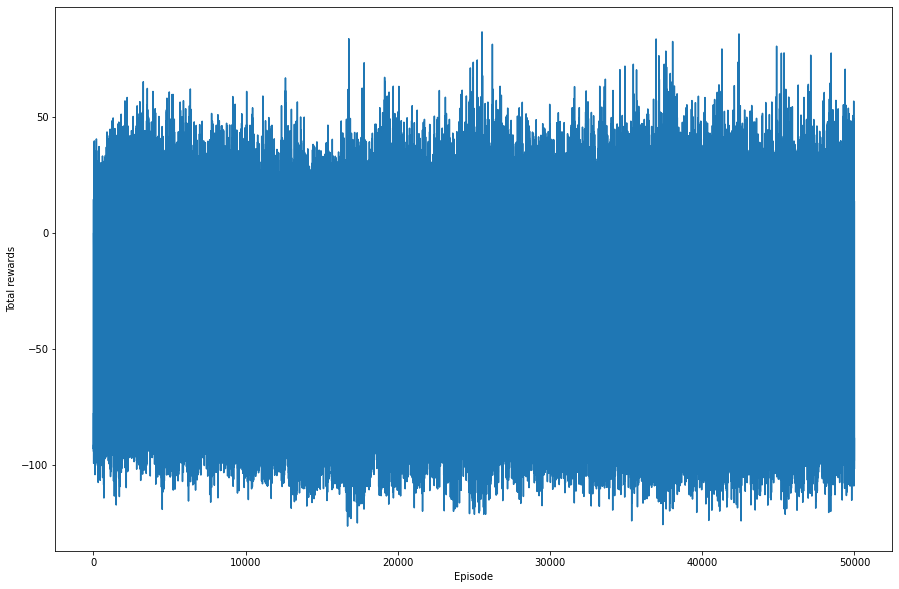

In [13]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

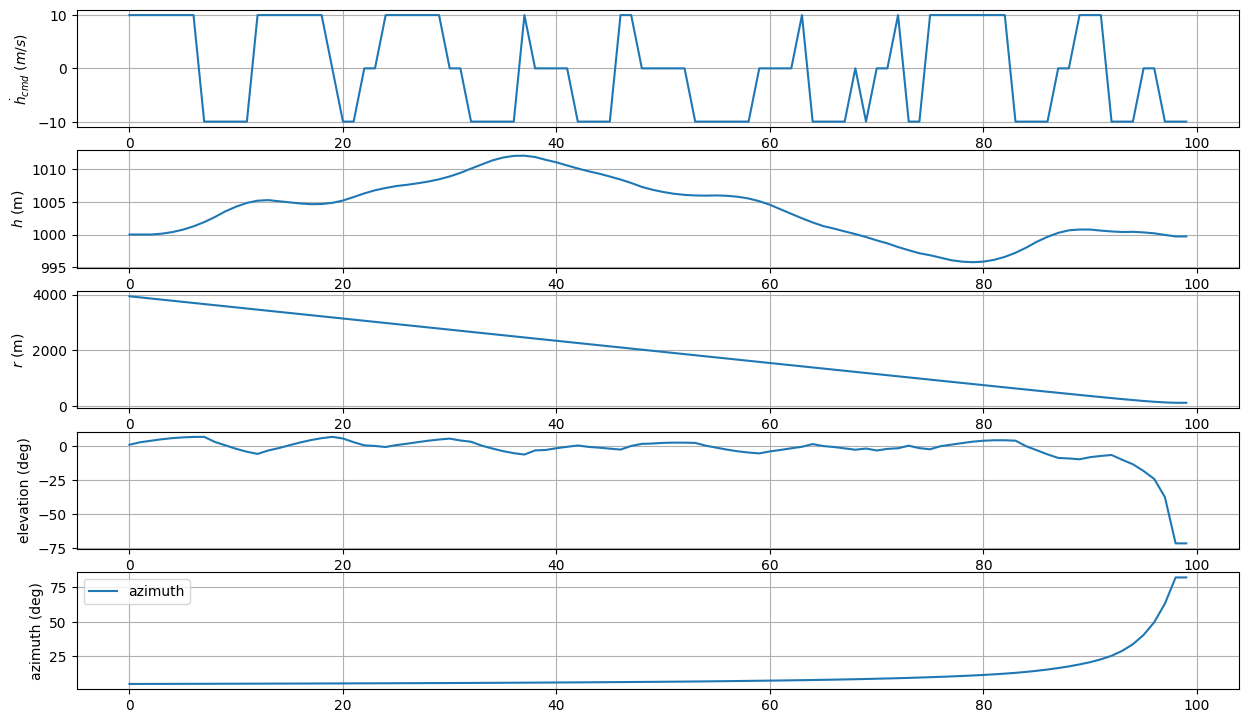

In [14]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[9999]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

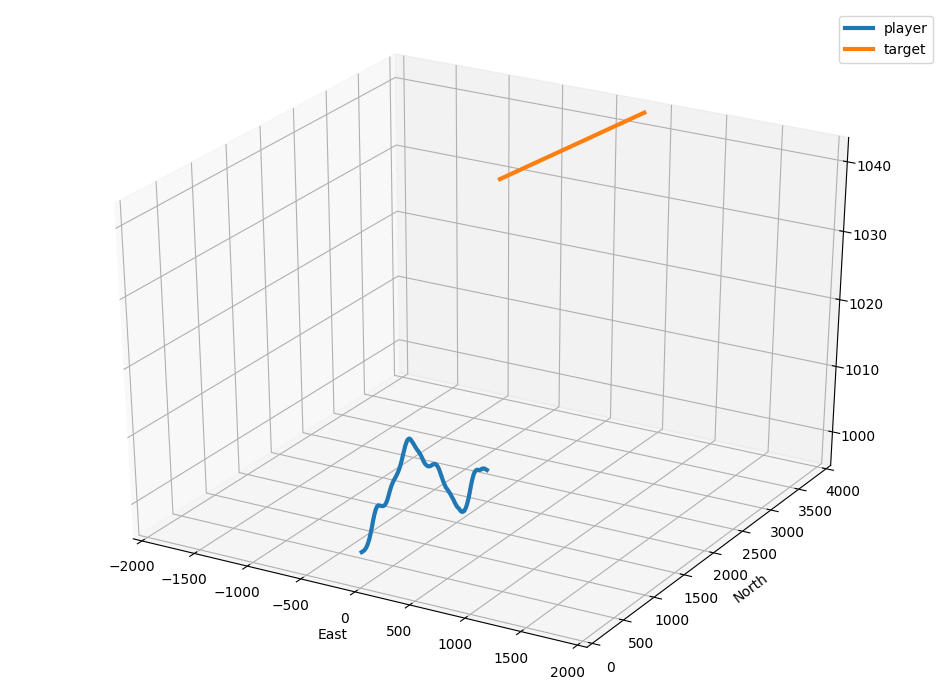

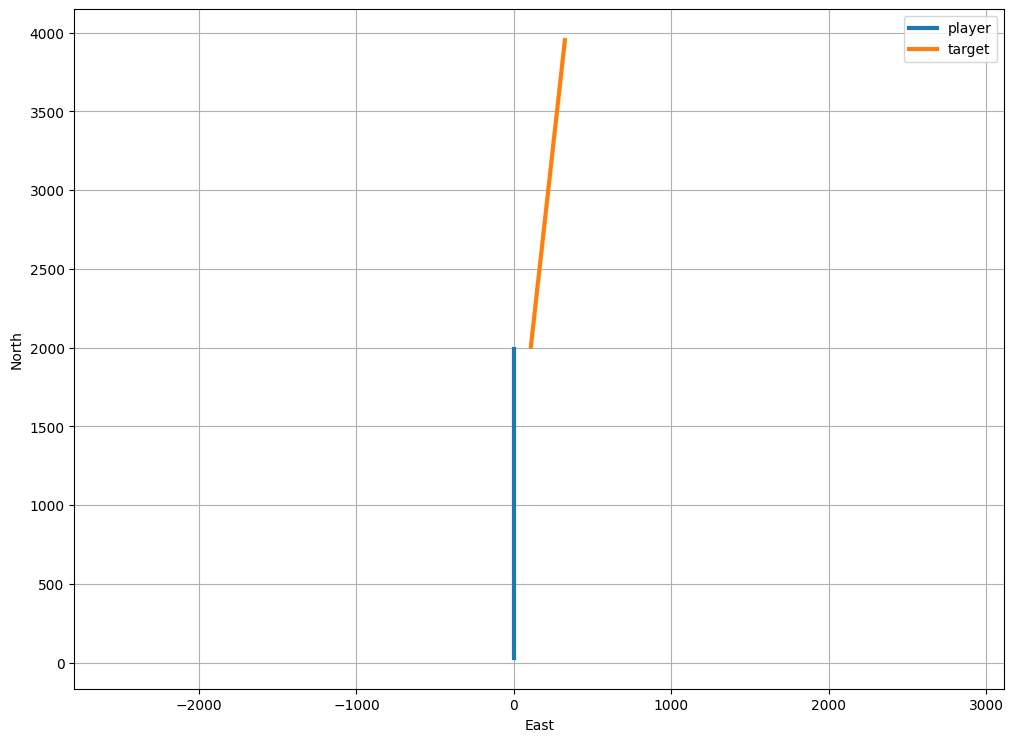

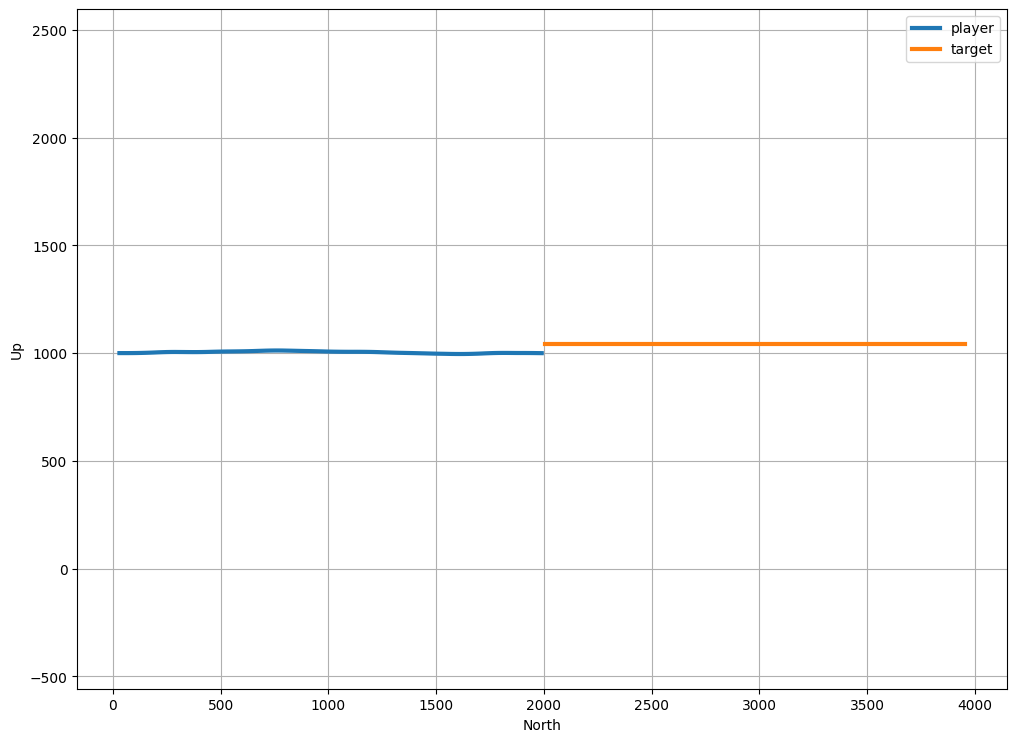

In [15]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()